In [1]:
# Parameters
var_list = [
    "cape",
    "crr",
    "d",
    "ie",
    "ishf",
    "lsrr",
    "pv",
    "q",
    "r",
    "sp",
    "tcw",
    "tcwv",
    "t",
    "ttr",
    "u",
    "v",
    "vo",
    "w",
]
plevel_list = [
    False,
    False,
    300,
    False,
    False,
    False,
    300,
    300,
    300,
    False,
    False,
    False,
    300,
    False,
    300,
    300,
    300,
    300,
]
aew_subset = "12hr_before"
model_save_name = "best_model11_300.keras"
tuner_project_name = "tuner_runmodel11_300"


In [2]:
#!/usr/bin/env python

# coding: utf-8


import numpy as np

import matplotlib.pyplot as plt

import xarray as xr

import sklearn

import sklearn.model_selection

import keras

from keras import layers

import keras_tuner



import tensorflow as tf

import tensorflow.keras.backend as K

keras.utils.set_random_seed(812)

2025-07-16 02:55:47.024365: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-16 02:55:47.028563: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-16 02:55:47.129870: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-16 02:55:47.167350: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752656147.212918   17424 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752656147.22

In [3]:
import tensorflow as tf

def focal_loss(gamma=2.0, alpha=0.25):
    """Focal Loss for binary classification."""
    def loss_fn(y_true, y_pred):
        # Clip to prevent NaNs 
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        modulating_factor = tf.pow(1.0 - p_t, gamma)
        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
        return alpha_factor * modulating_factor * bce
    return loss_fn


In [4]:
#functions to calculate f1 score as loss function

def f1_loss_sigmoid(y_true, y_pred):
    """

    F1 metric for sigmoid output and integer encoded labels.

"""

    # compute tp, fp, and fn

    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)

    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)

    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)


    # precision (tp / (tp + fp))

    p = tp / (tp + fp + K.epsilon())

   # recall (tp / (tp + fn))

    r = tp / (tp + fn + K.epsilon())


# harmonic mean of precision and recall

    f1 = (2 * p * r) / (p + r + K.epsilon())

    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)

    return 1 - K.mean(f1)

In [5]:
def f1_loss_onehot(y_true, y_pred):

   """

   F1 metric for two-class output and one-hot encoded labels.

   """

   # compute tp, fp, and fn

   tp = K.sum(K.cast(y_true[:, 1] * y_pred[:, 1], 'float'), axis=0)

   fp = K.sum(K.cast((1 - y_true[:, 1]) * y_pred[:, 1], 'float'), axis=0)

   fn = K.sum(K.cast(y_true[:, 0] * (1 - y_pred[:, 0]), 'float'), axis=0)


   # precision (tp / (tp + fp))

   p = tp / (tp + fp + K.epsilon())

   # recall (tp / (tp + fn))

   r = tp / (tp + fn + K.epsilon())


   # harmonic mean of precision and recall

   f1 = (2 * p * r) / (p + r + K.epsilon())

   f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)

   return 1 - K.mean(f1)

In [6]:
import re


def add_dim(ds):
    # Extract the source file name from the dataset's encoding.
    fname = ds.encoding.get('source', '')
    # Use a regex to capture the central latitude and longitude from the filename.
    m = re.search(r'_(\-?\d+\.\d+)_(-?\d+\.\d+)\.nc$', fname)
    if m:
        lat_center = float(m.group(1))
        lon_center = float(m.group(2))
        # Assign the central coordinates and the file name as new coordinates.
        ds = ds.assign_coords(lat_center=lat_center, lon_center=lon_center, file_name=fname)
    else:
        print("File name does not match expected pattern:", fname)
    
    # Expand dims to add the 'sample' dimension and drop unnecessary variables.
    return ds.assign_coords({"sample": 1}).expand_dims(dim={"sample": 1}).drop_vars("utc_date").drop_vars("latitude").drop_vars("longitude")




    

In [7]:
import os
import xarray as xr

def open_files_zarr(list_of_vars, aew_subset="12hr_before",
                    directory="/glade/derecho/scratch/rmandava/AEW_time_location_files/",
                    plevel_list=None, zarr_store_path="zarr_data"):
    """
    Opens ERA5 NetCDF files for the given variables. For each variable (or pressure-level variant),
    it checks if a corresponding Zarr store exists in 'zarr_store_path'. If so, it loads the dataset
    from the Zarr store; if not, it opens the NetCDF files, preprocesses them, saves them to Zarr,
    and then returns the dataset.
    """
    # Create the zarr_store_path directory if it doesn't exist.
    if not os.path.exists(zarr_store_path):
        os.makedirs(zarr_store_path)
    
    datas = {}
    for num, var in enumerate(list_of_vars):
        # Determine the key and filename based on whether a pressure level is specified.
        if plevel_list:
            if plevel_list[num]:
                key = f"{var}_{int(plevel_list[num])}"
                file_pattern = f'{directory}/{var}/aew_{aew_subset}_{int(plevel_list[num])}_*.nc'
            else:
                key = var
                file_pattern = f'{directory}/{var}/aew_{aew_subset}_*.nc'
        else:
            key = var
            file_pattern = f'{directory}/{var}/aew_{aew_subset}_*.nc'
        
        # Define the zarr path for this variable.
        zarr_path = os.path.join(zarr_store_path, f"{key}.zarr")
        
        # If the Zarr dataset exists, load from it; otherwise, create it.
        if os.path.exists(zarr_path):
            print(f"Loading {key} from Zarr store.")
            ds = xr.open_zarr(zarr_path)
        else:
            print(f"Creating Zarr store for {key} from NetCDF files.")
            ds = xr.open_mfdataset(
                file_pattern,
                preprocess=add_dim,
                concat_dim="sample",
                combine="nested",
            )
            ds.to_zarr(zarr_path, mode="w")
        datas[key] = ds
    
    return datas


In [8]:
def transpose_load_concat(data_dictionary):
    # Instead of eagerly converting to NumPy arrays, keep the datasets as xarray objects.
    transposed = {}
    for key, ds in data_dictionary.items():
        var_name = key.split('_')[0].upper()
        # Do lazy transpose and add a 'features' dimension
        transposed[key] = ds[var_name].expand_dims('features').transpose('sample', 'latitude', 'longitude', 'features')
    # Concatenate along the new 'features' dimension (if multiple variables exist)
    if len(transposed) > 1:
        data = xr.concat(list(transposed.values()), dim='features',coords='minimal',compat='override')
    else:
        data = list(transposed.values())[0]
    # Use the coordinates (lat_center, lon_center) from one of the datasets.
    # They remain lazy and are not computed until needed.
    first_key = next(iter(data_dictionary))
    lat_center = data_dictionary[first_key]['lat_center']
    lon_center = data_dictionary[first_key]['lon_center']
    label = data_dictionary[first_key]['label']
    return data, label, lat_center, lon_center



In [9]:
def omit_nans(data, label, lat, lon):
    # If data is an xarray DataArray, convert it to a NumPy array
    if hasattr(data, 'values'):
        data = data.values
    maskarray = np.full(data.shape[0], True)
    # Find indices where NaNs occur
    masker = np.unique(np.argwhere(np.isnan(data))[:, 0])
    maskarray[masker] = False

    traindata = data[maskarray, ...]
    trainlabel = label[maskarray]
    lat_filtered = lat[maskarray]
    lon_filtered = lon[maskarray]
    return traindata, trainlabel, lat_filtered, lon_filtered



In [10]:
def zscore(data):

  """

  Rescaling the data using zscore (mean/std).

  Each variable gets scaled independently from others.

  Note that we will need to remove test data for formal training.

  """

  for i in range(0, data_.shape[-1]):

      data_[:, :, :, i] = (

               data_[:, :, :, i] - np.nanmean(

                     data_[:, :, :, i])) / np.nanstd(data_[:, :, :, i])

  return data_

In [11]:
def minmax(data):

   """

   Rescaling the data using min-max.

   Each variable gets scaled independently from others.

   Note that we will need to remove test data for formal training.

   """

   for i in range(0, data_.shape[-1]):

          data_[:, :, :, i] = (

              data_[:, :, :, i] - np.nanmin(data_[:, :, :, i])

          ) / (np.nanmax(data_[:, :, :, i]) - np.nanmin(data_[:, :, :, i]))
   return data

In [12]:
def random_split(data, label, split=0.3, seed=0):

   """

   Help spliting data randomly for training and testing.

   """

   np.random.seed(0)

   da_indx = np.random.permutation(data.shape[0])

   data = data[da_indx.astype(int)]

   label = label[da_indx.astype(int)]

   init_range = int(data.shape[0] * (1 - 0.3))

   return data[:init_range], label[:init_range], data[init_range:], label[init_range:]

In [13]:
def pick_loss(loss_string):
    

    lossdict = {
        "relu": tf.nn.relu,
        "tanh": tf.nn.tanh,
        "selu": tf.nn.selu,
        "sigmoid": tf.nn.sigmoid,
        "relu6": tf.nn.relu6,
        "silu": tf.nn.silu,
        "gelu": tf.nn.gelu,
        "lrelu": tf.nn.leaky_relu,
    }

    return lossdict[loss_string]

In [14]:
def compute_saliency_map(model, input_sample):
    """
    Compute a saliency map for a given input sample using a gradient-based approach.
    
    Args:
        model (tf.keras.Model): The trained Keras model.
        input_sample (numpy array): A single input sample of shape (1, height, width, channels).
    
    Returns:
        saliency (numpy array): The saliency map of shape (height, width).
    """
    # Ensure the model is in inference mode
    model.trainable = False
    input_tensor = tf.convert_to_tensor(input_sample)
    
    # Use GradientTape to record operations for automatic differentiation
    with tf.GradientTape() as tape:
        # Watch the input tensor
        tape.watch(input_tensor)
        # Get the model's prediction
        prediction = model(input_tensor)
    
    # Compute gradients of the prediction with respect to the input
    grads = tape.gradient(prediction, input_tensor)
    
    # If there are multiple channels, take the maximum absolute gradient across channels
    saliency = np.max(np.abs(grads.numpy()), axis=-1)[0]
    return saliency

In [15]:
def compute_saliency_per_channel(model, input_sample):
    """
    Computes the saliency map for each channel of a given input sample.
    
    Args:
        model (tf.keras.Model): The trained Keras model.
        input_sample (numpy array): A single input sample with shape (1, H, W, C).
        
    Returns:
        saliency_maps (numpy array): Absolute gradients with shape (H, W, C) for each channel.
        channel_importance (numpy array): Mean saliency per channel (shape: (C,)).
    """
    # Set the model to inference mode
    model.trainable = False
    input_tensor = tf.convert_to_tensor(input_sample)
    
    # Compute gradients with respect to the input sample using GradientTape
    with tf.GradientTape() as tape:
        tape.watch(input_tensor)
        prediction = model(input_tensor)
    
    # Calculate gradients: shape (1, H, W, C)
    grads = tape.gradient(prediction, input_tensor)
    
    # Remove the batch dimension: shape becomes (H, W, C)
    grads = grads.numpy()[0]
    
    # Take absolute value to measure importance (magnitude of sensitivity)
    saliency_maps = np.abs(grads)
    
    # Aggregate saliency per channel (e.g., using the mean over spatial dimensions)
    channel_importance = np.mean(saliency_maps, axis=(0, 1))
    
    return saliency_maps, channel_importance

In [16]:
number_of_features = len(var_list)

In [17]:
data = open_files_zarr(
    list_of_vars=var_list,
    aew_subset=aew_subset,
    directory="/glade/derecho/scratch/rmandava/AEW_time_location_files/",
    plevel_list=plevel_list,
    zarr_store_path="/glade/derecho/scratch/rmandava/AEW_time_location_files/Project1/zarr"
)






Loading cape from Zarr store.


Loading crr from Zarr store.
Loading d_300 from Zarr store.
Loading ie from Zarr store.


Loading ishf from Zarr store.
Loading lsrr from Zarr store.
Loading pv_300 from Zarr store.


Loading q_300 from Zarr store.
Loading r_300 from Zarr store.
Loading sp from Zarr store.
Loading tcw from Zarr store.
Loading tcwv from Zarr store.
Loading t_300 from Zarr store.


Loading ttr from Zarr store.
Loading u_300 from Zarr store.
Loading v_300 from Zarr store.


Loading vo_300 from Zarr store.
Loading w_300 from Zarr store.


In [18]:
# transpose the data and concat variables

#data_, labels_ = transpose_load_concat(data)
data_, labels_, sample_lat, sample_lon = transpose_load_concat(data)

print(np.shape(data_))

(2750, 32, 32, 18)


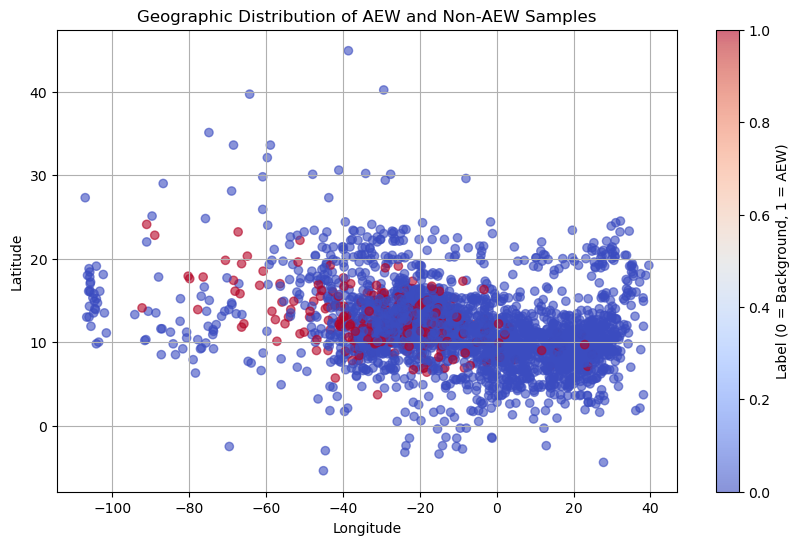

In [19]:
import matplotlib.pyplot as plt

# Scatter plot: where are the samples located, colored by label (AEW or not)
plt.figure(figsize=(10, 6))
sc = plt.scatter(sample_lon, sample_lat, c=labels_, cmap='coolwarm', alpha=0.6)
plt.colorbar(sc, label="Label (0 = Background, 1 = AEW)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Geographic Distribution of AEW and Non-AEW Samples")
plt.grid(True)
plt.show()


In [20]:
print(var_list)


['cape', 'crr', 'd', 'ie', 'ishf', 'lsrr', 'pv', 'q', 'r', 'sp', 'tcw', 'tcwv', 't', 'ttr', 'u', 'v', 'vo', 'w']


In [21]:
# check / remove nans

data_, labels_, sample_lat, sample_lon = omit_nans(data_, labels_, sample_lat, sample_lon)






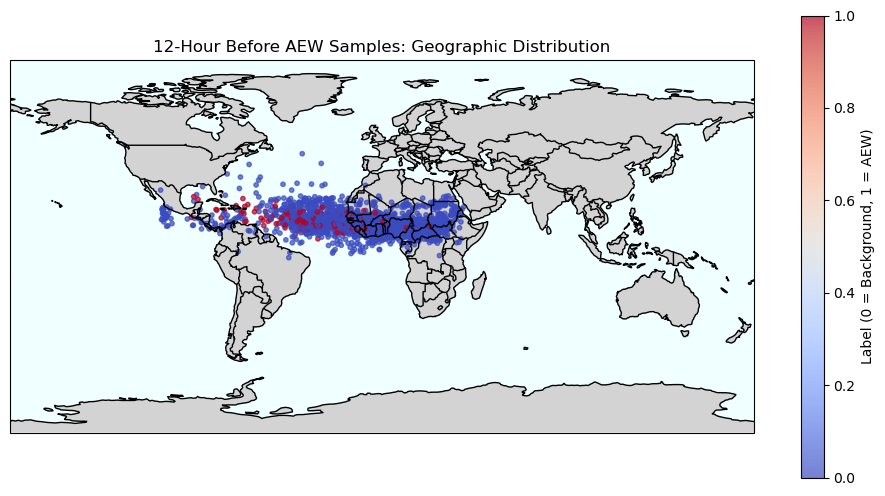

In [22]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

plt.figure(figsize=(12, 6))

# Set up map projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='azure')

# Plot sample locations colored by label
sc = ax.scatter(sample_lon, sample_lat, c=labels_, cmap='coolwarm', s=10, alpha=0.7, transform=ccrs.PlateCarree())
plt.colorbar(sc, ax=ax, label="Label (0 = Background, 1 = AEW)")
plt.title("12-Hour Before AEW Samples: Geographic Distribution")
plt.show()

In [23]:
print("Total samples:", len(sample_lat))


Total samples: 2750


In [24]:
print("Latitude Range:", float(sample_lat.min().compute()), "to", float(sample_lat.max().compute()))
print("Longitude Range:", float(sample_lon.min().compute()), "to", float(sample_lon.max().compute()))


Latitude Range: -5.4 to 44.9
Longitude Range: -107.1 to 39.6


In [25]:
#split train and test set
X_train, X_test, y_train, y_test, lat_train, lat_test, lon_train, lon_test = sklearn.model_selection.train_test_split(
    data_, labels_, sample_lat, sample_lon, test_size=0.2, random_state=42)



print (np.shape(X_train), np.shape(X_test), np.shape(y_train), np.shape(y_test))


y_train = np.expand_dims(y_train, axis=1)

y_test = np.expand_dims(y_test, axis=1)

(2200, 32, 32, 18) (550, 32, 32, 18) (2200,) (550,)


/glade/u/home/rmandava/.local/lib/python3.10/site-packages/xarray/core/indexing.py:1642: PerformanceWarning: Slicing with an out-of-order index is generating 412 times more chunks
  return self.array[key]
/glade/u/home/rmandava/.local/lib/python3.10/site-packages/xarray/core/indexing.py:1642: PerformanceWarning: Slicing with an out-of-order index is generating 109 times more chunks
  return self.array[key]


In [26]:
# [21]: Scaling code (fixed to prevent data leakage)

# Create the scaler object
scaler_input = sklearn.preprocessing.StandardScaler()

# Reshape training data to 2D (samples, features)
X_train_tmp = np.reshape(X_train, (-1, len(var_list)))

# Fit the scaler ONLY on the training data
scaler_input.fit(X_train_tmp)  # <-- Key change: Learn mean/std from training data

# Transform BOTH training and test data using the SAME scaler
input_train_scaled = scaler_input.transform(X_train_tmp)          # Train: transform only
input_test_scaled = scaler_input.transform(                       # Test: transform only
    np.reshape(X_test, (-1, len(var_list)))
)

# Reshape back to original dimensions (samples, height, width, features)
input_train_scaled = np.reshape(input_train_scaled, X_train.shape)
input_test_scaled = np.reshape(input_test_scaled, X_test.shape)

# Labels remain unchanged
label_train_scaled = y_train
label_test_scaled = y_test

In [27]:
# print the shapes to double check them

print(

input_train_scaled.shape,

label_train_scaled.shape,

input_test_scaled.shape,

label_test_scaled.shape

)

(2200, 32, 32, 18) (2200, 1) (550, 32, 32, 18) (550, 1)


In [28]:
#generate class weights due to class imbalance issues

counts = np.bincount(y_train[:, 0].astype(int))


print(

"Number of positive samples in training data: {} ({:.2f}% of total)".format(

counts[1], 100 * float(counts[1]) / len(y_train))

)

Number of positive samples in training data: 204 (9.27% of total)


In [29]:
# old weights

# weight_for_0 = 1.0 / counts[0]

# weight_for_1 = 1.0 / counts[1]


#new weights

weight_for_0 = float(counts[1]) / len(y_train)

weight_for_1 = 1 - (float(counts[1]) / len(y_train))


class_weight = {0: weight_for_0, 1: weight_for_1}

print(class_weight)

{0: 0.09272727272727273, 1: 0.9072727272727272}


In [30]:
METRICS = [

keras.metrics.BinaryCrossentropy(name='cross entropy'),

keras.metrics.MeanSquaredError(name='mean_squared_error'),

keras.metrics.RootMeanSquaredError(name='root_mean_squared_error'),

keras.metrics.TruePositives(name='tp'),

keras.metrics.FalsePositives(name='fp'),

keras.metrics.TrueNegatives(name='tn'),

keras.metrics.FalseNegatives(name='fn'),

keras.metrics.BinaryAccuracy(name='binary_accuracy'),

keras.metrics.F1Score(threshold=0.5, name='f1_score'),

keras.metrics.Precision(name='precision'),

keras.metrics.Recall(name='recall'),

keras.metrics.AUC(name='auc'),

keras.metrics.AUC(name='prc', curve='PR'),

]

2025-07-16 02:58:02.980205: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Activation
from tensorflow.keras.regularizers import l2

class MyHyperModel(keras_tuner.HyperModel):
    def build(self, hp):
        input_shape = (32, 32, 18)  # You can make this a tunable choice if needed

        learning_rate = hp.Float("learning_rate", min_value=1e-5, max_value=1e-2, sampling="log")

        model = Sequential()

        # Block 1
        model.add(Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(1e-4), input_shape=input_shape))
        model.add(BatchNormalization())
        model.add(Activation('gelu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # Block 2
        model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(1e-4)))
        model.add(BatchNormalization())
        model.add(Activation('gelu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # Block 3
        model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(1e-4)))
        model.add(BatchNormalization())
        model.add(Activation('gelu'))
        model.add(Dropout(0.25))

        # Dense Layers
        model.add(Flatten())
        model.add(Dense(128, kernel_regularizer=l2(1e-4)))
        model.add(BatchNormalization())
        model.add(Activation('gelu'))
        model.add(Dropout(0.4))

        # Output Layer
        model.add(Dense(1, activation='sigmoid'))

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
            loss=focal_loss(gamma=2.0, alpha=0.25),  # fixed for now; we can tune later
            metrics=METRICS
        )

        return model





In [32]:
def fit(self, hp, model, *args, **kwargs):
    batchsizenum = hp.Int('batch_size', min_value=10, max_value=60, step=5, sampling="linear")

    print({k: hp.get(k) if hp.is_active(k) else None for k in hp._hps})

    return model.fit(
        *args,
        batch_size=batchsizenum,
        # normally we might use early stopping, but not needed since
        # callbacks saves checkpoints of the model during trials
        # callbacks=keras.callbacks.EarlyStopping('val_loss', patience=5),
        validation_split=0.1,
        shuffle=True,
        class_weight=class_weight,
        **kwargs,
    )


In [33]:
# make the tuner object
tuner = keras_tuner.BayesianOptimization(
    hypermodel=MyHyperModel(),
    objective=keras_tuner.Objective("val_f1_score", direction="max"),
    max_trials=150,
    project_name=tuner_project_name,
    alpha=0.0001,
    beta=2.6,
    seed=123,
    tune_new_entries=True,
    allow_new_entries=True,
    max_retries_per_trial=1,
    max_consecutive_failed_trials=3,
    overwrite=True,
)

# summary
tuner.search_space_summary()


Search space summary
Default search space size: 1
learning_rate (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


/glade/u/home/rmandava/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [34]:
import numpy as np

labels_np = np.array(labels_)

total = len(labels_np)
positives = np.sum(labels_np == 1)
negatives = np.sum(labels_np == 0)

print("Total samples:", total)
print("AEW-positive samples (label=1):", positives)
print("Background samples (label=0):", negatives)


Total samples: 2750
AEW-positive samples (label=1): 258
Background samples (label=0): 2492


In [35]:
# Begin the search
EPOCHS = 100

from sklearn.model_selection import StratifiedShuffleSplit

# Create a stratified split from training data
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_idx, val_idx in sss.split(X_train, y_train):
    X_tune_train, X_tune_val = X_train[train_idx], X_train[val_idx]
    y_tune_train, y_tune_val = y_train[train_idx], y_train[val_idx]

# Run tuner search on new validation data
tuner.search(X_tune_train, y_tune_train,
             validation_data=(X_tune_val, y_tune_val),
             epochs=100)

# Query the tuner object to grab the best models
models = tuner.get_best_models(num_models=5)

# Here is the best model from the tuner
best_model = models[0]
print(best_model.summary())

# Get the top hyperparameters.
best_hps = tuner.get_best_hyperparameters()

# Build the model with the best hyperparameters.
# Assuming your MyHyperModel has a build method that takes a hyperparameter object.
model = MyHyperModel().build(best_hps[0])

# Save the best model (architecture and weights)

save_dir = "/glade/derecho/scratch/rmandava/AEW_time_location_files/models"
model_save_path = os.path.join(save_dir, model_save_name)

model.save(model_save_path)


# Retrain using "best" model hyperparameters
history = model.fit(
    input_train_scaled,
    label_train_scaled,
    epochs=EPOCHS,
    validation_split=0.1,
    batch_size= 32,
    # callbacks=keras.callbacks.EarlyStopping('val_loss', patience=3),
    shuffle=True,
    class_weight=class_weight,  # Ensure 'class_weight' is defined in your scope
)

# Evaluate the model on the test data using `evaluate`
results = model.evaluate(input_test_scaled, label_test_scaled, batch_size=label_test_scaled.shape[0])
print(results)

# Generate predictions (probabilities—the output of the last layer)
predictions = model.predict(input_test_scaled)
print("predictions shape:", predictions.shape)

# Compute confusion matrix elements
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(
    label_test_scaled, np.round(predictions)
).ravel()
print("tn:", tn)
print("fp:", fp)
print("fn:", fn)
print("tp:", tp)


Trial 150 Complete [00h 02m 05s]
val_f1_score: 0.3809523582458496

Best val_f1_score So Far: 0.5833332538604736
Total elapsed time: 05h 01m 33s


/glade/u/home/rmandava/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │         5,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 586,337 (2.24 MB)

 Trainable params: 585,761 (2.23 MB)

 Non-trainable params: 576 (2.25 KB)

None


Epoch 1/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2:06 2s/step - auc: 0.5792 - binary_accuracy: 0.8492 - cross entropy: 0.3942 - f1_score: 0.0500 - fn: 21.0000 - fp: 17.0000 - loss: 0.0606 - mean_squared_error: 0.1174 - prc: 0.1070 - precision: 0.0556 - recall: 0.0455 - root_mean_squared_error: 0.3426 - tn: 213.0000 - tp: 1.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.5549 - binary_accuracy: 0.8025 - cross entropy: 0.4499 - f1_score: 0.0785 - fn: 22.5000 - fp: 38.0000 - loss: 0.0617 - mean_squared_error: 0.1403 - prc: 0.1138 - precision: 0.0657 - recall: 0.1045 - root_mean_squared_error: 0.3739 - tn: 236.7500 - tp: 2.7500

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.5527 - binary_accuracy: 0.7674 - cross entropy: 0.4870 - f1_score: 0.0984 - fn: 23.5714 - fp: 60.4286 - loss: 0.0616 - mean_squared_error: 0.1560 - prc: 0.1198 - precision: 0.0734 - recall: 0.1660 - root_mean_squared_error: 0.3939 - tn: 258.8571 - tp: 5.1429

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.5567 - binary_accuracy: 0.7449 - cross entropy: 0.5140 - f1_score: 0.1141 - fn: 24.6000 - fp: 81.1000 - loss: 0.0616 - mean_squared_error: 0.1672 - prc: 0.1243 - precision: 0.0804 - recall: 0.2179 - root_mean_squared_error: 0.4076 - tn: 282.5000 - tp: 7.8000

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.5730 - binary_accuracy: 0.7268 - cross entropy: 0.5363 - f1_score: 0.1405 - fn: 26.2143 - fp: 105.7143 - loss: 0.0613 - mean_squared_error: 0.1765 - prc: 0.1363 - precision: 0.0956 - recall: 0.2867 - root_mean_squared_error: 0.4189 - tn: 315.1429 - tp: 12.9286

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.5862 - binary_accuracy: 0.7163 - cross entropy: 0.5505 - f1_score: 0.1581 - fn: 27.7222 - fp: 128.1667 - loss: 0.0609 - mean_squared_error: 0.1825 - prc: 0.1472 - precision: 0.1055 - recall: 0.3353 - root_mean_squared_error: 0.4260 - tn: 350.5555 - tp: 17.5556

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.5959 - binary_accuracy: 0.7082 - cross entropy: 0.5618 - f1_score: 0.1708 - fn: 29.8182 - fp: 150.0000 - loss: 0.0608 - mean_squared_error: 0.1871 - prc: 0.1561 - precision: 0.1129 - recall: 0.3688 - root_mean_squared_error: 0.4315 - tn: 386.0909 - tp: 22.0909

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.6008 - binary_accuracy: 0.7010 - cross entropy: 0.5717 - f1_score: 0.1808 - fn: 32.6154 - fp: 171.8462 - loss: 0.0610 - mean_squared_error: 0.1912 - prc: 0.1624 - precision: 0.1189 - recall: 0.3924 - root_mean_squared_error: 0.4363 - tn: 420.7692 - tp: 26.7692

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.6059 - binary_accuracy: 0.6955 - cross entropy: 0.5790 - f1_score: 0.1887 - fn: 35.1333 - fp: 193.4667 - loss: 0.0610 - mean_squared_error: 0.1943 - prc: 0.1672 - precision: 0.1237 - recall: 0.4123 - root_mean_squared_error: 0.4398 - tn: 456.0667 - tp: 31.3333

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.6104 - binary_accuracy: 0.6923 - cross entropy: 0.5829 - f1_score: 0.1939 - fn: 36.6970 - fp: 209.5455 - loss: 0.0609 - mean_squared_error: 0.1960 - prc: 0.1717 - precision: 0.1266 - recall: 0.4264 - root_mean_squared_error: 0.4417 - tn: 483.0303 - tp: 34.7273

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.6161 - binary_accuracy: 0.6884 - cross entropy: 0.5875 - f1_score: 0.1999 - fn: 38.5405 - fp: 231.5135 - loss: 0.0607 - mean_squared_error: 0.1979 - prc: 0.1763 - precision: 0.1300 - recall: 0.4442 - root_mean_squared_error: 0.4440 - tn: 518.5946 - tp: 39.3514

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.6214 - binary_accuracy: 0.6853 - cross entropy: 0.5912 - f1_score: 0.2050 - fn: 40.5610 - fp: 252.8781 - loss: 0.0606 - mean_squared_error: 0.1995 - prc: 0.1811 - precision: 0.1330 - recall: 0.4587 - root_mean_squared_error: 0.4458 - tn: 554.6342 - tp: 43.9268

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.6256 - binary_accuracy: 0.6830 - cross entropy: 0.5944 - f1_score: 0.2100 - fn: 42.8444 - fp: 273.2444 - loss: 0.0605 - mean_squared_error: 0.2008 - prc: 0.1845 - precision: 0.1361 - recall: 0.4706 - root_mean_squared_error: 0.4473 - tn: 591.2889 - tp: 48.6222

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.6294 - binary_accuracy: 0.6816 - cross entropy: 0.5971 - f1_score: 0.2142 - fn: 44.9592 - fp: 292.8571 - loss: 0.0604 - mean_squared_error: 0.2018 - prc: 0.1867 - precision: 0.1386 - recall: 0.4812 - root_mean_squared_error: 0.4485 - tn: 629.1224 - tp: 53.0612

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.6327 - binary_accuracy: 0.6804 - cross entropy: 0.5997 - f1_score: 0.2176 - fn: 47.0377 - fp: 312.3585 - loss: 0.0604 - mean_squared_error: 0.2028 - prc: 0.1880 - precision: 0.1406 - recall: 0.4902 - root_mean_squared_error: 0.4496 - tn: 667.3019 - tp: 57.3019

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.6358 - binary_accuracy: 0.6795 - cross entropy: 0.6019 - f1_score: 0.2205 - fn: 48.9474 - fp: 331.8772 - loss: 0.0603 - mean_squared_error: 0.2036 - prc: 0.1891 - precision: 0.1423 - recall: 0.4987 - root_mean_squared_error: 0.4506 - tn: 705.7193 - tp: 61.4561

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.6378 - binary_accuracy: 0.6787 - cross entropy: 0.6033 - f1_score: 0.2223 - fn: 50.4000 - fp: 346.8000 - loss: 0.0602 - mean_squared_error: 0.2042 - prc: 0.1896 - precision: 0.1433 - recall: 0.5042 - root_mean_squared_error: 0.4512 - tn: 734.3500 - tp: 64.4500

62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - auc: 0.6398 - binary_accuracy: 0.6781 - cross entropy: 0.6044 - f1_score: 0.2240 - fn: 51.9365 - fp: 361.1905 - loss: 0.0602 - mean_squared_error: 0.2046 - prc: 0.1903 - precision: 0.1443 - recall: 0.5091 - root_mean_squared_error: 0.4518 - tn: 762.7936 - tp: 67.4444 - val_auc: 0.9119 - val_binary_accuracy: 0.8000 - val_cross entropy: 0.5895 - val_f1_score: 0.3529 - val_fn: 1.0000 - val_fp: 43.0000 - val_loss: 0.1354 - val_mean_squared_error: 0.1989 - val_prc: 0.2969 - val_precision: 0.2182 - val_recall: 0.9231 - val_root_mean_squared_error: 0.4460 - val_tn: 164.0000 - val_tp: 12.0000


Epoch 2/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 0.5000 - binary_accuracy: 0.6562 - cross entropy: 0.5969 - f1_score: 0.0000e+00 - fn: 2.0000 - fp: 9.0000 - loss: 0.0553 - mean_squared_error: 0.1998 - prc: 0.0598 - precision: 0.0000e+00 - recall: 0.0000e+00 - root_mean_squared_error: 0.4470 - tn: 21.0000 - tp: 0.0000e+00

 4/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.5953 - binary_accuracy: 0.6751 - cross entropy: 0.6120 - f1_score: 0.1327 - fn: 2.5000 - fp: 23.2500 - loss: 0.0555 - mean_squared_error: 0.2082 - prc: 0.0777 - precision: 0.0801 - recall: 0.3958 - root_mean_squared_error: 0.4563 - tn: 51.5000 - tp: 2.7500               

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.6311 - binary_accuracy: 0.6827 - cross entropy: 0.5989 - f1_score: 0.1676 - fn: 3.7143 - fp: 36.2857 - loss: 0.0544 - mean_squared_error: 0.2040 - prc: 0.0901 - precision: 0.1016 - recall: 0.4844 - root_mean_squared_error: 0.4516 - tn: 83.0000 - tp: 5.0000

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.6459 - binary_accuracy: 0.6839 - cross entropy: 0.5884 - f1_score: 0.1841 - fn: 6.1818 - fp: 54.0000 - loss: 0.0538 - mean_squared_error: 0.2005 - prc: 0.0992 - precision: 0.1126 - recall: 0.5115 - root_mean_squared_error: 0.4477 - tn: 123.9091 - tp: 7.9091

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.6462 - binary_accuracy: 0.6854 - cross entropy: 0.5844 - f1_score: 0.1957 - fn: 9.5333 - fp: 70.3333 - loss: 0.0539 - mean_squared_error: 0.1993 - prc: 0.1166 - precision: 0.1216 - recall: 0.5118 - root_mean_squared_error: 0.4463 - tn: 165.0667 - tp: 11.0667

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.6520 - binary_accuracy: 0.6898 - cross entropy: 0.5814 - f1_score: 0.2082 - fn: 12.2632 - fp: 85.4211 - loss: 0.0540 - mean_squared_error: 0.1980 - prc: 0.1297 - precision: 0.1309 - recall: 0.5211 - root_mean_squared_error: 0.4449 - tn: 207.6316 - tp: 14.6842

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.6603 - binary_accuracy: 0.6932 - cross entropy: 0.5777 - f1_score: 0.2207 - fn: 14.8261 - fp: 100.6087 - loss: 0.0539 - mean_squared_error: 0.1965 - prc: 0.1425 - precision: 0.1400 - recall: 0.5329 - root_mean_squared_error: 0.4432 - tn: 249.6522 - tp: 18.9130

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.6690 - binary_accuracy: 0.6967 - cross entropy: 0.5740 - f1_score: 0.2325 - fn: 16.5769 - fp: 111.0385 - loss: 0.0538 - mean_squared_error: 0.1950 - prc: 0.1558 - precision: 0.1488 - recall: 0.5449 - root_mean_squared_error: 0.4415 - tn: 281.5769 - tp: 22.8077

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.6770 - binary_accuracy: 0.6999 - cross entropy: 0.5707 - f1_score: 0.2420 - fn: 18.2069 - fp: 121.4828 - loss: 0.0536 - mean_squared_error: 0.1936 - prc: 0.1684 - precision: 0.1558 - recall: 0.5553 - root_mean_squared_error: 0.4399 - tn: 313.7931 - tp: 26.5172

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.6853 - binary_accuracy: 0.7033 - cross entropy: 0.5675 - f1_score: 0.2516 - fn: 20.2424 - fp: 135.7576 - loss: 0.0534 - mean_squared_error: 0.1922 - prc: 0.1810 - precision: 0.1629 - recall: 0.5667 - root_mean_squared_error: 0.4383 - tn: 356.8182 - tp: 31.1818

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.6931 - binary_accuracy: 0.7068 - cross entropy: 0.5643 - f1_score: 0.2601 - fn: 22.0811 - fp: 149.5135 - loss: 0.0532 - mean_squared_error: 0.1909 - prc: 0.1921 - precision: 0.1690 - recall: 0.5774 - root_mean_squared_error: 0.4368 - tn: 400.5946 - tp: 35.8108

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.6994 - binary_accuracy: 0.7094 - cross entropy: 0.5618 - f1_score: 0.2670 - fn: 24.0732 - fp: 163.6098 - loss: 0.0531 - mean_squared_error: 0.1898 - prc: 0.2005 - precision: 0.1740 - recall: 0.5856 - root_mean_squared_error: 0.4356 - tn: 443.9024 - tp: 40.4146

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.7050 - binary_accuracy: 0.7118 - cross entropy: 0.5595 - f1_score: 0.2734 - fn: 26.2667 - fp: 177.4000 - loss: 0.0529 - mean_squared_error: 0.1889 - prc: 0.2078 - precision: 0.1788 - recall: 0.5921 - root_mean_squared_error: 0.4345 - tn: 487.1333 - tp: 45.2000

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.7097 - binary_accuracy: 0.7140 - cross entropy: 0.5574 - f1_score: 0.2784 - fn: 28.3673 - fp: 191.0612 - loss: 0.0528 - mean_squared_error: 0.1880 - prc: 0.2132 - precision: 0.1825 - recall: 0.5974 - root_mean_squared_error: 0.4334 - tn: 530.9184 - tp: 49.6531

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.7138 - binary_accuracy: 0.7160 - cross entropy: 0.5555 - f1_score: 0.2823 - fn: 30.4340 - fp: 204.7736 - loss: 0.0527 - mean_squared_error: 0.1872 - prc: 0.2176 - precision: 0.1854 - recall: 0.6018 - root_mean_squared_error: 0.4325 - tn: 574.8868 - tp: 53.9057

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.7174 - binary_accuracy: 0.7176 - cross entropy: 0.5539 - f1_score: 0.2857 - fn: 32.2632 - fp: 218.8596 - loss: 0.0525 - mean_squared_error: 0.1865 - prc: 0.2208 - precision: 0.1879 - recall: 0.6065 - root_mean_squared_error: 0.4318 - tn: 618.7368 - tp: 58.1404

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.7197 - binary_accuracy: 0.7189 - cross entropy: 0.5527 - f1_score: 0.2879 - fn: 33.6500 - fp: 229.1500 - loss: 0.0525 - mean_squared_error: 0.1861 - prc: 0.2228 - precision: 0.1894 - recall: 0.6095 - root_mean_squared_error: 0.4312 - tn: 652.0000 - tp: 61.2000

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.7217 - binary_accuracy: 0.7202 - cross entropy: 0.5515 - f1_score: 0.2902 - fn: 35.0794 - fp: 239.0159 - loss: 0.0524 - mean_squared_error: 0.1856 - prc: 0.2248 - precision: 0.1911 - recall: 0.6121 - root_mean_squared_error: 0.4306 - tn: 684.9683 - tp: 64.3016 - val_auc: 0.9158 - val_binary_accuracy: 0.8909 - val_cross entropy: 0.4484 - val_f1_score: 0.4783 - val_fn: 2.0000 - val_fp: 22.0000 - val_loss: 0.0908 - val_mean_squared_error: 0.1354 - val_prc: 0.4073 - val_precision: 0.3333 - val_recall: 0.8462 - val_root_mean_squared_error: 0.3679 - val_tn: 185.0000 - val_tp: 11.0000


Epoch 3/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 0.9667 - binary_accuracy: 0.8750 - cross entropy: 0.4878 - f1_score: 0.5000 - fn: 0.0000e+00 - fp: 4.0000 - loss: 0.0482 - mean_squared_error: 0.1414 - prc: 0.4507 - precision: 0.3333 - recall: 1.0000 - root_mean_squared_error: 0.3761 - tn: 26.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9628 - binary_accuracy: 0.8190 - cross entropy: 0.4732 - f1_score: 0.3988 - fn: 0.5000 - fp: 15.0000 - loss: 0.0457 - mean_squared_error: 0.1431 - prc: 0.5056 - precision: 0.2553 - recall: 0.9375 - root_mean_squared_error: 0.3782 - tn: 59.7500 - tp: 4.7500   

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9298 - binary_accuracy: 0.8113 - cross entropy: 0.4738 - f1_score: 0.3777 - fn: 1.7500 - fp: 26.3750 - loss: 0.0454 - mean_squared_error: 0.1464 - prc: 0.4684 - precision: 0.2427 - recall: 0.8648 - root_mean_squared_error: 0.3826 - tn: 107.8750 - tp: 8.0000

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9080 - binary_accuracy: 0.8092 - cross entropy: 0.4740 - f1_score: 0.3740 - fn: 3.3636 - fp: 34.2727 - loss: 0.0457 - mean_squared_error: 0.1476 - prc: 0.4379 - precision: 0.2434 - recall: 0.8223 - root_mean_squared_error: 0.3842 - tn: 143.6364 - tp: 10.7273

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8940 - binary_accuracy: 0.8085 - cross entropy: 0.4730 - f1_score: 0.3779 - fn: 5.1429 - fp: 41.7143 - loss: 0.0458 - mean_squared_error: 0.1480 - prc: 0.4250 - precision: 0.2500 - recall: 0.7940 - root_mean_squared_error: 0.3847 - tn: 179.1429 - tp: 14.0000

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8856 - binary_accuracy: 0.8092 - cross entropy: 0.4713 - f1_score: 0.3813 - fn: 6.6471 - fp: 48.8824 - loss: 0.0459 - mean_squared_error: 0.1480 - prc: 0.4166 - precision: 0.2549 - recall: 0.7773 - root_mean_squared_error: 0.3847 - tn: 215.3529 - tp: 17.1176

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8793 - binary_accuracy: 0.8109 - cross entropy: 0.4691 - f1_score: 0.3867 - fn: 8.2000 - fp: 55.3500 - loss: 0.0459 - mean_squared_error: 0.1475 - prc: 0.4125 - precision: 0.2613 - recall: 0.7652 - root_mean_squared_error: 0.3840 - tn: 252.0500 - tp: 20.4000

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8748 - binary_accuracy: 0.8121 - cross entropy: 0.4670 - f1_score: 0.3917 - fn: 9.8696 - fp: 61.9565 - loss: 0.0459 - mean_squared_error: 0.1470 - prc: 0.4109 - precision: 0.2672 - recall: 0.7556 - root_mean_squared_error: 0.3834 - tn: 288.3044 - tp: 23.8696

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8704 - binary_accuracy: 0.8131 - cross entropy: 0.4650 - f1_score: 0.3993 - fn: 12.1481 - fp: 70.8889 - loss: 0.0460 - mean_squared_error: 0.1465 - prc: 0.4115 - precision: 0.2757 - recall: 0.7472 - root_mean_squared_error: 0.3828 - tn: 335.9259 - tp: 29.0370

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8681 - binary_accuracy: 0.8136 - cross entropy: 0.4641 - f1_score: 0.4036 - fn: 13.6333 - fp: 78.0000 - loss: 0.0460 - mean_squared_error: 0.1463 - prc: 0.4098 - precision: 0.2802 - recall: 0.7438 - root_mean_squared_error: 0.3825 - tn: 371.5333 - tp: 32.8333

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8664 - binary_accuracy: 0.8139 - cross entropy: 0.4635 - f1_score: 0.4065 - fn: 15.0000 - fp: 85.3333 - loss: 0.0460 - mean_squared_error: 0.1462 - prc: 0.4089 - precision: 0.2832 - recall: 0.7413 - root_mean_squared_error: 0.3823 - tn: 407.2424 - tp: 36.4242

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8651 - binary_accuracy: 0.8145 - cross entropy: 0.4628 - f1_score: 0.4093 - fn: 16.3333 - fp: 92.3889 - loss: 0.0460 - mean_squared_error: 0.1461 - prc: 0.4081 - precision: 0.2860 - recall: 0.7393 - root_mean_squared_error: 0.3822 - tn: 443.3333 - tp: 39.9444

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8640 - binary_accuracy: 0.8148 - cross entropy: 0.4623 - f1_score: 0.4112 - fn: 17.6923 - fp: 99.6154 - loss: 0.0460 - mean_squared_error: 0.1460 - prc: 0.4078 - precision: 0.2880 - recall: 0.7373 - root_mean_squared_error: 0.3820 - tn: 479.3077 - tp: 43.3846

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8625 - binary_accuracy: 0.8149 - cross entropy: 0.4618 - f1_score: 0.4129 - fn: 19.2619 - fp: 106.8810 - loss: 0.0460 - mean_squared_error: 0.1459 - prc: 0.4074 - precision: 0.2900 - recall: 0.7347 - root_mean_squared_error: 0.3819 - tn: 514.9286 - tp: 46.9286

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8611 - binary_accuracy: 0.8148 - cross entropy: 0.4616 - f1_score: 0.4144 - fn: 20.9333 - fp: 114.2889 - loss: 0.0460 - mean_squared_error: 0.1459 - prc: 0.4070 - precision: 0.2918 - recall: 0.7321 - root_mean_squared_error: 0.3819 - tn: 550.2444 - tp: 50.5333

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8601 - binary_accuracy: 0.8148 - cross entropy: 0.4613 - f1_score: 0.4155 - fn: 22.4375 - fp: 121.7917 - loss: 0.0460 - mean_squared_error: 0.1458 - prc: 0.4064 - precision: 0.2931 - recall: 0.7302 - root_mean_squared_error: 0.3819 - tn: 585.7500 - tp: 54.0208

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8589 - binary_accuracy: 0.8147 - cross entropy: 0.4610 - f1_score: 0.4159 - fn: 23.9216 - fp: 129.4902 - loss: 0.0460 - mean_squared_error: 0.1458 - prc: 0.4049 - precision: 0.2936 - recall: 0.7282 - root_mean_squared_error: 0.3819 - tn: 621.3137 - tp: 57.2745

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8577 - binary_accuracy: 0.8145 - cross entropy: 0.4609 - f1_score: 0.4160 - fn: 25.3889 - fp: 137.2407 - loss: 0.0461 - mean_squared_error: 0.1459 - prc: 0.4029 - precision: 0.2939 - recall: 0.7264 - root_mean_squared_error: 0.3819 - tn: 656.9074 - tp: 60.4630

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8567 - binary_accuracy: 0.8143 - cross entropy: 0.4608 - f1_score: 0.4159 - fn: 26.8421 - fp: 145.0175 - loss: 0.0461 - mean_squared_error: 0.1459 - prc: 0.4010 - precision: 0.2939 - recall: 0.7246 - root_mean_squared_error: 0.3819 - tn: 692.5789 - tp: 63.5614

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8556 - binary_accuracy: 0.8142 - cross entropy: 0.4606 - f1_score: 0.4155 - fn: 28.3500 - fp: 152.6167 - loss: 0.0461 - mean_squared_error: 0.1459 - prc: 0.3989 - precision: 0.2938 - recall: 0.7225 - root_mean_squared_error: 0.3819 - tn: 728.5333 - tp: 66.5000

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.8547 - binary_accuracy: 0.8143 - cross entropy: 0.4603 - f1_score: 0.4155 - fn: 29.8889 - fp: 159.7619 - loss: 0.0461 - mean_squared_error: 0.1458 - prc: 0.3971 - precision: 0.2941 - recall: 0.7205 - root_mean_squared_error: 0.3818 - tn: 764.2222 - tp: 69.4921 - val_auc: 0.9290 - val_binary_accuracy: 0.8909 - val_cross entropy: 0.3993 - val_f1_score: 0.4286 - val_fn: 4.0000 - val_fp: 20.0000 - val_loss: 0.0824 - val_mean_squared_error: 0.1160 - val_prc: 0.4348 - val_precision: 0.3103 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3407 - val_tn: 187.0000 - val_tp: 9.0000


Epoch 4/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 0.8500 - binary_accuracy: 0.8750 - cross entropy: 0.4172 - f1_score: 0.3333 - fn: 1.0000 - fp: 3.0000 - loss: 0.0450 - mean_squared_error: 0.1194 - prc: 0.2320 - precision: 0.2500 - recall: 0.5000 - root_mean_squared_error: 0.3455 - tn: 27.0000 - tp: 1.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.8259 - binary_accuracy: 0.8626 - cross entropy: 0.4234 - f1_score: 0.3071 - fn: 3.0000 - fp: 8.7500 - loss: 0.0443 - mean_squared_error: 0.1259 - prc: 0.2493 - precision: 0.2270 - recall: 0.4792 - root_mean_squared_error: 0.3546 - tn: 66.0000 - tp: 2.2500

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8161 - binary_accuracy: 0.8528 - cross entropy: 0.4287 - f1_score: 0.3086 - fn: 4.4286 - fp: 15.4286 - loss: 0.0444 - mean_squared_error: 0.1294 - prc: 0.2479 - precision: 0.2246 - recall: 0.4966 - root_mean_squared_error: 0.3595 - tn: 103.8571 - tp: 4.2857

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8182 - binary_accuracy: 0.8518 - cross entropy: 0.4302 - f1_score: 0.3158 - fn: 6.1000 - fp: 20.8000 - loss: 0.0443 - mean_squared_error: 0.1305 - prc: 0.2516 - precision: 0.2308 - recall: 0.5030 - root_mean_squared_error: 0.3611 - tn: 142.8000 - tp: 6.3000

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8249 - binary_accuracy: 0.8523 - cross entropy: 0.4303 - f1_score: 0.3424 - fn: 7.8462 - fp: 25.7692 - loss: 0.0443 - mean_squared_error: 0.1309 - prc: 0.2695 - precision: 0.2546 - recall: 0.5272 - root_mean_squared_error: 0.3617 - tn: 180.6154 - tp: 9.7692

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8309 - binary_accuracy: 0.8519 - cross entropy: 0.4297 - f1_score: 0.3586 - fn: 9.1875 - fp: 31.6250 - loss: 0.0442 - mean_squared_error: 0.1310 - prc: 0.2832 - precision: 0.2671 - recall: 0.5490 - root_mean_squared_error: 0.3618 - tn: 218.1875 - tp: 13.0000

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8358 - binary_accuracy: 0.8520 - cross entropy: 0.4282 - f1_score: 0.3718 - fn: 10.6842 - fp: 37.1053 - loss: 0.0441 - mean_squared_error: 0.1306 - prc: 0.2996 - precision: 0.2781 - recall: 0.5640 - root_mean_squared_error: 0.3614 - tn: 255.9474 - tp: 16.2632

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8367 - binary_accuracy: 0.8513 - cross entropy: 0.4275 - f1_score: 0.3794 - fn: 12.6364 - fp: 42.6364 - loss: 0.0441 - mean_squared_error: 0.1306 - prc: 0.3105 - precision: 0.2853 - recall: 0.5698 - root_mean_squared_error: 0.3614 - tn: 293.4546 - tp: 19.2727

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8364 - binary_accuracy: 0.8507 - cross entropy: 0.4274 - f1_score: 0.3877 - fn: 14.8000 - fp: 48.0000 - loss: 0.0442 - mean_squared_error: 0.1308 - prc: 0.3197 - precision: 0.2936 - recall: 0.5746 - root_mean_squared_error: 0.3616 - tn: 330.4800 - tp: 22.7200

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8365 - binary_accuracy: 0.8499 - cross entropy: 0.4273 - f1_score: 0.3941 - fn: 16.7857 - fp: 53.8214 - loss: 0.0443 - mean_squared_error: 0.1310 - prc: 0.3276 - precision: 0.2996 - recall: 0.5797 - root_mean_squared_error: 0.3619 - tn: 367.2143 - tp: 26.1786

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8375 - binary_accuracy: 0.8497 - cross entropy: 0.4265 - f1_score: 0.4022 - fn: 19.0625 - fp: 61.2188 - loss: 0.0443 - mean_squared_error: 0.1309 - prc: 0.3392 - precision: 0.3068 - recall: 0.5875 - root_mean_squared_error: 0.3617 - tn: 416.9688 - tp: 30.7500

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8388 - binary_accuracy: 0.8494 - cross entropy: 0.4259 - f1_score: 0.4084 - fn: 21.0000 - fp: 69.1389 - loss: 0.0443 - mean_squared_error: 0.1308 - prc: 0.3483 - precision: 0.3116 - recall: 0.5957 - root_mean_squared_error: 0.3616 - tn: 466.5833 - tp: 35.2778

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8400 - binary_accuracy: 0.8492 - cross entropy: 0.4255 - f1_score: 0.4122 - fn: 22.4615 - fp: 75.1282 - loss: 0.0443 - mean_squared_error: 0.1307 - prc: 0.3532 - precision: 0.3145 - recall: 0.6009 - root_mean_squared_error: 0.3615 - tn: 503.7949 - tp: 38.6154

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8416 - binary_accuracy: 0.8487 - cross entropy: 0.4249 - f1_score: 0.4167 - fn: 24.6977 - fp: 83.0465 - loss: 0.0443 - mean_squared_error: 0.1306 - prc: 0.3596 - precision: 0.3182 - recall: 0.6059 - root_mean_squared_error: 0.3614 - tn: 553.0233 - tp: 43.2326

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8430 - binary_accuracy: 0.8483 - cross entropy: 0.4243 - f1_score: 0.4206 - fn: 27.0000 - fp: 90.8511 - loss: 0.0443 - mean_squared_error: 0.1305 - prc: 0.3654 - precision: 0.3216 - recall: 0.6100 - root_mean_squared_error: 0.3613 - tn: 602.2979 - tp: 47.8511

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8441 - binary_accuracy: 0.8479 - cross entropy: 0.4239 - f1_score: 0.4229 - fn: 29.1176 - fp: 98.9804 - loss: 0.0443 - mean_squared_error: 0.1305 - prc: 0.3687 - precision: 0.3234 - recall: 0.6134 - root_mean_squared_error: 0.3612 - tn: 651.8235 - tp: 52.0784

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8446 - binary_accuracy: 0.8473 - cross entropy: 0.4238 - f1_score: 0.4242 - fn: 31.1636 - fp: 107.6545 - loss: 0.0443 - mean_squared_error: 0.1306 - prc: 0.3701 - precision: 0.3240 - recall: 0.6164 - root_mean_squared_error: 0.3613 - tn: 700.9818 - tp: 56.2000

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8451 - binary_accuracy: 0.8467 - cross entropy: 0.4237 - f1_score: 0.4251 - fn: 33.1356 - fp: 116.4915 - loss: 0.0443 - mean_squared_error: 0.1307 - prc: 0.3711 - precision: 0.3242 - recall: 0.6192 - root_mean_squared_error: 0.3615 - tn: 750.1525 - tp: 60.2203

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8452 - binary_accuracy: 0.8463 - cross entropy: 0.4237 - f1_score: 0.4254 - fn: 34.7903 - fp: 122.8064 - loss: 0.0443 - mean_squared_error: 0.1307 - prc: 0.3717 - precision: 0.3243 - recall: 0.6202 - root_mean_squared_error: 0.3615 - tn: 787.2258 - tp: 63.1129

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.8453 - binary_accuracy: 0.8462 - cross entropy: 0.4236 - f1_score: 0.4256 - fn: 35.3333 - fp: 124.8254 - loss: 0.0443 - mean_squared_error: 0.1307 - prc: 0.3720 - precision: 0.3244 - recall: 0.6205 - root_mean_squared_error: 0.3615 - tn: 799.1588 - tp: 64.0476 - val_auc: 0.9262 - val_binary_accuracy: 0.9136 - val_cross entropy: 0.3460 - val_f1_score: 0.4865 - val_fn: 4.0000 - val_fp: 15.0000 - val_loss: 0.0674 - val_mean_squared_error: 0.0943 - val_prc: 0.4296 - val_precision: 0.3750 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3071 - val_tn: 192.0000 - val_tp: 9.0000


Epoch 5/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - auc: 0.6000 - binary_accuracy: 0.7812 - cross entropy: 0.4230 - f1_score: 0.2222 - fn: 1.0000 - fp: 6.0000 - loss: 0.0480 - mean_squared_error: 0.1318 - prc: 0.1840 - precision: 0.1429 - recall: 0.5000 - root_mean_squared_error: 0.3631 - tn: 24.0000 - tp: 1.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.7496 - binary_accuracy: 0.8468 - cross entropy: 0.4051 - f1_score: 0.3486 - fn: 2.4000 - fp: 10.6000 - loss: 0.0442 - mean_squared_error: 0.1236 - prc: 0.2584 - precision: 0.2499 - recall: 0.6106 - root_mean_squared_error: 0.3515 - tn: 79.0000 - tp: 4.0000

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.7975 - binary_accuracy: 0.8617 - cross entropy: 0.3993 - f1_score: 0.3922 - fn: 3.6667 - fp: 16.4444 - loss: 0.0430 - mean_squared_error: 0.1207 - prc: 0.3176 - precision: 0.2857 - recall: 0.6460 - root_mean_squared_error: 0.3473 - tn: 132.5556 - tp: 7.3333

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.8178 - binary_accuracy: 0.8650 - cross entropy: 0.3969 - f1_score: 0.4153 - fn: 6.1538 - fp: 22.1538 - loss: 0.0428 - mean_squared_error: 0.1197 - prc: 0.3595 - precision: 0.3115 - recall: 0.6434 - root_mean_squared_error: 0.3459 - tn: 184.2308 - tp: 11.4615

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.8319 - binary_accuracy: 0.8691 - cross entropy: 0.3950 - f1_score: 0.4372 - fn: 7.8824 - fp: 27.4706 - loss: 0.0425 - mean_squared_error: 0.1190 - prc: 0.3845 - precision: 0.3329 - recall: 0.6543 - root_mean_squared_error: 0.3448 - tn: 236.7647 - tp: 15.8824

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.8434 - binary_accuracy: 0.8714 - cross entropy: 0.3939 - f1_score: 0.4546 - fn: 9.3333 - fp: 33.4762 - loss: 0.0423 - mean_squared_error: 0.1185 - prc: 0.4058 - precision: 0.3485 - recall: 0.6685 - root_mean_squared_error: 0.3442 - tn: 288.3810 - tp: 20.8095

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.8512 - binary_accuracy: 0.8719 - cross entropy: 0.3936 - f1_score: 0.4683 - fn: 11.1600 - fp: 39.8800 - loss: 0.0422 - mean_squared_error: 0.1185 - prc: 0.4233 - precision: 0.3615 - recall: 0.6780 - root_mean_squared_error: 0.3442 - tn: 338.6000 - tp: 26.3600

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.8575 - binary_accuracy: 0.8727 - cross entropy: 0.3929 - f1_score: 0.4804 - fn: 12.7241 - fp: 46.0690 - loss: 0.0421 - mean_squared_error: 0.1183 - prc: 0.4403 - precision: 0.3727 - recall: 0.6878 - root_mean_squared_error: 0.3439 - tn: 389.2069 - tp: 32.0000

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.8620 - binary_accuracy: 0.8737 - cross entropy: 0.3921 - f1_score: 0.4885 - fn: 13.7188 - fp: 50.4062 - loss: 0.0421 - mean_squared_error: 0.1180 - prc: 0.4536 - precision: 0.3800 - recall: 0.6950 - root_mean_squared_error: 0.3435 - tn: 427.7812 - tp: 36.0938

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.8657 - binary_accuracy: 0.8744 - cross entropy: 0.3914 - f1_score: 0.4944 - fn: 14.6857 - fp: 55.0286 - loss: 0.0420 - mean_squared_error: 0.1178 - prc: 0.4639 - precision: 0.3849 - recall: 0.7010 - root_mean_squared_error: 0.3432 - tn: 466.3143 - tp: 39.9714

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.8690 - binary_accuracy: 0.8750 - cross entropy: 0.3910 - f1_score: 0.4999 - fn: 15.5789 - fp: 59.6053 - loss: 0.0419 - mean_squared_error: 0.1177 - prc: 0.4723 - precision: 0.3896 - recall: 0.7069 - root_mean_squared_error: 0.3430 - tn: 504.8947 - tp: 43.9211

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.8716 - binary_accuracy: 0.8754 - cross entropy: 0.3907 - f1_score: 0.5042 - fn: 16.7073 - fp: 64.1707 - loss: 0.0419 - mean_squared_error: 0.1176 - prc: 0.4784 - precision: 0.3934 - recall: 0.7106 - root_mean_squared_error: 0.3429 - tn: 543.3415 - tp: 47.7805

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.8748 - binary_accuracy: 0.8759 - cross entropy: 0.3903 - f1_score: 0.5098 - fn: 18.2444 - fp: 70.2444 - loss: 0.0418 - mean_squared_error: 0.1175 - prc: 0.4864 - precision: 0.3985 - recall: 0.7152 - root_mean_squared_error: 0.3427 - tn: 594.2889 - tp: 53.2222

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.8772 - binary_accuracy: 0.8759 - cross entropy: 0.3901 - f1_score: 0.5131 - fn: 19.7551 - fp: 76.8163 - loss: 0.0418 - mean_squared_error: 0.1174 - prc: 0.4914 - precision: 0.4013 - recall: 0.7187 - root_mean_squared_error: 0.3427 - tn: 645.1633 - tp: 58.2653

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.8784 - binary_accuracy: 0.8756 - cross entropy: 0.3903 - f1_score: 0.5144 - fn: 21.4340 - fp: 83.8868 - loss: 0.0417 - mean_squared_error: 0.1175 - prc: 0.4931 - precision: 0.4022 - recall: 0.7203 - root_mean_squared_error: 0.3428 - tn: 695.7736 - tp: 62.9057

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.8791 - binary_accuracy: 0.8752 - cross entropy: 0.3903 - f1_score: 0.5147 - fn: 22.6250 - fp: 89.4464 - loss: 0.0417 - mean_squared_error: 0.1176 - prc: 0.4938 - precision: 0.4021 - recall: 0.7215 - root_mean_squared_error: 0.3429 - tn: 733.6607 - tp: 66.2679

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.8800 - binary_accuracy: 0.8749 - cross entropy: 0.3903 - f1_score: 0.5153 - fn: 24.1500 - fp: 96.5500 - loss: 0.0417 - mean_squared_error: 0.1176 - prc: 0.4950 - precision: 0.4022 - recall: 0.7230 - root_mean_squared_error: 0.3429 - tn: 784.6000 - tp: 70.7000

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.8803 - binary_accuracy: 0.8747 - cross entropy: 0.3902 - f1_score: 0.5156 - fn: 25.4286 - fp: 101.6667 - loss: 0.0417 - mean_squared_error: 0.1176 - prc: 0.4954 - precision: 0.4024 - recall: 0.7234 - root_mean_squared_error: 0.3429 - tn: 822.3174 - tp: 73.9524 - val_auc: 0.9357 - val_binary_accuracy: 0.9364 - val_cross entropy: 0.3124 - val_f1_score: 0.5625 - val_fn: 4.0000 - val_fp: 10.0000 - val_loss: 0.0617 - val_mean_squared_error: 0.0824 - val_prc: 0.4417 - val_precision: 0.4737 - val_recall: 0.6923 - val_root_mean_squared_error: 0.2871 - val_tn: 197.0000 - val_tp: 9.0000


Epoch 6/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - auc: 0.8167 - binary_accuracy: 0.8438 - cross entropy: 0.4204 - f1_score: 0.2857 - fn: 1.0000 - fp: 4.0000 - loss: 0.0425 - mean_squared_error: 0.1303 - prc: 0.2184 - precision: 0.2000 - recall: 0.5000 - root_mean_squared_error: 0.3610 - tn: 26.0000 - tp: 1.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.8364 - binary_accuracy: 0.8724 - cross entropy: 0.3961 - f1_score: 0.3815 - fn: 2.4000 - fp: 9.6000 - loss: 0.0413 - mean_squared_error: 0.1205 - prc: 0.3065 - precision: 0.2804 - recall: 0.6106 - root_mean_squared_error: 0.3471 - tn: 80.0000 - tp: 4.0000

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.8431 - binary_accuracy: 0.8765 - cross entropy: 0.3927 - f1_score: 0.4032 - fn: 4.0000 - fp: 15.2222 - loss: 0.0410 - mean_squared_error: 0.1187 - prc: 0.3403 - precision: 0.2998 - recall: 0.6242 - root_mean_squared_error: 0.3445 - tn: 133.7778 - tp: 7.0000

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.8479 - binary_accuracy: 0.8779 - cross entropy: 0.3914 - f1_score: 0.4252 - fn: 6.6154 - fp: 20.1538 - loss: 0.0412 - mean_squared_error: 0.1180 - prc: 0.3598 - precision: 0.3269 - recall: 0.6207 - root_mean_squared_error: 0.3434 - tn: 186.2308 - tp: 11.0000

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.8524 - binary_accuracy: 0.8774 - cross entropy: 0.3898 - f1_score: 0.4380 - fn: 8.6471 - fp: 26.3529 - loss: 0.0412 - mean_squared_error: 0.1174 - prc: 0.3865 - precision: 0.3393 - recall: 0.6278 - root_mean_squared_error: 0.3426 - tn: 237.8824 - tp: 15.1176

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.8541 - binary_accuracy: 0.8765 - cross entropy: 0.3889 - f1_score: 0.4450 - fn: 10.2500 - fp: 31.2000 - loss: 0.0413 - mean_squared_error: 0.1171 - prc: 0.4056 - precision: 0.3461 - recall: 0.6320 - root_mean_squared_error: 0.3422 - tn: 276.2000 - tp: 18.3500

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.8534 - binary_accuracy: 0.8736 - cross entropy: 0.3893 - f1_score: 0.4471 - fn: 13.2083 - fp: 38.2917 - loss: 0.0415 - mean_squared_error: 0.1174 - prc: 0.4152 - precision: 0.3496 - recall: 0.6278 - root_mean_squared_error: 0.3427 - tn: 326.0833 - tp: 22.4167

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.8536 - binary_accuracy: 0.8715 - cross entropy: 0.3895 - f1_score: 0.4481 - fn: 15.6296 - fp: 43.5556 - loss: 0.0416 - mean_squared_error: 0.1176 - prc: 0.4213 - precision: 0.3521 - recall: 0.6238 - root_mean_squared_error: 0.3429 - tn: 363.2592 - tp: 25.5556

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.8545 - binary_accuracy: 0.8700 - cross entropy: 0.3895 - f1_score: 0.4496 - fn: 17.7333 - fp: 48.8333 - loss: 0.0416 - mean_squared_error: 0.1177 - prc: 0.4262 - precision: 0.3542 - recall: 0.6224 - root_mean_squared_error: 0.3431 - tn: 400.7000 - tp: 28.7333

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.8560 - binary_accuracy: 0.8687 - cross entropy: 0.3895 - f1_score: 0.4518 - fn: 20.0882 - fp: 55.9412 - loss: 0.0417 - mean_squared_error: 0.1178 - prc: 0.4308 - precision: 0.3563 - recall: 0.6235 - root_mean_squared_error: 0.3432 - tn: 451.0000 - tp: 32.9706

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.8579 - binary_accuracy: 0.8678 - cross entropy: 0.3893 - f1_score: 0.4546 - fn: 22.1053 - fp: 63.1316 - loss: 0.0416 - mean_squared_error: 0.1178 - prc: 0.4359 - precision: 0.3584 - recall: 0.6269 - root_mean_squared_error: 0.3432 - tn: 501.3684 - tp: 37.3947

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.8598 - binary_accuracy: 0.8669 - cross entropy: 0.3892 - f1_score: 0.4571 - fn: 24.2381 - fp: 70.3810 - loss: 0.0416 - mean_squared_error: 0.1178 - prc: 0.4413 - precision: 0.3604 - recall: 0.6298 - root_mean_squared_error: 0.3432 - tn: 551.4286 - tp: 41.9524

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.8610 - binary_accuracy: 0.8664 - cross entropy: 0.3890 - f1_score: 0.4594 - fn: 25.9111 - fp: 75.6222 - loss: 0.0416 - mean_squared_error: 0.1178 - prc: 0.4461 - precision: 0.3625 - recall: 0.6318 - root_mean_squared_error: 0.3432 - tn: 588.9111 - tp: 45.5556

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.8620 - binary_accuracy: 0.8658 - cross entropy: 0.3889 - f1_score: 0.4608 - fn: 27.5208 - fp: 81.0625 - loss: 0.0416 - mean_squared_error: 0.1178 - prc: 0.4498 - precision: 0.3636 - recall: 0.6335 - root_mean_squared_error: 0.3432 - tn: 626.4792 - tp: 48.9375

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.8632 - binary_accuracy: 0.8650 - cross entropy: 0.3888 - f1_score: 0.4620 - fn: 29.4615 - fp: 88.7692 - loss: 0.0416 - mean_squared_error: 0.1178 - prc: 0.4528 - precision: 0.3640 - recall: 0.6361 - root_mean_squared_error: 0.3433 - tn: 676.4423 - tp: 53.3269

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.8645 - binary_accuracy: 0.8642 - cross entropy: 0.3888 - f1_score: 0.4630 - fn: 31.1429 - fp: 96.7679 - loss: 0.0415 - mean_squared_error: 0.1179 - prc: 0.4553 - precision: 0.3641 - recall: 0.6396 - root_mean_squared_error: 0.3433 - tn: 726.3393 - tp: 57.7500

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.8655 - binary_accuracy: 0.8639 - cross entropy: 0.3886 - f1_score: 0.4638 - fn: 32.3220 - fp: 102.6102 - loss: 0.0415 - mean_squared_error: 0.1179 - prc: 0.4572 - precision: 0.3642 - recall: 0.6423 - root_mean_squared_error: 0.3433 - tn: 764.0339 - tp: 61.0339

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.8667 - binary_accuracy: 0.8636 - cross entropy: 0.3884 - f1_score: 0.4652 - fn: 33.9206 - fp: 109.9683 - loss: 0.0415 - mean_squared_error: 0.1178 - prc: 0.4600 - precision: 0.3648 - recall: 0.6456 - root_mean_squared_error: 0.3432 - tn: 814.0159 - tp: 65.4603 - val_auc: 0.9300 - val_binary_accuracy: 0.9136 - val_cross entropy: 0.2923 - val_f1_score: 0.4242 - val_fn: 6.0000 - val_fp: 13.0000 - val_loss: 0.0600 - val_mean_squared_error: 0.0771 - val_prc: 0.3916 - val_precision: 0.3500 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2777 - val_tn: 194.0000 - val_tp: 7.0000


Epoch 7/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 0.9333 - binary_accuracy: 0.9062 - cross entropy: 0.3588 - f1_score: 0.4000 - fn: 1.0000 - fp: 2.0000 - loss: 0.0378 - mean_squared_error: 0.1049 - prc: 0.3187 - precision: 0.3333 - recall: 0.5000 - root_mean_squared_error: 0.3239 - tn: 28.0000 - tp: 1.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9210 - binary_accuracy: 0.9097 - cross entropy: 0.3522 - f1_score: 0.4955 - fn: 1.6000 - fp: 6.6000 - loss: 0.0384 - mean_squared_error: 0.1020 - prc: 0.4034 - precision: 0.3890 - recall: 0.6970 - root_mean_squared_error: 0.3192 - tn: 83.0000 - tp: 4.8000

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9293 - binary_accuracy: 0.9173 - cross entropy: 0.3433 - f1_score: 0.5447 - fn: 2.3333 - fp: 10.1111 - loss: 0.0379 - mean_squared_error: 0.0978 - prc: 0.4667 - precision: 0.4318 - recall: 0.7462 - root_mean_squared_error: 0.3126 - tn: 138.8889 - tp: 8.6667

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9276 - binary_accuracy: 0.9156 - cross entropy: 0.3443 - f1_score: 0.5531 - fn: 4.0000 - fp: 13.2500 - loss: 0.0380 - mean_squared_error: 0.0982 - prc: 0.4781 - precision: 0.4459 - recall: 0.7373 - root_mean_squared_error: 0.3132 - tn: 178.8333 - tp: 11.9167

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9270 - binary_accuracy: 0.9144 - cross entropy: 0.3446 - f1_score: 0.5576 - fn: 5.6000 - fp: 16.2667 - loss: 0.0381 - mean_squared_error: 0.0983 - prc: 0.4909 - precision: 0.4550 - recall: 0.7288 - root_mean_squared_error: 0.3134 - tn: 219.1333 - tp: 15.0000

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9280 - binary_accuracy: 0.9145 - cross entropy: 0.3447 - f1_score: 0.5656 - fn: 6.8333 - fp: 19.1111 - loss: 0.0381 - mean_squared_error: 0.0984 - prc: 0.5068 - precision: 0.4652 - recall: 0.7294 - root_mean_squared_error: 0.3136 - tn: 259.6111 - tp: 18.4444

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9256 - binary_accuracy: 0.9135 - cross entropy: 0.3451 - f1_score: 0.5707 - fn: 8.9091 - fp: 23.1364 - loss: 0.0382 - mean_squared_error: 0.0987 - prc: 0.5191 - precision: 0.4740 - recall: 0.7248 - root_mean_squared_error: 0.3141 - tn: 312.9546 - tp: 23.0000

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9242 - binary_accuracy: 0.9121 - cross entropy: 0.3459 - f1_score: 0.5750 - fn: 11.2692 - fp: 27.4615 - loss: 0.0383 - mean_squared_error: 0.0992 - prc: 0.5312 - precision: 0.4816 - recall: 0.7208 - root_mean_squared_error: 0.3149 - tn: 365.1538 - tp: 28.1154

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9233 - binary_accuracy: 0.9104 - cross entropy: 0.3467 - f1_score: 0.5755 - fn: 12.8621 - fp: 31.5172 - loss: 0.0384 - mean_squared_error: 0.0997 - prc: 0.5362 - precision: 0.4826 - recall: 0.7194 - root_mean_squared_error: 0.3156 - tn: 403.7586 - tp: 31.8621

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9231 - binary_accuracy: 0.9086 - cross entropy: 0.3471 - f1_score: 0.5763 - fn: 14.5758 - fp: 37.1515 - loss: 0.0384 - mean_squared_error: 0.1000 - prc: 0.5447 - precision: 0.4827 - recall: 0.7206 - root_mean_squared_error: 0.3161 - tn: 455.4243 - tp: 36.8485

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9233 - binary_accuracy: 0.9076 - cross entropy: 0.3473 - f1_score: 0.5772 - fn: 15.6389 - fp: 41.4167 - loss: 0.0384 - mean_squared_error: 0.1001 - prc: 0.5512 - precision: 0.4827 - recall: 0.7232 - root_mean_squared_error: 0.3164 - tn: 494.3055 - tp: 40.6389

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9232 - binary_accuracy: 0.9067 - cross entropy: 0.3474 - f1_score: 0.5776 - fn: 16.7179 - fp: 45.7436 - loss: 0.0385 - mean_squared_error: 0.1003 - prc: 0.5564 - precision: 0.4823 - recall: 0.7252 - root_mean_squared_error: 0.3166 - tn: 533.1795 - tp: 44.3590

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9231 - binary_accuracy: 0.9056 - cross entropy: 0.3476 - f1_score: 0.5793 - fn: 18.2093 - fp: 51.3488 - loss: 0.0385 - mean_squared_error: 0.1005 - prc: 0.5627 - precision: 0.4830 - recall: 0.7282 - root_mean_squared_error: 0.3169 - tn: 584.7209 - tp: 49.7209

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9233 - binary_accuracy: 0.9050 - cross entropy: 0.3476 - f1_score: 0.5806 - fn: 19.4130 - fp: 55.3261 - loss: 0.0385 - mean_squared_error: 0.1005 - prc: 0.5671 - precision: 0.4840 - recall: 0.7298 - root_mean_squared_error: 0.3170 - tn: 623.5000 - tp: 53.7609

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9233 - binary_accuracy: 0.9040 - cross entropy: 0.3476 - f1_score: 0.5807 - fn: 20.8800 - fp: 61.2400 - loss: 0.0385 - mean_squared_error: 0.1006 - prc: 0.5704 - precision: 0.4831 - recall: 0.7317 - root_mean_squared_error: 0.3172 - tn: 675.1600 - tp: 58.7200

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9226 - binary_accuracy: 0.9027 - cross entropy: 0.3479 - f1_score: 0.5792 - fn: 22.4630 - fp: 67.7222 - loss: 0.0385 - mean_squared_error: 0.1009 - prc: 0.5713 - precision: 0.4807 - recall: 0.7325 - root_mean_squared_error: 0.3176 - tn: 726.4259 - tp: 63.3889

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9220 - binary_accuracy: 0.9015 - cross entropy: 0.3482 - f1_score: 0.5774 - fn: 23.9483 - fp: 74.4483 - loss: 0.0385 - mean_squared_error: 0.1011 - prc: 0.5723 - precision: 0.4779 - recall: 0.7335 - root_mean_squared_error: 0.3179 - tn: 777.6552 - tp: 67.9483

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9216 - binary_accuracy: 0.9004 - cross entropy: 0.3483 - f1_score: 0.5760 - fn: 25.3710 - fp: 80.9516 - loss: 0.0385 - mean_squared_error: 0.1012 - prc: 0.5737 - precision: 0.4756 - recall: 0.7346 - root_mean_squared_error: 0.3181 - tn: 829.0806 - tp: 72.5323

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9215 - binary_accuracy: 0.9002 - cross entropy: 0.3483 - f1_score: 0.5758 - fn: 25.7143 - fp: 82.4921 - loss: 0.0385 - mean_squared_error: 0.1013 - prc: 0.5741 - precision: 0.4751 - recall: 0.7349 - root_mean_squared_error: 0.3182 - tn: 841.4921 - tp: 73.6667 - val_auc: 0.9439 - val_binary_accuracy: 0.9318 - val_cross entropy: 0.2776 - val_f1_score: 0.5161 - val_fn: 5.0000 - val_fp: 10.0000 - val_loss: 0.0559 - val_mean_squared_error: 0.0718 - val_prc: 0.5052 - val_precision: 0.4444 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2679 - val_tn: 197.0000 - val_tp: 8.0000


Epoch 8/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 0.9000 - binary_accuracy: 0.8125 - cross entropy: 0.3838 - f1_score: 0.2500 - fn: 1.0000 - fp: 5.0000 - loss: 0.0378 - mean_squared_error: 0.1189 - prc: 0.5994 - precision: 0.1667 - recall: 0.5000 - root_mean_squared_error: 0.3449 - tn: 25.0000 - tp: 1.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9406 - binary_accuracy: 0.8662 - cross entropy: 0.3526 - f1_score: 0.4008 - fn: 1.8000 - fp: 9.8000 - loss: 0.0365 - mean_squared_error: 0.1034 - prc: 0.6096 - precision: 0.2877 - recall: 0.6788 - root_mean_squared_error: 0.3213 - tn: 79.8000 - tp: 4.6000

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9415 - binary_accuracy: 0.8823 - cross entropy: 0.3451 - f1_score: 0.4538 - fn: 2.3750 - fp: 12.5000 - loss: 0.0363 - mean_squared_error: 0.0995 - prc: 0.6057 - precision: 0.3352 - recall: 0.7180 - root_mean_squared_error: 0.3152 - tn: 121.7500 - tp: 7.3750

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9381 - binary_accuracy: 0.8871 - cross entropy: 0.3424 - f1_score: 0.4751 - fn: 3.7273 - fp: 15.8182 - loss: 0.0365 - mean_squared_error: 0.0983 - prc: 0.6013 - precision: 0.3595 - recall: 0.7171 - root_mean_squared_error: 0.3133 - tn: 162.0909 - tp: 10.3636

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9359 - binary_accuracy: 0.8909 - cross entropy: 0.3408 - f1_score: 0.4988 - fn: 5.0000 - fp: 18.8571 - loss: 0.0367 - mean_squared_error: 0.0977 - prc: 0.6043 - precision: 0.3860 - recall: 0.7228 - root_mean_squared_error: 0.3124 - tn: 202.0000 - tp: 14.1429

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9349 - binary_accuracy: 0.8942 - cross entropy: 0.3397 - f1_score: 0.5174 - fn: 5.8824 - fp: 21.8824 - loss: 0.0368 - mean_squared_error: 0.0973 - prc: 0.6092 - precision: 0.4051 - recall: 0.7326 - root_mean_squared_error: 0.3117 - tn: 242.3529 - tp: 17.8824

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9328 - binary_accuracy: 0.8970 - cross entropy: 0.3388 - f1_score: 0.5346 - fn: 7.2857 - fp: 26.0476 - loss: 0.0369 - mean_squared_error: 0.0970 - prc: 0.6154 - precision: 0.4236 - recall: 0.7397 - root_mean_squared_error: 0.3113 - tn: 295.8095 - tp: 22.8571

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9301 - binary_accuracy: 0.8983 - cross entropy: 0.3388 - f1_score: 0.5475 - fn: 9.2000 - fp: 30.2000 - loss: 0.0371 - mean_squared_error: 0.0971 - prc: 0.6197 - precision: 0.4394 - recall: 0.7409 - root_mean_squared_error: 0.3115 - tn: 348.2800 - tp: 28.3200

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9286 - binary_accuracy: 0.8991 - cross entropy: 0.3392 - f1_score: 0.5575 - fn: 10.7586 - fp: 34.8966 - loss: 0.0372 - mean_squared_error: 0.0974 - prc: 0.6179 - precision: 0.4503 - recall: 0.7451 - root_mean_squared_error: 0.3120 - tn: 400.3793 - tp: 33.9655

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9281 - binary_accuracy: 0.8996 - cross entropy: 0.3392 - f1_score: 0.5635 - fn: 11.7500 - fp: 38.5000 - loss: 0.0373 - mean_squared_error: 0.0975 - prc: 0.6185 - precision: 0.4564 - recall: 0.7488 - root_mean_squared_error: 0.3121 - tn: 439.6875 - tp: 38.0625

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9274 - binary_accuracy: 0.8997 - cross entropy: 0.3394 - f1_score: 0.5675 - fn: 12.6286 - fp: 42.5429 - loss: 0.0373 - mean_squared_error: 0.0976 - prc: 0.6187 - precision: 0.4598 - recall: 0.7526 - root_mean_squared_error: 0.3123 - tn: 478.8000 - tp: 42.0286

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9271 - binary_accuracy: 0.8997 - cross entropy: 0.3395 - f1_score: 0.5708 - fn: 13.4474 - fp: 46.7895 - loss: 0.0373 - mean_squared_error: 0.0977 - prc: 0.6182 - precision: 0.4623 - recall: 0.7564 - root_mean_squared_error: 0.3126 - tn: 517.7105 - tp: 46.0526

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9271 - binary_accuracy: 0.8998 - cross entropy: 0.3395 - f1_score: 0.5744 - fn: 14.2439 - fp: 50.8780 - loss: 0.0374 - mean_squared_error: 0.0978 - prc: 0.6169 - precision: 0.4651 - recall: 0.7603 - root_mean_squared_error: 0.3127 - tn: 556.6342 - tp: 50.2439

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9273 - binary_accuracy: 0.9000 - cross entropy: 0.3395 - f1_score: 0.5782 - fn: 15.0909 - fp: 54.7273 - loss: 0.0374 - mean_squared_error: 0.0978 - prc: 0.6162 - precision: 0.4686 - recall: 0.7638 - root_mean_squared_error: 0.3127 - tn: 595.5682 - tp: 54.6136

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9273 - binary_accuracy: 0.9000 - cross entropy: 0.3395 - f1_score: 0.5809 - fn: 16.1064 - fp: 58.5957 - loss: 0.0374 - mean_squared_error: 0.0979 - prc: 0.6150 - precision: 0.4711 - recall: 0.7657 - root_mean_squared_error: 0.3128 - tn: 634.5532 - tp: 58.7447

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9271 - binary_accuracy: 0.8997 - cross entropy: 0.3398 - f1_score: 0.5824 - fn: 17.3725 - fp: 64.3529 - loss: 0.0374 - mean_squared_error: 0.0980 - prc: 0.6110 - precision: 0.4721 - recall: 0.7678 - root_mean_squared_error: 0.3130 - tn: 686.4510 - tp: 63.8235

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9266 - binary_accuracy: 0.8992 - cross entropy: 0.3402 - f1_score: 0.5827 - fn: 18.7091 - fp: 70.4545 - loss: 0.0375 - mean_squared_error: 0.0983 - prc: 0.6062 - precision: 0.4718 - recall: 0.7691 - root_mean_squared_error: 0.3134 - tn: 738.1818 - tp: 68.6545

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9264 - binary_accuracy: 0.8989 - cross entropy: 0.3405 - f1_score: 0.5828 - fn: 19.6897 - fp: 74.9655 - loss: 0.0375 - mean_squared_error: 0.0984 - prc: 0.6031 - precision: 0.4715 - recall: 0.7699 - root_mean_squared_error: 0.3137 - tn: 777.1379 - tp: 72.2069

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9260 - binary_accuracy: 0.8985 - cross entropy: 0.3408 - f1_score: 0.5825 - fn: 20.7049 - fp: 79.5574 - loss: 0.0375 - mean_squared_error: 0.0986 - prc: 0.6002 - precision: 0.4708 - recall: 0.7704 - root_mean_squared_error: 0.3139 - tn: 816.0656 - tp: 75.6721

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9258 - binary_accuracy: 0.8983 - cross entropy: 0.3410 - f1_score: 0.5824 - fn: 21.4127 - fp: 82.4921 - loss: 0.0375 - mean_squared_error: 0.0987 - prc: 0.5986 - precision: 0.4706 - recall: 0.7705 - root_mean_squared_error: 0.3141 - tn: 841.4921 - tp: 77.9683 - val_auc: 0.9218 - val_binary_accuracy: 0.9545 - val_cross entropy: 0.2785 - val_f1_score: 0.6154 - val_fn: 5.0000 - val_fp: 5.0000 - val_loss: 0.0544 - val_mean_squared_error: 0.0714 - val_prc: 0.4708 - val_precision: 0.6154 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2673 - val_tn: 202.0000 - val_tp: 8.0000


Epoch 9/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 0.9167 - binary_accuracy: 0.8750 - cross entropy: 0.3527 - f1_score: 0.3333 - fn: 1.0000 - fp: 3.0000 - loss: 0.0361 - mean_squared_error: 0.1047 - prc: 0.6146 - precision: 0.2500 - recall: 0.5000 - root_mean_squared_error: 0.3235 - tn: 27.0000 - tp: 1.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9179 - binary_accuracy: 0.8840 - cross entropy: 0.3444 - f1_score: 0.3853 - fn: 2.8000 - fp: 8.4000 - loss: 0.0360 - mean_squared_error: 0.1010 - prc: 0.5539 - precision: 0.2938 - recall: 0.5606 - root_mean_squared_error: 0.3177 - tn: 81.2000 - tp: 3.6000

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9316 - binary_accuracy: 0.8913 - cross entropy: 0.3358 - f1_score: 0.4370 - fn: 3.6667 - fp: 13.1111 - loss: 0.0356 - mean_squared_error: 0.0970 - prc: 0.5967 - precision: 0.3348 - recall: 0.6301 - root_mean_squared_error: 0.3113 - tn: 135.8889 - tp: 7.3333

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9340 - binary_accuracy: 0.8938 - cross entropy: 0.3318 - f1_score: 0.4676 - fn: 5.9231 - fp: 17.0769 - loss: 0.0357 - mean_squared_error: 0.0952 - prc: 0.6203 - precision: 0.3706 - recall: 0.6410 - root_mean_squared_error: 0.3083 - tn: 189.3077 - tp: 11.6923

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9363 - binary_accuracy: 0.8961 - cross entropy: 0.3279 - f1_score: 0.4888 - fn: 7.7059 - fp: 21.1176 - loss: 0.0356 - mean_squared_error: 0.0935 - prc: 0.6423 - precision: 0.3934 - recall: 0.6525 - root_mean_squared_error: 0.3057 - tn: 243.1176 - tp: 16.0588

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9382 - binary_accuracy: 0.8990 - cross entropy: 0.3247 - f1_score: 0.5102 - fn: 9.1905 - fp: 24.6667 - loss: 0.0356 - mean_squared_error: 0.0922 - prc: 0.6621 - precision: 0.4160 - recall: 0.6671 - root_mean_squared_error: 0.3035 - tn: 297.1905 - tp: 20.9524

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9388 - binary_accuracy: 0.9012 - cross entropy: 0.3231 - f1_score: 0.5304 - fn: 10.7200 - fp: 28.2400 - loss: 0.0357 - mean_squared_error: 0.0916 - prc: 0.6755 - precision: 0.4375 - recall: 0.6810 - root_mean_squared_error: 0.3025 - tn: 350.2400 - tp: 26.8000

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9395 - binary_accuracy: 0.9027 - cross entropy: 0.3220 - f1_score: 0.5450 - fn: 12.2759 - fp: 32.0000 - loss: 0.0357 - mean_squared_error: 0.0911 - prc: 0.6849 - precision: 0.4530 - recall: 0.6912 - root_mean_squared_error: 0.3017 - tn: 403.2758 - tp: 32.4483

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9401 - binary_accuracy: 0.9035 - cross entropy: 0.3211 - f1_score: 0.5549 - fn: 13.6667 - fp: 36.2727 - loss: 0.0357 - mean_squared_error: 0.0908 - prc: 0.6911 - precision: 0.4625 - recall: 0.6998 - root_mean_squared_error: 0.3012 - tn: 456.3030 - tp: 37.7576

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9405 - binary_accuracy: 0.9039 - cross entropy: 0.3206 - f1_score: 0.5604 - fn: 14.6389 - fp: 39.7222 - loss: 0.0357 - mean_squared_error: 0.0906 - prc: 0.6940 - precision: 0.4674 - recall: 0.7056 - root_mean_squared_error: 0.3009 - tn: 496.0000 - tp: 41.6389

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9412 - binary_accuracy: 0.9041 - cross entropy: 0.3202 - f1_score: 0.5662 - fn: 15.9000 - fp: 44.6250 - loss: 0.0357 - mean_squared_error: 0.0905 - prc: 0.6972 - precision: 0.4721 - recall: 0.7126 - root_mean_squared_error: 0.3007 - tn: 548.6000 - tp: 46.8750

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9419 - binary_accuracy: 0.9042 - cross entropy: 0.3198 - f1_score: 0.5718 - fn: 17.2045 - fp: 49.5000 - loss: 0.0357 - mean_squared_error: 0.0903 - prc: 0.6981 - precision: 0.4769 - recall: 0.7189 - root_mean_squared_error: 0.3005 - tn: 600.7955 - tp: 52.5000

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9421 - binary_accuracy: 0.9042 - cross entropy: 0.3196 - f1_score: 0.5751 - fn: 18.2766 - fp: 53.1915 - loss: 0.0357 - mean_squared_error: 0.0903 - prc: 0.6981 - precision: 0.4797 - recall: 0.7224 - root_mean_squared_error: 0.3005 - tn: 639.9575 - tp: 56.5745

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9422 - binary_accuracy: 0.9041 - cross entropy: 0.3196 - f1_score: 0.5770 - fn: 19.2800 - fp: 57.1000 - loss: 0.0357 - mean_squared_error: 0.0904 - prc: 0.6967 - precision: 0.4810 - recall: 0.7254 - root_mean_squared_error: 0.3006 - tn: 679.3000 - tp: 60.3200

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9420 - binary_accuracy: 0.9038 - cross entropy: 0.3198 - f1_score: 0.5780 - fn: 20.3962 - fp: 61.2830 - loss: 0.0357 - mean_squared_error: 0.0905 - prc: 0.6946 - precision: 0.4813 - recall: 0.7275 - root_mean_squared_error: 0.3008 - tn: 718.3774 - tp: 63.9434

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9419 - binary_accuracy: 0.9034 - cross entropy: 0.3199 - f1_score: 0.5785 - fn: 21.4286 - fp: 65.6071 - loss: 0.0357 - mean_squared_error: 0.0906 - prc: 0.6925 - precision: 0.4811 - recall: 0.7295 - root_mean_squared_error: 0.3009 - tn: 757.5000 - tp: 67.4643

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9419 - binary_accuracy: 0.9031 - cross entropy: 0.3200 - f1_score: 0.5794 - fn: 22.7667 - fp: 71.0667 - loss: 0.0357 - mean_squared_error: 0.0907 - prc: 0.6907 - precision: 0.4811 - recall: 0.7320 - root_mean_squared_error: 0.3011 - tn: 810.0833 - tp: 72.0833

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9416 - binary_accuracy: 0.9030 - cross entropy: 0.3201 - f1_score: 0.5801 - fn: 23.8730 - fp: 74.8571 - loss: 0.0357 - mean_squared_error: 0.0907 - prc: 0.6894 - precision: 0.4815 - recall: 0.7333 - root_mean_squared_error: 0.3012 - tn: 849.1270 - tp: 75.5079 - val_auc: 0.9160 - val_binary_accuracy: 0.9364 - val_cross entropy: 0.2768 - val_f1_score: 0.5000 - val_fn: 6.0000 - val_fp: 8.0000 - val_loss: 0.0546 - val_mean_squared_error: 0.0722 - val_prc: 0.3922 - val_precision: 0.4667 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2687 - val_tn: 199.0000 - val_tp: 7.0000


Epoch 10/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 0.9083 - binary_accuracy: 0.8750 - cross entropy: 0.3325 - f1_score: 0.3333 - fn: 1.0000 - fp: 3.0000 - loss: 0.0344 - mean_squared_error: 0.0961 - prc: 0.6062 - precision: 0.2500 - recall: 0.5000 - root_mean_squared_error: 0.3100 - tn: 27.0000 - tp: 1.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9472 - binary_accuracy: 0.8900 - cross entropy: 0.3240 - f1_score: 0.4306 - fn: 1.5000 - fp: 7.0000 - loss: 0.0340 - mean_squared_error: 0.0930 - prc: 0.7150 - precision: 0.3204 - recall: 0.6667 - root_mean_squared_error: 0.3049 - tn: 67.7500 - tp: 3.7500

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9560 - binary_accuracy: 0.8996 - cross entropy: 0.3175 - f1_score: 0.4756 - fn: 2.4286 - fp: 9.5714 - loss: 0.0339 - mean_squared_error: 0.0901 - prc: 0.7099 - precision: 0.3652 - recall: 0.6917 - root_mean_squared_error: 0.3000 - tn: 109.7143 - tp: 6.2857

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9545 - binary_accuracy: 0.9063 - cross entropy: 0.3150 - f1_score: 0.5075 - fn: 4.0909 - fp: 12.6364 - loss: 0.0340 - mean_squared_error: 0.0888 - prc: 0.6997 - precision: 0.4042 - recall: 0.6939 - root_mean_squared_error: 0.2979 - tn: 165.2727 - tp: 10.0000

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9554 - binary_accuracy: 0.9090 - cross entropy: 0.3122 - f1_score: 0.5326 - fn: 5.2857 - fp: 15.0714 - loss: 0.0340 - mean_squared_error: 0.0876 - prc: 0.7112 - precision: 0.4332 - recall: 0.7045 - root_mean_squared_error: 0.2959 - tn: 205.7857 - tp: 13.8571

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9561 - binary_accuracy: 0.9111 - cross entropy: 0.3093 - f1_score: 0.5526 - fn: 6.6111 - fp: 18.7778 - loss: 0.0340 - mean_squared_error: 0.0864 - prc: 0.7162 - precision: 0.4541 - recall: 0.7167 - root_mean_squared_error: 0.2938 - tn: 259.9445 - tp: 18.6667

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9546 - binary_accuracy: 0.9111 - cross entropy: 0.3088 - f1_score: 0.5591 - fn: 8.0952 - fp: 21.8095 - loss: 0.0341 - mean_squared_error: 0.0862 - prc: 0.7144 - precision: 0.4628 - recall: 0.7163 - root_mean_squared_error: 0.2935 - tn: 300.0476 - tp: 22.0476

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9532 - binary_accuracy: 0.9107 - cross entropy: 0.3087 - f1_score: 0.5649 - fn: 9.7917 - fp: 24.8750 - loss: 0.0342 - mean_squared_error: 0.0862 - prc: 0.7143 - precision: 0.4712 - recall: 0.7151 - root_mean_squared_error: 0.2936 - tn: 339.5000 - tp: 25.8333

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9523 - binary_accuracy: 0.9102 - cross entropy: 0.3087 - f1_score: 0.5701 - fn: 11.4444 - fp: 28.0000 - loss: 0.0343 - mean_squared_error: 0.0863 - prc: 0.7153 - precision: 0.4783 - recall: 0.7148 - root_mean_squared_error: 0.2937 - tn: 378.8148 - tp: 29.7407

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9518 - binary_accuracy: 0.9101 - cross entropy: 0.3085 - f1_score: 0.5748 - fn: 12.9000 - fp: 31.0333 - loss: 0.0344 - mean_squared_error: 0.0862 - prc: 0.7171 - precision: 0.4843 - recall: 0.7156 - root_mean_squared_error: 0.2936 - tn: 418.5000 - tp: 33.5667

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9514 - binary_accuracy: 0.9100 - cross entropy: 0.3083 - f1_score: 0.5793 - fn: 14.6176 - fp: 35.2941 - loss: 0.0344 - mean_squared_error: 0.0862 - prc: 0.7181 - precision: 0.4894 - recall: 0.7175 - root_mean_squared_error: 0.2936 - tn: 471.6471 - tp: 38.4412

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9511 - binary_accuracy: 0.9096 - cross entropy: 0.3081 - f1_score: 0.5824 - fn: 16.1842 - fp: 39.9211 - loss: 0.0344 - mean_squared_error: 0.0862 - prc: 0.7179 - precision: 0.4922 - recall: 0.7201 - root_mean_squared_error: 0.2936 - tn: 524.5789 - tp: 43.3158

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9509 - binary_accuracy: 0.9095 - cross entropy: 0.3079 - f1_score: 0.5855 - fn: 17.9762 - fp: 44.0952 - loss: 0.0344 - mean_squared_error: 0.0862 - prc: 0.7178 - precision: 0.4959 - recall: 0.7210 - root_mean_squared_error: 0.2936 - tn: 577.7143 - tp: 48.2143

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9508 - binary_accuracy: 0.9094 - cross entropy: 0.3077 - f1_score: 0.5882 - fn: 19.2000 - fp: 47.4000 - loss: 0.0345 - mean_squared_error: 0.0862 - prc: 0.7180 - precision: 0.4987 - recall: 0.7230 - root_mean_squared_error: 0.2936 - tn: 617.1334 - tp: 52.2667

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9506 - binary_accuracy: 0.9089 - cross entropy: 0.3077 - f1_score: 0.5899 - fn: 20.6531 - fp: 52.5306 - loss: 0.0345 - mean_squared_error: 0.0863 - prc: 0.7168 - precision: 0.4997 - recall: 0.7257 - root_mean_squared_error: 0.2937 - tn: 669.4490 - tp: 57.3673

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9501 - binary_accuracy: 0.9082 - cross entropy: 0.3078 - f1_score: 0.5903 - fn: 22.1698 - fp: 57.9434 - loss: 0.0345 - mean_squared_error: 0.0865 - prc: 0.7138 - precision: 0.4992 - recall: 0.7274 - root_mean_squared_error: 0.2940 - tn: 721.7170 - tp: 62.1698

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9496 - binary_accuracy: 0.9075 - cross entropy: 0.3082 - f1_score: 0.5900 - fn: 23.5439 - fp: 63.7018 - loss: 0.0345 - mean_squared_error: 0.0867 - prc: 0.7094 - precision: 0.4978 - recall: 0.7293 - root_mean_squared_error: 0.2944 - tn: 773.8947 - tp: 66.8596

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9492 - binary_accuracy: 0.9070 - cross entropy: 0.3084 - f1_score: 0.5898 - fn: 24.5333 - fp: 67.9833 - loss: 0.0345 - mean_squared_error: 0.0868 - prc: 0.7065 - precision: 0.4968 - recall: 0.7308 - root_mean_squared_error: 0.2947 - tn: 813.1667 - tp: 70.3167

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9490 - binary_accuracy: 0.9067 - cross entropy: 0.3085 - f1_score: 0.5900 - fn: 25.5397 - fp: 71.9683 - loss: 0.0345 - mean_squared_error: 0.0870 - prc: 0.7045 - precision: 0.4963 - recall: 0.7322 - root_mean_squared_error: 0.2949 - tn: 852.0159 - tp: 73.8413 - val_auc: 0.9368 - val_binary_accuracy: 0.9455 - val_cross entropy: 0.2608 - val_f1_score: 0.5000 - val_fn: 7.0000 - val_fp: 5.0000 - val_loss: 0.0495 - val_mean_squared_error: 0.0655 - val_prc: 0.4713 - val_precision: 0.5455 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2560 - val_tn: 202.0000 - val_tp: 6.0000


Epoch 11/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 0.9500 - binary_accuracy: 0.8750 - cross entropy: 0.2779 - f1_score: 0.3333 - fn: 1.0000 - fp: 3.0000 - loss: 0.0336 - mean_squared_error: 0.0764 - prc: 0.6653 - precision: 0.2500 - recall: 0.5000 - root_mean_squared_error: 0.2764 - tn: 27.0000 - tp: 1.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9348 - binary_accuracy: 0.8874 - cross entropy: 0.3028 - f1_score: 0.4020 - fn: 2.0000 - fp: 6.7500 - loss: 0.0338 - mean_squared_error: 0.0859 - prc: 0.6297 - precision: 0.3045 - recall: 0.6042 - root_mean_squared_error: 0.2929 - tn: 68.0000 - tp: 3.2500

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9460 - binary_accuracy: 0.9093 - cross entropy: 0.3014 - f1_score: 0.5067 - fn: 2.5000 - fp: 8.8750 - loss: 0.0334 - mean_squared_error: 0.0842 - prc: 0.6811 - precision: 0.4028 - recall: 0.6941 - root_mean_squared_error: 0.2901 - tn: 125.3750 - tp: 7.2500

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9512 - binary_accuracy: 0.9178 - cross entropy: 0.3001 - f1_score: 0.5620 - fn: 3.5833 - fp: 11.3333 - loss: 0.0333 - mean_squared_error: 0.0835 - prc: 0.7173 - precision: 0.4615 - recall: 0.7312 - root_mean_squared_error: 0.2888 - tn: 180.7500 - tp: 12.3333

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9517 - binary_accuracy: 0.9197 - cross entropy: 0.3001 - f1_score: 0.5814 - fn: 5.2500 - fp: 14.6250 - loss: 0.0334 - mean_squared_error: 0.0834 - prc: 0.7275 - precision: 0.4858 - recall: 0.7357 - root_mean_squared_error: 0.2887 - tn: 235.1875 - tp: 16.9375

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9517 - binary_accuracy: 0.9204 - cross entropy: 0.3003 - f1_score: 0.5946 - fn: 6.7000 - fp: 18.3000 - loss: 0.0334 - mean_squared_error: 0.0834 - prc: 0.7362 - precision: 0.5003 - recall: 0.7426 - root_mean_squared_error: 0.2888 - tn: 289.1000 - tp: 21.9000

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9513 - binary_accuracy: 0.9203 - cross entropy: 0.3005 - f1_score: 0.6019 - fn: 7.7826 - fp: 21.3478 - loss: 0.0335 - mean_squared_error: 0.0835 - prc: 0.7407 - precision: 0.5080 - recall: 0.7474 - root_mean_squared_error: 0.2889 - tn: 328.9131 - tp: 25.9565

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9511 - binary_accuracy: 0.9201 - cross entropy: 0.3009 - f1_score: 0.6091 - fn: 8.9615 - fp: 24.3462 - loss: 0.0336 - mean_squared_error: 0.0837 - prc: 0.7441 - precision: 0.5160 - recall: 0.7514 - root_mean_squared_error: 0.2893 - tn: 368.2692 - tp: 30.4231

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9512 - binary_accuracy: 0.9199 - cross entropy: 0.3012 - f1_score: 0.6168 - fn: 10.2333 - fp: 28.4667 - loss: 0.0336 - mean_squared_error: 0.0839 - prc: 0.7459 - precision: 0.5235 - recall: 0.7578 - root_mean_squared_error: 0.2896 - tn: 421.0667 - tp: 36.2333

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9515 - binary_accuracy: 0.9199 - cross entropy: 0.3011 - f1_score: 0.6214 - fn: 11.0303 - fp: 31.6061 - loss: 0.0336 - mean_squared_error: 0.0839 - prc: 0.7480 - precision: 0.5273 - recall: 0.7628 - root_mean_squared_error: 0.2896 - tn: 460.9697 - tp: 40.3939

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9519 - binary_accuracy: 0.9199 - cross entropy: 0.3010 - f1_score: 0.6250 - fn: 11.7500 - fp: 34.8889 - loss: 0.0336 - mean_squared_error: 0.0839 - prc: 0.7506 - precision: 0.5300 - recall: 0.7676 - root_mean_squared_error: 0.2896 - tn: 500.8333 - tp: 44.5278

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9521 - binary_accuracy: 0.9197 - cross entropy: 0.3010 - f1_score: 0.6272 - fn: 12.6667 - fp: 38.1282 - loss: 0.0336 - mean_squared_error: 0.0839 - prc: 0.7520 - precision: 0.5317 - recall: 0.7701 - root_mean_squared_error: 0.2897 - tn: 540.7949 - tp: 48.4103

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9522 - binary_accuracy: 0.9195 - cross entropy: 0.3009 - f1_score: 0.6309 - fn: 13.9535 - fp: 42.1860 - loss: 0.0336 - mean_squared_error: 0.0839 - prc: 0.7541 - precision: 0.5352 - recall: 0.7732 - root_mean_squared_error: 0.2897 - tn: 593.8837 - tp: 53.9767

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9524 - binary_accuracy: 0.9195 - cross entropy: 0.3007 - f1_score: 0.6343 - fn: 15.3191 - fp: 46.0213 - loss: 0.0336 - mean_squared_error: 0.0839 - prc: 0.7552 - precision: 0.5388 - recall: 0.7754 - root_mean_squared_error: 0.2897 - tn: 647.1277 - tp: 59.5319

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9524 - binary_accuracy: 0.9195 - cross entropy: 0.3007 - f1_score: 0.6358 - fn: 16.3200 - fp: 48.9000 - loss: 0.0336 - mean_squared_error: 0.0839 - prc: 0.7554 - precision: 0.5404 - recall: 0.7764 - root_mean_squared_error: 0.2897 - tn: 687.5000 - tp: 63.2800

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9522 - binary_accuracy: 0.9194 - cross entropy: 0.3007 - f1_score: 0.6367 - fn: 17.3208 - fp: 52.0377 - loss: 0.0336 - mean_squared_error: 0.0839 - prc: 0.7550 - precision: 0.5411 - recall: 0.7773 - root_mean_squared_error: 0.2897 - tn: 727.6226 - tp: 67.0189

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9519 - binary_accuracy: 0.9191 - cross entropy: 0.3007 - f1_score: 0.6371 - fn: 18.5439 - fp: 56.5789 - loss: 0.0336 - mean_squared_error: 0.0840 - prc: 0.7537 - precision: 0.5409 - recall: 0.7786 - root_mean_squared_error: 0.2898 - tn: 781.0175 - tp: 71.8596

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9517 - binary_accuracy: 0.9188 - cross entropy: 0.3008 - f1_score: 0.6372 - fn: 19.4167 - fp: 60.0333 - loss: 0.0336 - mean_squared_error: 0.0840 - prc: 0.7531 - precision: 0.5405 - recall: 0.7797 - root_mean_squared_error: 0.2899 - tn: 821.1166 - tp: 75.4333

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9517 - binary_accuracy: 0.9187 - cross entropy: 0.3007 - f1_score: 0.6376 - fn: 20.3016 - fp: 63.3016 - loss: 0.0336 - mean_squared_error: 0.0841 - prc: 0.7528 - precision: 0.5406 - recall: 0.7806 - root_mean_squared_error: 0.2899 - tn: 860.6826 - tp: 79.0794 - val_auc: 0.9216 - val_binary_accuracy: 0.9364 - val_cross entropy: 0.2599 - val_f1_score: 0.4615 - val_fn: 7.0000 - val_fp: 7.0000 - val_loss: 0.0526 - val_mean_squared_error: 0.0669 - val_prc: 0.4574 - val_precision: 0.4615 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2586 - val_tn: 200.0000 - val_tp: 6.0000


Epoch 12/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 0.9833 - binary_accuracy: 0.9375 - cross entropy: 0.2734 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0309 - mean_squared_error: 0.0726 - prc: 0.7973 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2694 - tn: 28.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.9761 - binary_accuracy: 0.9310 - cross entropy: 0.2842 - f1_score: 0.6109 - fn: 1.0000 - fp: 4.7500 - loss: 0.0312 - mean_squared_error: 0.0761 - prc: 0.7908 - precision: 0.4756 - recall: 0.8750 - root_mean_squared_error: 0.2758 - tn: 70.0000 - tp: 4.2500    

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9732 - binary_accuracy: 0.9295 - cross entropy: 0.2832 - f1_score: 0.6087 - fn: 1.7143 - fp: 7.5714 - loss: 0.0314 - mean_squared_error: 0.0757 - prc: 0.7810 - precision: 0.4806 - recall: 0.8434 - root_mean_squared_error: 0.2750 - tn: 111.7143 - tp: 7.0000

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9664 - binary_accuracy: 0.9288 - cross entropy: 0.2848 - f1_score: 0.6019 - fn: 3.0000 - fp: 9.8000 - loss: 0.0317 - mean_squared_error: 0.0764 - prc: 0.7555 - precision: 0.4857 - recall: 0.8044 - root_mean_squared_error: 0.2764 - tn: 153.8000 - tp: 9.4000

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9629 - binary_accuracy: 0.9276 - cross entropy: 0.2855 - f1_score: 0.6081 - fn: 4.6154 - fp: 12.0000 - loss: 0.0319 - mean_squared_error: 0.0769 - prc: 0.7492 - precision: 0.5035 - recall: 0.7831 - root_mean_squared_error: 0.2773 - tn: 194.3846 - tp: 13.0000

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9614 - binary_accuracy: 0.9272 - cross entropy: 0.2852 - f1_score: 0.6164 - fn: 6.0000 - fp: 15.3529 - loss: 0.0321 - mean_squared_error: 0.0771 - prc: 0.7446 - precision: 0.5164 - recall: 0.7774 - root_mean_squared_error: 0.2776 - tn: 248.8824 - tp: 17.7647

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9595 - binary_accuracy: 0.9264 - cross entropy: 0.2853 - f1_score: 0.6197 - fn: 7.2500 - fp: 18.0000 - loss: 0.0322 - mean_squared_error: 0.0773 - prc: 0.7410 - precision: 0.5227 - recall: 0.7727 - root_mean_squared_error: 0.2780 - tn: 289.4000 - tp: 21.3500

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9570 - binary_accuracy: 0.9249 - cross entropy: 0.2862 - f1_score: 0.6203 - fn: 8.6087 - fp: 21.2174 - loss: 0.0324 - mean_squared_error: 0.0779 - prc: 0.7347 - precision: 0.5250 - recall: 0.7683 - root_mean_squared_error: 0.2790 - tn: 329.0435 - tp: 25.1304

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9546 - binary_accuracy: 0.9231 - cross entropy: 0.2878 - f1_score: 0.6232 - fn: 10.4444 - fp: 25.4815 - loss: 0.0325 - mean_squared_error: 0.0787 - prc: 0.7287 - precision: 0.5299 - recall: 0.7656 - root_mean_squared_error: 0.2805 - tn: 381.3333 - tp: 30.7407

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9534 - binary_accuracy: 0.9220 - cross entropy: 0.2887 - f1_score: 0.6256 - fn: 12.0323 - fp: 29.7097 - loss: 0.0326 - mean_squared_error: 0.0792 - prc: 0.7262 - precision: 0.5331 - recall: 0.7650 - root_mean_squared_error: 0.2814 - tn: 434.1290 - tp: 36.1290

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9527 - binary_accuracy: 0.9211 - cross entropy: 0.2894 - f1_score: 0.6275 - fn: 13.2857 - fp: 34.1143 - loss: 0.0327 - mean_squared_error: 0.0796 - prc: 0.7247 - precision: 0.5345 - recall: 0.7668 - root_mean_squared_error: 0.2821 - tn: 487.2286 - tp: 41.3714

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9525 - binary_accuracy: 0.9208 - cross entropy: 0.2898 - f1_score: 0.6294 - fn: 14.0789 - fp: 37.4211 - loss: 0.0327 - mean_squared_error: 0.0799 - prc: 0.7245 - precision: 0.5357 - recall: 0.7694 - root_mean_squared_error: 0.2825 - tn: 527.0789 - tp: 45.4211

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9522 - binary_accuracy: 0.9203 - cross entropy: 0.2901 - f1_score: 0.6308 - fn: 15.0488 - fp: 40.6341 - loss: 0.0327 - mean_squared_error: 0.0801 - prc: 0.7242 - precision: 0.5369 - recall: 0.7706 - root_mean_squared_error: 0.2829 - tn: 566.8781 - tp: 49.4390

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9521 - binary_accuracy: 0.9200 - cross entropy: 0.2903 - f1_score: 0.6325 - fn: 16.0682 - fp: 43.7273 - loss: 0.0327 - mean_squared_error: 0.0802 - prc: 0.7248 - precision: 0.5387 - recall: 0.7717 - root_mean_squared_error: 0.2831 - tn: 606.5682 - tp: 53.6364

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9520 - binary_accuracy: 0.9198 - cross entropy: 0.2904 - f1_score: 0.6342 - fn: 17.0851 - fp: 46.7234 - loss: 0.0328 - mean_squared_error: 0.0803 - prc: 0.7254 - precision: 0.5405 - recall: 0.7727 - root_mean_squared_error: 0.2833 - tn: 646.4255 - tp: 57.7660

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9518 - binary_accuracy: 0.9195 - cross entropy: 0.2906 - f1_score: 0.6348 - fn: 18.0200 - fp: 50.0200 - loss: 0.0328 - mean_squared_error: 0.0804 - prc: 0.7247 - precision: 0.5407 - recall: 0.7736 - root_mean_squared_error: 0.2835 - tn: 686.3800 - tp: 61.5800

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9518 - binary_accuracy: 0.9192 - cross entropy: 0.2907 - f1_score: 0.6352 - fn: 18.9434 - fp: 53.3585 - loss: 0.0328 - mean_squared_error: 0.0805 - prc: 0.7246 - precision: 0.5408 - recall: 0.7745 - root_mean_squared_error: 0.2837 - tn: 726.3019 - tp: 65.3962

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9518 - binary_accuracy: 0.9189 - cross entropy: 0.2908 - f1_score: 0.6356 - fn: 19.8036 - fp: 56.6429 - loss: 0.0328 - mean_squared_error: 0.0806 - prc: 0.7245 - precision: 0.5407 - recall: 0.7755 - root_mean_squared_error: 0.2838 - tn: 766.4643 - tp: 69.0893

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9519 - binary_accuracy: 0.9188 - cross entropy: 0.2907 - f1_score: 0.6365 - fn: 20.8333 - fp: 60.8333 - loss: 0.0328 - mean_squared_error: 0.0806 - prc: 0.7251 - precision: 0.5410 - recall: 0.7773 - root_mean_squared_error: 0.2839 - tn: 820.3167 - tp: 74.0167

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9520 - binary_accuracy: 0.9188 - cross entropy: 0.2907 - f1_score: 0.6374 - fn: 21.6032 - fp: 63.8571 - loss: 0.0327 - mean_squared_error: 0.0806 - prc: 0.7257 - precision: 0.5415 - recall: 0.7786 - root_mean_squared_error: 0.2839 - tn: 860.1270 - tp: 77.7778 - val_auc: 0.8997 - val_binary_accuracy: 0.9409 - val_cross entropy: 0.2650 - val_f1_score: 0.4348 - val_fn: 8.0000 - val_fp: 5.0000 - val_loss: 0.0489 - val_mean_squared_error: 0.0669 - val_prc: 0.4621 - val_precision: 0.5000 - val_recall: 0.3846 - val_root_mean_squared_error: 0.2587 - val_tn: 202.0000 - val_tp: 5.0000


Epoch 13/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 0.7250 - binary_accuracy: 0.9062 - cross entropy: 0.3097 - f1_score: 0.4000 - fn: 1.0000 - fp: 2.0000 - loss: 0.0399 - mean_squared_error: 0.0883 - prc: 0.5415 - precision: 0.3333 - recall: 0.5000 - root_mean_squared_error: 0.2972 - tn: 28.0000 - tp: 1.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.8400 - binary_accuracy: 0.9085 - cross entropy: 0.3104 - f1_score: 0.4665 - fn: 2.2000 - fp: 6.6000 - loss: 0.0353 - mean_squared_error: 0.0879 - prc: 0.6248 - precision: 0.3723 - recall: 0.6288 - root_mean_squared_error: 0.2965 - tn: 83.0000 - tp: 4.2000

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.8733 - binary_accuracy: 0.9144 - cross entropy: 0.3046 - f1_score: 0.5060 - fn: 2.8750 - fp: 9.0000 - loss: 0.0342 - mean_squared_error: 0.0857 - prc: 0.6521 - precision: 0.4080 - recall: 0.6695 - root_mean_squared_error: 0.2927 - tn: 125.2500 - tp: 6.8750

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.8998 - binary_accuracy: 0.9201 - cross entropy: 0.2972 - f1_score: 0.5577 - fn: 3.7500 - fp: 11.8333 - loss: 0.0334 - mean_squared_error: 0.0829 - prc: 0.6922 - precision: 0.4590 - recall: 0.7155 - root_mean_squared_error: 0.2878 - tn: 180.2500 - tp: 12.1667

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9109 - binary_accuracy: 0.9223 - cross entropy: 0.2934 - f1_score: 0.5800 - fn: 4.6000 - fp: 14.0667 - loss: 0.0331 - mean_squared_error: 0.0815 - prc: 0.7092 - precision: 0.4827 - recall: 0.7317 - root_mean_squared_error: 0.2854 - tn: 221.3333 - tp: 16.0000

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9212 - binary_accuracy: 0.9245 - cross entropy: 0.2893 - f1_score: 0.6037 - fn: 5.4211 - fp: 17.2105 - loss: 0.0328 - mean_squared_error: 0.0800 - prc: 0.7269 - precision: 0.5058 - recall: 0.7529 - root_mean_squared_error: 0.2827 - tn: 275.8421 - tp: 21.5263

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9273 - binary_accuracy: 0.9258 - cross entropy: 0.2869 - f1_score: 0.6204 - fn: 6.4783 - fp: 20.3478 - loss: 0.0326 - mean_squared_error: 0.0791 - prc: 0.7352 - precision: 0.5234 - recall: 0.7657 - root_mean_squared_error: 0.2811 - tn: 329.9131 - tp: 27.2609

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9315 - binary_accuracy: 0.9263 - cross entropy: 0.2859 - f1_score: 0.6329 - fn: 7.7407 - fp: 23.6667 - loss: 0.0325 - mean_squared_error: 0.0788 - prc: 0.7379 - precision: 0.5374 - recall: 0.7739 - root_mean_squared_error: 0.2805 - tn: 383.1482 - tp: 33.4444

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9351 - binary_accuracy: 0.9271 - cross entropy: 0.2848 - f1_score: 0.6434 - fn: 8.6774 - fp: 26.9677 - loss: 0.0324 - mean_squared_error: 0.0784 - prc: 0.7382 - precision: 0.5480 - recall: 0.7827 - root_mean_squared_error: 0.2798 - tn: 436.8710 - tp: 39.4839

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9381 - binary_accuracy: 0.9276 - cross entropy: 0.2839 - f1_score: 0.6511 - fn: 9.4571 - fp: 30.4286 - loss: 0.0324 - mean_squared_error: 0.0781 - prc: 0.7386 - precision: 0.5551 - recall: 0.7907 - root_mean_squared_error: 0.2793 - tn: 490.9143 - tp: 45.2000

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9397 - binary_accuracy: 0.9278 - cross entropy: 0.2836 - f1_score: 0.6548 - fn: 10.2368 - fp: 33.1316 - loss: 0.0323 - mean_squared_error: 0.0780 - prc: 0.7385 - precision: 0.5586 - recall: 0.7941 - root_mean_squared_error: 0.2792 - tn: 531.3684 - tp: 49.2632

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9417 - binary_accuracy: 0.9278 - cross entropy: 0.2830 - f1_score: 0.6588 - fn: 11.3810 - fp: 36.7619 - loss: 0.0323 - mean_squared_error: 0.0778 - prc: 0.7397 - precision: 0.5627 - recall: 0.7973 - root_mean_squared_error: 0.2788 - tn: 585.0476 - tp: 54.8095

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9435 - binary_accuracy: 0.9278 - cross entropy: 0.2823 - f1_score: 0.6628 - fn: 12.5217 - fp: 40.2826 - loss: 0.0322 - mean_squared_error: 0.0776 - prc: 0.7409 - precision: 0.5670 - recall: 0.8004 - root_mean_squared_error: 0.2784 - tn: 638.5435 - tp: 60.6522

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9446 - binary_accuracy: 0.9277 - cross entropy: 0.2819 - f1_score: 0.6647 - fn: 13.2857 - fp: 43.2041 - loss: 0.0322 - mean_squared_error: 0.0774 - prc: 0.7410 - precision: 0.5685 - recall: 0.8026 - root_mean_squared_error: 0.2782 - tn: 678.7755 - tp: 64.7347

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9455 - binary_accuracy: 0.9275 - cross entropy: 0.2816 - f1_score: 0.6656 - fn: 14.1538 - fp: 46.2500 - loss: 0.0321 - mean_squared_error: 0.0774 - prc: 0.7405 - precision: 0.5691 - recall: 0.8038 - root_mean_squared_error: 0.2781 - tn: 718.9615 - tp: 68.6346

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9464 - binary_accuracy: 0.9271 - cross entropy: 0.2814 - f1_score: 0.6660 - fn: 15.2143 - fp: 50.6250 - loss: 0.0321 - mean_squared_error: 0.0773 - prc: 0.7401 - precision: 0.5688 - recall: 0.8055 - root_mean_squared_error: 0.2780 - tn: 772.4821 - tp: 73.6786

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9471 - binary_accuracy: 0.9268 - cross entropy: 0.2813 - f1_score: 0.6660 - fn: 15.9661 - fp: 54.0000 - loss: 0.0321 - mean_squared_error: 0.0773 - prc: 0.7399 - precision: 0.5681 - recall: 0.8068 - root_mean_squared_error: 0.2780 - tn: 812.6440 - tp: 77.3898

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9479 - binary_accuracy: 0.9265 - cross entropy: 0.2811 - f1_score: 0.6664 - fn: 16.8889 - fp: 58.3810 - loss: 0.0320 - mean_squared_error: 0.0773 - prc: 0.7401 - precision: 0.5677 - recall: 0.8087 - root_mean_squared_error: 0.2780 - tn: 865.6031 - tp: 82.4921 - val_auc: 0.8997 - val_binary_accuracy: 0.9318 - val_cross entropy: 0.2875 - val_f1_score: 0.5161 - val_fn: 5.0000 - val_fp: 10.0000 - val_loss: 0.0532 - val_mean_squared_error: 0.0747 - val_prc: 0.4805 - val_precision: 0.4444 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2734 - val_tn: 197.0000 - val_tp: 8.0000


Epoch 14/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 0.9833 - binary_accuracy: 0.9688 - cross entropy: 0.2675 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0291 - mean_squared_error: 0.0696 - prc: 0.7973 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.2637 - tn: 29.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9823 - binary_accuracy: 0.9527 - cross entropy: 0.2673 - f1_score: 0.7296 - fn: 0.0000e+00 - fp: 4.6000 - loss: 0.0294 - mean_squared_error: 0.0710 - prc: 0.7571 - precision: 0.5786 - recall: 1.0000 - root_mean_squared_error: 0.2664 - tn: 85.0000 - tp: 6.4000

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9830 - binary_accuracy: 0.9532 - cross entropy: 0.2626 - f1_score: 0.7371 - fn: 0.0000e+00 - fp: 6.7500 - loss: 0.0294 - mean_squared_error: 0.0689 - prc: 0.7608 - precision: 0.5866 - recall: 1.0000 - root_mean_squared_error: 0.2625 - tn: 127.5000 - tp: 9.7500

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9826 - binary_accuracy: 0.9522 - cross entropy: 0.2618 - f1_score: 0.7405 - fn: 0.3636 - fp: 9.0000 - loss: 0.0294 - mean_squared_error: 0.0687 - prc: 0.7654 - precision: 0.5952 - recall: 0.9876 - root_mean_squared_error: 0.2621 - tn: 168.9091 - tp: 13.7273   

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9824 - binary_accuracy: 0.9513 - cross entropy: 0.2605 - f1_score: 0.7444 - fn: 1.0714 - fp: 10.9286 - loss: 0.0295 - mean_squared_error: 0.0683 - prc: 0.7767 - precision: 0.6079 - recall: 0.9694 - root_mean_squared_error: 0.2613 - tn: 209.9286 - tp: 18.0714

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9810 - binary_accuracy: 0.9495 - cross entropy: 0.2601 - f1_score: 0.7414 - fn: 1.8235 - fp: 13.3529 - loss: 0.0296 - mean_squared_error: 0.0683 - prc: 0.7741 - precision: 0.6097 - recall: 0.9542 - root_mean_squared_error: 0.2612 - tn: 250.8824 - tp: 21.9412

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9801 - binary_accuracy: 0.9489 - cross entropy: 0.2598 - f1_score: 0.7426 - fn: 2.4500 - fp: 15.4500 - loss: 0.0296 - mean_squared_error: 0.0682 - prc: 0.7743 - precision: 0.6151 - recall: 0.9449 - root_mean_squared_error: 0.2611 - tn: 291.9500 - tp: 26.1500

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9794 - binary_accuracy: 0.9483 - cross entropy: 0.2599 - f1_score: 0.7445 - fn: 3.0435 - fp: 17.6087 - loss: 0.0297 - mean_squared_error: 0.0683 - prc: 0.7728 - precision: 0.6204 - recall: 0.9387 - root_mean_squared_error: 0.2614 - tn: 332.6522 - tp: 30.6957

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9783 - binary_accuracy: 0.9470 - cross entropy: 0.2603 - f1_score: 0.7431 - fn: 4.2308 - fp: 19.8846 - loss: 0.0298 - mean_squared_error: 0.0686 - prc: 0.7713 - precision: 0.6238 - recall: 0.9272 - root_mean_squared_error: 0.2618 - tn: 372.7308 - tp: 35.1538

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9776 - binary_accuracy: 0.9458 - cross entropy: 0.2606 - f1_score: 0.7415 - fn: 5.2414 - fp: 22.3448 - loss: 0.0298 - mean_squared_error: 0.0688 - prc: 0.7714 - precision: 0.6253 - recall: 0.9188 - root_mean_squared_error: 0.2622 - tn: 412.9310 - tp: 39.4828

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9770 - binary_accuracy: 0.9446 - cross entropy: 0.2609 - f1_score: 0.7398 - fn: 6.3030 - fp: 25.7576 - loss: 0.0299 - mean_squared_error: 0.0690 - prc: 0.7700 - precision: 0.6259 - recall: 0.9117 - root_mean_squared_error: 0.2626 - tn: 466.8182 - tp: 45.1212

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9763 - binary_accuracy: 0.9434 - cross entropy: 0.2612 - f1_score: 0.7375 - fn: 7.2432 - fp: 29.5135 - loss: 0.0299 - mean_squared_error: 0.0692 - prc: 0.7673 - precision: 0.6246 - recall: 0.9066 - root_mean_squared_error: 0.2630 - tn: 520.5946 - tp: 50.6486

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9758 - binary_accuracy: 0.9423 - cross entropy: 0.2614 - f1_score: 0.7352 - fn: 8.3171 - fp: 33.1951 - loss: 0.0300 - mean_squared_error: 0.0694 - prc: 0.7658 - precision: 0.6236 - recall: 0.9015 - root_mean_squared_error: 0.2634 - tn: 574.3171 - tp: 56.1707

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9755 - binary_accuracy: 0.9417 - cross entropy: 0.2614 - f1_score: 0.7351 - fn: 9.2889 - fp: 36.5333 - loss: 0.0300 - mean_squared_error: 0.0694 - prc: 0.7662 - precision: 0.6247 - recall: 0.8983 - root_mean_squared_error: 0.2635 - tn: 628.0000 - tp: 62.1778

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9754 - binary_accuracy: 0.9414 - cross entropy: 0.2613 - f1_score: 0.7349 - fn: 9.9583 - fp: 38.9792 - loss: 0.0300 - mean_squared_error: 0.0694 - prc: 0.7669 - precision: 0.6253 - recall: 0.8964 - root_mean_squared_error: 0.2635 - tn: 668.5625 - tp: 66.5000

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9752 - binary_accuracy: 0.9409 - cross entropy: 0.2613 - f1_score: 0.7342 - fn: 10.8077 - fp: 42.4038 - loss: 0.0300 - mean_squared_error: 0.0695 - prc: 0.7666 - precision: 0.6251 - recall: 0.8942 - root_mean_squared_error: 0.2636 - tn: 722.8077 - tp: 71.9808

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9749 - binary_accuracy: 0.9404 - cross entropy: 0.2614 - f1_score: 0.7329 - fn: 11.6429 - fp: 46.0357 - loss: 0.0300 - mean_squared_error: 0.0696 - prc: 0.7663 - precision: 0.6240 - recall: 0.8922 - root_mean_squared_error: 0.2638 - tn: 777.0714 - tp: 77.2500

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9748 - binary_accuracy: 0.9400 - cross entropy: 0.2614 - f1_score: 0.7317 - fn: 12.4167 - fp: 49.6667 - loss: 0.0300 - mean_squared_error: 0.0696 - prc: 0.7663 - precision: 0.6229 - recall: 0.8907 - root_mean_squared_error: 0.2639 - tn: 831.4833 - tp: 82.4333

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9747 - binary_accuracy: 0.9397 - cross entropy: 0.2613 - f1_score: 0.7312 - fn: 12.9683 - fp: 52.2540 - loss: 0.0300 - mean_squared_error: 0.0697 - prc: 0.7666 - precision: 0.6225 - recall: 0.8899 - root_mean_squared_error: 0.2639 - tn: 871.7302 - tp: 86.4127 - val_auc: 0.9166 - val_binary_accuracy: 0.9364 - val_cross entropy: 0.2382 - val_f1_score: 0.3636 - val_fn: 9.0000 - val_fp: 5.0000 - val_loss: 0.0443 - val_mean_squared_error: 0.0584 - val_prc: 0.5073 - val_precision: 0.4444 - val_recall: 0.3077 - val_root_mean_squared_error: 0.2417 - val_tn: 202.0000 - val_tp: 4.0000


Epoch 15/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 0.9833 - binary_accuracy: 0.9375 - cross entropy: 0.2551 - f1_score: 0.5000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0287 - mean_squared_error: 0.0665 - prc: 0.7973 - precision: 0.5000 - recall: 0.5000 - root_mean_squared_error: 0.2579 - tn: 29.0000 - tp: 1.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9694 - binary_accuracy: 0.9191 - cross entropy: 0.2678 - f1_score: 0.5018 - fn: 2.2000 - fp: 5.4000 - loss: 0.0291 - mean_squared_error: 0.0717 - prc: 0.7819 - precision: 0.4318 - recall: 0.6288 - root_mean_squared_error: 0.2677 - tn: 84.2000 - tp: 4.2000

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9745 - binary_accuracy: 0.9271 - cross entropy: 0.2624 - f1_score: 0.5652 - fn: 2.5556 - fp: 8.3333 - loss: 0.0288 - mean_squared_error: 0.0694 - prc: 0.8155 - precision: 0.4767 - recall: 0.7123 - root_mean_squared_error: 0.2632 - tn: 140.6667 - tp: 8.4444

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9784 - binary_accuracy: 0.9328 - cross entropy: 0.2566 - f1_score: 0.6161 - fn: 3.3077 - fp: 10.3846 - loss: 0.0287 - mean_squared_error: 0.0670 - prc: 0.8445 - precision: 0.5280 - recall: 0.7536 - root_mean_squared_error: 0.2587 - tn: 196.0000 - tp: 14.3077

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9800 - binary_accuracy: 0.9355 - cross entropy: 0.2538 - f1_score: 0.6391 - fn: 3.8125 - fp: 12.0625 - loss: 0.0287 - mean_squared_error: 0.0660 - prc: 0.8549 - precision: 0.5509 - recall: 0.7729 - root_mean_squared_error: 0.2566 - tn: 237.7500 - tp: 18.3750

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9814 - binary_accuracy: 0.9382 - cross entropy: 0.2508 - f1_score: 0.6601 - fn: 4.2632 - fp: 13.3684 - loss: 0.0286 - mean_squared_error: 0.0648 - prc: 0.8638 - precision: 0.5731 - recall: 0.7887 - root_mean_squared_error: 0.2544 - tn: 279.6842 - tp: 22.6842

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9823 - binary_accuracy: 0.9400 - cross entropy: 0.2490 - f1_score: 0.6750 - fn: 4.7727 - fp: 14.9545 - loss: 0.0286 - mean_squared_error: 0.0642 - prc: 0.8684 - precision: 0.5888 - recall: 0.8002 - root_mean_squared_error: 0.2531 - tn: 321.1364 - tp: 27.1364

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9828 - binary_accuracy: 0.9412 - cross entropy: 0.2478 - f1_score: 0.6882 - fn: 5.2400 - fp: 16.7200 - loss: 0.0286 - mean_squared_error: 0.0638 - prc: 0.8716 - precision: 0.6024 - recall: 0.8110 - root_mean_squared_error: 0.2523 - tn: 361.7600 - tp: 32.2800

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9831 - binary_accuracy: 0.9419 - cross entropy: 0.2470 - f1_score: 0.6979 - fn: 5.6429 - fp: 18.8214 - loss: 0.0286 - mean_squared_error: 0.0635 - prc: 0.8717 - precision: 0.6114 - recall: 0.8203 - root_mean_squared_error: 0.2519 - tn: 402.2143 - tp: 37.3214

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9833 - binary_accuracy: 0.9426 - cross entropy: 0.2463 - f1_score: 0.7059 - fn: 5.9677 - fp: 20.8710 - loss: 0.0286 - mean_squared_error: 0.0633 - prc: 0.8714 - precision: 0.6187 - recall: 0.8287 - root_mean_squared_error: 0.2515 - tn: 442.9677 - tp: 42.1936

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9836 - binary_accuracy: 0.9435 - cross entropy: 0.2454 - f1_score: 0.7149 - fn: 6.3143 - fp: 23.4857 - loss: 0.0285 - mean_squared_error: 0.0631 - prc: 0.8712 - precision: 0.6265 - recall: 0.8385 - root_mean_squared_error: 0.2510 - tn: 497.8571 - tp: 48.3429

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9838 - binary_accuracy: 0.9442 - cross entropy: 0.2449 - f1_score: 0.7209 - fn: 6.5526 - fp: 25.3421 - loss: 0.0285 - mean_squared_error: 0.0629 - prc: 0.8715 - precision: 0.6318 - recall: 0.8449 - root_mean_squared_error: 0.2507 - tn: 539.1579 - tp: 52.9474

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9839 - binary_accuracy: 0.9446 - cross entropy: 0.2447 - f1_score: 0.7252 - fn: 7.0244 - fp: 27.2927 - loss: 0.0285 - mean_squared_error: 0.0629 - prc: 0.8714 - precision: 0.6360 - recall: 0.8488 - root_mean_squared_error: 0.2506 - tn: 580.2195 - tp: 57.4634

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9840 - binary_accuracy: 0.9449 - cross entropy: 0.2444 - f1_score: 0.7293 - fn: 7.5455 - fp: 29.1364 - loss: 0.0285 - mean_squared_error: 0.0628 - prc: 0.8715 - precision: 0.6403 - recall: 0.8520 - root_mean_squared_error: 0.2505 - tn: 621.1591 - tp: 62.1591

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9841 - binary_accuracy: 0.9453 - cross entropy: 0.2441 - f1_score: 0.7331 - fn: 8.0213 - fp: 30.9362 - loss: 0.0285 - mean_squared_error: 0.0627 - prc: 0.8716 - precision: 0.6442 - recall: 0.8551 - root_mean_squared_error: 0.2504 - tn: 662.2128 - tp: 66.8298

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9841 - binary_accuracy: 0.9456 - cross entropy: 0.2438 - f1_score: 0.7367 - fn: 8.6078 - fp: 33.5490 - loss: 0.0285 - mean_squared_error: 0.0627 - prc: 0.8710 - precision: 0.6475 - recall: 0.8586 - root_mean_squared_error: 0.2503 - tn: 717.2549 - tp: 72.5882

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9841 - binary_accuracy: 0.9457 - cross entropy: 0.2438 - f1_score: 0.7383 - fn: 9.0185 - fp: 35.8704 - loss: 0.0285 - mean_squared_error: 0.0627 - prc: 0.8701 - precision: 0.6484 - recall: 0.8611 - root_mean_squared_error: 0.2504 - tn: 758.2778 - tp: 76.8333

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9840 - binary_accuracy: 0.9456 - cross entropy: 0.2437 - f1_score: 0.7395 - fn: 9.3860 - fp: 38.3158 - loss: 0.0285 - mean_squared_error: 0.0628 - prc: 0.8690 - precision: 0.6488 - recall: 0.8635 - root_mean_squared_error: 0.2505 - tn: 799.2807 - tp: 81.0175

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9839 - binary_accuracy: 0.9457 - cross entropy: 0.2437 - f1_score: 0.7409 - fn: 9.8689 - fp: 41.4590 - loss: 0.0285 - mean_squared_error: 0.0628 - prc: 0.8672 - precision: 0.6493 - recall: 0.8664 - root_mean_squared_error: 0.2506 - tn: 854.1639 - tp: 86.5082

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9839 - binary_accuracy: 0.9457 - cross entropy: 0.2437 - f1_score: 0.7417 - fn: 10.1270 - fp: 42.9683 - loss: 0.0285 - mean_squared_error: 0.0629 - prc: 0.8664 - precision: 0.6496 - recall: 0.8677 - root_mean_squared_error: 0.2507 - tn: 881.0159 - tp: 89.2540 - val_auc: 0.9201 - val_binary_accuracy: 0.9409 - val_cross entropy: 0.2453 - val_f1_score: 0.5185 - val_fn: 6.0000 - val_fp: 7.0000 - val_loss: 0.0463 - val_mean_squared_error: 0.0614 - val_prc: 0.5124 - val_precision: 0.5000 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2478 - val_tn: 200.0000 - val_tp: 7.0000


Epoch 16/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.2103 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0266 - mean_squared_error: 0.0475 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.2180 - tn: 30.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9888 - binary_accuracy: 0.9593 - cross entropy: 0.2200 - f1_score: 0.7393 - fn: 1.2000 - fp: 3.4000 - loss: 0.0273 - mean_squared_error: 0.0536 - prc: 0.9096 - precision: 0.6624 - recall: 0.8636 - root_mean_squared_error: 0.2313 - tn: 86.2000 - tp: 5.2000        

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9872 - binary_accuracy: 0.9572 - cross entropy: 0.2212 - f1_score: 0.7307 - fn: 1.6250 - fp: 5.1250 - loss: 0.0273 - mean_squared_error: 0.0540 - prc: 0.8826 - precision: 0.6464 - recall: 0.8582 - root_mean_squared_error: 0.2322 - tn: 129.1250 - tp: 8.1250

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9861 - binary_accuracy: 0.9564 - cross entropy: 0.2214 - f1_score: 0.7343 - fn: 2.3636 - fp: 6.5455 - loss: 0.0274 - mean_squared_error: 0.0542 - prc: 0.8737 - precision: 0.6533 - recall: 0.8517 - root_mean_squared_error: 0.2327 - tn: 171.3636 - tp: 11.7273

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9850 - binary_accuracy: 0.9560 - cross entropy: 0.2224 - f1_score: 0.7406 - fn: 3.3571 - fp: 7.7143 - loss: 0.0276 - mean_squared_error: 0.0546 - prc: 0.8708 - precision: 0.6675 - recall: 0.8436 - root_mean_squared_error: 0.2336 - tn: 213.1429 - tp: 15.7857

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9845 - binary_accuracy: 0.9562 - cross entropy: 0.2225 - f1_score: 0.7461 - fn: 4.1765 - fp: 8.8235 - loss: 0.0276 - mean_squared_error: 0.0546 - prc: 0.8702 - precision: 0.6779 - recall: 0.8402 - root_mean_squared_error: 0.2337 - tn: 255.4118 - tp: 19.5882

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9839 - binary_accuracy: 0.9557 - cross entropy: 0.2229 - f1_score: 0.7485 - fn: 5.1000 - fp: 10.2500 - loss: 0.0277 - mean_squared_error: 0.0548 - prc: 0.8702 - precision: 0.6833 - recall: 0.8365 - root_mean_squared_error: 0.2341 - tn: 297.1500 - tp: 23.5000

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9828 - binary_accuracy: 0.9544 - cross entropy: 0.2241 - f1_score: 0.7476 - fn: 6.1739 - fp: 12.1304 - loss: 0.0278 - mean_squared_error: 0.0554 - prc: 0.8654 - precision: 0.6841 - recall: 0.8323 - root_mean_squared_error: 0.2353 - tn: 338.1304 - tp: 27.5652

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9818 - binary_accuracy: 0.9533 - cross entropy: 0.2255 - f1_score: 0.7481 - fn: 7.3077 - fp: 13.9615 - loss: 0.0279 - mean_squared_error: 0.0560 - prc: 0.8621 - precision: 0.6864 - recall: 0.8293 - root_mean_squared_error: 0.2365 - tn: 378.6538 - tp: 32.0769

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9810 - binary_accuracy: 0.9522 - cross entropy: 0.2268 - f1_score: 0.7488 - fn: 8.4667 - fp: 16.6333 - loss: 0.0280 - mean_squared_error: 0.0566 - prc: 0.8600 - precision: 0.6872 - recall: 0.8289 - root_mean_squared_error: 0.2378 - tn: 432.9000 - tp: 38.0000

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9804 - binary_accuracy: 0.9513 - cross entropy: 0.2278 - f1_score: 0.7487 - fn: 9.4412 - fp: 19.5000 - loss: 0.0280 - mean_squared_error: 0.0570 - prc: 0.8584 - precision: 0.6859 - recall: 0.8298 - root_mean_squared_error: 0.2388 - tn: 487.4412 - tp: 43.6176

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9799 - binary_accuracy: 0.9505 - cross entropy: 0.2286 - f1_score: 0.7483 - fn: 10.2895 - fp: 22.6053 - loss: 0.0280 - mean_squared_error: 0.0574 - prc: 0.8574 - precision: 0.6836 - recall: 0.8316 - root_mean_squared_error: 0.2396 - tn: 541.8947 - tp: 49.2105

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9794 - binary_accuracy: 0.9495 - cross entropy: 0.2294 - f1_score: 0.7474 - fn: 11.2619 - fp: 25.8333 - loss: 0.0281 - mean_squared_error: 0.0578 - prc: 0.8563 - precision: 0.6813 - recall: 0.8326 - root_mean_squared_error: 0.2404 - tn: 595.9762 - tp: 54.9286

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9789 - binary_accuracy: 0.9488 - cross entropy: 0.2299 - f1_score: 0.7467 - fn: 12.0889 - fp: 28.3111 - loss: 0.0281 - mean_squared_error: 0.0581 - prc: 0.8555 - precision: 0.6798 - recall: 0.8329 - root_mean_squared_error: 0.2410 - tn: 636.2222 - tp: 59.3778

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9782 - binary_accuracy: 0.9476 - cross entropy: 0.2310 - f1_score: 0.7444 - fn: 13.1429 - fp: 32.0816 - loss: 0.0281 - mean_squared_error: 0.0586 - prc: 0.8527 - precision: 0.6757 - recall: 0.8331 - root_mean_squared_error: 0.2420 - tn: 689.8979 - tp: 64.8775

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9775 - binary_accuracy: 0.9463 - cross entropy: 0.2322 - f1_score: 0.7412 - fn: 14.0566 - fp: 36.5094 - loss: 0.0282 - mean_squared_error: 0.0592 - prc: 0.8485 - precision: 0.6701 - recall: 0.8339 - root_mean_squared_error: 0.2431 - tn: 743.1509 - tp: 70.2830

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9768 - binary_accuracy: 0.9447 - cross entropy: 0.2334 - f1_score: 0.7370 - fn: 14.9123 - fp: 41.5789 - loss: 0.0282 - mean_squared_error: 0.0598 - prc: 0.8445 - precision: 0.6631 - recall: 0.8348 - root_mean_squared_error: 0.2443 - tn: 796.0175 - tp: 75.4912

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9763 - binary_accuracy: 0.9437 - cross entropy: 0.2342 - f1_score: 0.7342 - fn: 15.5833 - fp: 45.1667 - loss: 0.0283 - mean_squared_error: 0.0602 - prc: 0.8420 - precision: 0.6585 - recall: 0.8351 - root_mean_squared_error: 0.2451 - tn: 835.9833 - tp: 79.2667

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9758 - binary_accuracy: 0.9429 - cross entropy: 0.2350 - f1_score: 0.7319 - fn: 16.3175 - fp: 48.4921 - loss: 0.0283 - mean_squared_error: 0.0605 - prc: 0.8397 - precision: 0.6548 - recall: 0.8352 - root_mean_squared_error: 0.2458 - tn: 875.4921 - tp: 83.0635 - val_auc: 0.9067 - val_binary_accuracy: 0.9364 - val_cross entropy: 0.2236 - val_f1_score: 0.3636 - val_fn: 9.0000 - val_fp: 5.0000 - val_loss: 0.0445 - val_mean_squared_error: 0.0566 - val_prc: 0.4503 - val_precision: 0.4444 - val_recall: 0.3077 - val_root_mean_squared_error: 0.2380 - val_tn: 202.0000 - val_tp: 4.0000


Epoch 17/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 0.7333 - binary_accuracy: 0.9375 - cross entropy: 0.2831 - f1_score: 0.5000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0357 - mean_squared_error: 0.0790 - prc: 0.1987 - precision: 0.5000 - recall: 0.5000 - root_mean_squared_error: 0.2810 - tn: 29.0000 - tp: 1.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8415 - binary_accuracy: 0.9525 - cross entropy: 0.2671 - f1_score: 0.6318 - fn: 1.5000 - fp: 2.0000 - loss: 0.0317 - mean_squared_error: 0.0715 - prc: 0.5066 - precision: 0.6042 - recall: 0.6667 - root_mean_squared_error: 0.2673 - tn: 72.7500 - tp: 3.7500

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.8935 - binary_accuracy: 0.9589 - cross entropy: 0.2567 - f1_score: 0.7003 - fn: 1.8750 - fp: 3.5000 - loss: 0.0301 - mean_squared_error: 0.0673 - prc: 0.6130 - precision: 0.6560 - recall: 0.7540 - root_mean_squared_error: 0.2592 - tn: 130.7500 - tp: 7.8750

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9109 - binary_accuracy: 0.9585 - cross entropy: 0.2544 - f1_score: 0.7205 - fn: 3.0833 - fp: 5.2500 - loss: 0.0298 - mean_squared_error: 0.0665 - prc: 0.6508 - precision: 0.6771 - recall: 0.7724 - root_mean_squared_error: 0.2577 - tn: 186.8333 - tp: 12.8333

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9216 - binary_accuracy: 0.9575 - cross entropy: 0.2531 - f1_score: 0.7295 - fn: 4.3125 - fp: 7.2500 - loss: 0.0296 - mean_squared_error: 0.0660 - prc: 0.6785 - precision: 0.6865 - recall: 0.7803 - root_mean_squared_error: 0.2569 - tn: 242.5625 - tp: 17.8750

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9297 - binary_accuracy: 0.9564 - cross entropy: 0.2518 - f1_score: 0.7355 - fn: 5.3000 - fp: 9.6500 - loss: 0.0294 - mean_squared_error: 0.0656 - prc: 0.7041 - precision: 0.6893 - recall: 0.7903 - root_mean_squared_error: 0.2561 - tn: 297.7500 - tp: 23.3000

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9337 - binary_accuracy: 0.9551 - cross entropy: 0.2515 - f1_score: 0.7372 - fn: 6.2174 - fp: 11.6522 - loss: 0.0293 - mean_squared_error: 0.0656 - prc: 0.7152 - precision: 0.6893 - recall: 0.7940 - root_mean_squared_error: 0.2561 - tn: 338.6087 - tp: 27.5217

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9380 - binary_accuracy: 0.9537 - cross entropy: 0.2518 - f1_score: 0.7407 - fn: 7.2222 - fp: 14.6296 - loss: 0.0292 - mean_squared_error: 0.0659 - prc: 0.7284 - precision: 0.6896 - recall: 0.8015 - root_mean_squared_error: 0.2567 - tn: 392.1852 - tp: 33.9630

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9416 - binary_accuracy: 0.9525 - cross entropy: 0.2520 - f1_score: 0.7427 - fn: 8.0968 - fp: 17.6774 - loss: 0.0291 - mean_squared_error: 0.0661 - prc: 0.7399 - precision: 0.6884 - recall: 0.8081 - root_mean_squared_error: 0.2571 - tn: 446.1613 - tp: 40.0645

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9436 - binary_accuracy: 0.9514 - cross entropy: 0.2524 - f1_score: 0.7422 - fn: 8.7353 - fp: 20.3529 - loss: 0.0291 - mean_squared_error: 0.0664 - prc: 0.7460 - precision: 0.6848 - recall: 0.8120 - root_mean_squared_error: 0.2576 - tn: 486.5882 - tp: 44.3235

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9454 - binary_accuracy: 0.9504 - cross entropy: 0.2527 - f1_score: 0.7413 - fn: 9.3514 - fp: 23.1081 - loss: 0.0290 - mean_squared_error: 0.0666 - prc: 0.7518 - precision: 0.6811 - recall: 0.8155 - root_mean_squared_error: 0.2581 - tn: 527.0000 - tp: 48.5405

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9469 - binary_accuracy: 0.9495 - cross entropy: 0.2530 - f1_score: 0.7404 - fn: 10.1000 - fp: 25.7000 - loss: 0.0290 - mean_squared_error: 0.0668 - prc: 0.7566 - precision: 0.6782 - recall: 0.8176 - root_mean_squared_error: 0.2585 - tn: 567.5250 - tp: 52.6750

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9487 - binary_accuracy: 0.9485 - cross entropy: 0.2531 - f1_score: 0.7400 - fn: 11.2045 - fp: 28.9545 - loss: 0.0289 - mean_squared_error: 0.0670 - prc: 0.7625 - precision: 0.6761 - recall: 0.8196 - root_mean_squared_error: 0.2588 - tn: 621.3409 - tp: 58.5000

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9499 - binary_accuracy: 0.9477 - cross entropy: 0.2532 - f1_score: 0.7395 - fn: 12.0213 - fp: 31.4681 - loss: 0.0289 - mean_squared_error: 0.0671 - prc: 0.7667 - precision: 0.6744 - recall: 0.8209 - root_mean_squared_error: 0.2590 - tn: 661.6808 - tp: 62.8298

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9510 - binary_accuracy: 0.9469 - cross entropy: 0.2532 - f1_score: 0.7380 - fn: 12.7600 - fp: 34.3200 - loss: 0.0288 - mean_squared_error: 0.0672 - prc: 0.7697 - precision: 0.6712 - recall: 0.8222 - root_mean_squared_error: 0.2592 - tn: 702.0800 - tp: 66.8400

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9519 - binary_accuracy: 0.9462 - cross entropy: 0.2533 - f1_score: 0.7366 - fn: 13.5094 - fp: 37.1698 - loss: 0.0288 - mean_squared_error: 0.0673 - prc: 0.7721 - precision: 0.6682 - recall: 0.8233 - root_mean_squared_error: 0.2594 - tn: 742.4905 - tp: 70.8302

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9526 - binary_accuracy: 0.9454 - cross entropy: 0.2534 - f1_score: 0.7350 - fn: 14.1786 - fp: 40.1429 - loss: 0.0288 - mean_squared_error: 0.0674 - prc: 0.7740 - precision: 0.6650 - recall: 0.8245 - root_mean_squared_error: 0.2596 - tn: 782.9643 - tp: 74.7143

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9534 - binary_accuracy: 0.9448 - cross entropy: 0.2534 - f1_score: 0.7336 - fn: 14.7797 - fp: 43.1186 - loss: 0.0287 - mean_squared_error: 0.0675 - prc: 0.7761 - precision: 0.6619 - recall: 0.8259 - root_mean_squared_error: 0.2597 - tn: 823.5255 - tp: 78.5763

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9543 - binary_accuracy: 0.9441 - cross entropy: 0.2534 - f1_score: 0.7323 - fn: 15.5397 - fp: 46.9206 - loss: 0.0287 - mean_squared_error: 0.0676 - prc: 0.7789 - precision: 0.6586 - recall: 0.8280 - root_mean_squared_error: 0.2599 - tn: 877.0635 - tp: 83.8413 - val_auc: 0.9077 - val_binary_accuracy: 0.9227 - val_cross entropy: 0.2630 - val_f1_score: 0.4516 - val_fn: 6.0000 - val_fp: 11.0000 - val_loss: 0.0536 - val_mean_squared_error: 0.0711 - val_prc: 0.4180 - val_precision: 0.3889 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2666 - val_tn: 196.0000 - val_tp: 7.0000


Epoch 18/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.2345 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0256 - mean_squared_error: 0.0589 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.2426 - tn: 29.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9906 - binary_accuracy: 0.9668 - cross entropy: 0.2328 - f1_score: 0.7885 - fn: 0.0000e+00 - fp: 2.7500 - loss: 0.0260 - mean_squared_error: 0.0585 - prc: 0.7769 - precision: 0.6523 - recall: 1.0000 - root_mean_squared_error: 0.2419 - tn: 72.0000 - tp: 5.2500

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9886 - binary_accuracy: 0.9611 - cross entropy: 0.2343 - f1_score: 0.7716 - fn: 0.0000e+00 - fp: 5.4286 - loss: 0.0262 - mean_squared_error: 0.0593 - prc: 0.7743 - precision: 0.6294 - recall: 1.0000 - root_mean_squared_error: 0.2434 - tn: 113.8571 - tp: 8.7143

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9873 - binary_accuracy: 0.9585 - cross entropy: 0.2355 - f1_score: 0.7689 - fn: 0.1818 - fp: 8.3636 - loss: 0.0263 - mean_squared_error: 0.0599 - prc: 0.7830 - precision: 0.6282 - recall: 0.9941 - root_mean_squared_error: 0.2447 - tn: 169.5455 - tp: 13.9091   

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9859 - binary_accuracy: 0.9559 - cross entropy: 0.2356 - f1_score: 0.7688 - fn: 0.6667 - fp: 11.4667 - loss: 0.0264 - mean_squared_error: 0.0602 - prc: 0.7931 - precision: 0.6330 - recall: 0.9818 - root_mean_squared_error: 0.2454 - tn: 223.9333 - tp: 19.9333

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9848 - binary_accuracy: 0.9548 - cross entropy: 0.2360 - f1_score: 0.7691 - fn: 1.4211 - fp: 14.0000 - loss: 0.0265 - mean_squared_error: 0.0606 - prc: 0.8015 - precision: 0.6395 - recall: 0.9680 - root_mean_squared_error: 0.2461 - tn: 279.0526 - tp: 25.5263

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9840 - binary_accuracy: 0.9539 - cross entropy: 0.2361 - f1_score: 0.7703 - fn: 2.1739 - fp: 16.6087 - loss: 0.0265 - mean_squared_error: 0.0608 - prc: 0.8095 - precision: 0.6456 - recall: 0.9585 - root_mean_squared_error: 0.2465 - tn: 333.6522 - tp: 31.5652

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9834 - binary_accuracy: 0.9531 - cross entropy: 0.2362 - f1_score: 0.7712 - fn: 2.8846 - fp: 18.6154 - loss: 0.0266 - mean_squared_error: 0.0609 - prc: 0.8145 - precision: 0.6503 - recall: 0.9517 - root_mean_squared_error: 0.2468 - tn: 374.0000 - tp: 36.5000

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9827 - binary_accuracy: 0.9520 - cross entropy: 0.2363 - f1_score: 0.7709 - fn: 3.7667 - fp: 21.5333 - loss: 0.0267 - mean_squared_error: 0.0611 - prc: 0.8192 - precision: 0.6532 - recall: 0.9444 - root_mean_squared_error: 0.2471 - tn: 428.0000 - tp: 42.7000

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9824 - binary_accuracy: 0.9514 - cross entropy: 0.2361 - f1_score: 0.7707 - fn: 4.5000 - fp: 24.3529 - loss: 0.0267 - mean_squared_error: 0.0611 - prc: 0.8240 - precision: 0.6552 - recall: 0.9395 - root_mean_squared_error: 0.2472 - tn: 482.5882 - tp: 48.5588

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9821 - binary_accuracy: 0.9510 - cross entropy: 0.2360 - f1_score: 0.7705 - fn: 5.2105 - fp: 27.1053 - loss: 0.0267 - mean_squared_error: 0.0612 - prc: 0.8278 - precision: 0.6569 - recall: 0.9355 - root_mean_squared_error: 0.2473 - tn: 537.3947 - tp: 54.2895

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9818 - binary_accuracy: 0.9505 - cross entropy: 0.2359 - f1_score: 0.7703 - fn: 6.0952 - fp: 29.7857 - loss: 0.0267 - mean_squared_error: 0.0612 - prc: 0.8303 - precision: 0.6587 - recall: 0.9310 - root_mean_squared_error: 0.2474 - tn: 592.0238 - tp: 60.0952

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9817 - binary_accuracy: 0.9502 - cross entropy: 0.2358 - f1_score: 0.7705 - fn: 6.6889 - fp: 31.8667 - loss: 0.0267 - mean_squared_error: 0.0612 - prc: 0.8329 - precision: 0.6602 - recall: 0.9287 - root_mean_squared_error: 0.2474 - tn: 632.6667 - tp: 64.7778

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9816 - binary_accuracy: 0.9499 - cross entropy: 0.2357 - f1_score: 0.7704 - fn: 7.2083 - fp: 34.0833 - loss: 0.0267 - mean_squared_error: 0.0612 - prc: 0.8351 - precision: 0.6608 - recall: 0.9270 - root_mean_squared_error: 0.2475 - tn: 673.4583 - tp: 69.2500

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9814 - binary_accuracy: 0.9495 - cross entropy: 0.2357 - f1_score: 0.7697 - fn: 7.6667 - fp: 36.4902 - loss: 0.0267 - mean_squared_error: 0.0613 - prc: 0.8364 - precision: 0.6604 - recall: 0.9256 - root_mean_squared_error: 0.2476 - tn: 714.3137 - tp: 73.5294

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9813 - binary_accuracy: 0.9491 - cross entropy: 0.2357 - f1_score: 0.7688 - fn: 8.0741 - fp: 39.0741 - loss: 0.0267 - mean_squared_error: 0.0614 - prc: 0.8375 - precision: 0.6595 - recall: 0.9247 - root_mean_squared_error: 0.2477 - tn: 755.0741 - tp: 77.7778

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9812 - binary_accuracy: 0.9488 - cross entropy: 0.2358 - f1_score: 0.7680 - fn: 8.4386 - fp: 41.6491 - loss: 0.0267 - mean_squared_error: 0.0615 - prc: 0.8387 - precision: 0.6585 - recall: 0.9241 - root_mean_squared_error: 0.2479 - tn: 795.9474 - tp: 81.9649

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9812 - binary_accuracy: 0.9484 - cross entropy: 0.2358 - f1_score: 0.7671 - fn: 8.9180 - fp: 44.9672 - loss: 0.0267 - mean_squared_error: 0.0615 - prc: 0.8401 - precision: 0.6575 - recall: 0.9234 - root_mean_squared_error: 0.2480 - tn: 850.6558 - tp: 87.4590

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9811 - binary_accuracy: 0.9482 - cross entropy: 0.2358 - f1_score: 0.7667 - fn: 9.2063 - fp: 46.5556 - loss: 0.0267 - mean_squared_error: 0.0616 - prc: 0.8408 - precision: 0.6571 - recall: 0.9228 - root_mean_squared_error: 0.2481 - tn: 877.4286 - tp: 90.1746 - val_auc: 0.9010 - val_binary_accuracy: 0.9364 - val_cross entropy: 0.2412 - val_f1_score: 0.4615 - val_fn: 7.0000 - val_fp: 7.0000 - val_loss: 0.0445 - val_mean_squared_error: 0.0609 - val_prc: 0.4387 - val_precision: 0.4615 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2467 - val_tn: 200.0000 - val_tp: 6.0000


Epoch 19/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 0.9000 - binary_accuracy: 0.9375 - cross entropy: 0.2296 - f1_score: 0.5000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0285 - mean_squared_error: 0.0611 - prc: 0.5994 - precision: 0.5000 - recall: 0.5000 - root_mean_squared_error: 0.2471 - tn: 29.0000 - tp: 1.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9495 - binary_accuracy: 0.9597 - cross entropy: 0.2177 - f1_score: 0.6845 - fn: 1.6000 - fp: 2.0000 - loss: 0.0266 - mean_squared_error: 0.0543 - prc: 0.7580 - precision: 0.6766 - recall: 0.6970 - root_mean_squared_error: 0.2328 - tn: 87.6000 - tp: 4.8000

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9619 - binary_accuracy: 0.9629 - cross entropy: 0.2136 - f1_score: 0.7278 - fn: 2.0000 - fp: 3.5556 - loss: 0.0262 - mean_squared_error: 0.0525 - prc: 0.8075 - precision: 0.6972 - recall: 0.7655 - root_mean_squared_error: 0.2289 - tn: 145.4444 - tp: 9.0000

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9675 - binary_accuracy: 0.9643 - cross entropy: 0.2130 - f1_score: 0.7569 - fn: 2.6923 - fp: 4.8462 - loss: 0.0261 - mean_squared_error: 0.0522 - prc: 0.8367 - precision: 0.7234 - recall: 0.7967 - root_mean_squared_error: 0.2284 - tn: 201.5385 - tp: 14.9231

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9708 - binary_accuracy: 0.9640 - cross entropy: 0.2130 - f1_score: 0.7691 - fn: 3.2353 - fp: 6.8235 - loss: 0.0261 - mean_squared_error: 0.0523 - prc: 0.8529 - precision: 0.7284 - recall: 0.8175 - root_mean_squared_error: 0.2287 - tn: 257.4118 - tp: 20.5294

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9727 - binary_accuracy: 0.9641 - cross entropy: 0.2127 - f1_score: 0.7775 - fn: 3.6000 - fp: 8.1500 - loss: 0.0260 - mean_squared_error: 0.0522 - prc: 0.8626 - precision: 0.7335 - recall: 0.8297 - root_mean_squared_error: 0.2284 - tn: 299.2500 - tp: 25.0000

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9744 - binary_accuracy: 0.9636 - cross entropy: 0.2129 - f1_score: 0.7842 - fn: 4.2917 - fp: 10.1667 - loss: 0.0260 - mean_squared_error: 0.0524 - prc: 0.8690 - precision: 0.7373 - recall: 0.8399 - root_mean_squared_error: 0.2289 - tn: 354.2083 - tp: 31.3333

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9757 - binary_accuracy: 0.9634 - cross entropy: 0.2133 - f1_score: 0.7907 - fn: 4.9643 - fp: 12.0000 - loss: 0.0260 - mean_squared_error: 0.0526 - prc: 0.8739 - precision: 0.7423 - recall: 0.8480 - root_mean_squared_error: 0.2293 - tn: 409.0357 - tp: 38.0000

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9765 - binary_accuracy: 0.9634 - cross entropy: 0.2134 - f1_score: 0.7945 - fn: 5.3548 - fp: 13.4516 - loss: 0.0259 - mean_squared_error: 0.0527 - prc: 0.8760 - precision: 0.7445 - recall: 0.8537 - root_mean_squared_error: 0.2296 - tn: 450.3871 - tp: 42.8064

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9771 - binary_accuracy: 0.9630 - cross entropy: 0.2137 - f1_score: 0.7963 - fn: 5.7353 - fp: 15.1765 - loss: 0.0259 - mean_squared_error: 0.0529 - prc: 0.8776 - precision: 0.7441 - recall: 0.8583 - root_mean_squared_error: 0.2300 - tn: 491.7647 - tp: 47.3235

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9779 - binary_accuracy: 0.9628 - cross entropy: 0.2138 - f1_score: 0.7988 - fn: 6.1842 - fp: 17.3421 - loss: 0.0259 - mean_squared_error: 0.0530 - prc: 0.8803 - precision: 0.7441 - recall: 0.8640 - root_mean_squared_error: 0.2303 - tn: 547.1579 - tp: 53.3158

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9786 - binary_accuracy: 0.9627 - cross entropy: 0.2137 - f1_score: 0.8013 - fn: 6.7143 - fp: 19.3333 - loss: 0.0259 - mean_squared_error: 0.0531 - prc: 0.8827 - precision: 0.7452 - recall: 0.8684 - root_mean_squared_error: 0.2303 - tn: 602.4762 - tp: 59.4762

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9790 - binary_accuracy: 0.9625 - cross entropy: 0.2137 - f1_score: 0.8028 - fn: 7.2667 - fp: 20.7556 - loss: 0.0258 - mean_squared_error: 0.0531 - prc: 0.8841 - precision: 0.7463 - recall: 0.8703 - root_mean_squared_error: 0.2304 - tn: 643.7778 - tp: 64.2000

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9793 - binary_accuracy: 0.9622 - cross entropy: 0.2138 - f1_score: 0.8037 - fn: 7.9796 - fp: 22.8367 - loss: 0.0258 - mean_squared_error: 0.0532 - prc: 0.8846 - precision: 0.7463 - recall: 0.8722 - root_mean_squared_error: 0.2307 - tn: 699.1429 - tp: 70.0408

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9795 - binary_accuracy: 0.9617 - cross entropy: 0.2141 - f1_score: 0.8030 - fn: 8.8113 - fp: 25.2642 - loss: 0.0258 - mean_squared_error: 0.0534 - prc: 0.8840 - precision: 0.7445 - recall: 0.8730 - root_mean_squared_error: 0.2310 - tn: 754.3962 - tp: 75.5283

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9796 - binary_accuracy: 0.9611 - cross entropy: 0.2146 - f1_score: 0.8018 - fn: 9.5263 - fp: 27.9474 - loss: 0.0258 - mean_squared_error: 0.0536 - prc: 0.8831 - precision: 0.7417 - recall: 0.8741 - root_mean_squared_error: 0.2316 - tn: 809.6491 - tp: 80.8772

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9797 - binary_accuracy: 0.9606 - cross entropy: 0.2151 - f1_score: 0.8006 - fn: 10.2623 - fp: 30.5902 - loss: 0.0258 - mean_squared_error: 0.0539 - prc: 0.8823 - precision: 0.7391 - recall: 0.8749 - root_mean_squared_error: 0.2321 - tn: 865.0328 - tp: 86.1148

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.9798 - binary_accuracy: 0.9604 - cross entropy: 0.2153 - f1_score: 0.8002 - fn: 10.6349 - fp: 31.8095 - loss: 0.0258 - mean_squared_error: 0.0540 - prc: 0.8819 - precision: 0.7382 - recall: 0.8752 - root_mean_squared_error: 0.2324 - tn: 892.1746 - tp: 88.7460 - val_auc: 0.9013 - val_binary_accuracy: 0.9273 - val_cross entropy: 0.2344 - val_f1_score: 0.4667 - val_fn: 6.0000 - val_fp: 10.0000 - val_loss: 0.0468 - val_mean_squared_error: 0.0601 - val_prc: 0.4652 - val_precision: 0.4118 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2451 - val_tn: 197.0000 - val_tp: 7.0000


Epoch 20/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - auc: 0.9833 - binary_accuracy: 0.9375 - cross entropy: 0.2421 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0249 - mean_squared_error: 0.0642 - prc: 0.7973 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2533 - tn: 28.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9868 - binary_accuracy: 0.9367 - cross entropy: 0.2358 - f1_score: 0.6519 - fn: 0.6000 - fp: 5.4000 - loss: 0.0249 - mean_squared_error: 0.0620 - prc: 0.8675 - precision: 0.5045 - recall: 0.9318 - root_mean_squared_error: 0.2491 - tn: 84.2000 - tp: 5.8000    

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9891 - binary_accuracy: 0.9461 - cross entropy: 0.2250 - f1_score: 0.6986 - fn: 0.7778 - fp: 7.0000 - loss: 0.0247 - mean_squared_error: 0.0579 - prc: 0.8962 - precision: 0.5622 - recall: 0.9350 - root_mean_squared_error: 0.2404 - tn: 142.0000 - tp: 10.2222

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9892 - binary_accuracy: 0.9522 - cross entropy: 0.2200 - f1_score: 0.7386 - fn: 1.1538 - fp: 8.0769 - loss: 0.0247 - mean_squared_error: 0.0560 - prc: 0.9106 - precision: 0.6174 - recall: 0.9366 - root_mean_squared_error: 0.2364 - tn: 198.3077 - tp: 16.4615

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9890 - binary_accuracy: 0.9556 - cross entropy: 0.2166 - f1_score: 0.7600 - fn: 1.7059 - fp: 9.2353 - loss: 0.0247 - mean_squared_error: 0.0547 - prc: 0.9167 - precision: 0.6497 - recall: 0.9328 - root_mean_squared_error: 0.2337 - tn: 255.0000 - tp: 22.0588

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9885 - binary_accuracy: 0.9566 - cross entropy: 0.2150 - f1_score: 0.7689 - fn: 2.6190 - fp: 10.9048 - loss: 0.0247 - mean_squared_error: 0.0541 - prc: 0.9170 - precision: 0.6670 - recall: 0.9240 - root_mean_squared_error: 0.2325 - tn: 310.9524 - tp: 27.5238

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9879 - binary_accuracy: 0.9560 - cross entropy: 0.2146 - f1_score: 0.7721 - fn: 3.8000 - fp: 13.2400 - loss: 0.0248 - mean_squared_error: 0.0540 - prc: 0.9144 - precision: 0.6758 - recall: 0.9153 - root_mean_squared_error: 0.2323 - tn: 365.2400 - tp: 33.7200

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9874 - binary_accuracy: 0.9553 - cross entropy: 0.2146 - f1_score: 0.7738 - fn: 4.7931 - fp: 15.8621 - loss: 0.0248 - mean_squared_error: 0.0541 - prc: 0.9114 - precision: 0.6805 - recall: 0.9100 - root_mean_squared_error: 0.2324 - tn: 419.4138 - tp: 39.9310

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9872 - binary_accuracy: 0.9550 - cross entropy: 0.2144 - f1_score: 0.7755 - fn: 5.5455 - fp: 18.4242 - loss: 0.0249 - mean_squared_error: 0.0541 - prc: 0.9093 - precision: 0.6836 - recall: 0.9076 - root_mean_squared_error: 0.2325 - tn: 474.1515 - tp: 45.8788

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9871 - binary_accuracy: 0.9548 - cross entropy: 0.2144 - f1_score: 0.7766 - fn: 6.0000 - fp: 20.3611 - loss: 0.0249 - mean_squared_error: 0.0541 - prc: 0.9081 - precision: 0.6852 - recall: 0.9069 - root_mean_squared_error: 0.2326 - tn: 515.3611 - tp: 50.2778

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9870 - binary_accuracy: 0.9548 - cross entropy: 0.2144 - f1_score: 0.7780 - fn: 6.3846 - fp: 22.2308 - loss: 0.0249 - mean_squared_error: 0.0542 - prc: 0.9075 - precision: 0.6869 - recall: 0.9070 - root_mean_squared_error: 0.2326 - tn: 556.6923 - tp: 54.6923

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9870 - binary_accuracy: 0.9547 - cross entropy: 0.2143 - f1_score: 0.7798 - fn: 7.0930 - fp: 24.5581 - loss: 0.0249 - mean_squared_error: 0.0541 - prc: 0.9071 - precision: 0.6899 - recall: 0.9059 - root_mean_squared_error: 0.2326 - tn: 611.5117 - tp: 60.8372

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9870 - binary_accuracy: 0.9546 - cross entropy: 0.2141 - f1_score: 0.7816 - fn: 7.7447 - fp: 26.9149 - loss: 0.0249 - mean_squared_error: 0.0541 - prc: 0.9073 - precision: 0.6924 - recall: 0.9055 - root_mean_squared_error: 0.2325 - tn: 666.2341 - tp: 67.1064

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9871 - binary_accuracy: 0.9546 - cross entropy: 0.2141 - f1_score: 0.7824 - fn: 8.1800 - fp: 28.7200 - loss: 0.0249 - mean_squared_error: 0.0541 - prc: 0.9072 - precision: 0.6935 - recall: 0.9054 - root_mean_squared_error: 0.2325 - tn: 707.6800 - tp: 71.4200

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9870 - binary_accuracy: 0.9545 - cross entropy: 0.2141 - f1_score: 0.7829 - fn: 8.6038 - fp: 30.5849 - loss: 0.0249 - mean_squared_error: 0.0541 - prc: 0.9068 - precision: 0.6941 - recall: 0.9053 - root_mean_squared_error: 0.2326 - tn: 749.0755 - tp: 75.7358

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9870 - binary_accuracy: 0.9544 - cross entropy: 0.2143 - f1_score: 0.7829 - fn: 9.0000 - fp: 32.6786 - loss: 0.0249 - mean_squared_error: 0.0542 - prc: 0.9060 - precision: 0.6938 - recall: 0.9053 - root_mean_squared_error: 0.2328 - tn: 790.4286 - tp: 79.8929

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9868 - binary_accuracy: 0.9541 - cross entropy: 0.2144 - f1_score: 0.7826 - fn: 9.5333 - fp: 35.5000 - loss: 0.0249 - mean_squared_error: 0.0543 - prc: 0.9046 - precision: 0.6930 - recall: 0.9053 - root_mean_squared_error: 0.2330 - tn: 845.6500 - tp: 85.3167

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9868 - binary_accuracy: 0.9540 - cross entropy: 0.2144 - f1_score: 0.7826 - fn: 9.8889 - fp: 37.5397 - loss: 0.0249 - mean_squared_error: 0.0543 - prc: 0.9040 - precision: 0.6928 - recall: 0.9055 - root_mean_squared_error: 0.2331 - tn: 886.4445 - tp: 89.4921 - val_auc: 0.9099 - val_binary_accuracy: 0.9364 - val_cross entropy: 0.2297 - val_f1_score: 0.4615 - val_fn: 7.0000 - val_fp: 7.0000 - val_loss: 0.0454 - val_mean_squared_error: 0.0586 - val_prc: 0.4351 - val_precision: 0.4615 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2420 - val_tn: 200.0000 - val_tp: 6.0000


Epoch 21/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 0.9667 - binary_accuracy: 0.9688 - cross entropy: 0.2145 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0244 - mean_squared_error: 0.0544 - prc: 0.4507 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.2332 - tn: 29.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9842 - binary_accuracy: 0.9707 - cross entropy: 0.2047 - f1_score: 0.8044 - fn: 0.5000 - fp: 2.0000 - loss: 0.0239 - mean_squared_error: 0.0501 - prc: 0.7314 - precision: 0.7077 - recall: 0.9375 - root_mean_squared_error: 0.2237 - tn: 72.7500 - tp: 4.7500    

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9872 - binary_accuracy: 0.9636 - cross entropy: 0.2042 - f1_score: 0.7712 - fn: 1.0000 - fp: 4.2857 - loss: 0.0238 - mean_squared_error: 0.0497 - prc: 0.7964 - precision: 0.6706 - recall: 0.9118 - root_mean_squared_error: 0.2229 - tn: 115.0000 - tp: 7.7143

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9884 - binary_accuracy: 0.9588 - cross entropy: 0.2034 - f1_score: 0.7539 - fn: 1.3000 - fp: 6.9000 - loss: 0.0238 - mean_squared_error: 0.0495 - prc: 0.8269 - precision: 0.6465 - recall: 0.9090 - root_mean_squared_error: 0.2223 - tn: 156.7000 - tp: 11.1000

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9897 - binary_accuracy: 0.9582 - cross entropy: 0.2017 - f1_score: 0.7647 - fn: 1.7857 - fp: 9.0000 - loss: 0.0238 - mean_squared_error: 0.0488 - prc: 0.8556 - precision: 0.6610 - recall: 0.9110 - root_mean_squared_error: 0.2209 - tn: 211.8571 - tp: 17.3571

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9908 - binary_accuracy: 0.9596 - cross entropy: 0.1996 - f1_score: 0.7776 - fn: 2.0556 - fp: 10.5000 - loss: 0.0237 - mean_squared_error: 0.0480 - prc: 0.8755 - precision: 0.6773 - recall: 0.9164 - root_mean_squared_error: 0.2191 - tn: 268.2222 - tp: 23.2222

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9913 - binary_accuracy: 0.9607 - cross entropy: 0.1988 - f1_score: 0.7883 - fn: 2.4545 - fp: 11.9091 - loss: 0.0237 - mean_squared_error: 0.0478 - prc: 0.8876 - precision: 0.6922 - recall: 0.9191 - root_mean_squared_error: 0.2185 - tn: 324.1818 - tp: 29.4545

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9915 - binary_accuracy: 0.9613 - cross entropy: 0.1985 - f1_score: 0.7966 - fn: 3.0769 - fp: 13.3462 - loss: 0.0237 - mean_squared_error: 0.0477 - prc: 0.8956 - precision: 0.7053 - recall: 0.9192 - root_mean_squared_error: 0.2183 - tn: 379.2692 - tp: 36.3077

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9915 - binary_accuracy: 0.9614 - cross entropy: 0.1987 - f1_score: 0.8003 - fn: 3.6552 - fp: 14.5172 - loss: 0.0237 - mean_squared_error: 0.0478 - prc: 0.8989 - precision: 0.7119 - recall: 0.9177 - root_mean_squared_error: 0.2186 - tn: 420.7586 - tp: 41.0690

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9914 - binary_accuracy: 0.9616 - cross entropy: 0.1988 - f1_score: 0.8030 - fn: 4.1562 - fp: 15.7812 - loss: 0.0237 - mean_squared_error: 0.0478 - prc: 0.9008 - precision: 0.7167 - recall: 0.9169 - root_mean_squared_error: 0.2187 - tn: 462.4062 - tp: 45.6562

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9912 - binary_accuracy: 0.9613 - cross entropy: 0.1990 - f1_score: 0.8038 - fn: 4.5714 - fp: 17.5143 - loss: 0.0238 - mean_squared_error: 0.0480 - prc: 0.9012 - precision: 0.7179 - recall: 0.9168 - root_mean_squared_error: 0.2191 - tn: 503.8286 - tp: 50.0857

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9911 - binary_accuracy: 0.9611 - cross entropy: 0.1992 - f1_score: 0.8045 - fn: 4.9474 - fp: 19.2895 - loss: 0.0238 - mean_squared_error: 0.0481 - prc: 0.9018 - precision: 0.7186 - recall: 0.9170 - root_mean_squared_error: 0.2194 - tn: 545.2105 - tp: 54.5526

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9909 - binary_accuracy: 0.9607 - cross entropy: 0.1994 - f1_score: 0.8044 - fn: 5.4146 - fp: 21.1951 - loss: 0.0238 - mean_squared_error: 0.0483 - prc: 0.9017 - precision: 0.7187 - recall: 0.9166 - root_mean_squared_error: 0.2198 - tn: 586.3171 - tp: 59.0732

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9908 - binary_accuracy: 0.9604 - cross entropy: 0.1994 - f1_score: 0.8049 - fn: 5.8636 - fp: 23.0227 - loss: 0.0238 - mean_squared_error: 0.0484 - prc: 0.9020 - precision: 0.7194 - recall: 0.9165 - root_mean_squared_error: 0.2200 - tn: 627.2727 - tp: 63.8409

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9906 - binary_accuracy: 0.9602 - cross entropy: 0.1994 - f1_score: 0.8058 - fn: 6.3750 - fp: 25.3333 - loss: 0.0238 - mean_squared_error: 0.0485 - prc: 0.9026 - precision: 0.7204 - recall: 0.9168 - root_mean_squared_error: 0.2202 - tn: 682.2083 - tp: 70.0833

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9904 - binary_accuracy: 0.9599 - cross entropy: 0.1995 - f1_score: 0.8058 - fn: 7.0192 - fp: 27.5962 - loss: 0.0238 - mean_squared_error: 0.0486 - prc: 0.9025 - precision: 0.7207 - recall: 0.9161 - root_mean_squared_error: 0.2204 - tn: 737.6154 - tp: 75.7692

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9901 - binary_accuracy: 0.9597 - cross entropy: 0.1995 - f1_score: 0.8054 - fn: 7.5091 - fp: 29.3636 - loss: 0.0239 - mean_squared_error: 0.0487 - prc: 0.9023 - precision: 0.7204 - recall: 0.9154 - root_mean_squared_error: 0.2205 - tn: 779.2727 - tp: 79.8545

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9899 - binary_accuracy: 0.9595 - cross entropy: 0.1996 - f1_score: 0.8049 - fn: 8.0000 - fp: 31.1379 - loss: 0.0239 - mean_squared_error: 0.0487 - prc: 0.9021 - precision: 0.7200 - recall: 0.9148 - root_mean_squared_error: 0.2207 - tn: 820.9655 - tp: 83.8966

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9897 - binary_accuracy: 0.9593 - cross entropy: 0.1997 - f1_score: 0.8045 - fn: 8.4590 - fp: 32.9508 - loss: 0.0239 - mean_squared_error: 0.0488 - prc: 0.9019 - precision: 0.7195 - recall: 0.9143 - root_mean_squared_error: 0.2209 - tn: 862.6721 - tp: 87.9180

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9896 - binary_accuracy: 0.9592 - cross entropy: 0.1997 - f1_score: 0.8043 - fn: 8.7619 - fp: 34.0952 - loss: 0.0239 - mean_squared_error: 0.0489 - prc: 0.9019 - precision: 0.7194 - recall: 0.9140 - root_mean_squared_error: 0.2210 - tn: 889.8889 - tp: 90.6190 - val_auc: 0.8978 - val_binary_accuracy: 0.9455 - val_cross entropy: 0.2085 - val_f1_score: 0.5000 - val_fn: 7.0000 - val_fp: 5.0000 - val_loss: 0.0446 - val_mean_squared_error: 0.0531 - val_prc: 0.4303 - val_precision: 0.5455 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2304 - val_tn: 202.0000 - val_tp: 6.0000


Epoch 22/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - auc: 0.9833 - binary_accuracy: 0.9375 - cross entropy: 0.2085 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0233 - mean_squared_error: 0.0520 - prc: 0.7973 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2281 - tn: 28.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9890 - binary_accuracy: 0.9590 - cross entropy: 0.1976 - f1_score: 0.7552 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0230 - mean_squared_error: 0.0476 - prc: 0.8390 - precision: 0.6107 - recall: 1.0000 - root_mean_squared_error: 0.2181 - tn: 71.7500 - tp: 5.2500

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9908 - binary_accuracy: 0.9652 - cross entropy: 0.1953 - f1_score: 0.7916 - fn: 0.0000e+00 - fp: 3.8571 - loss: 0.0230 - mean_squared_error: 0.0466 - prc: 0.8696 - precision: 0.6596 - recall: 1.0000 - root_mean_squared_error: 0.2159 - tn: 115.4286 - tp: 8.7143

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9914 - binary_accuracy: 0.9673 - cross entropy: 0.1948 - f1_score: 0.8061 - fn: 0.0000e+00 - fp: 5.1000 - loss: 0.0230 - mean_squared_error: 0.0465 - prc: 0.8806 - precision: 0.6790 - recall: 1.0000 - root_mean_squared_error: 0.2156 - tn: 158.5000 - tp: 12.4000

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9915 - binary_accuracy: 0.9686 - cross entropy: 0.1937 - f1_score: 0.8222 - fn: 0.2143 - fp: 6.6429 - loss: 0.0230 - mean_squared_error: 0.0464 - prc: 0.8946 - precision: 0.7051 - recall: 0.9943 - root_mean_squared_error: 0.2154 - tn: 214.2143 - tp: 18.9286    

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9913 - binary_accuracy: 0.9690 - cross entropy: 0.1931 - f1_score: 0.8279 - fn: 0.4118 - fp: 7.8824 - loss: 0.0230 - mean_squared_error: 0.0464 - prc: 0.8989 - precision: 0.7153 - recall: 0.9902 - root_mean_squared_error: 0.2154 - tn: 256.3529 - tp: 23.3529

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9902 - binary_accuracy: 0.9678 - cross entropy: 0.1934 - f1_score: 0.8260 - fn: 1.2381 - fp: 9.9524 - loss: 0.0232 - mean_squared_error: 0.0468 - prc: 0.8971 - precision: 0.7195 - recall: 0.9766 - root_mean_squared_error: 0.2162 - tn: 311.9048 - tp: 28.9048

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9889 - binary_accuracy: 0.9669 - cross entropy: 0.1940 - f1_score: 0.8256 - fn: 1.9167 - fp: 11.5000 - loss: 0.0233 - mean_squared_error: 0.0471 - prc: 0.8956 - precision: 0.7234 - recall: 0.9682 - root_mean_squared_error: 0.2171 - tn: 352.8750 - tp: 33.7083

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9878 - binary_accuracy: 0.9658 - cross entropy: 0.1948 - f1_score: 0.8243 - fn: 2.5926 - fp: 13.2963 - loss: 0.0234 - mean_squared_error: 0.0476 - prc: 0.8945 - precision: 0.7250 - recall: 0.9614 - root_mean_squared_error: 0.2181 - tn: 393.5185 - tp: 38.5926

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9866 - binary_accuracy: 0.9643 - cross entropy: 0.1957 - f1_score: 0.8208 - fn: 3.5161 - fp: 15.9355 - loss: 0.0235 - mean_squared_error: 0.0481 - prc: 0.8926 - precision: 0.7240 - recall: 0.9532 - root_mean_squared_error: 0.2192 - tn: 447.9032 - tp: 44.6452

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9858 - binary_accuracy: 0.9628 - cross entropy: 0.1966 - f1_score: 0.8167 - fn: 4.3143 - fp: 18.8286 - loss: 0.0236 - mean_squared_error: 0.0486 - prc: 0.8907 - precision: 0.7208 - recall: 0.9471 - root_mean_squared_error: 0.2203 - tn: 502.5143 - tp: 50.3429

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9853 - binary_accuracy: 0.9621 - cross entropy: 0.1971 - f1_score: 0.8146 - fn: 4.8684 - fp: 20.8421 - loss: 0.0237 - mean_squared_error: 0.0489 - prc: 0.8899 - precision: 0.7194 - recall: 0.9436 - root_mean_squared_error: 0.2210 - tn: 543.6579 - tp: 54.6316

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9848 - binary_accuracy: 0.9609 - cross entropy: 0.1979 - f1_score: 0.8114 - fn: 5.7857 - fp: 23.6190 - loss: 0.0237 - mean_squared_error: 0.0492 - prc: 0.8877 - precision: 0.7173 - recall: 0.9383 - root_mean_squared_error: 0.2218 - tn: 598.1905 - tp: 60.4048

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9844 - binary_accuracy: 0.9602 - cross entropy: 0.1984 - f1_score: 0.8099 - fn: 6.4000 - fp: 25.6889 - loss: 0.0238 - mean_squared_error: 0.0495 - prc: 0.8866 - precision: 0.7164 - recall: 0.9355 - root_mean_squared_error: 0.2224 - tn: 638.8444 - tp: 65.0667

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9841 - binary_accuracy: 0.9595 - cross entropy: 0.1991 - f1_score: 0.8079 - fn: 7.1020 - fp: 28.4694 - loss: 0.0238 - mean_squared_error: 0.0498 - prc: 0.8854 - precision: 0.7148 - recall: 0.9327 - root_mean_squared_error: 0.2230 - tn: 693.5102 - tp: 70.9184

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9838 - binary_accuracy: 0.9587 - cross entropy: 0.1998 - f1_score: 0.8058 - fn: 7.6981 - fp: 31.4528 - loss: 0.0238 - mean_squared_error: 0.0501 - prc: 0.8837 - precision: 0.7124 - recall: 0.9308 - root_mean_squared_error: 0.2237 - tn: 748.2075 - tp: 76.6415

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9836 - binary_accuracy: 0.9580 - cross entropy: 0.2004 - f1_score: 0.8035 - fn: 8.0893 - fp: 34.0893 - loss: 0.0238 - mean_squared_error: 0.0504 - prc: 0.8822 - precision: 0.7094 - recall: 0.9298 - root_mean_squared_error: 0.2244 - tn: 789.0179 - tp: 80.8036

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9834 - binary_accuracy: 0.9574 - cross entropy: 0.2009 - f1_score: 0.8016 - fn: 8.4407 - fp: 36.6441 - loss: 0.0239 - mean_squared_error: 0.0506 - prc: 0.8811 - precision: 0.7068 - recall: 0.9290 - root_mean_squared_error: 0.2249 - tn: 830.0000 - tp: 84.9153

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9832 - binary_accuracy: 0.9568 - cross entropy: 0.2016 - f1_score: 0.7997 - fn: 8.9206 - fp: 39.7778 - loss: 0.0239 - mean_squared_error: 0.0509 - prc: 0.8802 - precision: 0.7042 - recall: 0.9281 - root_mean_squared_error: 0.2255 - tn: 884.2064 - tp: 90.4603 - val_auc: 0.9147 - val_binary_accuracy: 0.9455 - val_cross entropy: 0.1811 - val_f1_score: 0.5000 - val_fn: 7.0000 - val_fp: 5.0000 - val_loss: 0.0397 - val_mean_squared_error: 0.0471 - val_prc: 0.4386 - val_precision: 0.5455 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2169 - val_tn: 202.0000 - val_tp: 6.0000


Epoch 23/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 1.0000 - binary_accuracy: 0.9375 - cross entropy: 0.1956 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0223 - mean_squared_error: 0.0479 - prc: 1.0000 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2189 - tn: 28.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9943 - binary_accuracy: 0.9479 - cross entropy: 0.1955 - f1_score: 0.6765 - fn: 1.0000 - fp: 3.0000 - loss: 0.0226 - mean_squared_error: 0.0476 - prc: 0.9463 - precision: 0.5667 - recall: 0.8750 - root_mean_squared_error: 0.2183 - tn: 71.7500 - tp: 4.2500    

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9915 - binary_accuracy: 0.9517 - cross entropy: 0.1942 - f1_score: 0.6949 - fn: 1.8750 - fp: 4.7500 - loss: 0.0227 - mean_squared_error: 0.0471 - prc: 0.9206 - precision: 0.6031 - recall: 0.8409 - root_mean_squared_error: 0.2169 - tn: 129.5000 - tp: 7.8750

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9892 - binary_accuracy: 0.9512 - cross entropy: 0.1952 - f1_score: 0.7014 - fn: 3.5833 - fp: 6.4167 - loss: 0.0229 - mean_squared_error: 0.0474 - prc: 0.9084 - precision: 0.6289 - recall: 0.8118 - root_mean_squared_error: 0.2177 - tn: 185.6667 - tp: 12.3333

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9873 - binary_accuracy: 0.9503 - cross entropy: 0.1961 - f1_score: 0.7057 - fn: 5.1875 - fp: 8.3750 - loss: 0.0231 - mean_squared_error: 0.0479 - prc: 0.8988 - precision: 0.6432 - recall: 0.7975 - root_mean_squared_error: 0.2188 - tn: 241.4375 - tp: 17.0000

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9867 - binary_accuracy: 0.9502 - cross entropy: 0.1963 - f1_score: 0.7110 - fn: 6.1053 - fp: 9.8947 - loss: 0.0231 - mean_squared_error: 0.0480 - prc: 0.8945 - precision: 0.6515 - recall: 0.7962 - root_mean_squared_error: 0.2192 - tn: 283.1579 - tp: 20.8421

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9863 - binary_accuracy: 0.9500 - cross entropy: 0.1968 - f1_score: 0.7187 - fn: 7.1304 - fp: 12.1739 - loss: 0.0232 - mean_squared_error: 0.0484 - prc: 0.8931 - precision: 0.6601 - recall: 0.8000 - root_mean_squared_error: 0.2199 - tn: 338.0869 - tp: 26.6087

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9860 - binary_accuracy: 0.9497 - cross entropy: 0.1975 - f1_score: 0.7259 - fn: 8.1481 - fp: 14.5926 - loss: 0.0232 - mean_squared_error: 0.0487 - prc: 0.8936 - precision: 0.6677 - recall: 0.8049 - root_mean_squared_error: 0.2207 - tn: 392.2222 - tp: 33.0370

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9859 - binary_accuracy: 0.9498 - cross entropy: 0.1978 - f1_score: 0.7309 - fn: 8.8000 - fp: 16.2333 - loss: 0.0232 - mean_squared_error: 0.0489 - prc: 0.8944 - precision: 0.6728 - recall: 0.8088 - root_mean_squared_error: 0.2211 - tn: 433.3000 - tp: 37.6667

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9857 - binary_accuracy: 0.9500 - cross entropy: 0.1981 - f1_score: 0.7352 - fn: 9.3636 - fp: 17.8485 - loss: 0.0233 - mean_squared_error: 0.0490 - prc: 0.8937 - precision: 0.6768 - recall: 0.8127 - root_mean_squared_error: 0.2214 - tn: 474.7273 - tp: 42.0606

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9856 - binary_accuracy: 0.9501 - cross entropy: 0.1985 - f1_score: 0.7386 - fn: 9.8611 - fp: 19.6389 - loss: 0.0233 - mean_squared_error: 0.0492 - prc: 0.8928 - precision: 0.6792 - recall: 0.8166 - root_mean_squared_error: 0.2218 - tn: 516.0833 - tp: 46.4167

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9856 - binary_accuracy: 0.9502 - cross entropy: 0.1987 - f1_score: 0.7411 - fn: 10.4103 - fp: 21.4615 - loss: 0.0233 - mean_squared_error: 0.0493 - prc: 0.8919 - precision: 0.6809 - recall: 0.8197 - root_mean_squared_error: 0.2221 - tn: 557.4615 - tp: 50.6667

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9855 - binary_accuracy: 0.9503 - cross entropy: 0.1988 - f1_score: 0.7441 - fn: 10.9762 - fp: 23.1429 - loss: 0.0233 - mean_squared_error: 0.0494 - prc: 0.8917 - precision: 0.6835 - recall: 0.8227 - root_mean_squared_error: 0.2222 - tn: 598.6667 - tp: 55.2143

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9855 - binary_accuracy: 0.9504 - cross entropy: 0.1989 - f1_score: 0.7470 - fn: 11.6000 - fp: 24.7333 - loss: 0.0233 - mean_squared_error: 0.0494 - prc: 0.8917 - precision: 0.6864 - recall: 0.8252 - root_mean_squared_error: 0.2223 - tn: 639.8000 - tp: 59.8667

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9854 - binary_accuracy: 0.9504 - cross entropy: 0.1989 - f1_score: 0.7489 - fn: 12.2292 - fp: 26.4583 - loss: 0.0233 - mean_squared_error: 0.0495 - prc: 0.8916 - precision: 0.6880 - recall: 0.8272 - root_mean_squared_error: 0.2224 - tn: 681.0833 - tp: 64.2292

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9853 - binary_accuracy: 0.9504 - cross entropy: 0.1991 - f1_score: 0.7501 - fn: 12.8235 - fp: 28.3529 - loss: 0.0233 - mean_squared_error: 0.0496 - prc: 0.8912 - precision: 0.6885 - recall: 0.8290 - root_mean_squared_error: 0.2226 - tn: 722.4510 - tp: 68.3726

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9852 - binary_accuracy: 0.9501 - cross entropy: 0.1993 - f1_score: 0.7505 - fn: 13.3889 - fp: 30.5556 - loss: 0.0233 - mean_squared_error: 0.0497 - prc: 0.8907 - precision: 0.6879 - recall: 0.8307 - root_mean_squared_error: 0.2229 - tn: 763.5926 - tp: 72.4630

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9850 - binary_accuracy: 0.9498 - cross entropy: 0.1997 - f1_score: 0.7505 - fn: 13.8947 - fp: 32.9649 - loss: 0.0233 - mean_squared_error: 0.0499 - prc: 0.8900 - precision: 0.6865 - recall: 0.8326 - root_mean_squared_error: 0.2233 - tn: 804.6316 - tp: 76.5088

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9849 - binary_accuracy: 0.9496 - cross entropy: 0.2000 - f1_score: 0.7505 - fn: 14.3667 - fp: 35.3167 - loss: 0.0233 - mean_squared_error: 0.0500 - prc: 0.8894 - precision: 0.6852 - recall: 0.8345 - root_mean_squared_error: 0.2236 - tn: 845.8333 - tp: 80.4833

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9848 - binary_accuracy: 0.9495 - cross entropy: 0.2002 - f1_score: 0.7510 - fn: 14.8254 - fp: 37.4921 - loss: 0.0233 - mean_squared_error: 0.0501 - prc: 0.8890 - precision: 0.6846 - recall: 0.8364 - root_mean_squared_error: 0.2239 - tn: 886.4921 - tp: 84.5556 - val_auc: 0.9194 - val_binary_accuracy: 0.9455 - val_cross entropy: 0.1926 - val_f1_score: 0.4545 - val_fn: 8.0000 - val_fp: 4.0000 - val_loss: 0.0380 - val_mean_squared_error: 0.0479 - val_prc: 0.4392 - val_precision: 0.5556 - val_recall: 0.3846 - val_root_mean_squared_error: 0.2189 - val_tn: 203.0000 - val_tp: 5.0000


Epoch 24/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - auc: 0.9667 - binary_accuracy: 0.9375 - cross entropy: 0.1904 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0226 - mean_squared_error: 0.0473 - prc: 0.7123 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2175 - tn: 28.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9557 - binary_accuracy: 0.9505 - cross entropy: 0.1989 - f1_score: 0.7081 - fn: 0.6000 - fp: 3.6000 - loss: 0.0240 - mean_squared_error: 0.0499 - prc: 0.7246 - precision: 0.5831 - recall: 0.9318 - root_mean_squared_error: 0.2233 - tn: 86.0000 - tp: 5.8000    

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9626 - binary_accuracy: 0.9619 - cross entropy: 0.1920 - f1_score: 0.7678 - fn: 1.0000 - fp: 3.8889 - loss: 0.0236 - mean_squared_error: 0.0466 - prc: 0.7849 - precision: 0.6712 - recall: 0.9244 - root_mean_squared_error: 0.2157 - tn: 145.1111 - tp: 10.0000

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9668 - binary_accuracy: 0.9619 - cross entropy: 0.1929 - f1_score: 0.7755 - fn: 2.4615 - fp: 5.2308 - loss: 0.0235 - mean_squared_error: 0.0470 - prc: 0.8052 - precision: 0.6993 - recall: 0.8944 - root_mean_squared_error: 0.2166 - tn: 201.1538 - tp: 15.1538

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9702 - binary_accuracy: 0.9626 - cross entropy: 0.1927 - f1_score: 0.7828 - fn: 3.5294 - fp: 6.4706 - loss: 0.0234 - mean_squared_error: 0.0468 - prc: 0.8233 - precision: 0.7176 - recall: 0.8813 - root_mean_squared_error: 0.2163 - tn: 257.7647 - tp: 20.2353

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9728 - binary_accuracy: 0.9633 - cross entropy: 0.1921 - f1_score: 0.7909 - fn: 4.3333 - fp: 7.7619 - loss: 0.0233 - mean_squared_error: 0.0466 - prc: 0.8373 - precision: 0.7312 - recall: 0.8781 - root_mean_squared_error: 0.2157 - tn: 314.0952 - tp: 25.8095

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9747 - binary_accuracy: 0.9630 - cross entropy: 0.1919 - f1_score: 0.7954 - fn: 5.3200 - fp: 9.4800 - loss: 0.0232 - mean_squared_error: 0.0466 - prc: 0.8478 - precision: 0.7391 - recall: 0.8755 - root_mean_squared_error: 0.2157 - tn: 369.0000 - tp: 32.2000

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9759 - binary_accuracy: 0.9630 - cross entropy: 0.1920 - f1_score: 0.7988 - fn: 5.9286 - fp: 10.7500 - loss: 0.0232 - mean_squared_error: 0.0466 - prc: 0.8535 - precision: 0.7439 - recall: 0.8755 - root_mean_squared_error: 0.2158 - tn: 410.2857 - tp: 37.0357

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9769 - binary_accuracy: 0.9630 - cross entropy: 0.1918 - f1_score: 0.8019 - fn: 6.4194 - fp: 12.0323 - loss: 0.0231 - mean_squared_error: 0.0466 - prc: 0.8585 - precision: 0.7475 - recall: 0.8765 - root_mean_squared_error: 0.2157 - tn: 451.8065 - tp: 41.7419

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9777 - binary_accuracy: 0.9628 - cross entropy: 0.1920 - f1_score: 0.8030 - fn: 6.8235 - fp: 13.7059 - loss: 0.0231 - mean_squared_error: 0.0467 - prc: 0.8620 - precision: 0.7477 - recall: 0.8781 - root_mean_squared_error: 0.2160 - tn: 493.2353 - tp: 46.2353

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9786 - binary_accuracy: 0.9625 - cross entropy: 0.1920 - f1_score: 0.8043 - fn: 7.2632 - fp: 16.0526 - loss: 0.0230 - mean_squared_error: 0.0468 - prc: 0.8664 - precision: 0.7470 - recall: 0.8808 - root_mean_squared_error: 0.2162 - tn: 548.4474 - tp: 52.2368

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9792 - binary_accuracy: 0.9622 - cross entropy: 0.1919 - f1_score: 0.8048 - fn: 7.7805 - fp: 17.6829 - loss: 0.0230 - mean_squared_error: 0.0468 - prc: 0.8693 - precision: 0.7471 - recall: 0.8813 - root_mean_squared_error: 0.2163 - tn: 589.8293 - tp: 56.7073

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9797 - binary_accuracy: 0.9620 - cross entropy: 0.1917 - f1_score: 0.8059 - fn: 8.2727 - fp: 19.2045 - loss: 0.0230 - mean_squared_error: 0.0468 - prc: 0.8722 - precision: 0.7479 - recall: 0.8821 - root_mean_squared_error: 0.2162 - tn: 631.0909 - tp: 61.4318

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9802 - binary_accuracy: 0.9619 - cross entropy: 0.1916 - f1_score: 0.8069 - fn: 8.7021 - fp: 20.7447 - loss: 0.0230 - mean_squared_error: 0.0468 - prc: 0.8748 - precision: 0.7485 - recall: 0.8833 - root_mean_squared_error: 0.2162 - tn: 672.4042 - tp: 66.1489

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9807 - binary_accuracy: 0.9615 - cross entropy: 0.1916 - f1_score: 0.8067 - fn: 9.2745 - fp: 23.2157 - loss: 0.0229 - mean_squared_error: 0.0468 - prc: 0.8772 - precision: 0.7469 - recall: 0.8844 - root_mean_squared_error: 0.2164 - tn: 727.5883 - tp: 71.9216

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9811 - binary_accuracy: 0.9611 - cross entropy: 0.1918 - f1_score: 0.8057 - fn: 9.9273 - fp: 25.8000 - loss: 0.0229 - mean_squared_error: 0.0470 - prc: 0.8790 - precision: 0.7446 - recall: 0.8848 - root_mean_squared_error: 0.2166 - tn: 782.8364 - tp: 77.4364

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9814 - binary_accuracy: 0.9606 - cross entropy: 0.1920 - f1_score: 0.8044 - fn: 10.5424 - fp: 28.5254 - loss: 0.0229 - mean_squared_error: 0.0471 - prc: 0.8806 - precision: 0.7418 - recall: 0.8853 - root_mean_squared_error: 0.2170 - tn: 838.1187 - tp: 82.8136

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9817 - binary_accuracy: 0.9603 - cross entropy: 0.1921 - f1_score: 0.8038 - fn: 10.9516 - fp: 30.5323 - loss: 0.0229 - mean_squared_error: 0.0472 - prc: 0.8819 - precision: 0.7401 - recall: 0.8859 - root_mean_squared_error: 0.2171 - tn: 879.5000 - tp: 86.9516

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9817 - binary_accuracy: 0.9602 - cross entropy: 0.1922 - f1_score: 0.8036 - fn: 11.0794 - fp: 31.1587 - loss: 0.0229 - mean_squared_error: 0.0472 - prc: 0.8823 - precision: 0.7396 - recall: 0.8861 - root_mean_squared_error: 0.2172 - tn: 892.8254 - tp: 88.3016 - val_auc: 0.9080 - val_binary_accuracy: 0.9455 - val_cross entropy: 0.1877 - val_f1_score: 0.4545 - val_fn: 8.0000 - val_fp: 4.0000 - val_loss: 0.0410 - val_mean_squared_error: 0.0480 - val_prc: 0.4564 - val_precision: 0.5556 - val_recall: 0.3846 - val_root_mean_squared_error: 0.2191 - val_tn: 203.0000 - val_tp: 5.0000


Epoch 25/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.1759 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0208 - mean_squared_error: 0.0368 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1918 - tn: 30.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.9985 - binary_accuracy: 0.9935 - cross entropy: 0.1752 - f1_score: 0.9575 - fn: 0.0000e+00 - fp: 0.7500 - loss: 0.0209 - mean_squared_error: 0.0382 - prc: 0.9814 - precision: 0.9222 - recall: 1.0000 - root_mean_squared_error: 0.1955 - tn: 74.0000 - tp: 5.2500    

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9966 - binary_accuracy: 0.9833 - cross entropy: 0.1758 - f1_score: 0.8923 - fn: 0.5000 - fp: 2.7500 - loss: 0.0210 - mean_squared_error: 0.0394 - prc: 0.9595 - precision: 0.8353 - recall: 0.9640 - root_mean_squared_error: 0.1984 - tn: 131.5000 - tp: 9.2500   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9943 - binary_accuracy: 0.9778 - cross entropy: 0.1803 - f1_score: 0.8664 - fn: 1.4167 - fp: 4.5000 - loss: 0.0213 - mean_squared_error: 0.0416 - prc: 0.9463 - precision: 0.8082 - recall: 0.9381 - root_mean_squared_error: 0.2037 - tn: 187.5833 - tp: 14.5000

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9935 - binary_accuracy: 0.9750 - cross entropy: 0.1818 - f1_score: 0.8565 - fn: 2.0625 - fp: 6.2500 - loss: 0.0214 - mean_squared_error: 0.0424 - prc: 0.9428 - precision: 0.7970 - recall: 0.9290 - root_mean_squared_error: 0.2057 - tn: 243.5625 - tp: 20.1250

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9932 - binary_accuracy: 0.9739 - cross entropy: 0.1822 - f1_score: 0.8545 - fn: 2.5500 - fp: 7.7000 - loss: 0.0214 - mean_squared_error: 0.0427 - prc: 0.9424 - precision: 0.7949 - recall: 0.9267 - root_mean_squared_error: 0.2064 - tn: 299.7000 - tp: 26.0500

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9929 - binary_accuracy: 0.9730 - cross entropy: 0.1826 - f1_score: 0.8540 - fn: 3.1250 - fp: 9.1667 - loss: 0.0215 - mean_squared_error: 0.0429 - prc: 0.9412 - precision: 0.7951 - recall: 0.9248 - root_mean_squared_error: 0.2071 - tn: 355.2083 - tp: 32.5000

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9927 - binary_accuracy: 0.9727 - cross entropy: 0.1825 - f1_score: 0.8548 - fn: 3.5556 - fp: 10.1852 - loss: 0.0215 - mean_squared_error: 0.0430 - prc: 0.9410 - precision: 0.7969 - recall: 0.9241 - root_mean_squared_error: 0.2073 - tn: 396.6296 - tp: 37.6296

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9926 - binary_accuracy: 0.9724 - cross entropy: 0.1822 - f1_score: 0.8556 - fn: 3.9000 - fp: 11.2333 - loss: 0.0215 - mean_squared_error: 0.0430 - prc: 0.9415 - precision: 0.7980 - recall: 0.9242 - root_mean_squared_error: 0.2072 - tn: 438.3000 - tp: 42.5667

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9924 - binary_accuracy: 0.9717 - cross entropy: 0.1821 - f1_score: 0.8542 - fn: 4.2941 - fp: 13.2353 - loss: 0.0215 - mean_squared_error: 0.0431 - prc: 0.9411 - precision: 0.7950 - recall: 0.9248 - root_mean_squared_error: 0.2074 - tn: 493.7059 - tp: 48.7647

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9923 - binary_accuracy: 0.9707 - cross entropy: 0.1822 - f1_score: 0.8515 - fn: 4.7105 - fp: 15.5789 - loss: 0.0215 - mean_squared_error: 0.0432 - prc: 0.9401 - precision: 0.7901 - recall: 0.9251 - root_mean_squared_error: 0.2078 - tn: 548.9211 - tp: 54.7895

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9921 - binary_accuracy: 0.9699 - cross entropy: 0.1822 - f1_score: 0.8494 - fn: 5.2857 - fp: 17.7381 - loss: 0.0215 - mean_squared_error: 0.0433 - prc: 0.9394 - precision: 0.7870 - recall: 0.9244 - root_mean_squared_error: 0.2081 - tn: 604.0714 - tp: 60.9048

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9920 - binary_accuracy: 0.9691 - cross entropy: 0.1821 - f1_score: 0.8474 - fn: 6.0217 - fp: 19.8478 - loss: 0.0216 - mean_squared_error: 0.0434 - prc: 0.9387 - precision: 0.7846 - recall: 0.9228 - root_mean_squared_error: 0.2083 - tn: 658.9783 - tp: 67.1522

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9919 - binary_accuracy: 0.9685 - cross entropy: 0.1822 - f1_score: 0.8454 - fn: 6.5102 - fp: 21.6122 - loss: 0.0216 - mean_squared_error: 0.0435 - prc: 0.9381 - precision: 0.7818 - recall: 0.9219 - root_mean_squared_error: 0.2085 - tn: 700.3674 - tp: 71.5102

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9918 - binary_accuracy: 0.9678 - cross entropy: 0.1822 - f1_score: 0.8432 - fn: 7.0755 - fp: 23.9623 - loss: 0.0216 - mean_squared_error: 0.0436 - prc: 0.9376 - precision: 0.7785 - recall: 0.9212 - root_mean_squared_error: 0.2087 - tn: 755.6981 - tp: 77.2642

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9917 - binary_accuracy: 0.9672 - cross entropy: 0.1824 - f1_score: 0.8410 - fn: 7.4464 - fp: 26.0179 - loss: 0.0216 - mean_squared_error: 0.0437 - prc: 0.9370 - precision: 0.7750 - recall: 0.9210 - root_mean_squared_error: 0.2090 - tn: 797.0893 - tp: 81.4464

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9916 - binary_accuracy: 0.9667 - cross entropy: 0.1825 - f1_score: 0.8392 - fn: 7.7797 - fp: 27.9831 - loss: 0.0216 - mean_squared_error: 0.0438 - prc: 0.9364 - precision: 0.7720 - recall: 0.9210 - root_mean_squared_error: 0.2093 - tn: 838.6610 - tp: 85.5763

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9915 - binary_accuracy: 0.9662 - cross entropy: 0.1826 - f1_score: 0.8375 - fn: 8.2222 - fp: 30.3810 - loss: 0.0216 - mean_squared_error: 0.0439 - prc: 0.9360 - precision: 0.7690 - recall: 0.9211 - root_mean_squared_error: 0.2095 - tn: 893.6031 - tp: 91.1587 - val_auc: 0.8956 - val_binary_accuracy: 0.9545 - val_cross entropy: 0.1831 - val_f1_score: 0.5000 - val_fn: 8.0000 - val_fp: 2.0000 - val_loss: 0.0381 - val_mean_squared_error: 0.0453 - val_prc: 0.4392 - val_precision: 0.7143 - val_recall: 0.3846 - val_root_mean_squared_error: 0.2128 - val_tn: 205.0000 - val_tp: 5.0000


Epoch 26/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.2090 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0210 - mean_squared_error: 0.0528 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.2298 - tn: 29.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9583 - cross entropy: 0.1963 - f1_score: 0.7500 - fn: 0.0000e+00 - fp: 3.2500 - loss: 0.0207 - mean_squared_error: 0.0475 - prc: 1.0000 - precision: 0.6071 - recall: 1.0000 - root_mean_squared_error: 0.2176 - tn: 71.5000 - tp: 5.2500

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9678 - cross entropy: 0.1839 - f1_score: 0.8041 - fn: 0.0000e+00 - fp: 4.0000 - loss: 0.0204 - mean_squared_error: 0.0424 - prc: 0.9996 - precision: 0.6797 - recall: 1.0000 - root_mean_squared_error: 0.2053 - tn: 130.2500 - tp: 9.7500

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9992 - binary_accuracy: 0.9698 - cross entropy: 0.1808 - f1_score: 0.8225 - fn: 0.2500 - fp: 5.3333 - loss: 0.0204 - mean_squared_error: 0.0413 - prc: 0.9943 - precision: 0.7096 - recall: 0.9917 - root_mean_squared_error: 0.2029 - tn: 186.7500 - tp: 15.6667   

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9987 - binary_accuracy: 0.9717 - cross entropy: 0.1784 - f1_score: 0.8372 - fn: 0.6875 - fp: 6.1250 - loss: 0.0204 - mean_squared_error: 0.0405 - prc: 0.9895 - precision: 0.7374 - recall: 0.9815 - root_mean_squared_error: 0.2010 - tn: 243.6875 - tp: 21.5000

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9984 - binary_accuracy: 0.9734 - cross entropy: 0.1763 - f1_score: 0.8493 - fn: 1.0500 - fp: 6.7500 - loss: 0.0204 - mean_squared_error: 0.0399 - prc: 0.9873 - precision: 0.7595 - recall: 0.9761 - root_mean_squared_error: 0.1995 - tn: 300.6500 - tp: 27.5500

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9979 - binary_accuracy: 0.9733 - cross entropy: 0.1760 - f1_score: 0.8518 - fn: 1.4783 - fp: 7.8261 - loss: 0.0205 - mean_squared_error: 0.0400 - prc: 0.9823 - precision: 0.7660 - recall: 0.9710 - root_mean_squared_error: 0.1996 - tn: 342.4348 - tp: 32.2609

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9972 - binary_accuracy: 0.9727 - cross entropy: 0.1761 - f1_score: 0.8522 - fn: 2.1923 - fp: 8.9615 - loss: 0.0205 - mean_squared_error: 0.0401 - prc: 0.9776 - precision: 0.7710 - recall: 0.9636 - root_mean_squared_error: 0.2001 - tn: 383.6538 - tp: 37.1923

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9965 - binary_accuracy: 0.9718 - cross entropy: 0.1761 - f1_score: 0.8513 - fn: 2.9667 - fp: 10.8333 - loss: 0.0206 - mean_squared_error: 0.0404 - prc: 0.9726 - precision: 0.7730 - recall: 0.9569 - root_mean_squared_error: 0.2007 - tn: 438.7000 - tp: 43.5000

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9960 - binary_accuracy: 0.9711 - cross entropy: 0.1761 - f1_score: 0.8502 - fn: 3.5588 - fp: 12.7941 - loss: 0.0207 - mean_squared_error: 0.0406 - prc: 0.9687 - precision: 0.7732 - recall: 0.9528 - root_mean_squared_error: 0.2012 - tn: 494.1471 - tp: 49.5000

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9957 - binary_accuracy: 0.9705 - cross entropy: 0.1763 - f1_score: 0.8488 - fn: 3.9189 - fp: 14.5135 - loss: 0.0207 - mean_squared_error: 0.0408 - prc: 0.9659 - precision: 0.7717 - recall: 0.9509 - root_mean_squared_error: 0.2017 - tn: 535.5946 - tp: 53.9730

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9953 - binary_accuracy: 0.9697 - cross entropy: 0.1765 - f1_score: 0.8472 - fn: 4.3171 - fp: 16.9268 - loss: 0.0207 - mean_squared_error: 0.0410 - prc: 0.9629 - precision: 0.7696 - recall: 0.9494 - root_mean_squared_error: 0.2023 - tn: 590.5854 - tp: 60.1707

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9950 - binary_accuracy: 0.9692 - cross entropy: 0.1764 - f1_score: 0.8468 - fn: 4.7111 - fp: 19.0889 - loss: 0.0207 - mean_squared_error: 0.0411 - prc: 0.9610 - precision: 0.7691 - recall: 0.9485 - root_mean_squared_error: 0.2025 - tn: 645.4445 - tp: 66.7556

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9948 - binary_accuracy: 0.9687 - cross entropy: 0.1765 - f1_score: 0.8459 - fn: 5.1429 - fp: 21.2857 - loss: 0.0208 - mean_squared_error: 0.0412 - prc: 0.9591 - precision: 0.7680 - recall: 0.9473 - root_mean_squared_error: 0.2029 - tn: 700.6938 - tp: 72.8775

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9945 - binary_accuracy: 0.9682 - cross entropy: 0.1767 - f1_score: 0.8444 - fn: 5.5660 - fp: 23.6604 - loss: 0.0208 - mean_squared_error: 0.0414 - prc: 0.9569 - precision: 0.7660 - recall: 0.9463 - root_mean_squared_error: 0.2033 - tn: 756.0000 - tp: 78.7736

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9942 - binary_accuracy: 0.9678 - cross entropy: 0.1769 - f1_score: 0.8431 - fn: 6.0175 - fp: 25.8596 - loss: 0.0208 - mean_squared_error: 0.0415 - prc: 0.9549 - precision: 0.7643 - recall: 0.9451 - root_mean_squared_error: 0.2037 - tn: 811.7368 - tp: 84.3860

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9939 - binary_accuracy: 0.9675 - cross entropy: 0.1770 - f1_score: 0.8424 - fn: 6.4426 - fp: 27.8033 - loss: 0.0208 - mean_squared_error: 0.0416 - prc: 0.9533 - precision: 0.7636 - recall: 0.9442 - root_mean_squared_error: 0.2039 - tn: 867.8197 - tp: 89.9344

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9938 - binary_accuracy: 0.9674 - cross entropy: 0.1770 - f1_score: 0.8422 - fn: 6.6508 - fp: 28.7302 - loss: 0.0208 - mean_squared_error: 0.0417 - prc: 0.9525 - precision: 0.7634 - recall: 0.9438 - root_mean_squared_error: 0.2040 - tn: 895.2540 - tp: 92.7302 - val_auc: 0.8978 - val_binary_accuracy: 0.9455 - val_cross entropy: 0.1993 - val_f1_score: 0.5000 - val_fn: 7.0000 - val_fp: 5.0000 - val_loss: 0.0407 - val_mean_squared_error: 0.0513 - val_prc: 0.4294 - val_precision: 0.5455 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2266 - val_tn: 202.0000 - val_tp: 6.0000


Epoch 27/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 0.9833 - binary_accuracy: 0.9688 - cross entropy: 0.2143 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0209 - mean_squared_error: 0.0567 - prc: 0.7973 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.2382 - tn: 29.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9922 - binary_accuracy: 0.9776 - cross entropy: 0.1839 - f1_score: 0.8510 - fn: 0.0000e+00 - fp: 2.2000 - loss: 0.0202 - mean_squared_error: 0.0441 - prc: 0.9021 - precision: 0.7441 - recall: 1.0000 - root_mean_squared_error: 0.2095 - tn: 87.4000 - tp: 6.4000

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9925 - binary_accuracy: 0.9722 - cross entropy: 0.1808 - f1_score: 0.8262 - fn: 0.1250 - fp: 4.3750 - loss: 0.0202 - mean_squared_error: 0.0434 - prc: 0.9106 - precision: 0.7107 - recall: 0.9926 - root_mean_squared_error: 0.2079 - tn: 129.8750 - tp: 9.6250   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9929 - binary_accuracy: 0.9709 - cross entropy: 0.1784 - f1_score: 0.8257 - fn: 0.3636 - fp: 5.7273 - loss: 0.0202 - mean_squared_error: 0.0427 - prc: 0.9188 - precision: 0.7138 - recall: 0.9838 - root_mean_squared_error: 0.2062 - tn: 172.1818 - tp: 13.7273

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9931 - binary_accuracy: 0.9707 - cross entropy: 0.1757 - f1_score: 0.8319 - fn: 0.8000 - fp: 7.1333 - loss: 0.0202 - mean_squared_error: 0.0418 - prc: 0.9246 - precision: 0.7286 - recall: 0.9742 - root_mean_squared_error: 0.2043 - tn: 228.2667 - tp: 19.8000

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9930 - binary_accuracy: 0.9696 - cross entropy: 0.1742 - f1_score: 0.8307 - fn: 1.6842 - fp: 8.6316 - loss: 0.0202 - mean_squared_error: 0.0414 - prc: 0.9271 - precision: 0.7356 - recall: 0.9590 - root_mean_squared_error: 0.2034 - tn: 284.4211 - tp: 25.2632

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9929 - binary_accuracy: 0.9692 - cross entropy: 0.1733 - f1_score: 0.8324 - fn: 2.5217 - fp: 9.9130 - loss: 0.0203 - mean_squared_error: 0.0412 - prc: 0.9291 - precision: 0.7445 - recall: 0.9490 - root_mean_squared_error: 0.2028 - tn: 340.3478 - tp: 31.2174

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9929 - binary_accuracy: 0.9691 - cross entropy: 0.1728 - f1_score: 0.8350 - fn: 3.1154 - fp: 10.8077 - loss: 0.0203 - mean_squared_error: 0.0410 - prc: 0.9311 - precision: 0.7521 - recall: 0.9442 - root_mean_squared_error: 0.2025 - tn: 381.8077 - tp: 36.2692

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9930 - binary_accuracy: 0.9691 - cross entropy: 0.1723 - f1_score: 0.8379 - fn: 3.8000 - fp: 12.0333 - loss: 0.0203 - mean_squared_error: 0.0409 - prc: 0.9329 - precision: 0.7595 - recall: 0.9397 - root_mean_squared_error: 0.2021 - tn: 437.5000 - tp: 42.6667

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9930 - binary_accuracy: 0.9693 - cross entropy: 0.1717 - f1_score: 0.8408 - fn: 4.4118 - fp: 13.0588 - loss: 0.0203 - mean_squared_error: 0.0407 - prc: 0.9347 - precision: 0.7664 - recall: 0.9365 - root_mean_squared_error: 0.2017 - tn: 493.8824 - tp: 48.6471

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9931 - binary_accuracy: 0.9697 - cross entropy: 0.1712 - f1_score: 0.8431 - fn: 4.8378 - fp: 13.7297 - loss: 0.0203 - mean_squared_error: 0.0406 - prc: 0.9360 - precision: 0.7715 - recall: 0.9347 - root_mean_squared_error: 0.2013 - tn: 536.3784 - tp: 53.0541

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9931 - binary_accuracy: 0.9699 - cross entropy: 0.1708 - f1_score: 0.8453 - fn: 5.2250 - fp: 14.4250 - loss: 0.0203 - mean_squared_error: 0.0405 - prc: 0.9371 - precision: 0.7759 - recall: 0.9335 - root_mean_squared_error: 0.2010 - tn: 578.8000 - tp: 57.5500

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9932 - binary_accuracy: 0.9703 - cross entropy: 0.1702 - f1_score: 0.8482 - fn: 5.6591 - fp: 15.4773 - loss: 0.0203 - mean_squared_error: 0.0403 - prc: 0.9377 - precision: 0.7810 - recall: 0.9330 - root_mean_squared_error: 0.2006 - tn: 634.8182 - tp: 64.0455

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9932 - binary_accuracy: 0.9704 - cross entropy: 0.1699 - f1_score: 0.8500 - fn: 5.9362 - fp: 16.4043 - loss: 0.0203 - mean_squared_error: 0.0402 - prc: 0.9383 - precision: 0.7838 - recall: 0.9330 - root_mean_squared_error: 0.2004 - tn: 676.7447 - tp: 68.9149

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9932 - binary_accuracy: 0.9705 - cross entropy: 0.1696 - f1_score: 0.8509 - fn: 6.1800 - fp: 17.5000 - loss: 0.0203 - mean_squared_error: 0.0401 - prc: 0.9386 - precision: 0.7851 - recall: 0.9331 - root_mean_squared_error: 0.2003 - tn: 718.9000 - tp: 73.4200

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9933 - binary_accuracy: 0.9705 - cross entropy: 0.1695 - f1_score: 0.8513 - fn: 6.4906 - fp: 18.6792 - loss: 0.0203 - mean_squared_error: 0.0401 - prc: 0.9389 - precision: 0.7858 - recall: 0.9329 - root_mean_squared_error: 0.2002 - tn: 760.9811 - tp: 77.8491

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9933 - binary_accuracy: 0.9705 - cross entropy: 0.1694 - f1_score: 0.8517 - fn: 6.7857 - fp: 19.8393 - loss: 0.0203 - mean_squared_error: 0.0401 - prc: 0.9392 - precision: 0.7864 - recall: 0.9327 - root_mean_squared_error: 0.2001 - tn: 803.2679 - tp: 82.1071

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9933 - binary_accuracy: 0.9705 - cross entropy: 0.1692 - f1_score: 0.8520 - fn: 7.0508 - fp: 20.9831 - loss: 0.0202 - mean_squared_error: 0.0401 - prc: 0.9396 - precision: 0.7868 - recall: 0.9326 - root_mean_squared_error: 0.2001 - tn: 845.6610 - tp: 86.3051

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9933 - binary_accuracy: 0.9705 - cross entropy: 0.1691 - f1_score: 0.8524 - fn: 7.3226 - fp: 22.1129 - loss: 0.0202 - mean_squared_error: 0.0400 - prc: 0.9399 - precision: 0.7874 - recall: 0.9326 - root_mean_squared_error: 0.2000 - tn: 887.9194 - tp: 90.5806

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9934 - binary_accuracy: 0.9705 - cross entropy: 0.1691 - f1_score: 0.8525 - fn: 7.4127 - fp: 22.4762 - loss: 0.0202 - mean_squared_error: 0.0400 - prc: 0.9400 - precision: 0.7875 - recall: 0.9326 - root_mean_squared_error: 0.2000 - tn: 901.5079 - tp: 91.9683 - val_auc: 0.8946 - val_binary_accuracy: 0.9500 - val_cross entropy: 0.1969 - val_f1_score: 0.4762 - val_fn: 8.0000 - val_fp: 3.0000 - val_loss: 0.0388 - val_mean_squared_error: 0.0495 - val_prc: 0.4346 - val_precision: 0.6250 - val_recall: 0.3846 - val_root_mean_squared_error: 0.2225 - val_tn: 204.0000 - val_tp: 5.0000


Epoch 28/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.1487 - f1_score: 0.6667 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0196 - mean_squared_error: 0.0324 - prc: 1.0000 - precision: 1.0000 - recall: 0.5000 - root_mean_squared_error: 0.1801 - tn: 30.0000 - tp: 1.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9958 - binary_accuracy: 0.9777 - cross entropy: 0.1487 - f1_score: 0.7985 - fn: 1.0000 - fp: 0.8000 - loss: 0.0193 - mean_squared_error: 0.0315 - prc: 0.9465 - precision: 0.8652 - recall: 0.7652 - root_mean_squared_error: 0.1773 - tn: 88.8000 - tp: 5.4000    

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9968 - binary_accuracy: 0.9818 - cross entropy: 0.1480 - f1_score: 0.8480 - fn: 1.0000 - fp: 1.4444 - loss: 0.0192 - mean_squared_error: 0.0308 - prc: 0.9585 - precision: 0.8737 - recall: 0.8424 - root_mean_squared_error: 0.1753 - tn: 147.5556 - tp: 10.0000

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9968 - binary_accuracy: 0.9816 - cross entropy: 0.1493 - f1_score: 0.8630 - fn: 1.3846 - fp: 2.4615 - loss: 0.0192 - mean_squared_error: 0.0313 - prc: 0.9610 - precision: 0.8705 - recall: 0.8703 - root_mean_squared_error: 0.1769 - tn: 203.9231 - tp: 16.2308

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9968 - binary_accuracy: 0.9815 - cross entropy: 0.1496 - f1_score: 0.8692 - fn: 1.6875 - fp: 3.1250 - loss: 0.0192 - mean_squared_error: 0.0316 - prc: 0.9618 - precision: 0.8697 - recall: 0.8812 - root_mean_squared_error: 0.1776 - tn: 246.6875 - tp: 20.5000

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9968 - binary_accuracy: 0.9815 - cross entropy: 0.1495 - f1_score: 0.8759 - fn: 2.0000 - fp: 4.0500 - loss: 0.0192 - mean_squared_error: 0.0316 - prc: 0.9639 - precision: 0.8694 - recall: 0.8930 - root_mean_squared_error: 0.1777 - tn: 303.3500 - tp: 26.6000

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9967 - binary_accuracy: 0.9804 - cross entropy: 0.1499 - f1_score: 0.8763 - fn: 2.6667 - fp: 5.3750 - loss: 0.0193 - mean_squared_error: 0.0319 - prc: 0.9640 - precision: 0.8650 - recall: 0.8969 - root_mean_squared_error: 0.1785 - tn: 359.0000 - tp: 32.9583

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9966 - binary_accuracy: 0.9795 - cross entropy: 0.1506 - f1_score: 0.8763 - fn: 3.4286 - fp: 6.6429 - loss: 0.0193 - mean_squared_error: 0.0322 - prc: 0.9644 - precision: 0.8625 - recall: 0.8985 - root_mean_squared_error: 0.1794 - tn: 414.3929 - tp: 39.5357

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9965 - binary_accuracy: 0.9789 - cross entropy: 0.1509 - f1_score: 0.8769 - fn: 4.0000 - fp: 7.8438 - loss: 0.0193 - mean_squared_error: 0.0324 - prc: 0.9651 - precision: 0.8605 - recall: 0.9009 - root_mean_squared_error: 0.1799 - tn: 470.3438 - tp: 45.8125

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9965 - binary_accuracy: 0.9787 - cross entropy: 0.1512 - f1_score: 0.8773 - fn: 4.3429 - fp: 8.7429 - loss: 0.0193 - mean_squared_error: 0.0325 - prc: 0.9656 - precision: 0.8590 - recall: 0.9029 - root_mean_squared_error: 0.1802 - tn: 512.6000 - tp: 50.3143

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9965 - binary_accuracy: 0.9785 - cross entropy: 0.1514 - f1_score: 0.8782 - fn: 4.6316 - fp: 9.5526 - loss: 0.0193 - mean_squared_error: 0.0326 - prc: 0.9660 - precision: 0.8583 - recall: 0.9052 - root_mean_squared_error: 0.1805 - tn: 554.9474 - tp: 54.8684

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9965 - binary_accuracy: 0.9785 - cross entropy: 0.1516 - f1_score: 0.8794 - fn: 4.8780 - fp: 10.3415 - loss: 0.0193 - mean_squared_error: 0.0327 - prc: 0.9665 - precision: 0.8580 - recall: 0.9075 - root_mean_squared_error: 0.1808 - tn: 597.1707 - tp: 59.6098

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9966 - binary_accuracy: 0.9785 - cross entropy: 0.1517 - f1_score: 0.8809 - fn: 5.0909 - fp: 11.0682 - loss: 0.0193 - mean_squared_error: 0.0328 - prc: 0.9670 - precision: 0.8584 - recall: 0.9099 - root_mean_squared_error: 0.1810 - tn: 639.2273 - tp: 64.6136

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9966 - binary_accuracy: 0.9785 - cross entropy: 0.1518 - f1_score: 0.8821 - fn: 5.3404 - fp: 11.8085 - loss: 0.0193 - mean_squared_error: 0.0329 - prc: 0.9673 - precision: 0.8586 - recall: 0.9119 - root_mean_squared_error: 0.1812 - tn: 681.3405 - tp: 69.5106

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9965 - binary_accuracy: 0.9785 - cross entropy: 0.1521 - f1_score: 0.8828 - fn: 5.5600 - fp: 12.6200 - loss: 0.0193 - mean_squared_error: 0.0330 - prc: 0.9675 - precision: 0.8582 - recall: 0.9137 - root_mean_squared_error: 0.1815 - tn: 723.7800 - tp: 74.0400

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9965 - binary_accuracy: 0.9785 - cross entropy: 0.1523 - f1_score: 0.8836 - fn: 5.8148 - fp: 13.7593 - loss: 0.0193 - mean_squared_error: 0.0331 - prc: 0.9677 - precision: 0.8574 - recall: 0.9160 - root_mean_squared_error: 0.1819 - tn: 780.3889 - tp: 80.0370

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9965 - binary_accuracy: 0.9782 - cross entropy: 0.1526 - f1_score: 0.8832 - fn: 6.1034 - fp: 15.2586 - loss: 0.0193 - mean_squared_error: 0.0333 - prc: 0.9678 - precision: 0.8549 - recall: 0.9178 - root_mean_squared_error: 0.1823 - tn: 836.8448 - tp: 85.7931

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9965 - binary_accuracy: 0.9779 - cross entropy: 0.1529 - f1_score: 0.8824 - fn: 6.4032 - fp: 16.9032 - loss: 0.0193 - mean_squared_error: 0.0334 - prc: 0.9677 - precision: 0.8520 - recall: 0.9194 - root_mean_squared_error: 0.1827 - tn: 893.1290 - tp: 91.5000

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9965 - binary_accuracy: 0.9778 - cross entropy: 0.1530 - f1_score: 0.8823 - fn: 6.4762 - fp: 17.3016 - loss: 0.0193 - mean_squared_error: 0.0334 - prc: 0.9677 - precision: 0.8514 - recall: 0.9197 - root_mean_squared_error: 0.1828 - tn: 906.6826 - tp: 92.9048 - val_auc: 0.8777 - val_binary_accuracy: 0.9500 - val_cross entropy: 0.1911 - val_f1_score: 0.4762 - val_fn: 8.0000 - val_fp: 3.0000 - val_loss: 0.0370 - val_mean_squared_error: 0.0479 - val_prc: 0.4450 - val_precision: 0.6250 - val_recall: 0.3846 - val_root_mean_squared_error: 0.2190 - val_tn: 204.0000 - val_tp: 5.0000


Epoch 29/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.1780 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0189 - mean_squared_error: 0.0434 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.2083 - tn: 29.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.9889 - binary_accuracy: 0.9753 - cross entropy: 0.1849 - f1_score: 0.8275 - fn: 0.5000 - fp: 1.5000 - loss: 0.0195 - mean_squared_error: 0.0460 - prc: 0.9432 - precision: 0.7479 - recall: 0.9375 - root_mean_squared_error: 0.2144 - tn: 73.2500 - tp: 4.7500    

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9869 - binary_accuracy: 0.9734 - cross entropy: 0.1796 - f1_score: 0.8187 - fn: 1.0000 - fp: 2.5714 - loss: 0.0195 - mean_squared_error: 0.0441 - prc: 0.9266 - precision: 0.7476 - recall: 0.9118 - root_mean_squared_error: 0.2100 - tn: 116.7143 - tp: 7.7143

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9873 - binary_accuracy: 0.9710 - cross entropy: 0.1738 - f1_score: 0.8117 - fn: 1.7273 - fp: 4.1818 - loss: 0.0195 - mean_squared_error: 0.0423 - prc: 0.9253 - precision: 0.7443 - recall: 0.8976 - root_mean_squared_error: 0.2055 - tn: 173.7273 - tp: 12.3636

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9881 - binary_accuracy: 0.9710 - cross entropy: 0.1697 - f1_score: 0.8197 - fn: 2.2143 - fp: 5.0000 - loss: 0.0195 - mean_squared_error: 0.0409 - prc: 0.9298 - precision: 0.7581 - recall: 0.8967 - root_mean_squared_error: 0.2021 - tn: 215.8571 - tp: 16.9286

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9888 - binary_accuracy: 0.9716 - cross entropy: 0.1667 - f1_score: 0.8269 - fn: 2.5294 - fp: 5.7647 - loss: 0.0194 - mean_squared_error: 0.0399 - prc: 0.9337 - precision: 0.7682 - recall: 0.8993 - root_mean_squared_error: 0.1994 - tn: 258.4706 - tp: 21.2353

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9896 - binary_accuracy: 0.9721 - cross entropy: 0.1641 - f1_score: 0.8339 - fn: 2.7500 - fp: 6.5500 - loss: 0.0194 - mean_squared_error: 0.0390 - prc: 0.9377 - precision: 0.7767 - recall: 0.9037 - root_mean_squared_error: 0.1970 - tn: 300.8500 - tp: 25.8500

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9905 - binary_accuracy: 0.9723 - cross entropy: 0.1617 - f1_score: 0.8403 - fn: 3.0833 - fp: 7.8750 - loss: 0.0193 - mean_squared_error: 0.0381 - prc: 0.9424 - precision: 0.7837 - recall: 0.9085 - root_mean_squared_error: 0.1948 - tn: 356.5000 - tp: 32.5417

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9909 - binary_accuracy: 0.9723 - cross entropy: 0.1605 - f1_score: 0.8442 - fn: 3.2963 - fp: 9.0000 - loss: 0.0193 - mean_squared_error: 0.0377 - prc: 0.9450 - precision: 0.7875 - recall: 0.9122 - root_mean_squared_error: 0.1938 - tn: 397.8148 - tp: 37.8889

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9913 - binary_accuracy: 0.9724 - cross entropy: 0.1595 - f1_score: 0.8472 - fn: 3.5667 - fp: 10.0333 - loss: 0.0192 - mean_squared_error: 0.0374 - prc: 0.9471 - precision: 0.7908 - recall: 0.9146 - root_mean_squared_error: 0.1930 - tn: 439.5000 - tp: 42.9000

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9917 - binary_accuracy: 0.9724 - cross entropy: 0.1589 - f1_score: 0.8494 - fn: 3.7879 - fp: 11.1212 - loss: 0.0192 - mean_squared_error: 0.0371 - prc: 0.9486 - precision: 0.7927 - recall: 0.9169 - root_mean_squared_error: 0.1924 - tn: 481.4546 - tp: 47.6364

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9919 - binary_accuracy: 0.9724 - cross entropy: 0.1584 - f1_score: 0.8512 - fn: 3.9722 - fp: 12.2500 - loss: 0.0192 - mean_squared_error: 0.0370 - prc: 0.9501 - precision: 0.7939 - recall: 0.9193 - root_mean_squared_error: 0.1921 - tn: 523.4722 - tp: 52.3056

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9923 - binary_accuracy: 0.9724 - cross entropy: 0.1578 - f1_score: 0.8533 - fn: 4.2000 - fp: 13.7750 - loss: 0.0192 - mean_squared_error: 0.0368 - prc: 0.9519 - precision: 0.7953 - recall: 0.9222 - root_mean_squared_error: 0.1917 - tn: 579.4500 - tp: 58.5750

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9925 - binary_accuracy: 0.9723 - cross entropy: 0.1575 - f1_score: 0.8544 - fn: 4.4186 - fp: 15.0233 - loss: 0.0191 - mean_squared_error: 0.0368 - prc: 0.9527 - precision: 0.7958 - recall: 0.9239 - root_mean_squared_error: 0.1915 - tn: 621.0465 - tp: 63.5116

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9926 - binary_accuracy: 0.9723 - cross entropy: 0.1571 - f1_score: 0.8556 - fn: 4.6522 - fp: 16.1957 - loss: 0.0191 - mean_squared_error: 0.0367 - prc: 0.9534 - precision: 0.7967 - recall: 0.9254 - root_mean_squared_error: 0.1912 - tn: 662.6304 - tp: 68.5217

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9928 - binary_accuracy: 0.9722 - cross entropy: 0.1567 - f1_score: 0.8566 - fn: 4.9400 - fp: 17.7400 - loss: 0.0191 - mean_squared_error: 0.0365 - prc: 0.9542 - precision: 0.7973 - recall: 0.9270 - root_mean_squared_error: 0.1909 - tn: 718.6600 - tp: 74.6600

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9928 - binary_accuracy: 0.9721 - cross entropy: 0.1566 - f1_score: 0.8569 - fn: 5.2407 - fp: 19.4815 - loss: 0.0191 - mean_squared_error: 0.0365 - prc: 0.9543 - precision: 0.7967 - recall: 0.9284 - root_mean_squared_error: 0.1910 - tn: 774.6667 - tp: 80.6111

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9929 - binary_accuracy: 0.9719 - cross entropy: 0.1566 - f1_score: 0.8570 - fn: 5.5000 - fp: 21.2931 - loss: 0.0191 - mean_squared_error: 0.0366 - prc: 0.9544 - precision: 0.7957 - recall: 0.9297 - root_mean_squared_error: 0.1911 - tn: 830.8104 - tp: 86.3966

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9929 - binary_accuracy: 0.9718 - cross entropy: 0.1566 - f1_score: 0.8568 - fn: 5.7213 - fp: 22.6557 - loss: 0.0191 - mean_squared_error: 0.0366 - prc: 0.9544 - precision: 0.7949 - recall: 0.9305 - root_mean_squared_error: 0.1912 - tn: 872.9672 - tp: 90.6557

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9929 - binary_accuracy: 0.9717 - cross entropy: 0.1566 - f1_score: 0.8568 - fn: 5.8889 - fp: 23.4921 - loss: 0.0191 - mean_squared_error: 0.0366 - prc: 0.9545 - precision: 0.7947 - recall: 0.9309 - root_mean_squared_error: 0.1912 - tn: 900.4921 - tp: 93.4921 - val_auc: 0.8497 - val_binary_accuracy: 0.9545 - val_cross entropy: 0.1930 - val_f1_score: 0.5000 - val_fn: 8.0000 - val_fp: 2.0000 - val_loss: 0.0361 - val_mean_squared_error: 0.0479 - val_prc: 0.3858 - val_precision: 0.7143 - val_recall: 0.3846 - val_root_mean_squared_error: 0.2188 - val_tn: 205.0000 - val_tp: 5.0000


Epoch 30/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.1534 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0178 - mean_squared_error: 0.0289 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1701 - tn: 30.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9992 - binary_accuracy: 0.9961 - cross entropy: 0.1615 - f1_score: 0.9722 - fn: 0.0000e+00 - fp: 0.5000 - loss: 0.0181 - mean_squared_error: 0.0346 - prc: 0.9873 - precision: 0.9500 - recall: 1.0000 - root_mean_squared_error: 0.1857 - tn: 74.2500 - tp: 5.2500    

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9972 - binary_accuracy: 0.9909 - cross entropy: 0.1611 - f1_score: 0.9402 - fn: 0.0000e+00 - fp: 1.5714 - loss: 0.0182 - mean_squared_error: 0.0354 - prc: 0.9569 - precision: 0.8918 - recall: 1.0000 - root_mean_squared_error: 0.1881 - tn: 117.7143 - tp: 8.7143

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9954 - binary_accuracy: 0.9867 - cross entropy: 0.1622 - f1_score: 0.9147 - fn: 0.3000 - fp: 2.8000 - loss: 0.0184 - mean_squared_error: 0.0364 - prc: 0.9324 - precision: 0.8574 - recall: 0.9854 - root_mean_squared_error: 0.1907 - tn: 160.8000 - tp: 12.1000   

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9946 - binary_accuracy: 0.9846 - cross entropy: 0.1617 - f1_score: 0.9080 - fn: 0.7857 - fp: 3.7857 - loss: 0.0185 - mean_squared_error: 0.0367 - prc: 0.9252 - precision: 0.8536 - recall: 0.9735 - root_mean_squared_error: 0.1913 - tn: 217.0714 - tp: 18.3571

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9942 - binary_accuracy: 0.9834 - cross entropy: 0.1611 - f1_score: 0.9034 - fn: 1.1765 - fp: 4.5882 - loss: 0.0186 - mean_squared_error: 0.0367 - prc: 0.9226 - precision: 0.8503 - recall: 0.9665 - root_mean_squared_error: 0.1914 - tn: 259.6471 - tp: 22.5882

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9940 - binary_accuracy: 0.9825 - cross entropy: 0.1603 - f1_score: 0.9004 - fn: 1.6500 - fp: 5.3000 - loss: 0.0186 - mean_squared_error: 0.0365 - prc: 0.9220 - precision: 0.8498 - recall: 0.9600 - root_mean_squared_error: 0.1909 - tn: 302.1000 - tp: 26.9500

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9937 - binary_accuracy: 0.9811 - cross entropy: 0.1598 - f1_score: 0.8963 - fn: 2.2083 - fp: 6.6667 - loss: 0.0187 - mean_squared_error: 0.0365 - prc: 0.9218 - precision: 0.8463 - recall: 0.9548 - root_mean_squared_error: 0.1910 - tn: 357.7083 - tp: 33.4167

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9934 - binary_accuracy: 0.9802 - cross entropy: 0.1593 - f1_score: 0.8944 - fn: 2.6071 - fp: 8.1071 - loss: 0.0187 - mean_squared_error: 0.0365 - prc: 0.9222 - precision: 0.8441 - recall: 0.9530 - root_mean_squared_error: 0.1911 - tn: 412.9286 - tp: 40.3571

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9933 - binary_accuracy: 0.9796 - cross entropy: 0.1590 - f1_score: 0.8930 - fn: 2.8387 - fp: 9.2581 - loss: 0.0187 - mean_squared_error: 0.0365 - prc: 0.9229 - precision: 0.8418 - recall: 0.9526 - root_mean_squared_error: 0.1911 - tn: 454.5807 - tp: 45.3226

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9932 - binary_accuracy: 0.9788 - cross entropy: 0.1590 - f1_score: 0.8904 - fn: 3.0294 - fp: 10.7353 - loss: 0.0187 - mean_squared_error: 0.0366 - prc: 0.9228 - precision: 0.8374 - recall: 0.9525 - root_mean_squared_error: 0.1914 - tn: 496.2059 - tp: 50.0294

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9931 - binary_accuracy: 0.9783 - cross entropy: 0.1590 - f1_score: 0.8888 - fn: 3.1892 - fp: 12.0541 - loss: 0.0187 - mean_squared_error: 0.0367 - prc: 0.9229 - precision: 0.8343 - recall: 0.9527 - root_mean_squared_error: 0.1916 - tn: 538.0541 - tp: 54.7027

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9930 - binary_accuracy: 0.9778 - cross entropy: 0.1590 - f1_score: 0.8875 - fn: 3.4250 - fp: 13.2500 - loss: 0.0187 - mean_squared_error: 0.0368 - prc: 0.9230 - precision: 0.8322 - recall: 0.9524 - root_mean_squared_error: 0.1918 - tn: 579.9750 - tp: 59.3500

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9930 - binary_accuracy: 0.9774 - cross entropy: 0.1589 - f1_score: 0.8864 - fn: 3.6744 - fp: 14.5116 - loss: 0.0187 - mean_squared_error: 0.0368 - prc: 0.9233 - precision: 0.8303 - recall: 0.9522 - root_mean_squared_error: 0.1919 - tn: 621.5582 - tp: 64.2558

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9929 - binary_accuracy: 0.9769 - cross entropy: 0.1589 - f1_score: 0.8852 - fn: 3.9348 - fp: 15.8478 - loss: 0.0188 - mean_squared_error: 0.0369 - prc: 0.9235 - precision: 0.8284 - recall: 0.9519 - root_mean_squared_error: 0.1921 - tn: 662.9783 - tp: 69.2391

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9928 - binary_accuracy: 0.9765 - cross entropy: 0.1589 - f1_score: 0.8838 - fn: 4.1837 - fp: 17.2041 - loss: 0.0188 - mean_squared_error: 0.0370 - prc: 0.9233 - precision: 0.8262 - recall: 0.9517 - root_mean_squared_error: 0.1922 - tn: 704.7755 - tp: 73.8367

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9926 - binary_accuracy: 0.9760 - cross entropy: 0.1590 - f1_score: 0.8821 - fn: 4.4615 - fp: 18.6923 - loss: 0.0188 - mean_squared_error: 0.0370 - prc: 0.9230 - precision: 0.8234 - recall: 0.9512 - root_mean_squared_error: 0.1924 - tn: 746.5192 - tp: 78.3269

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9925 - binary_accuracy: 0.9754 - cross entropy: 0.1592 - f1_score: 0.8799 - fn: 4.7091 - fp: 20.4364 - loss: 0.0188 - mean_squared_error: 0.0372 - prc: 0.9224 - precision: 0.8198 - recall: 0.9509 - root_mean_squared_error: 0.1928 - tn: 788.2000 - tp: 82.6545

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9924 - binary_accuracy: 0.9748 - cross entropy: 0.1593 - f1_score: 0.8775 - fn: 4.9310 - fp: 22.3448 - loss: 0.0188 - mean_squared_error: 0.0373 - prc: 0.9218 - precision: 0.8159 - recall: 0.9508 - root_mean_squared_error: 0.1931 - tn: 829.7586 - tp: 86.9655

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9923 - binary_accuracy: 0.9743 - cross entropy: 0.1595 - f1_score: 0.8753 - fn: 5.1311 - fp: 24.1967 - loss: 0.0188 - mean_squared_error: 0.0374 - prc: 0.9214 - precision: 0.8123 - recall: 0.9508 - root_mean_squared_error: 0.1935 - tn: 871.4262 - tp: 91.2459

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9922 - binary_accuracy: 0.9740 - cross entropy: 0.1596 - f1_score: 0.8741 - fn: 5.2857 - fp: 25.3651 - loss: 0.0188 - mean_squared_error: 0.0375 - prc: 0.9212 - precision: 0.8103 - recall: 0.9507 - root_mean_squared_error: 0.1936 - tn: 898.6190 - tp: 94.0952 - val_auc: 0.8597 - val_binary_accuracy: 0.9455 - val_cross entropy: 0.2057 - val_f1_score: 0.5000 - val_fn: 7.0000 - val_fp: 5.0000 - val_loss: 0.0409 - val_mean_squared_error: 0.0540 - val_prc: 0.4090 - val_precision: 0.5455 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2324 - val_tn: 202.0000 - val_tp: 6.0000


Epoch 31/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 0.9667 - binary_accuracy: 0.9375 - cross entropy: 0.1589 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0191 - mean_squared_error: 0.0413 - prc: 0.4507 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2031 - tn: 28.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9880 - binary_accuracy: 0.9397 - cross entropy: 0.1617 - f1_score: 0.6787 - fn: 0.0000e+00 - fp: 5.4000 - loss: 0.0185 - mean_squared_error: 0.0406 - prc: 0.8082 - precision: 0.5182 - recall: 1.0000 - root_mean_squared_error: 0.2014 - tn: 84.2000 - tp: 6.4000

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9922 - binary_accuracy: 0.9519 - cross entropy: 0.1568 - f1_score: 0.7370 - fn: 0.0000e+00 - fp: 6.4444 - loss: 0.0182 - mean_squared_error: 0.0376 - prc: 0.8801 - precision: 0.5904 - recall: 1.0000 - root_mean_squared_error: 0.1938 - tn: 142.5556 - tp: 11.0000

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9937 - binary_accuracy: 0.9592 - cross entropy: 0.1543 - f1_score: 0.7800 - fn: 0.0000e+00 - fp: 7.2308 - loss: 0.0181 - mean_squared_error: 0.0363 - prc: 0.9079 - precision: 0.6491 - recall: 1.0000 - root_mean_squared_error: 0.1904 - tn: 199.1538 - tp: 17.6154

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9946 - binary_accuracy: 0.9629 - cross entropy: 0.1532 - f1_score: 0.8021 - fn: 0.1176 - fp: 8.3529 - loss: 0.0181 - mean_squared_error: 0.0357 - prc: 0.9233 - precision: 0.6805 - recall: 0.9975 - root_mean_squared_error: 0.1888 - tn: 255.8824 - tp: 23.6471    

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9950 - binary_accuracy: 0.9651 - cross entropy: 0.1522 - f1_score: 0.8162 - fn: 0.3810 - fp: 9.4762 - loss: 0.0181 - mean_squared_error: 0.0352 - prc: 0.9327 - precision: 0.7025 - recall: 0.9931 - root_mean_squared_error: 0.1874 - tn: 312.3810 - tp: 29.7619

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9949 - binary_accuracy: 0.9667 - cross entropy: 0.1521 - f1_score: 0.8271 - fn: 0.9200 - fp: 10.4000 - loss: 0.0181 - mean_squared_error: 0.0351 - prc: 0.9372 - precision: 0.7222 - recall: 0.9864 - root_mean_squared_error: 0.1872 - tn: 368.0800 - tp: 36.6000

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9948 - binary_accuracy: 0.9678 - cross entropy: 0.1524 - f1_score: 0.8351 - fn: 1.4828 - fp: 11.3103 - loss: 0.0182 - mean_squared_error: 0.0351 - prc: 0.9404 - precision: 0.7375 - recall: 0.9806 - root_mean_squared_error: 0.1872 - tn: 423.9655 - tp: 43.2414

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9948 - binary_accuracy: 0.9689 - cross entropy: 0.1524 - f1_score: 0.8416 - fn: 1.9091 - fp: 12.2121 - loss: 0.0182 - mean_squared_error: 0.0351 - prc: 0.9433 - precision: 0.7493 - recall: 0.9769 - root_mean_squared_error: 0.1871 - tn: 480.3636 - tp: 49.5152

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9948 - binary_accuracy: 0.9697 - cross entropy: 0.1523 - f1_score: 0.8469 - fn: 2.2432 - fp: 13.1622 - loss: 0.0182 - mean_squared_error: 0.0350 - prc: 0.9457 - precision: 0.7586 - recall: 0.9745 - root_mean_squared_error: 0.1869 - tn: 536.9459 - tp: 55.6486

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9949 - binary_accuracy: 0.9706 - cross entropy: 0.1520 - f1_score: 0.8519 - fn: 2.5122 - fp: 14.0732 - loss: 0.0182 - mean_squared_error: 0.0349 - prc: 0.9481 - precision: 0.7668 - recall: 0.9731 - root_mean_squared_error: 0.1866 - tn: 593.4390 - tp: 61.9756

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9950 - binary_accuracy: 0.9712 - cross entropy: 0.1516 - f1_score: 0.8561 - fn: 2.7333 - fp: 15.1111 - loss: 0.0182 - mean_squared_error: 0.0347 - prc: 0.9503 - precision: 0.7736 - recall: 0.9724 - root_mean_squared_error: 0.1862 - tn: 649.4222 - tp: 68.7333

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9950 - binary_accuracy: 0.9715 - cross entropy: 0.1516 - f1_score: 0.8585 - fn: 2.9184 - fp: 16.5918 - loss: 0.0182 - mean_squared_error: 0.0347 - prc: 0.9512 - precision: 0.7770 - recall: 0.9719 - root_mean_squared_error: 0.1862 - tn: 705.3878 - tp: 75.1020

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9950 - binary_accuracy: 0.9717 - cross entropy: 0.1515 - f1_score: 0.8598 - fn: 3.0385 - fp: 17.7500 - loss: 0.0182 - mean_squared_error: 0.0347 - prc: 0.9517 - precision: 0.7788 - recall: 0.9718 - root_mean_squared_error: 0.1863 - tn: 747.4615 - tp: 79.7500

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9950 - binary_accuracy: 0.9719 - cross entropy: 0.1516 - f1_score: 0.8610 - fn: 3.1455 - fp: 18.8909 - loss: 0.0181 - mean_squared_error: 0.0347 - prc: 0.9522 - precision: 0.7804 - recall: 0.9717 - root_mean_squared_error: 0.1863 - tn: 789.7455 - tp: 84.2182

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9950 - binary_accuracy: 0.9720 - cross entropy: 0.1515 - f1_score: 0.8621 - fn: 3.2414 - fp: 19.9828 - loss: 0.0181 - mean_squared_error: 0.0348 - prc: 0.9527 - precision: 0.7819 - recall: 0.9717 - root_mean_squared_error: 0.1863 - tn: 832.1207 - tp: 88.6552

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9950 - binary_accuracy: 0.9722 - cross entropy: 0.1515 - f1_score: 0.8632 - fn: 3.3279 - fp: 21.0656 - loss: 0.0181 - mean_squared_error: 0.0348 - prc: 0.9532 - precision: 0.7832 - recall: 0.9717 - root_mean_squared_error: 0.1864 - tn: 874.5574 - tp: 93.0492

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.9950 - binary_accuracy: 0.9723 - cross entropy: 0.1515 - f1_score: 0.8639 - fn: 3.3810 - fp: 21.7302 - loss: 0.0181 - mean_squared_error: 0.0347 - prc: 0.9536 - precision: 0.7842 - recall: 0.9718 - root_mean_squared_error: 0.1863 - tn: 902.2540 - tp: 96.0000 - val_auc: 0.8935 - val_binary_accuracy: 0.9500 - val_cross entropy: 0.1903 - val_f1_score: 0.4762 - val_fn: 8.0000 - val_fp: 3.0000 - val_loss: 0.0366 - val_mean_squared_error: 0.0482 - val_prc: 0.4385 - val_precision: 0.6250 - val_recall: 0.3846 - val_root_mean_squared_error: 0.2196 - val_tn: 204.0000 - val_tp: 5.0000


Epoch 32/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.1443 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0171 - mean_squared_error: 0.0295 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1717 - tn: 30.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9896 - cross entropy: 0.1362 - f1_score: 0.9218 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0170 - mean_squared_error: 0.0277 - prc: 1.0000 - precision: 0.8597 - recall: 1.0000 - root_mean_squared_error: 0.1663 - tn: 73.7500 - tp: 5.2500    

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9998 - binary_accuracy: 0.9883 - cross entropy: 0.1333 - f1_score: 0.9176 - fn: 0.0000e+00 - fp: 1.8750 - loss: 0.0170 - mean_squared_error: 0.0270 - prc: 0.9975 - precision: 0.8504 - recall: 1.0000 - root_mean_squared_error: 0.1644 - tn: 132.3750 - tp: 9.7500

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9986 - binary_accuracy: 0.9853 - cross entropy: 0.1349 - f1_score: 0.9034 - fn: 0.6364 - fp: 2.7273 - loss: 0.0171 - mean_squared_error: 0.0280 - prc: 0.9874 - precision: 0.8431 - recall: 0.9760 - root_mean_squared_error: 0.1672 - tn: 175.1818 - tp: 13.4545   

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9977 - binary_accuracy: 0.9823 - cross entropy: 0.1362 - f1_score: 0.8922 - fn: 1.4667 - fp: 4.0000 - loss: 0.0173 - mean_squared_error: 0.0288 - prc: 0.9793 - precision: 0.8380 - recall: 0.9565 - root_mean_squared_error: 0.1695 - tn: 231.4000 - tp: 19.1333

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9968 - binary_accuracy: 0.9805 - cross entropy: 0.1373 - f1_score: 0.8843 - fn: 2.2222 - fp: 4.9444 - loss: 0.0174 - mean_squared_error: 0.0294 - prc: 0.9735 - precision: 0.8343 - recall: 0.9431 - root_mean_squared_error: 0.1712 - tn: 273.7778 - tp: 23.0556

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9963 - binary_accuracy: 0.9792 - cross entropy: 0.1384 - f1_score: 0.8799 - fn: 2.7619 - fp: 6.0000 - loss: 0.0175 - mean_squared_error: 0.0299 - prc: 0.9704 - precision: 0.8312 - recall: 0.9368 - root_mean_squared_error: 0.1727 - tn: 315.8571 - tp: 27.3810

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9959 - binary_accuracy: 0.9779 - cross entropy: 0.1396 - f1_score: 0.8768 - fn: 3.2083 - fp: 7.3333 - loss: 0.0176 - mean_squared_error: 0.0304 - prc: 0.9682 - precision: 0.8276 - recall: 0.9340 - root_mean_squared_error: 0.1742 - tn: 357.0417 - tp: 32.4167

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9956 - binary_accuracy: 0.9767 - cross entropy: 0.1405 - f1_score: 0.8742 - fn: 3.6296 - fp: 8.7407 - loss: 0.0176 - mean_squared_error: 0.0308 - prc: 0.9670 - precision: 0.8243 - recall: 0.9323 - root_mean_squared_error: 0.1754 - tn: 398.0741 - tp: 37.5556

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9953 - binary_accuracy: 0.9759 - cross entropy: 0.1411 - f1_score: 0.8724 - fn: 4.0667 - fp: 9.9667 - loss: 0.0176 - mean_squared_error: 0.0311 - prc: 0.9660 - precision: 0.8222 - recall: 0.9305 - root_mean_squared_error: 0.1763 - tn: 439.5667 - tp: 42.4000

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9951 - binary_accuracy: 0.9755 - cross entropy: 0.1417 - f1_score: 0.8715 - fn: 4.4242 - fp: 11.0303 - loss: 0.0177 - mean_squared_error: 0.0314 - prc: 0.9652 - precision: 0.8212 - recall: 0.9296 - root_mean_squared_error: 0.1771 - tn: 481.5454 - tp: 47.0000

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9949 - binary_accuracy: 0.9750 - cross entropy: 0.1423 - f1_score: 0.8702 - fn: 4.7222 - fp: 12.2778 - loss: 0.0177 - mean_squared_error: 0.0317 - prc: 0.9643 - precision: 0.8191 - recall: 0.9294 - root_mean_squared_error: 0.1779 - tn: 523.4445 - tp: 51.5556

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9948 - binary_accuracy: 0.9747 - cross entropy: 0.1428 - f1_score: 0.8696 - fn: 4.9744 - fp: 13.4359 - loss: 0.0177 - mean_squared_error: 0.0320 - prc: 0.9638 - precision: 0.8178 - recall: 0.9297 - root_mean_squared_error: 0.1786 - tn: 565.4872 - tp: 56.1026

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9946 - binary_accuracy: 0.9744 - cross entropy: 0.1432 - f1_score: 0.8693 - fn: 5.3333 - fp: 14.4762 - loss: 0.0177 - mean_squared_error: 0.0322 - prc: 0.9633 - precision: 0.8175 - recall: 0.9293 - root_mean_squared_error: 0.1792 - tn: 607.3333 - tp: 60.8571

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9945 - binary_accuracy: 0.9742 - cross entropy: 0.1436 - f1_score: 0.8695 - fn: 5.7391 - fp: 15.8478 - loss: 0.0178 - mean_squared_error: 0.0324 - prc: 0.9630 - precision: 0.8176 - recall: 0.9295 - root_mean_squared_error: 0.1797 - tn: 662.9783 - tp: 67.4348

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9944 - binary_accuracy: 0.9740 - cross entropy: 0.1440 - f1_score: 0.8692 - fn: 6.1200 - fp: 17.3000 - loss: 0.0178 - mean_squared_error: 0.0326 - prc: 0.9627 - precision: 0.8169 - recall: 0.9297 - root_mean_squared_error: 0.1803 - tn: 719.1000 - tp: 73.4800

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9943 - binary_accuracy: 0.9736 - cross entropy: 0.1445 - f1_score: 0.8681 - fn: 6.5094 - fp: 18.5849 - loss: 0.0178 - mean_squared_error: 0.0328 - prc: 0.9621 - precision: 0.8153 - recall: 0.9291 - root_mean_squared_error: 0.1808 - tn: 761.0755 - tp: 77.8302

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9940 - binary_accuracy: 0.9731 - cross entropy: 0.1451 - f1_score: 0.8663 - fn: 6.9649 - fp: 20.5439 - loss: 0.0178 - mean_squared_error: 0.0331 - prc: 0.9610 - precision: 0.8123 - recall: 0.9288 - root_mean_squared_error: 0.1816 - tn: 817.0526 - tp: 83.4386

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9938 - binary_accuracy: 0.9727 - cross entropy: 0.1457 - f1_score: 0.8645 - fn: 7.4262 - fp: 22.4590 - loss: 0.0178 - mean_squared_error: 0.0333 - prc: 0.9601 - precision: 0.8096 - recall: 0.9284 - root_mean_squared_error: 0.1823 - tn: 873.1639 - tp: 88.9508

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9937 - binary_accuracy: 0.9725 - cross entropy: 0.1460 - f1_score: 0.8638 - fn: 7.6667 - fp: 23.3968 - loss: 0.0178 - mean_squared_error: 0.0334 - prc: 0.9598 - precision: 0.8084 - recall: 0.9282 - root_mean_squared_error: 0.1827 - tn: 900.5873 - tp: 91.7143 - val_auc: 0.8852 - val_binary_accuracy: 0.9364 - val_cross entropy: 0.1897 - val_f1_score: 0.3636 - val_fn: 9.0000 - val_fp: 5.0000 - val_loss: 0.0416 - val_mean_squared_error: 0.0522 - val_prc: 0.3192 - val_precision: 0.4444 - val_recall: 0.3077 - val_root_mean_squared_error: 0.2285 - val_tn: 202.0000 - val_tp: 4.0000


Epoch 33/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.1884 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0172 - mean_squared_error: 0.0469 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.2166 - tn: 30.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9965 - binary_accuracy: 0.9707 - cross entropy: 0.1699 - f1_score: 0.8177 - fn: 0.0000e+00 - fp: 2.7500 - loss: 0.0175 - mean_squared_error: 0.0428 - prc: 0.9610 - precision: 0.7107 - recall: 1.0000 - root_mean_squared_error: 0.2068 - tn: 72.0000 - tp: 5.2500    

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9921 - binary_accuracy: 0.9624 - cross entropy: 0.1673 - f1_score: 0.7736 - fn: 0.7143 - fp: 4.8571 - loss: 0.0178 - mean_squared_error: 0.0426 - prc: 0.9200 - precision: 0.6648 - recall: 0.9476 - root_mean_squared_error: 0.2063 - tn: 114.4286 - tp: 8.0000   

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9917 - binary_accuracy: 0.9608 - cross entropy: 0.1635 - f1_score: 0.7669 - fn: 1.1000 - fp: 6.5000 - loss: 0.0178 - mean_squared_error: 0.0412 - prc: 0.9184 - precision: 0.6585 - recall: 0.9340 - root_mean_squared_error: 0.2029 - tn: 157.1000 - tp: 11.3000

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9919 - binary_accuracy: 0.9614 - cross entropy: 0.1598 - f1_score: 0.7790 - fn: 1.5385 - fp: 7.5385 - loss: 0.0178 - mean_squared_error: 0.0399 - prc: 0.9247 - precision: 0.6780 - recall: 0.9293 - root_mean_squared_error: 0.1995 - tn: 198.8462 - tp: 16.0769

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9922 - binary_accuracy: 0.9622 - cross entropy: 0.1564 - f1_score: 0.7891 - fn: 2.0000 - fp: 9.0588 - loss: 0.0178 - mean_squared_error: 0.0387 - prc: 0.9313 - precision: 0.6932 - recall: 0.9272 - root_mean_squared_error: 0.1964 - tn: 255.1765 - tp: 21.7647

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9925 - binary_accuracy: 0.9629 - cross entropy: 0.1542 - f1_score: 0.7975 - fn: 2.3810 - fp: 10.6190 - loss: 0.0177 - mean_squared_error: 0.0379 - prc: 0.9366 - precision: 0.7049 - recall: 0.9277 - root_mean_squared_error: 0.1944 - tn: 311.2381 - tp: 27.7619

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9925 - binary_accuracy: 0.9635 - cross entropy: 0.1532 - f1_score: 0.8041 - fn: 2.8333 - fp: 11.5417 - loss: 0.0177 - mean_squared_error: 0.0375 - prc: 0.9387 - precision: 0.7156 - recall: 0.9266 - root_mean_squared_error: 0.1934 - tn: 352.8333 - tp: 32.7917

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9926 - binary_accuracy: 0.9640 - cross entropy: 0.1525 - f1_score: 0.8108 - fn: 3.4286 - fp: 12.8929 - loss: 0.0178 - mean_squared_error: 0.0372 - prc: 0.9407 - precision: 0.7266 - recall: 0.9256 - root_mean_squared_error: 0.1927 - tn: 408.1429 - tp: 39.5357

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9927 - binary_accuracy: 0.9646 - cross entropy: 0.1517 - f1_score: 0.8166 - fn: 3.8750 - fp: 14.1875 - loss: 0.0177 - mean_squared_error: 0.0369 - prc: 0.9428 - precision: 0.7353 - recall: 0.9260 - root_mean_squared_error: 0.1919 - tn: 464.0000 - tp: 45.9375

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9927 - binary_accuracy: 0.9649 - cross entropy: 0.1514 - f1_score: 0.8196 - fn: 4.2000 - fp: 15.2571 - loss: 0.0177 - mean_squared_error: 0.0368 - prc: 0.9439 - precision: 0.7397 - recall: 0.9261 - root_mean_squared_error: 0.1916 - tn: 506.0857 - tp: 50.4571

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9928 - binary_accuracy: 0.9653 - cross entropy: 0.1510 - f1_score: 0.8231 - fn: 4.6410 - fp: 16.6410 - loss: 0.0177 - mean_squared_error: 0.0366 - prc: 0.9451 - precision: 0.7450 - recall: 0.9263 - root_mean_squared_error: 0.1912 - tn: 562.2820 - tp: 56.4359

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9929 - binary_accuracy: 0.9658 - cross entropy: 0.1505 - f1_score: 0.8271 - fn: 5.0465 - fp: 17.8837 - loss: 0.0177 - mean_squared_error: 0.0364 - prc: 0.9465 - precision: 0.7508 - recall: 0.9269 - root_mean_squared_error: 0.1907 - tn: 618.1860 - tp: 62.8837

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9930 - binary_accuracy: 0.9663 - cross entropy: 0.1501 - f1_score: 0.8306 - fn: 5.4681 - fp: 19.1064 - loss: 0.0177 - mean_squared_error: 0.0362 - prc: 0.9477 - precision: 0.7560 - recall: 0.9274 - root_mean_squared_error: 0.1902 - tn: 674.0425 - tp: 69.3830

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9931 - binary_accuracy: 0.9667 - cross entropy: 0.1497 - f1_score: 0.8336 - fn: 5.8235 - fp: 20.2745 - loss: 0.0177 - mean_squared_error: 0.0361 - prc: 0.9485 - precision: 0.7603 - recall: 0.9281 - root_mean_squared_error: 0.1898 - tn: 730.5294 - tp: 75.3726

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9932 - binary_accuracy: 0.9672 - cross entropy: 0.1494 - f1_score: 0.8364 - fn: 6.1273 - fp: 21.3818 - loss: 0.0177 - mean_squared_error: 0.0359 - prc: 0.9494 - precision: 0.7642 - recall: 0.9289 - root_mean_squared_error: 0.1894 - tn: 787.2545 - tp: 81.2364

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9933 - binary_accuracy: 0.9675 - cross entropy: 0.1492 - f1_score: 0.8381 - fn: 6.3276 - fp: 22.3448 - loss: 0.0177 - mean_squared_error: 0.0358 - prc: 0.9501 - precision: 0.7663 - recall: 0.9296 - root_mean_squared_error: 0.1892 - tn: 829.7586 - tp: 85.5690

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9934 - binary_accuracy: 0.9679 - cross entropy: 0.1489 - f1_score: 0.8402 - fn: 6.6129 - fp: 23.5484 - loss: 0.0176 - mean_squared_error: 0.0357 - prc: 0.9509 - precision: 0.7691 - recall: 0.9304 - root_mean_squared_error: 0.1889 - tn: 886.4839 - tp: 91.2903

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9934 - binary_accuracy: 0.9680 - cross entropy: 0.1489 - f1_score: 0.8407 - fn: 6.6825 - fp: 23.8254 - loss: 0.0176 - mean_squared_error: 0.0357 - prc: 0.9511 - precision: 0.7698 - recall: 0.9306 - root_mean_squared_error: 0.1888 - tn: 900.1588 - tp: 92.6984 - val_auc: 0.8707 - val_binary_accuracy: 0.9545 - val_cross entropy: 0.1920 - val_f1_score: 0.5455 - val_fn: 7.0000 - val_fp: 3.0000 - val_loss: 0.0398 - val_mean_squared_error: 0.0497 - val_prc: 0.4223 - val_precision: 0.6667 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2230 - val_tn: 204.0000 - val_tp: 6.0000


Epoch 34/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.1348 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0160 - mean_squared_error: 0.0250 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1580 - tn: 30.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.1268 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0159 - mean_squared_error: 0.0236 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1535 - tn: 74.7500 - tp: 5.2500

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9994 - binary_accuracy: 0.9953 - cross entropy: 0.1264 - f1_score: 0.9683 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0161 - mean_squared_error: 0.0244 - prc: 0.9913 - precision: 0.9405 - recall: 1.0000 - root_mean_squared_error: 0.1562 - tn: 133.2500 - tp: 9.7500   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9989 - binary_accuracy: 0.9925 - cross entropy: 0.1267 - f1_score: 0.9541 - fn: 0.0000e+00 - fp: 2.1667 - loss: 0.0162 - mean_squared_error: 0.0251 - prc: 0.9845 - precision: 0.9143 - recall: 1.0000 - root_mean_squared_error: 0.1585 - tn: 189.9167 - tp: 15.9167

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9985 - binary_accuracy: 0.9900 - cross entropy: 0.1277 - f1_score: 0.9423 - fn: 0.2000 - fp: 3.3333 - loss: 0.0163 - mean_squared_error: 0.0258 - prc: 0.9816 - precision: 0.8970 - recall: 0.9949 - root_mean_squared_error: 0.1604 - tn: 232.0667 - tp: 20.4000    

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9983 - binary_accuracy: 0.9885 - cross entropy: 0.1278 - f1_score: 0.9356 - fn: 0.3333 - fp: 4.3333 - loss: 0.0164 - mean_squared_error: 0.0260 - prc: 0.9807 - precision: 0.8869 - recall: 0.9923 - root_mean_squared_error: 0.1612 - tn: 274.3889 - tp: 24.9444

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9982 - binary_accuracy: 0.9876 - cross entropy: 0.1278 - f1_score: 0.9322 - fn: 0.4286 - fp: 5.1905 - loss: 0.0164 - mean_squared_error: 0.0261 - prc: 0.9805 - precision: 0.8815 - recall: 0.9910 - root_mean_squared_error: 0.1615 - tn: 316.6667 - tp: 29.7143

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9981 - binary_accuracy: 0.9869 - cross entropy: 0.1281 - f1_score: 0.9303 - fn: 0.6250 - fp: 5.9167 - loss: 0.0164 - mean_squared_error: 0.0263 - prc: 0.9799 - precision: 0.8797 - recall: 0.9887 - root_mean_squared_error: 0.1622 - tn: 358.4583 - tp: 35.0000

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9979 - binary_accuracy: 0.9864 - cross entropy: 0.1286 - f1_score: 0.9290 - fn: 0.8889 - fp: 6.5556 - loss: 0.0165 - mean_squared_error: 0.0266 - prc: 0.9794 - precision: 0.8794 - recall: 0.9861 - root_mean_squared_error: 0.1629 - tn: 400.2592 - tp: 40.2963

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9978 - binary_accuracy: 0.9858 - cross entropy: 0.1291 - f1_score: 0.9269 - fn: 1.1000 - fp: 7.4333 - loss: 0.0165 - mean_squared_error: 0.0269 - prc: 0.9790 - precision: 0.8770 - recall: 0.9843 - root_mean_squared_error: 0.1638 - tn: 442.1000 - tp: 45.3667

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9977 - binary_accuracy: 0.9851 - cross entropy: 0.1297 - f1_score: 0.9242 - fn: 1.2727 - fp: 8.5455 - loss: 0.0165 - mean_squared_error: 0.0272 - prc: 0.9782 - precision: 0.8730 - recall: 0.9830 - root_mean_squared_error: 0.1647 - tn: 484.0303 - tp: 50.1515

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9976 - binary_accuracy: 0.9845 - cross entropy: 0.1302 - f1_score: 0.9218 - fn: 1.4167 - fp: 9.6389 - loss: 0.0166 - mean_squared_error: 0.0274 - prc: 0.9776 - precision: 0.8695 - recall: 0.9822 - root_mean_squared_error: 0.1655 - tn: 526.0833 - tp: 54.8611

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9975 - binary_accuracy: 0.9841 - cross entropy: 0.1305 - f1_score: 0.9202 - fn: 1.5385 - fp: 10.6410 - loss: 0.0166 - mean_squared_error: 0.0276 - prc: 0.9772 - precision: 0.8670 - recall: 0.9816 - root_mean_squared_error: 0.1660 - tn: 568.2820 - tp: 59.5385

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9975 - binary_accuracy: 0.9838 - cross entropy: 0.1306 - f1_score: 0.9194 - fn: 1.6429 - fp: 11.5238 - loss: 0.0166 - mean_squared_error: 0.0277 - prc: 0.9771 - precision: 0.8657 - recall: 0.9813 - root_mean_squared_error: 0.1664 - tn: 610.2857 - tp: 64.5476

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9975 - binary_accuracy: 0.9836 - cross entropy: 0.1305 - f1_score: 0.9191 - fn: 1.7333 - fp: 12.3111 - loss: 0.0166 - mean_squared_error: 0.0278 - prc: 0.9772 - precision: 0.8653 - recall: 0.9812 - root_mean_squared_error: 0.1666 - tn: 652.2222 - tp: 69.7333

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9974 - binary_accuracy: 0.9835 - cross entropy: 0.1306 - f1_score: 0.9187 - fn: 1.8125 - fp: 13.1250 - loss: 0.0166 - mean_squared_error: 0.0279 - prc: 0.9773 - precision: 0.8646 - recall: 0.9811 - root_mean_squared_error: 0.1668 - tn: 694.4167 - tp: 74.6458

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9974 - binary_accuracy: 0.9833 - cross entropy: 0.1307 - f1_score: 0.9179 - fn: 1.9020 - fp: 14.0392 - loss: 0.0166 - mean_squared_error: 0.0279 - prc: 0.9772 - precision: 0.8633 - recall: 0.9810 - root_mean_squared_error: 0.1670 - tn: 736.7647 - tp: 79.2941

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9974 - binary_accuracy: 0.9831 - cross entropy: 0.1308 - f1_score: 0.9172 - fn: 2.0185 - fp: 14.9259 - loss: 0.0166 - mean_squared_error: 0.0280 - prc: 0.9771 - precision: 0.8622 - recall: 0.9807 - root_mean_squared_error: 0.1672 - tn: 779.2222 - tp: 83.8333

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9974 - binary_accuracy: 0.9829 - cross entropy: 0.1309 - f1_score: 0.9164 - fn: 2.1228 - fp: 15.8421 - loss: 0.0166 - mean_squared_error: 0.0281 - prc: 0.9770 - precision: 0.8609 - recall: 0.9805 - root_mean_squared_error: 0.1675 - tn: 821.7544 - tp: 88.2807

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9974 - binary_accuracy: 0.9827 - cross entropy: 0.1310 - f1_score: 0.9157 - fn: 2.2333 - fp: 16.7333 - loss: 0.0166 - mean_squared_error: 0.0282 - prc: 0.9770 - precision: 0.8598 - recall: 0.9802 - root_mean_squared_error: 0.1677 - tn: 864.4167 - tp: 92.6167

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9974 - binary_accuracy: 0.9826 - cross entropy: 0.1311 - f1_score: 0.9150 - fn: 2.4127 - fp: 17.5556 - loss: 0.0166 - mean_squared_error: 0.0282 - prc: 0.9769 - precision: 0.8591 - recall: 0.9797 - root_mean_squared_error: 0.1679 - tn: 906.4286 - tp: 96.9683 - val_auc: 0.8763 - val_binary_accuracy: 0.9545 - val_cross entropy: 0.1865 - val_f1_score: 0.5000 - val_fn: 8.0000 - val_fp: 2.0000 - val_loss: 0.0386 - val_mean_squared_error: 0.0484 - val_prc: 0.4279 - val_precision: 0.7143 - val_recall: 0.3846 - val_root_mean_squared_error: 0.2200 - val_tn: 205.0000 - val_tp: 5.0000


Epoch 35/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.1233 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0161 - mean_squared_error: 0.0267 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.1635 - tn: 29.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9753 - cross entropy: 0.1331 - f1_score: 0.8319 - fn: 0.0000e+00 - fp: 1.7500 - loss: 0.0161 - mean_squared_error: 0.0292 - prc: 1.0000 - precision: 0.7167 - recall: 1.0000 - root_mean_squared_error: 0.1706 - tn: 73.0000 - tp: 5.2500

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9992 - binary_accuracy: 0.9811 - cross entropy: 0.1333 - f1_score: 0.8727 - fn: 0.0000e+00 - fp: 2.2500 - loss: 0.0161 - mean_squared_error: 0.0292 - prc: 0.9902 - precision: 0.7788 - recall: 1.0000 - root_mean_squared_error: 0.1708 - tn: 132.0000 - tp: 9.7500

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9988 - binary_accuracy: 0.9818 - cross entropy: 0.1335 - f1_score: 0.8818 - fn: 0.0909 - fp: 3.0000 - loss: 0.0162 - mean_squared_error: 0.0294 - prc: 0.9856 - precision: 0.7943 - recall: 0.9971 - root_mean_squared_error: 0.1715 - tn: 174.9091 - tp: 14.0000   

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9985 - binary_accuracy: 0.9822 - cross entropy: 0.1326 - f1_score: 0.8898 - fn: 0.3333 - fp: 3.8667 - loss: 0.0162 - mean_squared_error: 0.0293 - prc: 0.9830 - precision: 0.8111 - recall: 0.9909 - root_mean_squared_error: 0.1711 - tn: 231.5333 - tp: 20.2667

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9984 - binary_accuracy: 0.9825 - cross entropy: 0.1317 - f1_score: 0.8943 - fn: 0.4444 - fp: 4.5000 - loss: 0.0162 - mean_squared_error: 0.0291 - prc: 0.9820 - precision: 0.8195 - recall: 0.9890 - root_mean_squared_error: 0.1705 - tn: 274.2222 - tp: 24.8333

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9982 - binary_accuracy: 0.9824 - cross entropy: 0.1317 - f1_score: 0.8962 - fn: 0.6667 - fp: 5.2381 - loss: 0.0162 - mean_squared_error: 0.0291 - prc: 0.9808 - precision: 0.8247 - recall: 0.9857 - root_mean_squared_error: 0.1706 - tn: 316.6190 - tp: 29.4762

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9980 - binary_accuracy: 0.9820 - cross entropy: 0.1322 - f1_score: 0.8968 - fn: 1.1250 - fp: 5.9583 - loss: 0.0162 - mean_squared_error: 0.0293 - prc: 0.9793 - precision: 0.8295 - recall: 0.9802 - root_mean_squared_error: 0.1711 - tn: 358.4167 - tp: 34.5000

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9978 - binary_accuracy: 0.9817 - cross entropy: 0.1325 - f1_score: 0.8983 - fn: 1.6786 - fp: 6.7857 - loss: 0.0162 - mean_squared_error: 0.0294 - prc: 0.9783 - precision: 0.8360 - recall: 0.9748 - root_mean_squared_error: 0.1715 - tn: 414.2500 - tp: 41.2857

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9977 - binary_accuracy: 0.9815 - cross entropy: 0.1326 - f1_score: 0.8989 - fn: 2.0000 - fp: 7.5161 - loss: 0.0162 - mean_squared_error: 0.0295 - prc: 0.9778 - precision: 0.8388 - recall: 0.9723 - root_mean_squared_error: 0.1716 - tn: 456.3226 - tp: 46.1613

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9976 - binary_accuracy: 0.9811 - cross entropy: 0.1329 - f1_score: 0.8978 - fn: 2.3529 - fp: 8.5294 - loss: 0.0163 - mean_squared_error: 0.0296 - prc: 0.9771 - precision: 0.8386 - recall: 0.9696 - root_mean_squared_error: 0.1719 - tn: 498.4118 - tp: 50.7059

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9975 - binary_accuracy: 0.9808 - cross entropy: 0.1330 - f1_score: 0.8973 - fn: 2.6486 - fp: 9.4595 - loss: 0.0163 - mean_squared_error: 0.0296 - prc: 0.9767 - precision: 0.8389 - recall: 0.9677 - root_mean_squared_error: 0.1721 - tn: 540.6486 - tp: 55.2432

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9974 - binary_accuracy: 0.9805 - cross entropy: 0.1331 - f1_score: 0.8969 - fn: 2.9750 - fp: 10.3250 - loss: 0.0163 - mean_squared_error: 0.0297 - prc: 0.9765 - precision: 0.8395 - recall: 0.9659 - root_mean_squared_error: 0.1722 - tn: 582.9000 - tp: 59.8000

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9974 - binary_accuracy: 0.9805 - cross entropy: 0.1331 - f1_score: 0.8973 - fn: 3.2558 - fp: 11.0698 - loss: 0.0163 - mean_squared_error: 0.0297 - prc: 0.9765 - precision: 0.8410 - recall: 0.9647 - root_mean_squared_error: 0.1722 - tn: 625.0000 - tp: 64.6744

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9974 - binary_accuracy: 0.9804 - cross entropy: 0.1331 - f1_score: 0.8978 - fn: 3.5652 - fp: 11.7391 - loss: 0.0163 - mean_squared_error: 0.0297 - prc: 0.9766 - precision: 0.8427 - recall: 0.9635 - root_mean_squared_error: 0.1722 - tn: 667.0870 - tp: 69.6087

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9974 - binary_accuracy: 0.9803 - cross entropy: 0.1331 - f1_score: 0.8979 - fn: 3.8367 - fp: 12.5102 - loss: 0.0163 - mean_squared_error: 0.0297 - prc: 0.9765 - precision: 0.8435 - recall: 0.9625 - root_mean_squared_error: 0.1722 - tn: 709.4694 - tp: 74.1837

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9973 - binary_accuracy: 0.9801 - cross entropy: 0.1332 - f1_score: 0.8975 - fn: 4.1509 - fp: 13.7547 - loss: 0.0163 - mean_squared_error: 0.0297 - prc: 0.9766 - precision: 0.8434 - recall: 0.9616 - root_mean_squared_error: 0.1723 - tn: 765.9056 - tp: 80.1887

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9973 - binary_accuracy: 0.9800 - cross entropy: 0.1333 - f1_score: 0.8971 - fn: 4.3571 - fp: 14.7143 - loss: 0.0163 - mean_squared_error: 0.0297 - prc: 0.9766 - precision: 0.8430 - recall: 0.9611 - root_mean_squared_error: 0.1724 - tn: 808.3929 - tp: 84.5357

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9973 - binary_accuracy: 0.9798 - cross entropy: 0.1333 - f1_score: 0.8967 - fn: 4.5424 - fp: 15.7119 - loss: 0.0163 - mean_squared_error: 0.0297 - prc: 0.9766 - precision: 0.8423 - recall: 0.9608 - root_mean_squared_error: 0.1725 - tn: 850.9322 - tp: 88.8136

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9973 - binary_accuracy: 0.9797 - cross entropy: 0.1334 - f1_score: 0.8963 - fn: 4.7619 - fp: 17.0000 - loss: 0.0162 - mean_squared_error: 0.0298 - prc: 0.9767 - precision: 0.8418 - recall: 0.9606 - root_mean_squared_error: 0.1725 - tn: 906.9841 - tp: 94.6190 - val_auc: 0.8374 - val_binary_accuracy: 0.9500 - val_cross entropy: 0.1815 - val_f1_score: 0.4762 - val_fn: 8.0000 - val_fp: 3.0000 - val_loss: 0.0408 - val_mean_squared_error: 0.0472 - val_prc: 0.3540 - val_precision: 0.6250 - val_recall: 0.3846 - val_root_mean_squared_error: 0.2173 - val_tn: 204.0000 - val_tp: 5.0000


Epoch 36/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.1201 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0154 - mean_squared_error: 0.0256 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1600 - tn: 30.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9951 - binary_accuracy: 0.9791 - cross entropy: 0.1300 - f1_score: 0.8248 - fn: 1.4000 - fp: 0.8000 - loss: 0.0160 - mean_squared_error: 0.0283 - prc: 0.9455 - precision: 0.8562 - recall: 0.7970 - root_mean_squared_error: 0.1683 - tn: 88.8000 - tp: 5.0000        

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9958 - binary_accuracy: 0.9813 - cross entropy: 0.1289 - f1_score: 0.8490 - fn: 1.6250 - fp: 1.0000 - loss: 0.0159 - mean_squared_error: 0.0275 - prc: 0.9552 - precision: 0.8769 - recall: 0.8239 - root_mean_squared_error: 0.1656 - tn: 133.2500 - tp: 8.1250

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9964 - binary_accuracy: 0.9830 - cross entropy: 0.1280 - f1_score: 0.8683 - fn: 1.7273 - fp: 1.2727 - loss: 0.0158 - mean_squared_error: 0.0271 - prc: 0.9627 - precision: 0.8887 - recall: 0.8501 - root_mean_squared_error: 0.1646 - tn: 176.6364 - tp: 12.3636

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9966 - binary_accuracy: 0.9841 - cross entropy: 0.1267 - f1_score: 0.8821 - fn: 2.0000 - fp: 1.4286 - loss: 0.0158 - mean_squared_error: 0.0267 - prc: 0.9667 - precision: 0.9008 - recall: 0.8651 - root_mean_squared_error: 0.1634 - tn: 219.4286 - tp: 17.1429

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9968 - binary_accuracy: 0.9850 - cross entropy: 0.1251 - f1_score: 0.8925 - fn: 2.1765 - fp: 1.5882 - loss: 0.0158 - mean_squared_error: 0.0262 - prc: 0.9699 - precision: 0.9092 - recall: 0.8772 - root_mean_squared_error: 0.1618 - tn: 262.6471 - tp: 21.5882

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9970 - binary_accuracy: 0.9855 - cross entropy: 0.1240 - f1_score: 0.8993 - fn: 2.3000 - fp: 1.9500 - loss: 0.0157 - mean_squared_error: 0.0259 - prc: 0.9721 - precision: 0.9122 - recall: 0.8875 - root_mean_squared_error: 0.1608 - tn: 305.4500 - tp: 26.3000

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9972 - binary_accuracy: 0.9862 - cross entropy: 0.1230 - f1_score: 0.9072 - fn: 2.5000 - fp: 2.2917 - loss: 0.0157 - mean_squared_error: 0.0256 - prc: 0.9746 - precision: 0.9174 - recall: 0.8981 - root_mean_squared_error: 0.1599 - tn: 362.0833 - tp: 33.1250

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9973 - binary_accuracy: 0.9866 - cross entropy: 0.1226 - f1_score: 0.9119 - fn: 2.7037 - fp: 2.5185 - loss: 0.0157 - mean_squared_error: 0.0255 - prc: 0.9757 - precision: 0.9210 - recall: 0.9038 - root_mean_squared_error: 0.1596 - tn: 404.2963 - tp: 38.4815

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9974 - binary_accuracy: 0.9869 - cross entropy: 0.1223 - f1_score: 0.9154 - fn: 2.9333 - fp: 2.7667 - loss: 0.0157 - mean_squared_error: 0.0254 - prc: 0.9757 - precision: 0.9236 - recall: 0.9081 - root_mean_squared_error: 0.1592 - tn: 446.7667 - tp: 43.5333

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9974 - binary_accuracy: 0.9869 - cross entropy: 0.1219 - f1_score: 0.9179 - fn: 3.1765 - fp: 3.4118 - loss: 0.0157 - mean_squared_error: 0.0253 - prc: 0.9756 - precision: 0.9234 - recall: 0.9132 - root_mean_squared_error: 0.1589 - tn: 503.5294 - tp: 49.8824

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9974 - binary_accuracy: 0.9869 - cross entropy: 0.1217 - f1_score: 0.9193 - fn: 3.3243 - fp: 3.9459 - loss: 0.0157 - mean_squared_error: 0.0252 - prc: 0.9756 - precision: 0.9227 - recall: 0.9166 - root_mean_squared_error: 0.1588 - tn: 546.1622 - tp: 54.5676

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9974 - binary_accuracy: 0.9868 - cross entropy: 0.1215 - f1_score: 0.9201 - fn: 3.5000 - fp: 4.5500 - loss: 0.0157 - mean_squared_error: 0.0252 - prc: 0.9755 - precision: 0.9216 - recall: 0.9194 - root_mean_squared_error: 0.1587 - tn: 588.6750 - tp: 59.2750

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9974 - binary_accuracy: 0.9868 - cross entropy: 0.1213 - f1_score: 0.9209 - fn: 3.6744 - fp: 5.1395 - loss: 0.0157 - mean_squared_error: 0.0251 - prc: 0.9755 - precision: 0.9207 - recall: 0.9220 - root_mean_squared_error: 0.1585 - tn: 630.9302 - tp: 64.2558

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9974 - binary_accuracy: 0.9867 - cross entropy: 0.1211 - f1_score: 0.9219 - fn: 3.9362 - fp: 5.8936 - loss: 0.0157 - mean_squared_error: 0.0251 - prc: 0.9755 - precision: 0.9199 - recall: 0.9247 - root_mean_squared_error: 0.1584 - tn: 687.2553 - tp: 70.9149

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9973 - binary_accuracy: 0.9865 - cross entropy: 0.1211 - f1_score: 0.9219 - fn: 4.1765 - fp: 6.8431 - loss: 0.0157 - mean_squared_error: 0.0251 - prc: 0.9754 - precision: 0.9177 - recall: 0.9271 - root_mean_squared_error: 0.1585 - tn: 743.9608 - tp: 77.0196

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9973 - binary_accuracy: 0.9863 - cross entropy: 0.1212 - f1_score: 0.9217 - fn: 4.3333 - fp: 7.6296 - loss: 0.0157 - mean_squared_error: 0.0252 - prc: 0.9753 - precision: 0.9157 - recall: 0.9288 - root_mean_squared_error: 0.1586 - tn: 786.5185 - tp: 81.5185

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9973 - binary_accuracy: 0.9861 - cross entropy: 0.1213 - f1_score: 0.9213 - fn: 4.4912 - fp: 8.5088 - loss: 0.0157 - mean_squared_error: 0.0252 - prc: 0.9752 - precision: 0.9134 - recall: 0.9303 - root_mean_squared_error: 0.1588 - tn: 829.0877 - tp: 85.9123

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9973 - binary_accuracy: 0.9858 - cross entropy: 0.1214 - f1_score: 0.9204 - fn: 4.7377 - fp: 9.7213 - loss: 0.0157 - mean_squared_error: 0.0253 - prc: 0.9751 - precision: 0.9103 - recall: 0.9319 - root_mean_squared_error: 0.1591 - tn: 885.9016 - tp: 91.6393

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9973 - binary_accuracy: 0.9857 - cross entropy: 0.1215 - f1_score: 0.9200 - fn: 4.8730 - fp: 10.3016 - loss: 0.0157 - mean_squared_error: 0.0254 - prc: 0.9751 - precision: 0.9089 - recall: 0.9326 - root_mean_squared_error: 0.1592 - tn: 913.6826 - tp: 94.5079 - val_auc: 0.8523 - val_binary_accuracy: 0.9500 - val_cross entropy: 0.1800 - val_f1_score: 0.4762 - val_fn: 8.0000 - val_fp: 3.0000 - val_loss: 0.0364 - val_mean_squared_error: 0.0460 - val_prc: 0.3747 - val_precision: 0.6250 - val_recall: 0.3846 - val_root_mean_squared_error: 0.2145 - val_tn: 204.0000 - val_tp: 5.0000


Epoch 37/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - auc: 0.9833 - binary_accuracy: 0.9688 - cross entropy: 0.1586 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0166 - mean_squared_error: 0.0412 - prc: 0.7973 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.2030 - tn: 29.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9939 - binary_accuracy: 0.9837 - cross entropy: 0.1339 - f1_score: 0.8849 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0156 - mean_squared_error: 0.0306 - prc: 0.9180 - precision: 0.7986 - recall: 1.0000 - root_mean_squared_error: 0.1739 - tn: 73.7500 - tp: 5.2500

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9963 - binary_accuracy: 0.9878 - cross entropy: 0.1278 - f1_score: 0.9141 - fn: 0.0000e+00 - fp: 1.1429 - loss: 0.0154 - mean_squared_error: 0.0282 - prc: 0.9507 - precision: 0.8467 - recall: 1.0000 - root_mean_squared_error: 0.1672 - tn: 118.1429 - tp: 8.7143

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9970 - binary_accuracy: 0.9877 - cross entropy: 0.1255 - f1_score: 0.9160 - fn: 0.0000e+00 - fp: 1.9000 - loss: 0.0153 - mean_squared_error: 0.0275 - prc: 0.9605 - precision: 0.8485 - recall: 1.0000 - root_mean_squared_error: 0.1652 - tn: 161.7000 - tp: 12.4000

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9971 - binary_accuracy: 0.9871 - cross entropy: 0.1239 - f1_score: 0.9178 - fn: 0.1538 - fp: 2.6154 - loss: 0.0153 - mean_squared_error: 0.0270 - prc: 0.9645 - precision: 0.8540 - recall: 0.9958 - root_mean_squared_error: 0.1639 - tn: 203.7692 - tp: 17.4615    

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9969 - binary_accuracy: 0.9859 - cross entropy: 0.1230 - f1_score: 0.9146 - fn: 0.3529 - fp: 3.8824 - loss: 0.0154 - mean_squared_error: 0.0269 - prc: 0.9641 - precision: 0.8510 - recall: 0.9914 - root_mean_squared_error: 0.1636 - tn: 260.3529 - tp: 23.4118

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9969 - binary_accuracy: 0.9853 - cross entropy: 0.1225 - f1_score: 0.9146 - fn: 0.4762 - fp: 4.9524 - loss: 0.0154 - mean_squared_error: 0.0267 - prc: 0.9652 - precision: 0.8519 - recall: 0.9897 - root_mean_squared_error: 0.1631 - tn: 316.9048 - tp: 29.6667

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9968 - binary_accuracy: 0.9851 - cross entropy: 0.1224 - f1_score: 0.9155 - fn: 0.5417 - fp: 5.7500 - loss: 0.0154 - mean_squared_error: 0.0267 - prc: 0.9657 - precision: 0.8536 - recall: 0.9893 - root_mean_squared_error: 0.1632 - tn: 358.6250 - tp: 35.0833

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9968 - binary_accuracy: 0.9849 - cross entropy: 0.1226 - f1_score: 0.9164 - fn: 0.5926 - fp: 6.5556 - loss: 0.0154 - mean_squared_error: 0.0268 - prc: 0.9663 - precision: 0.8551 - recall: 0.9892 - root_mean_squared_error: 0.1634 - tn: 400.2592 - tp: 40.5926

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9968 - binary_accuracy: 0.9847 - cross entropy: 0.1228 - f1_score: 0.9169 - fn: 0.6333 - fp: 7.4000 - loss: 0.0154 - mean_squared_error: 0.0269 - prc: 0.9667 - precision: 0.8557 - recall: 0.9892 - root_mean_squared_error: 0.1637 - tn: 442.1333 - tp: 45.8333

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9968 - binary_accuracy: 0.9845 - cross entropy: 0.1230 - f1_score: 0.9170 - fn: 0.6667 - fp: 8.2424 - loss: 0.0154 - mean_squared_error: 0.0269 - prc: 0.9671 - precision: 0.8558 - recall: 0.9893 - root_mean_squared_error: 0.1639 - tn: 484.3333 - tp: 50.7576

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9969 - binary_accuracy: 0.9843 - cross entropy: 0.1232 - f1_score: 0.9169 - fn: 0.6944 - fp: 9.1389 - loss: 0.0154 - mean_squared_error: 0.0270 - prc: 0.9675 - precision: 0.8554 - recall: 0.9894 - root_mean_squared_error: 0.1642 - tn: 526.5833 - tp: 55.5833

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9969 - binary_accuracy: 0.9841 - cross entropy: 0.1234 - f1_score: 0.9167 - fn: 0.7179 - fp: 10.0769 - loss: 0.0154 - mean_squared_error: 0.0271 - prc: 0.9679 - precision: 0.8548 - recall: 0.9896 - root_mean_squared_error: 0.1644 - tn: 568.8461 - tp: 60.3590

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9969 - binary_accuracy: 0.9838 - cross entropy: 0.1235 - f1_score: 0.9161 - fn: 0.8810 - fp: 11.0000 - loss: 0.0154 - mean_squared_error: 0.0271 - prc: 0.9682 - precision: 0.8544 - recall: 0.9887 - root_mean_squared_error: 0.1646 - tn: 610.8095 - tp: 65.3095

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9969 - binary_accuracy: 0.9836 - cross entropy: 0.1235 - f1_score: 0.9159 - fn: 1.0222 - fp: 11.8667 - loss: 0.0154 - mean_squared_error: 0.0271 - prc: 0.9687 - precision: 0.8545 - recall: 0.9881 - root_mean_squared_error: 0.1646 - tn: 652.6667 - tp: 70.4444

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9969 - binary_accuracy: 0.9835 - cross entropy: 0.1235 - f1_score: 0.9158 - fn: 1.1458 - fp: 12.6875 - loss: 0.0154 - mean_squared_error: 0.0271 - prc: 0.9691 - precision: 0.8545 - recall: 0.9876 - root_mean_squared_error: 0.1645 - tn: 694.8542 - tp: 75.3125

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9969 - binary_accuracy: 0.9833 - cross entropy: 0.1234 - f1_score: 0.9154 - fn: 1.2549 - fp: 13.5882 - loss: 0.0154 - mean_squared_error: 0.0271 - prc: 0.9694 - precision: 0.8540 - recall: 0.9872 - root_mean_squared_error: 0.1644 - tn: 737.2157 - tp: 79.9412

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9970 - binary_accuracy: 0.9831 - cross entropy: 0.1235 - f1_score: 0.9149 - fn: 1.3519 - fp: 14.5185 - loss: 0.0154 - mean_squared_error: 0.0271 - prc: 0.9698 - precision: 0.8534 - recall: 0.9869 - root_mean_squared_error: 0.1645 - tn: 779.6296 - tp: 84.5000

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9970 - binary_accuracy: 0.9829 - cross entropy: 0.1236 - f1_score: 0.9142 - fn: 1.4386 - fp: 15.5439 - loss: 0.0154 - mean_squared_error: 0.0271 - prc: 0.9701 - precision: 0.8523 - recall: 0.9867 - root_mean_squared_error: 0.1646 - tn: 822.0526 - tp: 88.9649

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9970 - binary_accuracy: 0.9826 - cross entropy: 0.1238 - f1_score: 0.9129 - fn: 1.5738 - fp: 17.0492 - loss: 0.0154 - mean_squared_error: 0.0272 - prc: 0.9705 - precision: 0.8503 - recall: 0.9863 - root_mean_squared_error: 0.1648 - tn: 878.5738 - tp: 94.8033

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9970 - binary_accuracy: 0.9825 - cross entropy: 0.1238 - f1_score: 0.9124 - fn: 1.6508 - fp: 17.7460 - loss: 0.0154 - mean_squared_error: 0.0272 - prc: 0.9706 - precision: 0.8496 - recall: 0.9861 - root_mean_squared_error: 0.1649 - tn: 906.2381 - tp: 97.7302 - val_auc: 0.8716 - val_binary_accuracy: 0.9455 - val_cross entropy: 0.1651 - val_f1_score: 0.4545 - val_fn: 8.0000 - val_fp: 4.0000 - val_loss: 0.0410 - val_mean_squared_error: 0.0432 - val_prc: 0.3740 - val_precision: 0.5556 - val_recall: 0.3846 - val_root_mean_squared_error: 0.2077 - val_tn: 203.0000 - val_tp: 5.0000


Epoch 38/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.1262 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0142 - mean_squared_error: 0.0223 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1492 - tn: 30.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9915 - cross entropy: 0.1197 - f1_score: 0.9349 - fn: 0.0000e+00 - fp: 0.7500 - loss: 0.0143 - mean_squared_error: 0.0223 - prc: 1.0000 - precision: 0.8819 - recall: 1.0000 - root_mean_squared_error: 0.1492 - tn: 74.0000 - tp: 5.2500    

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 0.9907 - cross entropy: 0.1148 - f1_score: 0.9332 - fn: 0.0000e+00 - fp: 1.5000 - loss: 0.0143 - mean_squared_error: 0.0213 - prc: 1.0000 - precision: 0.8776 - recall: 1.0000 - root_mean_squared_error: 0.1457 - tn: 132.7500 - tp: 9.7500

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9893 - cross entropy: 0.1146 - f1_score: 0.9284 - fn: 0.0000e+00 - fp: 2.3636 - loss: 0.0143 - mean_squared_error: 0.0215 - prc: 1.0000 - precision: 0.8686 - recall: 1.0000 - root_mean_squared_error: 0.1467 - tn: 175.5455 - tp: 14.0909

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9875 - cross entropy: 0.1151 - f1_score: 0.9239 - fn: 0.0000e+00 - fp: 3.7333 - loss: 0.0144 - mean_squared_error: 0.0221 - prc: 0.9998 - precision: 0.8602 - recall: 1.0000 - root_mean_squared_error: 0.1485 - tn: 231.6667 - tp: 20.6000

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9861 - cross entropy: 0.1162 - f1_score: 0.9193 - fn: 0.2105 - fp: 5.0000 - loss: 0.0145 - mean_squared_error: 0.0228 - prc: 0.9980 - precision: 0.8551 - recall: 0.9958 - root_mean_squared_error: 0.1507 - tn: 288.0526 - tp: 26.7368    

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9996 - binary_accuracy: 0.9856 - cross entropy: 0.1167 - f1_score: 0.9186 - fn: 0.3182 - fp: 5.7727 - loss: 0.0145 - mean_squared_error: 0.0231 - prc: 0.9964 - precision: 0.8549 - recall: 0.9942 - root_mean_squared_error: 0.1518 - tn: 330.3182 - tp: 31.5909

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9995 - binary_accuracy: 0.9854 - cross entropy: 0.1169 - f1_score: 0.9193 - fn: 0.4000 - fp: 6.4800 - loss: 0.0146 - mean_squared_error: 0.0233 - prc: 0.9956 - precision: 0.8566 - recall: 0.9934 - root_mean_squared_error: 0.1525 - tn: 372.0000 - tp: 37.1200

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9994 - binary_accuracy: 0.9850 - cross entropy: 0.1170 - f1_score: 0.9191 - fn: 0.5000 - fp: 7.3214 - loss: 0.0146 - mean_squared_error: 0.0235 - prc: 0.9946 - precision: 0.8568 - recall: 0.9925 - root_mean_squared_error: 0.1530 - tn: 413.7143 - tp: 42.4643

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9992 - binary_accuracy: 0.9845 - cross entropy: 0.1174 - f1_score: 0.9181 - fn: 0.6875 - fp: 8.5000 - loss: 0.0146 - mean_squared_error: 0.0237 - prc: 0.9931 - precision: 0.8561 - recall: 0.9909 - root_mean_squared_error: 0.1539 - tn: 469.6875 - tp: 49.1250

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9990 - binary_accuracy: 0.9840 - cross entropy: 0.1177 - f1_score: 0.9169 - fn: 0.8333 - fp: 9.7500 - loss: 0.0147 - mean_squared_error: 0.0240 - prc: 0.9920 - precision: 0.8547 - recall: 0.9898 - root_mean_squared_error: 0.1547 - tn: 525.9722 - tp: 55.4444

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9989 - binary_accuracy: 0.9838 - cross entropy: 0.1178 - f1_score: 0.9165 - fn: 0.9231 - fp: 10.5641 - loss: 0.0147 - mean_squared_error: 0.0241 - prc: 0.9913 - precision: 0.8544 - recall: 0.9893 - root_mean_squared_error: 0.1551 - tn: 568.3589 - tp: 60.1538

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9989 - binary_accuracy: 0.9837 - cross entropy: 0.1178 - f1_score: 0.9167 - fn: 1.0233 - fp: 11.6047 - loss: 0.0147 - mean_squared_error: 0.0242 - prc: 0.9908 - precision: 0.8549 - recall: 0.9889 - root_mean_squared_error: 0.1554 - tn: 624.4651 - tp: 66.9070

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9988 - binary_accuracy: 0.9835 - cross entropy: 0.1178 - f1_score: 0.9167 - fn: 1.1489 - fp: 12.6596 - loss: 0.0147 - mean_squared_error: 0.0243 - prc: 0.9903 - precision: 0.8553 - recall: 0.9884 - root_mean_squared_error: 0.1557 - tn: 680.4894 - tp: 73.7021

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9987 - binary_accuracy: 0.9834 - cross entropy: 0.1180 - f1_score: 0.9165 - fn: 1.3137 - fp: 13.6667 - loss: 0.0147 - mean_squared_error: 0.0244 - prc: 0.9899 - precision: 0.8554 - recall: 0.9877 - root_mean_squared_error: 0.1560 - tn: 737.1373 - tp: 79.8824

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9987 - binary_accuracy: 0.9832 - cross entropy: 0.1181 - f1_score: 0.9160 - fn: 1.4630 - fp: 14.5185 - loss: 0.0147 - mean_squared_error: 0.0245 - prc: 0.9895 - precision: 0.8549 - recall: 0.9871 - root_mean_squared_error: 0.1563 - tn: 779.6296 - tp: 84.3889

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9986 - binary_accuracy: 0.9831 - cross entropy: 0.1182 - f1_score: 0.9154 - fn: 1.5965 - fp: 15.3860 - loss: 0.0147 - mean_squared_error: 0.0245 - prc: 0.9891 - precision: 0.8544 - recall: 0.9865 - root_mean_squared_error: 0.1566 - tn: 822.2105 - tp: 88.8070

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9986 - binary_accuracy: 0.9830 - cross entropy: 0.1184 - f1_score: 0.9150 - fn: 1.7541 - fp: 16.4426 - loss: 0.0147 - mean_squared_error: 0.0246 - prc: 0.9887 - precision: 0.8540 - recall: 0.9860 - root_mean_squared_error: 0.1568 - tn: 879.1803 - tp: 94.6229

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9986 - binary_accuracy: 0.9829 - cross entropy: 0.1184 - f1_score: 0.9149 - fn: 1.8254 - fp: 16.9365 - loss: 0.0147 - mean_squared_error: 0.0246 - prc: 0.9886 - precision: 0.8540 - recall: 0.9857 - root_mean_squared_error: 0.1569 - tn: 907.0476 - tp: 97.5556 - val_auc: 0.8681 - val_binary_accuracy: 0.9273 - val_cross entropy: 0.1921 - val_f1_score: 0.4286 - val_fn: 7.0000 - val_fp: 9.0000 - val_loss: 0.0471 - val_mean_squared_error: 0.0530 - val_prc: 0.3722 - val_precision: 0.4000 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2301 - val_tn: 198.0000 - val_tp: 6.0000


Epoch 39/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 0.9833 - binary_accuracy: 0.9688 - cross entropy: 0.1201 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0154 - mean_squared_error: 0.0301 - prc: 0.7973 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.1736 - tn: 29.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9939 - binary_accuracy: 0.9818 - cross entropy: 0.1202 - f1_score: 0.8718 - fn: 0.0000e+00 - fp: 1.2500 - loss: 0.0147 - mean_squared_error: 0.0264 - prc: 0.9180 - precision: 0.7764 - recall: 1.0000 - root_mean_squared_error: 0.1622 - tn: 73.5000 - tp: 5.2500

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9966 - binary_accuracy: 0.9837 - cross entropy: 0.1174 - f1_score: 0.8889 - fn: 0.0000e+00 - fp: 2.1250 - loss: 0.0145 - mean_squared_error: 0.0250 - prc: 0.9550 - precision: 0.8023 - recall: 1.0000 - root_mean_squared_error: 0.1578 - tn: 132.1250 - tp: 9.7500

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9972 - binary_accuracy: 0.9837 - cross entropy: 0.1158 - f1_score: 0.8929 - fn: 0.2727 - fp: 2.7273 - loss: 0.0144 - mean_squared_error: 0.0244 - prc: 0.9639 - precision: 0.8153 - recall: 0.9905 - root_mean_squared_error: 0.1560 - tn: 175.1818 - tp: 13.8182   

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9973 - binary_accuracy: 0.9832 - cross entropy: 0.1151 - f1_score: 0.8951 - fn: 0.6429 - fp: 3.3571 - loss: 0.0145 - mean_squared_error: 0.0242 - prc: 0.9676 - precision: 0.8256 - recall: 0.9811 - root_mean_squared_error: 0.1555 - tn: 217.5000 - tp: 18.5000

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9975 - binary_accuracy: 0.9830 - cross entropy: 0.1139 - f1_score: 0.8964 - fn: 0.8824 - fp: 4.0588 - loss: 0.0145 - mean_squared_error: 0.0239 - prc: 0.9706 - precision: 0.8308 - recall: 0.9766 - root_mean_squared_error: 0.1544 - tn: 260.1765 - tp: 22.8824

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9977 - binary_accuracy: 0.9828 - cross entropy: 0.1130 - f1_score: 0.8981 - fn: 1.0500 - fp: 4.8000 - loss: 0.0144 - mean_squared_error: 0.0236 - prc: 0.9732 - precision: 0.8348 - recall: 0.9748 - root_mean_squared_error: 0.1534 - tn: 302.6000 - tp: 27.5500

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9978 - binary_accuracy: 0.9828 - cross entropy: 0.1127 - f1_score: 0.9005 - fn: 1.1739 - fp: 5.4783 - loss: 0.0144 - mean_squared_error: 0.0235 - prc: 0.9752 - precision: 0.8391 - recall: 0.9742 - root_mean_squared_error: 0.1531 - tn: 344.7826 - tp: 32.5652

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9979 - binary_accuracy: 0.9831 - cross entropy: 0.1126 - f1_score: 0.9039 - fn: 1.2692 - fp: 6.0000 - loss: 0.0144 - mean_squared_error: 0.0234 - prc: 0.9769 - precision: 0.8449 - recall: 0.9744 - root_mean_squared_error: 0.1529 - tn: 386.6154 - tp: 38.1154

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9980 - binary_accuracy: 0.9834 - cross entropy: 0.1124 - f1_score: 0.9073 - fn: 1.3448 - fp: 6.4138 - loss: 0.0144 - mean_squared_error: 0.0233 - prc: 0.9783 - precision: 0.8505 - recall: 0.9748 - root_mean_squared_error: 0.1526 - tn: 428.8621 - tp: 43.3793

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9981 - binary_accuracy: 0.9838 - cross entropy: 0.1121 - f1_score: 0.9101 - fn: 1.4062 - fp: 6.8438 - loss: 0.0144 - mean_squared_error: 0.0232 - prc: 0.9795 - precision: 0.8550 - recall: 0.9752 - root_mean_squared_error: 0.1522 - tn: 471.3438 - tp: 48.4062

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9982 - binary_accuracy: 0.9841 - cross entropy: 0.1118 - f1_score: 0.9128 - fn: 1.4571 - fp: 7.2000 - loss: 0.0144 - mean_squared_error: 0.0231 - prc: 0.9806 - precision: 0.8592 - recall: 0.9757 - root_mean_squared_error: 0.1518 - tn: 514.1429 - tp: 53.2000

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9982 - binary_accuracy: 0.9844 - cross entropy: 0.1115 - f1_score: 0.9149 - fn: 1.5789 - fp: 7.5526 - loss: 0.0144 - mean_squared_error: 0.0230 - prc: 0.9814 - precision: 0.8630 - recall: 0.9756 - root_mean_squared_error: 0.1514 - tn: 556.9474 - tp: 57.9211

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9983 - binary_accuracy: 0.9847 - cross entropy: 0.1112 - f1_score: 0.9174 - fn: 1.7143 - fp: 8.0476 - loss: 0.0144 - mean_squared_error: 0.0228 - prc: 0.9821 - precision: 0.8673 - recall: 0.9757 - root_mean_squared_error: 0.1510 - tn: 613.7619 - tp: 64.4762

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9983 - binary_accuracy: 0.9848 - cross entropy: 0.1111 - f1_score: 0.9187 - fn: 1.8444 - fp: 8.5556 - loss: 0.0144 - mean_squared_error: 0.0228 - prc: 0.9819 - precision: 0.8695 - recall: 0.9757 - root_mean_squared_error: 0.1508 - tn: 655.9778 - tp: 69.6222

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9982 - binary_accuracy: 0.9849 - cross entropy: 0.1110 - f1_score: 0.9194 - fn: 1.9792 - fp: 9.1458 - loss: 0.0144 - mean_squared_error: 0.0228 - prc: 0.9818 - precision: 0.8709 - recall: 0.9755 - root_mean_squared_error: 0.1508 - tn: 698.3958 - tp: 74.4792

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9982 - binary_accuracy: 0.9848 - cross entropy: 0.1111 - f1_score: 0.9195 - fn: 2.1373 - fp: 9.8627 - loss: 0.0144 - mean_squared_error: 0.0228 - prc: 0.9816 - precision: 0.8712 - recall: 0.9752 - root_mean_squared_error: 0.1509 - tn: 740.9412 - tp: 79.0588

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9982 - binary_accuracy: 0.9847 - cross entropy: 0.1113 - f1_score: 0.9194 - fn: 2.3455 - fp: 10.8727 - loss: 0.0144 - mean_squared_error: 0.0229 - prc: 0.9814 - precision: 0.8713 - recall: 0.9748 - root_mean_squared_error: 0.1511 - tn: 797.7636 - tp: 85.0182

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9981 - binary_accuracy: 0.9846 - cross entropy: 0.1115 - f1_score: 0.9191 - fn: 2.5254 - fp: 11.9492 - loss: 0.0144 - mean_squared_error: 0.0229 - prc: 0.9812 - precision: 0.8708 - recall: 0.9746 - root_mean_squared_error: 0.1514 - tn: 854.6949 - tp: 90.8305

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9981 - binary_accuracy: 0.9845 - cross entropy: 0.1117 - f1_score: 0.9189 - fn: 2.6452 - fp: 12.7903 - loss: 0.0144 - mean_squared_error: 0.0230 - prc: 0.9812 - precision: 0.8704 - recall: 0.9746 - root_mean_squared_error: 0.1516 - tn: 897.2419 - tp: 95.2581

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9981 - binary_accuracy: 0.9844 - cross entropy: 0.1118 - f1_score: 0.9188 - fn: 2.6825 - fp: 13.0635 - loss: 0.0144 - mean_squared_error: 0.0230 - prc: 0.9811 - precision: 0.8702 - recall: 0.9745 - root_mean_squared_error: 0.1517 - tn: 910.9207 - tp: 96.6984 - val_auc: 0.8313 - val_binary_accuracy: 0.9318 - val_cross entropy: 0.1905 - val_f1_score: 0.3478 - val_fn: 9.0000 - val_fp: 6.0000 - val_loss: 0.0486 - val_mean_squared_error: 0.0508 - val_prc: 0.3275 - val_precision: 0.4000 - val_recall: 0.3077 - val_root_mean_squared_error: 0.2253 - val_tn: 201.0000 - val_tp: 4.0000


Epoch 40/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.0994 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0137 - mean_squared_error: 0.0189 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.1375 - tn: 29.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9994 - binary_accuracy: 0.9837 - cross entropy: 0.1093 - f1_score: 0.8849 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0137 - mean_squared_error: 0.0206 - prc: 0.9926 - precision: 0.7986 - recall: 1.0000 - root_mean_squared_error: 0.1433 - tn: 73.7500 - tp: 5.2500

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9995 - binary_accuracy: 0.9894 - cross entropy: 0.1098 - f1_score: 0.9251 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0137 - mean_squared_error: 0.0206 - prc: 0.9938 - precision: 0.8658 - recall: 1.0000 - root_mean_squared_error: 0.1434 - tn: 133.2500 - tp: 9.7500

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9996 - binary_accuracy: 0.9919 - cross entropy: 0.1086 - f1_score: 0.9440 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0137 - mean_squared_error: 0.0203 - prc: 0.9952 - precision: 0.8987 - recall: 1.0000 - root_mean_squared_error: 0.1424 - tn: 191.0833 - tp: 15.9167

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9996 - binary_accuracy: 0.9925 - cross entropy: 0.1075 - f1_score: 0.9499 - fn: 0.0000e+00 - fp: 1.4375 - loss: 0.0137 - mean_squared_error: 0.0201 - prc: 0.9957 - precision: 0.9083 - recall: 1.0000 - root_mean_squared_error: 0.1417 - tn: 248.3750 - tp: 22.1875

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9996 - binary_accuracy: 0.9923 - cross entropy: 0.1071 - f1_score: 0.9510 - fn: 0.3500 - fp: 1.8000 - loss: 0.0137 - mean_squared_error: 0.0201 - prc: 0.9953 - precision: 0.9150 - recall: 0.9939 - root_mean_squared_error: 0.1418 - tn: 305.6000 - tp: 28.2500    

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9995 - binary_accuracy: 0.9916 - cross entropy: 0.1071 - f1_score: 0.9489 - fn: 0.6957 - fp: 2.3478 - loss: 0.0137 - mean_squared_error: 0.0203 - prc: 0.9945 - precision: 0.9150 - recall: 0.9889 - root_mean_squared_error: 0.1422 - tn: 347.9131 - tp: 33.0435

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9994 - binary_accuracy: 0.9912 - cross entropy: 0.1069 - f1_score: 0.9485 - fn: 1.0370 - fp: 2.9259 - loss: 0.0138 - mean_squared_error: 0.0203 - prc: 0.9941 - precision: 0.9170 - recall: 0.9852 - root_mean_squared_error: 0.1425 - tn: 403.8889 - tp: 40.1481

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9993 - binary_accuracy: 0.9909 - cross entropy: 0.1069 - f1_score: 0.9481 - fn: 1.2333 - fp: 3.4000 - loss: 0.0138 - mean_squared_error: 0.0204 - prc: 0.9937 - precision: 0.9175 - recall: 0.9835 - root_mean_squared_error: 0.1427 - tn: 446.1333 - tp: 45.2333

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9993 - binary_accuracy: 0.9907 - cross entropy: 0.1070 - f1_score: 0.9474 - fn: 1.3939 - fp: 3.9394 - loss: 0.0138 - mean_squared_error: 0.0205 - prc: 0.9933 - precision: 0.9172 - recall: 0.9823 - root_mean_squared_error: 0.1431 - tn: 488.6364 - tp: 50.0303

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9993 - binary_accuracy: 0.9904 - cross entropy: 0.1072 - f1_score: 0.9468 - fn: 1.5278 - fp: 4.5000 - loss: 0.0138 - mean_squared_error: 0.0206 - prc: 0.9930 - precision: 0.9165 - recall: 0.9815 - root_mean_squared_error: 0.1434 - tn: 531.2222 - tp: 54.7500

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9992 - binary_accuracy: 0.9902 - cross entropy: 0.1072 - f1_score: 0.9461 - fn: 1.6410 - fp: 5.1026 - loss: 0.0138 - mean_squared_error: 0.0206 - prc: 0.9928 - precision: 0.9155 - recall: 0.9810 - root_mean_squared_error: 0.1436 - tn: 573.8205 - tp: 59.4359

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9992 - binary_accuracy: 0.9900 - cross entropy: 0.1071 - f1_score: 0.9458 - fn: 1.7381 - fp: 5.6667 - loss: 0.0138 - mean_squared_error: 0.0207 - prc: 0.9927 - precision: 0.9150 - recall: 0.9807 - root_mean_squared_error: 0.1437 - tn: 616.1429 - tp: 64.4524

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9992 - binary_accuracy: 0.9899 - cross entropy: 0.1070 - f1_score: 0.9459 - fn: 1.8478 - fp: 6.3043 - loss: 0.0138 - mean_squared_error: 0.0207 - prc: 0.9928 - precision: 0.9152 - recall: 0.9806 - root_mean_squared_error: 0.1437 - tn: 672.5217 - tp: 71.3261

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9992 - binary_accuracy: 0.9898 - cross entropy: 0.1069 - f1_score: 0.9458 - fn: 1.9796 - fp: 6.7551 - loss: 0.0138 - mean_squared_error: 0.0207 - prc: 0.9927 - precision: 0.9152 - recall: 0.9802 - root_mean_squared_error: 0.1437 - tn: 715.2245 - tp: 76.0408

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9992 - binary_accuracy: 0.9898 - cross entropy: 0.1068 - f1_score: 0.9458 - fn: 2.1321 - fp: 7.3208 - loss: 0.0138 - mean_squared_error: 0.0207 - prc: 0.9926 - precision: 0.9154 - recall: 0.9798 - root_mean_squared_error: 0.1437 - tn: 772.3396 - tp: 82.2076

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9992 - binary_accuracy: 0.9897 - cross entropy: 0.1068 - f1_score: 0.9456 - fn: 2.2632 - fp: 7.9123 - loss: 0.0138 - mean_squared_error: 0.0207 - prc: 0.9926 - precision: 0.9152 - recall: 0.9796 - root_mean_squared_error: 0.1437 - tn: 829.6842 - tp: 88.1404

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9992 - binary_accuracy: 0.9896 - cross entropy: 0.1068 - f1_score: 0.9454 - fn: 2.4098 - fp: 8.5410 - loss: 0.0138 - mean_squared_error: 0.0207 - prc: 0.9925 - precision: 0.9149 - recall: 0.9793 - root_mean_squared_error: 0.1439 - tn: 887.0820 - tp: 93.9672

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9992 - binary_accuracy: 0.9896 - cross entropy: 0.1069 - f1_score: 0.9453 - fn: 2.4921 - fp: 8.8413 - loss: 0.0138 - mean_squared_error: 0.0207 - prc: 0.9925 - precision: 0.9148 - recall: 0.9791 - root_mean_squared_error: 0.1439 - tn: 915.1429 - tp: 96.8889 - val_auc: 0.8720 - val_binary_accuracy: 0.9409 - val_cross entropy: 0.1790 - val_f1_score: 0.4348 - val_fn: 8.0000 - val_fp: 5.0000 - val_loss: 0.0478 - val_mean_squared_error: 0.0491 - val_prc: 0.3422 - val_precision: 0.5000 - val_recall: 0.3846 - val_root_mean_squared_error: 0.2215 - val_tn: 202.0000 - val_tp: 5.0000


Epoch 41/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0903 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0130 - mean_squared_error: 0.0156 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1247 - tn: 30.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.1012 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0132 - mean_squared_error: 0.0190 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1376 - tn: 74.7500 - tp: 5.2500

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.1015 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0132 - mean_squared_error: 0.0190 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1376 - tn: 134.2500 - tp: 9.7500

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 0.9988 - cross entropy: 0.1020 - f1_score: 0.9929 - fn: 0.0000e+00 - fp: 0.4167 - loss: 0.0132 - mean_squared_error: 0.0193 - prc: 1.0000 - precision: 0.9860 - recall: 1.0000 - root_mean_squared_error: 0.1387 - tn: 191.6667 - tp: 15.9167   

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 0.9980 - cross entropy: 0.1018 - f1_score: 0.9887 - fn: 0.0000e+00 - fp: 0.8125 - loss: 0.0132 - mean_squared_error: 0.0194 - prc: 1.0000 - precision: 0.9778 - recall: 1.0000 - root_mean_squared_error: 0.1391 - tn: 249.0000 - tp: 22.1875

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 0.9974 - cross entropy: 0.1014 - f1_score: 0.9856 - fn: 0.0000e+00 - fp: 1.2105 - loss: 0.0132 - mean_squared_error: 0.0193 - prc: 0.9999 - precision: 0.9719 - recall: 1.0000 - root_mean_squared_error: 0.1390 - tn: 291.8421 - tp: 26.9474

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 0.9966 - cross entropy: 0.1013 - f1_score: 0.9817 - fn: 0.0000e+00 - fp: 1.8696 - loss: 0.0132 - mean_squared_error: 0.0194 - prc: 0.9995 - precision: 0.9645 - recall: 1.0000 - root_mean_squared_error: 0.1391 - tn: 348.3913 - tp: 33.7391

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9962 - cross entropy: 0.1012 - f1_score: 0.9801 - fn: 0.0000e+00 - fp: 2.3333 - loss: 0.0132 - mean_squared_error: 0.0194 - prc: 0.9994 - precision: 0.9614 - recall: 1.0000 - root_mean_squared_error: 0.1392 - tn: 404.4815 - tp: 41.1852

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9960 - cross entropy: 0.1012 - f1_score: 0.9794 - fn: 0.0000e+00 - fp: 2.6774 - loss: 0.0133 - mean_squared_error: 0.0194 - prc: 0.9992 - precision: 0.9599 - recall: 1.0000 - root_mean_squared_error: 0.1393 - tn: 461.1613 - tp: 48.1613

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9957 - cross entropy: 0.1014 - f1_score: 0.9779 - fn: 0.0000e+00 - fp: 3.2000 - loss: 0.0133 - mean_squared_error: 0.0195 - prc: 0.9991 - precision: 0.9572 - recall: 1.0000 - root_mean_squared_error: 0.1395 - tn: 518.1429 - tp: 54.6571

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9955 - cross entropy: 0.1015 - f1_score: 0.9769 - fn: 0.0000e+00 - fp: 3.6053 - loss: 0.0133 - mean_squared_error: 0.0195 - prc: 0.9990 - precision: 0.9553 - recall: 1.0000 - root_mean_squared_error: 0.1396 - tn: 560.8947 - tp: 59.5000

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9950 - cross entropy: 0.1016 - f1_score: 0.9749 - fn: 0.0476 - fp: 4.3571 - loss: 0.0133 - mean_squared_error: 0.0196 - prc: 0.9984 - precision: 0.9517 - recall: 0.9996 - root_mean_squared_error: 0.1399 - tn: 617.4524 - tp: 66.1429    

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9947 - cross entropy: 0.1017 - f1_score: 0.9736 - fn: 0.1111 - fp: 4.9111 - loss: 0.0133 - mean_squared_error: 0.0196 - prc: 0.9977 - precision: 0.9496 - recall: 0.9992 - root_mean_squared_error: 0.1401 - tn: 659.6222 - tp: 71.3556

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9997 - binary_accuracy: 0.9944 - cross entropy: 0.1018 - f1_score: 0.9721 - fn: 0.1667 - fp: 5.5417 - loss: 0.0133 - mean_squared_error: 0.0197 - prc: 0.9972 - precision: 0.9471 - recall: 0.9988 - root_mean_squared_error: 0.1403 - tn: 702.0000 - tp: 76.2917

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9997 - binary_accuracy: 0.9939 - cross entropy: 0.1020 - f1_score: 0.9701 - fn: 0.2308 - fp: 6.4231 - loss: 0.0133 - mean_squared_error: 0.0198 - prc: 0.9965 - precision: 0.9436 - recall: 0.9985 - root_mean_squared_error: 0.1406 - tn: 758.7885 - tp: 82.5577

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9996 - binary_accuracy: 0.9935 - cross entropy: 0.1021 - f1_score: 0.9680 - fn: 0.2857 - fp: 7.3929 - loss: 0.0133 - mean_squared_error: 0.0198 - prc: 0.9958 - precision: 0.9400 - recall: 0.9981 - root_mean_squared_error: 0.1408 - tn: 815.7143 - tp: 88.6071

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9996 - binary_accuracy: 0.9933 - cross entropy: 0.1021 - f1_score: 0.9667 - fn: 0.3220 - fp: 8.0508 - loss: 0.0133 - mean_squared_error: 0.0199 - prc: 0.9954 - precision: 0.9378 - recall: 0.9979 - root_mean_squared_error: 0.1409 - tn: 858.5932 - tp: 93.0339

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9996 - binary_accuracy: 0.9930 - cross entropy: 0.1022 - f1_score: 0.9652 - fn: 0.4516 - fp: 8.7258 - loss: 0.0133 - mean_squared_error: 0.0199 - prc: 0.9950 - precision: 0.9357 - recall: 0.9973 - root_mean_squared_error: 0.1411 - tn: 901.3065 - tp: 97.4516

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9996 - binary_accuracy: 0.9929 - cross entropy: 0.1022 - f1_score: 0.9648 - fn: 0.4921 - fp: 8.9365 - loss: 0.0133 - mean_squared_error: 0.0199 - prc: 0.9948 - precision: 0.9350 - recall: 0.9971 - root_mean_squared_error: 0.1411 - tn: 915.0476 - tp: 98.8889 - val_auc: 0.8735 - val_binary_accuracy: 0.9500 - val_cross entropy: 0.1700 - val_f1_score: 0.5217 - val_fn: 7.0000 - val_fp: 4.0000 - val_loss: 0.0392 - val_mean_squared_error: 0.0449 - val_prc: 0.4027 - val_precision: 0.6000 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2119 - val_tn: 203.0000 - val_tp: 6.0000


Epoch 42/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.1345 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0133 - mean_squared_error: 0.0288 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.1698 - tn: 29.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.9994 - binary_accuracy: 0.9707 - cross entropy: 0.1253 - f1_score: 0.8086 - fn: 0.0000e+00 - fp: 2.2500 - loss: 0.0133 - mean_squared_error: 0.0271 - prc: 0.9926 - precision: 0.6803 - recall: 1.0000 - root_mean_squared_error: 0.1646 - tn: 72.5000 - tp: 5.2500

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9995 - binary_accuracy: 0.9769 - cross entropy: 0.1198 - f1_score: 0.8493 - fn: 0.0000e+00 - fp: 2.8750 - loss: 0.0132 - mean_squared_error: 0.0253 - prc: 0.9938 - precision: 0.7412 - recall: 1.0000 - root_mean_squared_error: 0.1590 - tn: 131.3750 - tp: 9.7500

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9996 - binary_accuracy: 0.9806 - cross entropy: 0.1158 - f1_score: 0.8767 - fn: 0.0000e+00 - fp: 3.2500 - loss: 0.0131 - mean_squared_error: 0.0239 - prc: 0.9954 - precision: 0.7848 - recall: 1.0000 - root_mean_squared_error: 0.1543 - tn: 188.8333 - tp: 15.9167

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9997 - binary_accuracy: 0.9824 - cross entropy: 0.1128 - f1_score: 0.8913 - fn: 0.0000e+00 - fp: 3.8750 - loss: 0.0131 - mean_squared_error: 0.0229 - prc: 0.9962 - precision: 0.8082 - recall: 1.0000 - root_mean_squared_error: 0.1511 - tn: 245.9375 - tp: 22.1875

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9997 - binary_accuracy: 0.9835 - cross entropy: 0.1108 - f1_score: 0.9008 - fn: 0.0000e+00 - fp: 4.5000 - loss: 0.0130 - mean_squared_error: 0.0223 - prc: 0.9963 - precision: 0.8235 - recall: 1.0000 - root_mean_squared_error: 0.1491 - tn: 302.9000 - tp: 28.6000

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9997 - binary_accuracy: 0.9846 - cross entropy: 0.1098 - f1_score: 0.9092 - fn: 0.0417 - fp: 4.9167 - loss: 0.0130 - mean_squared_error: 0.0220 - prc: 0.9965 - precision: 0.8378 - recall: 0.9995 - root_mean_squared_error: 0.1481 - tn: 359.4583 - tp: 35.5833    

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9997 - binary_accuracy: 0.9852 - cross entropy: 0.1091 - f1_score: 0.9149 - fn: 0.1786 - fp: 5.3929 - loss: 0.0130 - mean_squared_error: 0.0218 - prc: 0.9965 - precision: 0.8485 - recall: 0.9979 - root_mean_squared_error: 0.1474 - tn: 415.6429 - tp: 42.7857

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9997 - binary_accuracy: 0.9858 - cross entropy: 0.1083 - f1_score: 0.9194 - fn: 0.2812 - fp: 5.8438 - loss: 0.0130 - mean_squared_error: 0.0215 - prc: 0.9966 - precision: 0.8568 - recall: 0.9969 - root_mean_squared_error: 0.1466 - tn: 472.3438 - tp: 49.5312

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9996 - binary_accuracy: 0.9861 - cross entropy: 0.1078 - f1_score: 0.9223 - fn: 0.4444 - fp: 6.3611 - loss: 0.0130 - mean_squared_error: 0.0214 - prc: 0.9964 - precision: 0.8627 - recall: 0.9954 - root_mean_squared_error: 0.1461 - tn: 529.3611 - tp: 55.8333

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9996 - binary_accuracy: 0.9864 - cross entropy: 0.1073 - f1_score: 0.9244 - fn: 0.6250 - fp: 6.9250 - loss: 0.0130 - mean_squared_error: 0.0213 - prc: 0.9960 - precision: 0.8673 - recall: 0.9941 - root_mean_squared_error: 0.1457 - tn: 586.3000 - tp: 62.1500

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9995 - binary_accuracy: 0.9865 - cross entropy: 0.1070 - f1_score: 0.9260 - fn: 0.7907 - fp: 7.2791 - loss: 0.0130 - mean_squared_error: 0.0212 - prc: 0.9956 - precision: 0.8708 - recall: 0.9929 - root_mean_squared_error: 0.1455 - tn: 628.7907 - tp: 67.1395

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9994 - binary_accuracy: 0.9866 - cross entropy: 0.1068 - f1_score: 0.9271 - fn: 0.9348 - fp: 7.7391 - loss: 0.0130 - mean_squared_error: 0.0212 - prc: 0.9952 - precision: 0.8734 - recall: 0.9921 - root_mean_squared_error: 0.1454 - tn: 671.0870 - tp: 72.2391

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9993 - binary_accuracy: 0.9866 - cross entropy: 0.1067 - f1_score: 0.9276 - fn: 1.1000 - fp: 8.6000 - loss: 0.0131 - mean_squared_error: 0.0212 - prc: 0.9945 - precision: 0.8747 - recall: 0.9911 - root_mean_squared_error: 0.1454 - tn: 727.8000 - tp: 78.5000

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9992 - binary_accuracy: 0.9866 - cross entropy: 0.1067 - f1_score: 0.9278 - fn: 1.2075 - fp: 9.2830 - loss: 0.0131 - mean_squared_error: 0.0212 - prc: 0.9941 - precision: 0.8754 - recall: 0.9906 - root_mean_squared_error: 0.1455 - tn: 770.3774 - tp: 83.1321

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9991 - binary_accuracy: 0.9865 - cross entropy: 0.1067 - f1_score: 0.9278 - fn: 1.3036 - fp: 10.0357 - loss: 0.0131 - mean_squared_error: 0.0212 - prc: 0.9937 - precision: 0.8755 - recall: 0.9902 - root_mean_squared_error: 0.1456 - tn: 813.0714 - tp: 87.5893

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9991 - binary_accuracy: 0.9864 - cross entropy: 0.1067 - f1_score: 0.9278 - fn: 1.3898 - fp: 10.7458 - loss: 0.0131 - mean_squared_error: 0.0213 - prc: 0.9934 - precision: 0.8756 - recall: 0.9898 - root_mean_squared_error: 0.1457 - tn: 855.8983 - tp: 91.9661

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9990 - binary_accuracy: 0.9864 - cross entropy: 0.1066 - f1_score: 0.9280 - fn: 1.4921 - fp: 11.5873 - loss: 0.0131 - mean_squared_error: 0.0213 - prc: 0.9931 - precision: 0.8762 - recall: 0.9894 - root_mean_squared_error: 0.1458 - tn: 912.3969 - tp: 97.8889 - val_auc: 0.8844 - val_binary_accuracy: 0.9409 - val_cross entropy: 0.1654 - val_f1_score: 0.3810 - val_fn: 9.0000 - val_fp: 4.0000 - val_loss: 0.0348 - val_mean_squared_error: 0.0456 - val_prc: 0.4057 - val_precision: 0.5000 - val_recall: 0.3077 - val_root_mean_squared_error: 0.2135 - val_tn: 203.0000 - val_tp: 4.0000


Epoch 43/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.1037 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0127 - mean_squared_error: 0.0191 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1381 - tn: 30.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0982 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0125 - mean_squared_error: 0.0172 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1310 - tn: 74.7500 - tp: 5.2500

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9963 - cross entropy: 0.0997 - f1_score: 0.9753 - fn: 0.0000e+00 - fp: 0.7143 - loss: 0.0125 - mean_squared_error: 0.0180 - prc: 1.0000 - precision: 0.9534 - recall: 1.0000 - root_mean_squared_error: 0.1340 - tn: 118.5714 - tp: 8.7143   

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9995 - binary_accuracy: 0.9936 - cross entropy: 0.1027 - f1_score: 0.9578 - fn: 0.2000 - fp: 1.4000 - loss: 0.0127 - mean_squared_error: 0.0191 - prc: 0.9940 - precision: 0.9282 - recall: 0.9912 - root_mean_squared_error: 0.1381 - tn: 162.2000 - tp: 12.2000   

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9993 - binary_accuracy: 0.9923 - cross entropy: 0.1040 - f1_score: 0.9528 - fn: 0.3846 - fp: 1.9231 - loss: 0.0128 - mean_squared_error: 0.0197 - prc: 0.9922 - precision: 0.9224 - recall: 0.9866 - root_mean_squared_error: 0.1401 - tn: 204.4615 - tp: 17.2308

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9991 - binary_accuracy: 0.9910 - cross entropy: 0.1052 - f1_score: 0.9469 - fn: 0.5000 - fp: 2.6875 - loss: 0.0128 - mean_squared_error: 0.0202 - prc: 0.9904 - precision: 0.9131 - recall: 0.9846 - root_mean_squared_error: 0.1420 - tn: 247.1250 - tp: 21.6875

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9990 - binary_accuracy: 0.9899 - cross entropy: 0.1054 - f1_score: 0.9423 - fn: 0.6000 - fp: 3.7000 - loss: 0.0128 - mean_squared_error: 0.0204 - prc: 0.9899 - precision: 0.9050 - recall: 0.9840 - root_mean_squared_error: 0.1428 - tn: 303.7000 - tp: 28.0000

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9990 - binary_accuracy: 0.9894 - cross entropy: 0.1052 - f1_score: 0.9409 - fn: 0.7391 - fp: 4.2609 - loss: 0.0129 - mean_squared_error: 0.0205 - prc: 0.9898 - precision: 0.9033 - recall: 0.9829 - root_mean_squared_error: 0.1428 - tn: 346.0000 - tp: 33.0000

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9989 - binary_accuracy: 0.9891 - cross entropy: 0.1050 - f1_score: 0.9408 - fn: 0.9231 - fp: 4.6923 - loss: 0.0129 - mean_squared_error: 0.0205 - prc: 0.9898 - precision: 0.9040 - recall: 0.9817 - root_mean_squared_error: 0.1429 - tn: 387.9231 - tp: 38.4615

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9988 - binary_accuracy: 0.9886 - cross entropy: 0.1049 - f1_score: 0.9393 - fn: 1.2000 - fp: 5.4667 - loss: 0.0129 - mean_squared_error: 0.0205 - prc: 0.9895 - precision: 0.9028 - recall: 0.9798 - root_mean_squared_error: 0.1430 - tn: 444.0667 - tp: 45.2667

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9988 - binary_accuracy: 0.9883 - cross entropy: 0.1048 - f1_score: 0.9385 - fn: 1.3636 - fp: 6.0303 - loss: 0.0129 - mean_squared_error: 0.0205 - prc: 0.9893 - precision: 0.9020 - recall: 0.9789 - root_mean_squared_error: 0.1431 - tn: 486.5454 - tp: 50.0606

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9988 - binary_accuracy: 0.9880 - cross entropy: 0.1048 - f1_score: 0.9373 - fn: 1.5000 - fp: 6.7500 - loss: 0.0129 - mean_squared_error: 0.0206 - prc: 0.9892 - precision: 0.9001 - recall: 0.9784 - root_mean_squared_error: 0.1434 - tn: 528.9722 - tp: 54.7778

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9987 - binary_accuracy: 0.9876 - cross entropy: 0.1048 - f1_score: 0.9360 - fn: 1.6154 - fp: 7.5385 - loss: 0.0129 - mean_squared_error: 0.0207 - prc: 0.9891 - precision: 0.8979 - recall: 0.9781 - root_mean_squared_error: 0.1436 - tn: 571.3846 - tp: 59.4615

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9987 - binary_accuracy: 0.9874 - cross entropy: 0.1047 - f1_score: 0.9350 - fn: 1.7143 - fp: 8.3333 - loss: 0.0129 - mean_squared_error: 0.0207 - prc: 0.9890 - precision: 0.8962 - recall: 0.9781 - root_mean_squared_error: 0.1438 - tn: 613.4762 - tp: 64.4762

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9987 - binary_accuracy: 0.9871 - cross entropy: 0.1045 - f1_score: 0.9344 - fn: 1.8667 - fp: 9.0444 - loss: 0.0129 - mean_squared_error: 0.0207 - prc: 0.9889 - precision: 0.8952 - recall: 0.9777 - root_mean_squared_error: 0.1438 - tn: 655.4889 - tp: 69.6000

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9987 - binary_accuracy: 0.9869 - cross entropy: 0.1044 - f1_score: 0.9338 - fn: 2.0408 - fp: 9.8776 - loss: 0.0129 - mean_squared_error: 0.0207 - prc: 0.9888 - precision: 0.8944 - recall: 0.9774 - root_mean_squared_error: 0.1439 - tn: 712.1021 - tp: 75.9796

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9986 - binary_accuracy: 0.9867 - cross entropy: 0.1043 - f1_score: 0.9331 - fn: 2.2453 - fp: 10.6981 - loss: 0.0129 - mean_squared_error: 0.0207 - prc: 0.9888 - precision: 0.8935 - recall: 0.9769 - root_mean_squared_error: 0.1439 - tn: 768.9623 - tp: 82.0943

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9986 - binary_accuracy: 0.9866 - cross entropy: 0.1043 - f1_score: 0.9323 - fn: 2.4386 - fp: 11.5614 - loss: 0.0129 - mean_squared_error: 0.0208 - prc: 0.9887 - precision: 0.8925 - recall: 0.9764 - root_mean_squared_error: 0.1440 - tn: 826.0351 - tp: 87.9649

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9986 - binary_accuracy: 0.9864 - cross entropy: 0.1044 - f1_score: 0.9314 - fn: 2.7049 - fp: 12.4262 - loss: 0.0129 - mean_squared_error: 0.0208 - prc: 0.9886 - precision: 0.8914 - recall: 0.9756 - root_mean_squared_error: 0.1442 - tn: 883.1967 - tp: 93.6721

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9986 - binary_accuracy: 0.9863 - cross entropy: 0.1044 - f1_score: 0.9309 - fn: 2.8730 - fp: 12.8254 - loss: 0.0129 - mean_squared_error: 0.0208 - prc: 0.9886 - precision: 0.8910 - recall: 0.9751 - root_mean_squared_error: 0.1442 - tn: 911.1588 - tp: 96.5079 - val_auc: 0.8915 - val_binary_accuracy: 0.9500 - val_cross entropy: 0.1603 - val_f1_score: 0.4762 - val_fn: 8.0000 - val_fp: 3.0000 - val_loss: 0.0376 - val_mean_squared_error: 0.0440 - val_prc: 0.4495 - val_precision: 0.6250 - val_recall: 0.3846 - val_root_mean_squared_error: 0.2097 - val_tn: 204.0000 - val_tp: 5.0000


Epoch 44/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.1210 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0131 - mean_squared_error: 0.0270 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1643 - tn: 30.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9966 - binary_accuracy: 0.9846 - cross entropy: 0.1207 - f1_score: 0.8972 - fn: 0.6000 - fp: 1.4000 - loss: 0.0130 - mean_squared_error: 0.0272 - prc: 0.9685 - precision: 0.8688 - recall: 0.9318 - root_mean_squared_error: 0.1649 - tn: 88.2000 - tp: 5.8000        

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9967 - binary_accuracy: 0.9777 - cross entropy: 0.1176 - f1_score: 0.8580 - fn: 0.7778 - fp: 3.6667 - loss: 0.0130 - mean_squared_error: 0.0267 - prc: 0.9696 - precision: 0.7989 - recall: 0.9350 - root_mean_squared_error: 0.1633 - tn: 145.3333 - tp: 10.2222

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9971 - binary_accuracy: 0.9761 - cross entropy: 0.1155 - f1_score: 0.8568 - fn: 0.8333 - fp: 5.0000 - loss: 0.0129 - mean_squared_error: 0.0262 - prc: 0.9733 - precision: 0.7902 - recall: 0.9429 - root_mean_squared_error: 0.1617 - tn: 187.0833 - tp: 15.0833

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9974 - binary_accuracy: 0.9764 - cross entropy: 0.1125 - f1_score: 0.8623 - fn: 0.8667 - fp: 5.8000 - loss: 0.0129 - mean_squared_error: 0.0252 - prc: 0.9766 - precision: 0.7941 - recall: 0.9492 - root_mean_squared_error: 0.1586 - tn: 229.6000 - tp: 19.7333

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9975 - binary_accuracy: 0.9769 - cross entropy: 0.1102 - f1_score: 0.8672 - fn: 1.0556 - fp: 6.3889 - loss: 0.0128 - mean_squared_error: 0.0245 - prc: 0.9779 - precision: 0.8006 - recall: 0.9508 - root_mean_squared_error: 0.1562 - tn: 272.3333 - tp: 24.2222

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9976 - binary_accuracy: 0.9774 - cross entropy: 0.1083 - f1_score: 0.8723 - fn: 1.1905 - fp: 6.9524 - loss: 0.0128 - mean_squared_error: 0.0239 - prc: 0.9792 - precision: 0.8073 - recall: 0.9530 - root_mean_squared_error: 0.1541 - tn: 314.9048 - tp: 28.9524

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9977 - binary_accuracy: 0.9779 - cross entropy: 0.1069 - f1_score: 0.8771 - fn: 1.4167 - fp: 7.4583 - loss: 0.0128 - mean_squared_error: 0.0234 - prc: 0.9800 - precision: 0.8146 - recall: 0.9539 - root_mean_squared_error: 0.1527 - tn: 356.9167 - tp: 34.2083

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9977 - binary_accuracy: 0.9780 - cross entropy: 0.1061 - f1_score: 0.8801 - fn: 1.7037 - fp: 8.1111 - loss: 0.0128 - mean_squared_error: 0.0232 - prc: 0.9805 - precision: 0.8196 - recall: 0.9538 - root_mean_squared_error: 0.1519 - tn: 398.7037 - tp: 39.4815

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9977 - binary_accuracy: 0.9783 - cross entropy: 0.1052 - f1_score: 0.8834 - fn: 2.0000 - fp: 9.0000 - loss: 0.0128 - mean_squared_error: 0.0229 - prc: 0.9811 - precision: 0.8247 - recall: 0.9544 - root_mean_squared_error: 0.1510 - tn: 454.8387 - tp: 46.1613

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9978 - binary_accuracy: 0.9786 - cross entropy: 0.1044 - f1_score: 0.8864 - fn: 2.2857 - fp: 9.7429 - loss: 0.0128 - mean_squared_error: 0.0226 - prc: 0.9816 - precision: 0.8294 - recall: 0.9547 - root_mean_squared_error: 0.1501 - tn: 511.6000 - tp: 52.3714

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9978 - binary_accuracy: 0.9788 - cross entropy: 0.1040 - f1_score: 0.8881 - fn: 2.5789 - fp: 10.2632 - loss: 0.0128 - mean_squared_error: 0.0225 - prc: 0.9818 - precision: 0.8327 - recall: 0.9542 - root_mean_squared_error: 0.1497 - tn: 554.2368 - tp: 56.9211

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9977 - binary_accuracy: 0.9788 - cross entropy: 0.1039 - f1_score: 0.8887 - fn: 3.0000 - fp: 10.9024 - loss: 0.0128 - mean_squared_error: 0.0225 - prc: 0.9814 - precision: 0.8349 - recall: 0.9528 - root_mean_squared_error: 0.1496 - tn: 596.6097 - tp: 61.4878

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9976 - binary_accuracy: 0.9788 - cross entropy: 0.1039 - f1_score: 0.8894 - fn: 3.4091 - fp: 11.5682 - loss: 0.0129 - mean_squared_error: 0.0225 - prc: 0.9810 - precision: 0.8369 - recall: 0.9516 - root_mean_squared_error: 0.1497 - tn: 638.7273 - tp: 66.2955

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9975 - binary_accuracy: 0.9786 - cross entropy: 0.1040 - f1_score: 0.8895 - fn: 3.7660 - fp: 12.4681 - loss: 0.0129 - mean_squared_error: 0.0225 - prc: 0.9805 - precision: 0.8375 - recall: 0.9509 - root_mean_squared_error: 0.1499 - tn: 680.6808 - tp: 71.0851

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9973 - binary_accuracy: 0.9783 - cross entropy: 0.1046 - f1_score: 0.8886 - fn: 4.2353 - fp: 13.9216 - loss: 0.0129 - mean_squared_error: 0.0228 - prc: 0.9794 - precision: 0.8365 - recall: 0.9498 - root_mean_squared_error: 0.1507 - tn: 736.8823 - tp: 76.9608

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9969 - binary_accuracy: 0.9779 - cross entropy: 0.1055 - f1_score: 0.8872 - fn: 4.7455 - fp: 15.4545 - loss: 0.0130 - mean_squared_error: 0.0231 - prc: 0.9780 - precision: 0.8350 - recall: 0.9486 - root_mean_squared_error: 0.1517 - tn: 793.1818 - tp: 82.6182

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9966 - binary_accuracy: 0.9775 - cross entropy: 0.1063 - f1_score: 0.8855 - fn: 5.2712 - fp: 17.1356 - loss: 0.0130 - mean_squared_error: 0.0234 - prc: 0.9766 - precision: 0.8328 - recall: 0.9472 - root_mean_squared_error: 0.1527 - tn: 849.5085 - tp: 88.0847

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9964 - binary_accuracy: 0.9770 - cross entropy: 0.1071 - f1_score: 0.8837 - fn: 5.8889 - fp: 18.7302 - loss: 0.0131 - mean_squared_error: 0.0237 - prc: 0.9752 - precision: 0.8310 - recall: 0.9455 - root_mean_squared_error: 0.1537 - tn: 905.2540 - tp: 93.4921 - val_auc: 0.8824 - val_binary_accuracy: 0.9591 - val_cross entropy: 0.1589 - val_f1_score: 0.5263 - val_fn: 8.0000 - val_fp: 1.0000 - val_loss: 0.0308 - val_mean_squared_error: 0.0397 - val_prc: 0.5255 - val_precision: 0.8333 - val_recall: 0.3846 - val_root_mean_squared_error: 0.1993 - val_tn: 206.0000 - val_tp: 5.0000


Epoch 45/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.1284 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0130 - mean_squared_error: 0.0292 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1708 - tn: 30.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9992 - binary_accuracy: 0.9980 - cross entropy: 0.1259 - f1_score: 0.9853 - fn: 0.0000e+00 - fp: 0.2500 - loss: 0.0128 - mean_squared_error: 0.0277 - prc: 0.9873 - precision: 0.9722 - recall: 1.0000 - root_mean_squared_error: 0.1663 - tn: 74.5000 - tp: 5.2500    

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9979 - binary_accuracy: 0.9924 - cross entropy: 0.1260 - f1_score: 0.9465 - fn: 0.3750 - fp: 1.1250 - loss: 0.0129 - mean_squared_error: 0.0278 - prc: 0.9717 - precision: 0.9207 - recall: 0.9754 - root_mean_squared_error: 0.1666 - tn: 133.1250 - tp: 9.3750   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9964 - binary_accuracy: 0.9897 - cross entropy: 0.1241 - f1_score: 0.9329 - fn: 1.1667 - fp: 1.5833 - loss: 0.0131 - mean_squared_error: 0.0274 - prc: 0.9645 - precision: 0.9172 - recall: 0.9506 - root_mean_squared_error: 0.1653 - tn: 190.5000 - tp: 14.7500

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9957 - binary_accuracy: 0.9883 - cross entropy: 0.1243 - f1_score: 0.9273 - fn: 1.6250 - fp: 2.3125 - loss: 0.0132 - mean_squared_error: 0.0276 - prc: 0.9612 - precision: 0.9118 - recall: 0.9446 - root_mean_squared_error: 0.1660 - tn: 247.5000 - tp: 20.5625

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9951 - binary_accuracy: 0.9863 - cross entropy: 0.1250 - f1_score: 0.9195 - fn: 1.9500 - fp: 3.8000 - loss: 0.0133 - mean_squared_error: 0.0280 - prc: 0.9588 - precision: 0.8978 - recall: 0.9437 - root_mean_squared_error: 0.1672 - tn: 303.6000 - tp: 26.6500

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9945 - binary_accuracy: 0.9842 - cross entropy: 0.1261 - f1_score: 0.9121 - fn: 2.2917 - fp: 5.6667 - loss: 0.0134 - mean_squared_error: 0.0285 - prc: 0.9566 - precision: 0.8842 - recall: 0.9436 - root_mean_squared_error: 0.1688 - tn: 358.7083 - tp: 33.3333

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9942 - binary_accuracy: 0.9826 - cross entropy: 0.1270 - f1_score: 0.9071 - fn: 2.5185 - fp: 7.3333 - loss: 0.0135 - mean_squared_error: 0.0290 - prc: 0.9555 - precision: 0.8746 - recall: 0.9442 - root_mean_squared_error: 0.1702 - tn: 399.4815 - tp: 38.6667

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9938 - binary_accuracy: 0.9811 - cross entropy: 0.1280 - f1_score: 0.9017 - fn: 2.8667 - fp: 9.0333 - loss: 0.0135 - mean_squared_error: 0.0295 - prc: 0.9542 - precision: 0.8655 - recall: 0.9434 - root_mean_squared_error: 0.1715 - tn: 440.5000 - tp: 43.6000

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9933 - binary_accuracy: 0.9794 - cross entropy: 0.1292 - f1_score: 0.8952 - fn: 3.3824 - fp: 11.1765 - loss: 0.0136 - mean_squared_error: 0.0300 - prc: 0.9520 - precision: 0.8552 - recall: 0.9418 - root_mean_squared_error: 0.1730 - tn: 495.7647 - tp: 49.6765

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9931 - binary_accuracy: 0.9782 - cross entropy: 0.1299 - f1_score: 0.8907 - fn: 3.7568 - fp: 12.8649 - loss: 0.0137 - mean_squared_error: 0.0304 - prc: 0.9506 - precision: 0.8479 - recall: 0.9407 - root_mean_squared_error: 0.1741 - tn: 537.2432 - tp: 54.1351

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9928 - binary_accuracy: 0.9771 - cross entropy: 0.1306 - f1_score: 0.8864 - fn: 4.2195 - fp: 14.9268 - loss: 0.0137 - mean_squared_error: 0.0307 - prc: 0.9496 - precision: 0.8408 - recall: 0.9399 - root_mean_squared_error: 0.1750 - tn: 592.5854 - tp: 60.2683

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9927 - binary_accuracy: 0.9761 - cross entropy: 0.1310 - f1_score: 0.8831 - fn: 4.7778 - fp: 16.8444 - loss: 0.0137 - mean_squared_error: 0.0310 - prc: 0.9489 - precision: 0.8357 - recall: 0.9388 - root_mean_squared_error: 0.1757 - tn: 647.6889 - tp: 66.6889

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9925 - binary_accuracy: 0.9753 - cross entropy: 0.1314 - f1_score: 0.8796 - fn: 5.4490 - fp: 18.6939 - loss: 0.0138 - mean_squared_error: 0.0311 - prc: 0.9480 - precision: 0.8311 - recall: 0.9368 - root_mean_squared_error: 0.1763 - tn: 703.2857 - tp: 72.5714

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9924 - binary_accuracy: 0.9747 - cross entropy: 0.1316 - f1_score: 0.8771 - fn: 5.9423 - fp: 20.1154 - loss: 0.0138 - mean_squared_error: 0.0313 - prc: 0.9472 - precision: 0.8276 - recall: 0.9354 - root_mean_squared_error: 0.1766 - tn: 745.0961 - tp: 76.8462

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9923 - binary_accuracy: 0.9739 - cross entropy: 0.1319 - f1_score: 0.8740 - fn: 6.5179 - fp: 22.1071 - loss: 0.0138 - mean_squared_error: 0.0314 - prc: 0.9464 - precision: 0.8230 - recall: 0.9340 - root_mean_squared_error: 0.1771 - tn: 801.0000 - tp: 82.3750

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9923 - binary_accuracy: 0.9735 - cross entropy: 0.1321 - f1_score: 0.8721 - fn: 6.8983 - fp: 23.4746 - loss: 0.0138 - mean_squared_error: 0.0315 - prc: 0.9459 - precision: 0.8202 - recall: 0.9334 - root_mean_squared_error: 0.1774 - tn: 843.1695 - tp: 86.4576

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9922 - binary_accuracy: 0.9731 - cross entropy: 0.1322 - f1_score: 0.8703 - fn: 7.3492 - fp: 25.1905 - loss: 0.0138 - mean_squared_error: 0.0316 - prc: 0.9457 - precision: 0.8174 - recall: 0.9329 - root_mean_squared_error: 0.1776 - tn: 898.7936 - tp: 92.0317 - val_auc: 0.8685 - val_binary_accuracy: 0.9364 - val_cross entropy: 0.1918 - val_f1_score: 0.5000 - val_fn: 6.0000 - val_fp: 8.0000 - val_loss: 0.0493 - val_mean_squared_error: 0.0531 - val_prc: 0.3639 - val_precision: 0.4667 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2305 - val_tn: 199.0000 - val_tp: 7.0000


Epoch 46/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.1052 - f1_score: 0.6667 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0151 - mean_squared_error: 0.0225 - prc: 1.0000 - precision: 1.0000 - recall: 0.5000 - root_mean_squared_error: 0.1500 - tn: 30.0000 - tp: 1.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9966 - binary_accuracy: 0.9820 - cross entropy: 0.1146 - f1_score: 0.8333 - fn: 1.0000 - fp: 0.6000 - loss: 0.0139 - mean_squared_error: 0.0243 - prc: 0.9675 - precision: 0.9538 - recall: 0.7652 - root_mean_squared_error: 0.1555 - tn: 89.0000 - tp: 5.4000    

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9951 - binary_accuracy: 0.9805 - cross entropy: 0.1185 - f1_score: 0.8385 - fn: 1.2500 - fp: 1.6250 - loss: 0.0137 - mean_squared_error: 0.0258 - prc: 0.9535 - precision: 0.8979 - recall: 0.8139 - root_mean_squared_error: 0.1603 - tn: 132.6250 - tp: 8.5000

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9943 - binary_accuracy: 0.9790 - cross entropy: 0.1215 - f1_score: 0.8412 - fn: 1.7273 - fp: 2.5455 - loss: 0.0138 - mean_squared_error: 0.0271 - prc: 0.9462 - precision: 0.8763 - recall: 0.8320 - root_mean_squared_error: 0.1642 - tn: 175.3636 - tp: 12.3636

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9940 - binary_accuracy: 0.9780 - cross entropy: 0.1237 - f1_score: 0.8468 - fn: 2.0000 - fp: 3.6429 - loss: 0.0138 - mean_squared_error: 0.0280 - prc: 0.9448 - precision: 0.8643 - recall: 0.8509 - root_mean_squared_error: 0.1670 - tn: 217.2143 - tp: 17.1429

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9939 - binary_accuracy: 0.9774 - cross entropy: 0.1251 - f1_score: 0.8498 - fn: 2.3529 - fp: 4.5882 - loss: 0.0138 - mean_squared_error: 0.0286 - prc: 0.9444 - precision: 0.8566 - recall: 0.8618 - root_mean_squared_error: 0.1687 - tn: 259.6471 - tp: 21.4118

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9938 - binary_accuracy: 0.9766 - cross entropy: 0.1262 - f1_score: 0.8507 - fn: 2.8500 - fp: 5.6000 - loss: 0.0138 - mean_squared_error: 0.0290 - prc: 0.9438 - precision: 0.8506 - recall: 0.8673 - root_mean_squared_error: 0.1701 - tn: 301.8000 - tp: 25.7500

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9937 - binary_accuracy: 0.9757 - cross entropy: 0.1275 - f1_score: 0.8505 - fn: 3.3478 - fp: 6.8261 - loss: 0.0138 - mean_squared_error: 0.0295 - prc: 0.9432 - precision: 0.8443 - recall: 0.8718 - root_mean_squared_error: 0.1715 - tn: 343.4348 - tp: 30.3913

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9936 - binary_accuracy: 0.9751 - cross entropy: 0.1281 - f1_score: 0.8523 - fn: 3.8846 - fp: 7.7692 - loss: 0.0138 - mean_squared_error: 0.0298 - prc: 0.9436 - precision: 0.8429 - recall: 0.8755 - root_mean_squared_error: 0.1723 - tn: 384.8462 - tp: 35.5000

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9937 - binary_accuracy: 0.9747 - cross entropy: 0.1285 - f1_score: 0.8542 - fn: 4.4333 - fp: 9.1333 - loss: 0.0138 - mean_squared_error: 0.0300 - prc: 0.9445 - precision: 0.8405 - recall: 0.8805 - root_mean_squared_error: 0.1729 - tn: 440.4000 - tp: 42.0333

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9937 - binary_accuracy: 0.9744 - cross entropy: 0.1286 - f1_score: 0.8561 - fn: 4.8529 - fp: 10.4412 - loss: 0.0138 - mean_squared_error: 0.0300 - prc: 0.9450 - precision: 0.8385 - recall: 0.8854 - root_mean_squared_error: 0.1731 - tn: 496.5000 - tp: 48.2059

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9938 - binary_accuracy: 0.9744 - cross entropy: 0.1285 - f1_score: 0.8578 - fn: 5.1081 - fp: 11.3243 - loss: 0.0138 - mean_squared_error: 0.0300 - prc: 0.9456 - precision: 0.8378 - recall: 0.8889 - root_mean_squared_error: 0.1731 - tn: 538.7838 - tp: 52.7838

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9939 - binary_accuracy: 0.9745 - cross entropy: 0.1284 - f1_score: 0.8596 - fn: 5.3250 - fp: 12.1750 - loss: 0.0138 - mean_squared_error: 0.0300 - prc: 0.9464 - precision: 0.8377 - recall: 0.8924 - root_mean_squared_error: 0.1729 - tn: 581.0500 - tp: 57.4500

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9940 - binary_accuracy: 0.9747 - cross entropy: 0.1282 - f1_score: 0.8618 - fn: 5.5116 - fp: 12.9535 - loss: 0.0137 - mean_squared_error: 0.0299 - prc: 0.9473 - precision: 0.8383 - recall: 0.8958 - root_mean_squared_error: 0.1727 - tn: 623.1163 - tp: 62.4186

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9941 - binary_accuracy: 0.9748 - cross entropy: 0.1279 - f1_score: 0.8640 - fn: 5.7174 - fp: 13.6957 - loss: 0.0137 - mean_squared_error: 0.0298 - prc: 0.9481 - precision: 0.8391 - recall: 0.8988 - root_mean_squared_error: 0.1724 - tn: 665.1304 - tp: 67.4565

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9942 - binary_accuracy: 0.9749 - cross entropy: 0.1277 - f1_score: 0.8658 - fn: 5.9800 - fp: 14.8400 - loss: 0.0137 - mean_squared_error: 0.0297 - prc: 0.9491 - precision: 0.8390 - recall: 0.9022 - root_mean_squared_error: 0.1721 - tn: 721.5600 - tp: 73.6200

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9943 - binary_accuracy: 0.9749 - cross entropy: 0.1275 - f1_score: 0.8668 - fn: 6.2593 - fp: 16.1667 - loss: 0.0137 - mean_squared_error: 0.0296 - prc: 0.9497 - precision: 0.8380 - recall: 0.9050 - root_mean_squared_error: 0.1720 - tn: 777.9815 - tp: 79.5926

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9944 - binary_accuracy: 0.9749 - cross entropy: 0.1274 - f1_score: 0.8673 - fn: 6.5172 - fp: 17.5862 - loss: 0.0137 - mean_squared_error: 0.0296 - prc: 0.9503 - precision: 0.8365 - recall: 0.9076 - root_mean_squared_error: 0.1719 - tn: 834.5172 - tp: 85.3793

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9944 - binary_accuracy: 0.9748 - cross entropy: 0.1273 - f1_score: 0.8679 - fn: 6.7419 - fp: 19.0000 - loss: 0.0136 - mean_squared_error: 0.0296 - prc: 0.9508 - precision: 0.8352 - recall: 0.9101 - root_mean_squared_error: 0.1718 - tn: 891.0323 - tp: 91.1613

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9944 - binary_accuracy: 0.9748 - cross entropy: 0.1273 - f1_score: 0.8680 - fn: 6.7937 - fp: 19.3492 - loss: 0.0136 - mean_squared_error: 0.0296 - prc: 0.9509 - precision: 0.8349 - recall: 0.9107 - root_mean_squared_error: 0.1718 - tn: 904.6349 - tp: 92.5873 - val_auc: 0.8807 - val_binary_accuracy: 0.9591 - val_cross entropy: 0.1575 - val_f1_score: 0.5714 - val_fn: 7.0000 - val_fp: 2.0000 - val_loss: 0.0347 - val_mean_squared_error: 0.0404 - val_prc: 0.5425 - val_precision: 0.7500 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2011 - val_tn: 205.0000 - val_tp: 6.0000


Epoch 47/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.1279 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0128 - mean_squared_error: 0.0320 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.1790 - tn: 29.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 1.0000 - binary_accuracy: 0.9780 - cross entropy: 0.1259 - f1_score: 0.8536 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0126 - mean_squared_error: 0.0289 - prc: 1.0000 - precision: 0.7459 - recall: 1.0000 - root_mean_squared_error: 0.1698 - tn: 87.6000 - tp: 6.4000

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9990 - binary_accuracy: 0.9794 - cross entropy: 0.1264 - f1_score: 0.8657 - fn: 0.0000e+00 - fp: 3.1111 - loss: 0.0127 - mean_squared_error: 0.0286 - prc: 0.9849 - precision: 0.7641 - recall: 1.0000 - root_mean_squared_error: 0.1692 - tn: 145.8889 - tp: 11.0000

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9986 - binary_accuracy: 0.9815 - cross entropy: 0.1257 - f1_score: 0.8845 - fn: 0.0000e+00 - fp: 3.6923 - loss: 0.0127 - mean_squared_error: 0.0282 - prc: 0.9800 - precision: 0.7949 - recall: 1.0000 - root_mean_squared_error: 0.1678 - tn: 202.6923 - tp: 17.6154

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9985 - binary_accuracy: 0.9834 - cross entropy: 0.1241 - f1_score: 0.8983 - fn: 0.0000e+00 - fp: 4.0588 - loss: 0.0127 - mean_squared_error: 0.0275 - prc: 0.9802 - precision: 0.8179 - recall: 1.0000 - root_mean_squared_error: 0.1656 - tn: 260.1765 - tp: 23.7647

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9984 - binary_accuracy: 0.9842 - cross entropy: 0.1228 - f1_score: 0.9054 - fn: 0.2857 - fp: 4.4762 - loss: 0.0127 - mean_squared_error: 0.0270 - prc: 0.9796 - precision: 0.8334 - recall: 0.9952 - root_mean_squared_error: 0.1642 - tn: 317.3810 - tp: 29.8571    

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9983 - binary_accuracy: 0.9846 - cross entropy: 0.1219 - f1_score: 0.9106 - fn: 0.5600 - fp: 5.0000 - loss: 0.0127 - mean_squared_error: 0.0267 - prc: 0.9796 - precision: 0.8449 - recall: 0.9917 - root_mean_squared_error: 0.1633 - tn: 373.4800 - tp: 36.9600

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9982 - binary_accuracy: 0.9850 - cross entropy: 0.1210 - f1_score: 0.9146 - fn: 0.8276 - fp: 5.5172 - loss: 0.0127 - mean_squared_error: 0.0264 - prc: 0.9795 - precision: 0.8537 - recall: 0.9891 - root_mean_squared_error: 0.1624 - tn: 429.7586 - tp: 43.8966

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9981 - binary_accuracy: 0.9851 - cross entropy: 0.1203 - f1_score: 0.9165 - fn: 1.1818 - fp: 6.1515 - loss: 0.0127 - mean_squared_error: 0.0262 - prc: 0.9786 - precision: 0.8593 - recall: 0.9859 - root_mean_squared_error: 0.1617 - tn: 486.4243 - tp: 50.2424

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9980 - binary_accuracy: 0.9850 - cross entropy: 0.1199 - f1_score: 0.9170 - fn: 1.5000 - fp: 6.6944 - loss: 0.0127 - mean_squared_error: 0.0261 - prc: 0.9777 - precision: 0.8620 - recall: 0.9832 - root_mean_squared_error: 0.1614 - tn: 529.0278 - tp: 54.7778

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9978 - binary_accuracy: 0.9848 - cross entropy: 0.1195 - f1_score: 0.9170 - fn: 1.9000 - fp: 7.5750 - loss: 0.0127 - mean_squared_error: 0.0260 - prc: 0.9768 - precision: 0.8640 - recall: 0.9804 - root_mean_squared_error: 0.1611 - tn: 585.6500 - tp: 60.8750

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9978 - binary_accuracy: 0.9847 - cross entropy: 0.1190 - f1_score: 0.9176 - fn: 2.2727 - fp: 8.3409 - loss: 0.0127 - mean_squared_error: 0.0258 - prc: 0.9765 - precision: 0.8666 - recall: 0.9782 - root_mean_squared_error: 0.1607 - tn: 641.9545 - tp: 67.4318

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9977 - binary_accuracy: 0.9847 - cross entropy: 0.1184 - f1_score: 0.9184 - fn: 2.6250 - fp: 8.9792 - loss: 0.0127 - mean_squared_error: 0.0257 - prc: 0.9763 - precision: 0.8694 - recall: 0.9765 - root_mean_squared_error: 0.1602 - tn: 698.5625 - tp: 73.8333

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9977 - binary_accuracy: 0.9848 - cross entropy: 0.1181 - f1_score: 0.9190 - fn: 3.0192 - fp: 9.5385 - loss: 0.0127 - mean_squared_error: 0.0256 - prc: 0.9762 - precision: 0.8720 - recall: 0.9745 - root_mean_squared_error: 0.1598 - tn: 755.6731 - tp: 79.7692

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9976 - binary_accuracy: 0.9847 - cross entropy: 0.1178 - f1_score: 0.9191 - fn: 3.3750 - fp: 10.2857 - loss: 0.0127 - mean_squared_error: 0.0255 - prc: 0.9759 - precision: 0.8732 - recall: 0.9729 - root_mean_squared_error: 0.1596 - tn: 812.8214 - tp: 85.5179

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9976 - binary_accuracy: 0.9847 - cross entropy: 0.1176 - f1_score: 0.9191 - fn: 3.6833 - fp: 11.0500 - loss: 0.0127 - mean_squared_error: 0.0254 - prc: 0.9757 - precision: 0.8741 - recall: 0.9717 - root_mean_squared_error: 0.1594 - tn: 870.1000 - tp: 91.1667

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.9976 - binary_accuracy: 0.9846 - cross entropy: 0.1174 - f1_score: 0.9192 - fn: 3.8889 - fp: 11.6190 - loss: 0.0127 - mean_squared_error: 0.0254 - prc: 0.9757 - precision: 0.8747 - recall: 0.9711 - root_mean_squared_error: 0.1592 - tn: 912.3651 - tp: 95.4921 - val_auc: 0.8614 - val_binary_accuracy: 0.9455 - val_cross entropy: 0.1777 - val_f1_score: 0.5000 - val_fn: 7.0000 - val_fp: 5.0000 - val_loss: 0.0415 - val_mean_squared_error: 0.0468 - val_prc: 0.3953 - val_precision: 0.5455 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2162 - val_tn: 202.0000 - val_tp: 6.0000


Epoch 48/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0853 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0115 - mean_squared_error: 0.0134 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1157 - tn: 30.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9967 - binary_accuracy: 0.9791 - cross entropy: 0.1255 - f1_score: 0.8628 - fn: 0.0000e+00 - fp: 2.2000 - loss: 0.0125 - mean_squared_error: 0.0286 - prc: 0.9608 - precision: 0.7681 - recall: 1.0000 - root_mean_squared_error: 0.1672 - tn: 87.4000 - tp: 6.4000    

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9972 - binary_accuracy: 0.9801 - cross entropy: 0.1232 - f1_score: 0.8708 - fn: 0.0000e+00 - fp: 2.8750 - loss: 0.0125 - mean_squared_error: 0.0276 - prc: 0.9651 - precision: 0.7771 - recall: 1.0000 - root_mean_squared_error: 0.1647 - tn: 131.3750 - tp: 9.7500

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9976 - binary_accuracy: 0.9808 - cross entropy: 0.1205 - f1_score: 0.8792 - fn: 0.0000e+00 - fp: 3.6364 - loss: 0.0124 - mean_squared_error: 0.0266 - prc: 0.9704 - precision: 0.7890 - recall: 1.0000 - root_mean_squared_error: 0.1619 - tn: 174.2727 - tp: 14.0909

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9977 - binary_accuracy: 0.9811 - cross entropy: 0.1191 - f1_score: 0.8861 - fn: 0.0000e+00 - fp: 4.4286 - loss: 0.0124 - mean_squared_error: 0.0260 - prc: 0.9721 - precision: 0.7993 - recall: 1.0000 - root_mean_squared_error: 0.1605 - tn: 216.4286 - tp: 19.1429

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9977 - binary_accuracy: 0.9811 - cross entropy: 0.1184 - f1_score: 0.8891 - fn: 0.0000e+00 - fp: 5.3529 - loss: 0.0124 - mean_squared_error: 0.0259 - prc: 0.9700 - precision: 0.8037 - recall: 1.0000 - root_mean_squared_error: 0.1600 - tn: 258.8824 - tp: 23.7647

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9977 - binary_accuracy: 0.9815 - cross entropy: 0.1172 - f1_score: 0.8934 - fn: 0.0000e+00 - fp: 6.0500 - loss: 0.0124 - mean_squared_error: 0.0255 - prc: 0.9699 - precision: 0.8103 - recall: 1.0000 - root_mean_squared_error: 0.1591 - tn: 301.3500 - tp: 28.6000

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9977 - binary_accuracy: 0.9816 - cross entropy: 0.1162 - f1_score: 0.8971 - fn: 0.2917 - fp: 6.8750 - loss: 0.0124 - mean_squared_error: 0.0252 - prc: 0.9699 - precision: 0.8189 - recall: 0.9961 - root_mean_squared_error: 0.1583 - tn: 357.5000 - tp: 35.3333    

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9976 - binary_accuracy: 0.9816 - cross entropy: 0.1157 - f1_score: 0.8988 - fn: 0.6667 - fp: 7.4444 - loss: 0.0124 - mean_squared_error: 0.0251 - prc: 0.9696 - precision: 0.8249 - recall: 0.9918 - root_mean_squared_error: 0.1580 - tn: 399.3704 - tp: 40.5185

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9975 - binary_accuracy: 0.9816 - cross entropy: 0.1148 - f1_score: 0.9006 - fn: 1.0968 - fp: 8.2258 - loss: 0.0124 - mean_squared_error: 0.0249 - prc: 0.9697 - precision: 0.8308 - recall: 0.9874 - root_mean_squared_error: 0.1573 - tn: 455.6129 - tp: 47.0645

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9975 - binary_accuracy: 0.9814 - cross entropy: 0.1143 - f1_score: 0.9010 - fn: 1.4286 - fp: 9.2857 - loss: 0.0124 - mean_squared_error: 0.0248 - prc: 0.9696 - precision: 0.8333 - recall: 0.9845 - root_mean_squared_error: 0.1571 - tn: 512.0571 - tp: 53.2286

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9974 - binary_accuracy: 0.9813 - cross entropy: 0.1141 - f1_score: 0.9013 - fn: 1.6316 - fp: 10.0789 - loss: 0.0124 - mean_squared_error: 0.0247 - prc: 0.9697 - precision: 0.8348 - recall: 0.9830 - root_mean_squared_error: 0.1569 - tn: 554.4211 - tp: 57.8684

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9974 - binary_accuracy: 0.9812 - cross entropy: 0.1138 - f1_score: 0.9018 - fn: 1.8537 - fp: 10.8293 - loss: 0.0124 - mean_squared_error: 0.0247 - prc: 0.9698 - precision: 0.8365 - recall: 0.9816 - root_mean_squared_error: 0.1568 - tn: 596.6829 - tp: 62.6341

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9974 - binary_accuracy: 0.9812 - cross entropy: 0.1136 - f1_score: 0.9026 - fn: 2.0682 - fp: 11.5227 - loss: 0.0124 - mean_squared_error: 0.0246 - prc: 0.9700 - precision: 0.8386 - recall: 0.9804 - root_mean_squared_error: 0.1566 - tn: 638.7727 - tp: 67.6364

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9974 - binary_accuracy: 0.9812 - cross entropy: 0.1133 - f1_score: 0.9034 - fn: 2.3125 - fp: 12.4792 - loss: 0.0124 - mean_squared_error: 0.0246 - prc: 0.9704 - precision: 0.8407 - recall: 0.9793 - root_mean_squared_error: 0.1564 - tn: 695.0625 - tp: 74.1458

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9974 - binary_accuracy: 0.9813 - cross entropy: 0.1131 - f1_score: 0.9043 - fn: 2.5192 - fp: 13.3077 - loss: 0.0124 - mean_squared_error: 0.0245 - prc: 0.9708 - precision: 0.8428 - recall: 0.9784 - root_mean_squared_error: 0.1562 - tn: 751.9039 - tp: 80.2692

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9974 - binary_accuracy: 0.9814 - cross entropy: 0.1130 - f1_score: 0.9051 - fn: 2.6964 - fp: 14.1786 - loss: 0.0124 - mean_squared_error: 0.0245 - prc: 0.9710 - precision: 0.8444 - recall: 0.9779 - root_mean_squared_error: 0.1562 - tn: 808.9286 - tp: 86.1964

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9973 - binary_accuracy: 0.9815 - cross entropy: 0.1129 - f1_score: 0.9058 - fn: 2.8500 - fp: 15.0333 - loss: 0.0124 - mean_squared_error: 0.0245 - prc: 0.9711 - precision: 0.8458 - recall: 0.9775 - root_mean_squared_error: 0.1561 - tn: 866.1166 - tp: 92.0000

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9974 - binary_accuracy: 0.9816 - cross entropy: 0.1127 - f1_score: 0.9065 - fn: 2.9524 - fp: 15.6032 - loss: 0.0124 - mean_squared_error: 0.0244 - prc: 0.9713 - precision: 0.8470 - recall: 0.9773 - root_mean_squared_error: 0.1560 - tn: 908.3810 - tp: 96.4286 - val_auc: 0.8928 - val_binary_accuracy: 0.9409 - val_cross entropy: 0.1695 - val_f1_score: 0.4800 - val_fn: 7.0000 - val_fp: 6.0000 - val_loss: 0.0371 - val_mean_squared_error: 0.0465 - val_prc: 0.4926 - val_precision: 0.5000 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2157 - val_tn: 201.0000 - val_tp: 6.0000


Epoch 49/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.1194 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0118 - mean_squared_error: 0.0268 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1639 - tn: 30.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9961 - cross entropy: 0.1090 - f1_score: 0.9722 - fn: 0.0000e+00 - fp: 0.5000 - loss: 0.0117 - mean_squared_error: 0.0231 - prc: 1.0000 - precision: 0.9500 - recall: 1.0000 - root_mean_squared_error: 0.1517 - tn: 74.2500 - tp: 5.2500    

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9979 - binary_accuracy: 0.9901 - cross entropy: 0.1069 - f1_score: 0.9309 - fn: 0.5000 - fp: 1.3750 - loss: 0.0120 - mean_squared_error: 0.0225 - prc: 0.9837 - precision: 0.9021 - recall: 0.9640 - root_mean_squared_error: 0.1498 - tn: 132.8750 - tp: 9.2500   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9978 - binary_accuracy: 0.9894 - cross entropy: 0.1047 - f1_score: 0.9288 - fn: 0.6364 - fp: 1.8182 - loss: 0.0120 - mean_squared_error: 0.0217 - prc: 0.9836 - precision: 0.8986 - recall: 0.9629 - root_mean_squared_error: 0.1473 - tn: 176.0909 - tp: 13.4545

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9980 - binary_accuracy: 0.9897 - cross entropy: 0.1028 - f1_score: 0.9343 - fn: 0.7333 - fp: 2.1333 - loss: 0.0119 - mean_squared_error: 0.0211 - prc: 0.9853 - precision: 0.9059 - recall: 0.9659 - root_mean_squared_error: 0.1450 - tn: 233.2667 - tp: 19.8667

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9981 - binary_accuracy: 0.9898 - cross entropy: 0.1021 - f1_score: 0.9364 - fn: 0.7778 - fp: 2.5000 - loss: 0.0119 - mean_squared_error: 0.0208 - prc: 0.9863 - precision: 0.9078 - recall: 0.9681 - root_mean_squared_error: 0.1441 - tn: 276.2222 - tp: 24.5000

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9982 - binary_accuracy: 0.9897 - cross entropy: 0.1016 - f1_score: 0.9381 - fn: 0.8182 - fp: 3.1364 - loss: 0.0119 - mean_squared_error: 0.0207 - prc: 0.9875 - precision: 0.9083 - recall: 0.9710 - root_mean_squared_error: 0.1436 - tn: 332.9546 - tp: 31.0909

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9984 - binary_accuracy: 0.9897 - cross entropy: 0.1015 - f1_score: 0.9402 - fn: 0.8462 - fp: 3.7308 - loss: 0.0119 - mean_squared_error: 0.0206 - prc: 0.9885 - precision: 0.9099 - recall: 0.9735 - root_mean_squared_error: 0.1435 - tn: 388.8846 - tp: 38.5385

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9984 - binary_accuracy: 0.9898 - cross entropy: 0.1014 - f1_score: 0.9415 - fn: 0.8621 - fp: 4.1724 - loss: 0.0119 - mean_squared_error: 0.0206 - prc: 0.9891 - precision: 0.9108 - recall: 0.9751 - root_mean_squared_error: 0.1433 - tn: 431.1035 - tp: 43.8621

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9985 - binary_accuracy: 0.9898 - cross entropy: 0.1012 - f1_score: 0.9426 - fn: 0.8750 - fp: 4.5938 - loss: 0.0119 - mean_squared_error: 0.0205 - prc: 0.9897 - precision: 0.9115 - recall: 0.9765 - root_mean_squared_error: 0.1430 - tn: 473.5938 - tp: 48.9375

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9986 - binary_accuracy: 0.9897 - cross entropy: 0.1012 - f1_score: 0.9429 - fn: 0.8857 - fp: 5.1429 - loss: 0.0118 - mean_squared_error: 0.0205 - prc: 0.9900 - precision: 0.9110 - recall: 0.9777 - root_mean_squared_error: 0.1431 - tn: 516.2000 - tp: 53.7714

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9986 - binary_accuracy: 0.9898 - cross entropy: 0.1011 - f1_score: 0.9437 - fn: 0.8974 - fp: 5.7436 - loss: 0.0118 - mean_squared_error: 0.0205 - prc: 0.9904 - precision: 0.9113 - recall: 0.9791 - root_mean_squared_error: 0.1429 - tn: 573.1795 - tp: 60.1795

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9987 - binary_accuracy: 0.9897 - cross entropy: 0.1010 - f1_score: 0.9442 - fn: 1.0930 - fp: 6.2326 - loss: 0.0118 - mean_squared_error: 0.0204 - prc: 0.9907 - precision: 0.9123 - recall: 0.9790 - root_mean_squared_error: 0.1428 - tn: 629.8372 - tp: 66.8372

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9987 - binary_accuracy: 0.9897 - cross entropy: 0.1009 - f1_score: 0.9447 - fn: 1.2174 - fp: 6.5870 - loss: 0.0118 - mean_squared_error: 0.0204 - prc: 0.9909 - precision: 0.9132 - recall: 0.9790 - root_mean_squared_error: 0.1427 - tn: 672.2391 - tp: 71.9565

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9987 - binary_accuracy: 0.9897 - cross entropy: 0.1008 - f1_score: 0.9450 - fn: 1.3265 - fp: 6.9796 - loss: 0.0118 - mean_squared_error: 0.0203 - prc: 0.9910 - precision: 0.9136 - recall: 0.9791 - root_mean_squared_error: 0.1426 - tn: 715.0000 - tp: 76.6939

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9987 - binary_accuracy: 0.9897 - cross entropy: 0.1006 - f1_score: 0.9453 - fn: 1.5283 - fp: 7.4528 - loss: 0.0118 - mean_squared_error: 0.0203 - prc: 0.9911 - precision: 0.9143 - recall: 0.9788 - root_mean_squared_error: 0.1424 - tn: 772.2075 - tp: 82.8113

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9988 - binary_accuracy: 0.9897 - cross entropy: 0.1005 - f1_score: 0.9453 - fn: 1.7018 - fp: 8.0000 - loss: 0.0118 - mean_squared_error: 0.0203 - prc: 0.9913 - precision: 0.9144 - recall: 0.9787 - root_mean_squared_error: 0.1423 - tn: 829.5965 - tp: 88.7018

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9988 - binary_accuracy: 0.9897 - cross entropy: 0.1005 - f1_score: 0.9453 - fn: 1.8167 - fp: 8.4000 - loss: 0.0118 - mean_squared_error: 0.0203 - prc: 0.9913 - precision: 0.9145 - recall: 0.9786 - root_mean_squared_error: 0.1423 - tn: 872.7500 - tp: 93.0333

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9988 - binary_accuracy: 0.9897 - cross entropy: 0.1005 - f1_score: 0.9455 - fn: 1.9206 - fp: 8.7619 - loss: 0.0118 - mean_squared_error: 0.0202 - prc: 0.9914 - precision: 0.9148 - recall: 0.9786 - root_mean_squared_error: 0.1422 - tn: 915.2222 - tp: 97.4603 - val_auc: 0.8701 - val_binary_accuracy: 0.9500 - val_cross entropy: 0.1662 - val_f1_score: 0.5217 - val_fn: 7.0000 - val_fp: 4.0000 - val_loss: 0.0356 - val_mean_squared_error: 0.0439 - val_prc: 0.4415 - val_precision: 0.6000 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2096 - val_tn: 203.0000 - val_tp: 6.0000


Epoch 50/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.0979 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0121 - mean_squared_error: 0.0228 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.1510 - tn: 29.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.9988 - binary_accuracy: 0.9772 - cross entropy: 0.0937 - f1_score: 0.8389 - fn: 0.5000 - fp: 1.2500 - loss: 0.0117 - mean_squared_error: 0.0196 - prc: 0.9855 - precision: 0.7674 - recall: 0.9375 - root_mean_squared_error: 0.1399 - tn: 73.5000 - tp: 4.7500    

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9988 - binary_accuracy: 0.9802 - cross entropy: 0.0919 - f1_score: 0.8607 - fn: 0.7143 - fp: 1.5714 - loss: 0.0116 - mean_squared_error: 0.0187 - prc: 0.9858 - precision: 0.8063 - recall: 0.9316 - root_mean_squared_error: 0.1364 - tn: 117.7143 - tp: 8.0000

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9990 - binary_accuracy: 0.9820 - cross entropy: 0.0905 - f1_score: 0.8769 - fn: 1.0000 - fp: 2.0909 - loss: 0.0115 - mean_squared_error: 0.0179 - prc: 0.9875 - precision: 0.8315 - recall: 0.9336 - root_mean_squared_error: 0.1336 - tn: 175.8182 - tp: 13.0909

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9990 - binary_accuracy: 0.9832 - cross entropy: 0.0904 - f1_score: 0.8903 - fn: 1.2667 - fp: 2.5333 - loss: 0.0115 - mean_squared_error: 0.0177 - prc: 0.9888 - precision: 0.8519 - recall: 0.9375 - root_mean_squared_error: 0.1331 - tn: 232.8667 - tp: 19.3333

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9991 - binary_accuracy: 0.9839 - cross entropy: 0.0907 - f1_score: 0.8979 - fn: 1.4737 - fp: 3.1579 - loss: 0.0114 - mean_squared_error: 0.0178 - prc: 0.9894 - precision: 0.8616 - recall: 0.9413 - root_mean_squared_error: 0.1334 - tn: 289.8947 - tp: 25.4737

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9990 - binary_accuracy: 0.9842 - cross entropy: 0.0913 - f1_score: 0.9023 - fn: 1.6818 - fp: 3.5455 - loss: 0.0115 - mean_squared_error: 0.0180 - prc: 0.9894 - precision: 0.8681 - recall: 0.9429 - root_mean_squared_error: 0.1340 - tn: 332.5454 - tp: 30.2273

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9990 - binary_accuracy: 0.9849 - cross entropy: 0.0916 - f1_score: 0.9089 - fn: 1.8846 - fp: 3.9231 - loss: 0.0115 - mean_squared_error: 0.0181 - prc: 0.9898 - precision: 0.8773 - recall: 0.9459 - root_mean_squared_error: 0.1343 - tn: 388.6923 - tp: 37.5000

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9990 - binary_accuracy: 0.9856 - cross entropy: 0.0916 - f1_score: 0.9146 - fn: 2.0333 - fp: 4.2000 - loss: 0.0115 - mean_squared_error: 0.0180 - prc: 0.9904 - precision: 0.8853 - recall: 0.9488 - root_mean_squared_error: 0.1341 - tn: 445.3333 - tp: 44.4333

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9991 - binary_accuracy: 0.9860 - cross entropy: 0.0916 - f1_score: 0.9178 - fn: 2.1212 - fp: 4.4848 - loss: 0.0114 - mean_squared_error: 0.0180 - prc: 0.9907 - precision: 0.8894 - recall: 0.9507 - root_mean_squared_error: 0.1341 - tn: 488.0909 - tp: 49.3030

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9991 - binary_accuracy: 0.9863 - cross entropy: 0.0916 - f1_score: 0.9206 - fn: 2.1944 - fp: 4.7778 - loss: 0.0114 - mean_squared_error: 0.0180 - prc: 0.9910 - precision: 0.8928 - recall: 0.9526 - root_mean_squared_error: 0.1340 - tn: 530.9445 - tp: 54.0833

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9991 - binary_accuracy: 0.9868 - cross entropy: 0.0916 - f1_score: 0.9239 - fn: 2.2750 - fp: 5.1500 - loss: 0.0114 - mean_squared_error: 0.0180 - prc: 0.9914 - precision: 0.8968 - recall: 0.9548 - root_mean_squared_error: 0.1339 - tn: 588.0750 - tp: 60.5000

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9991 - binary_accuracy: 0.9871 - cross entropy: 0.0916 - f1_score: 0.9266 - fn: 2.3409 - fp: 5.6136 - loss: 0.0114 - mean_squared_error: 0.0180 - prc: 0.9917 - precision: 0.8998 - recall: 0.9570 - root_mean_squared_error: 0.1340 - tn: 644.6818 - tp: 67.3636

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9991 - binary_accuracy: 0.9874 - cross entropy: 0.0917 - f1_score: 0.9289 - fn: 2.3958 - fp: 6.0833 - loss: 0.0114 - mean_squared_error: 0.0180 - prc: 0.9920 - precision: 0.9023 - recall: 0.9589 - root_mean_squared_error: 0.1340 - tn: 701.4583 - tp: 74.0625

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9992 - binary_accuracy: 0.9876 - cross entropy: 0.0918 - f1_score: 0.9308 - fn: 2.4423 - fp: 6.5385 - loss: 0.0114 - mean_squared_error: 0.0180 - prc: 0.9922 - precision: 0.9043 - recall: 0.9606 - root_mean_squared_error: 0.1341 - tn: 758.6731 - tp: 80.3462

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9992 - binary_accuracy: 0.9877 - cross entropy: 0.0919 - f1_score: 0.9317 - fn: 2.5273 - fp: 6.9455 - loss: 0.0114 - mean_squared_error: 0.0180 - prc: 0.9923 - precision: 0.9052 - recall: 0.9614 - root_mean_squared_error: 0.1342 - tn: 801.6909 - tp: 84.8364

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9992 - binary_accuracy: 0.9878 - cross entropy: 0.0921 - f1_score: 0.9323 - fn: 2.6207 - fp: 7.4483 - loss: 0.0114 - mean_squared_error: 0.0181 - prc: 0.9924 - precision: 0.9055 - recall: 0.9622 - root_mean_squared_error: 0.1343 - tn: 844.6552 - tp: 89.2759

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9991 - binary_accuracy: 0.9878 - cross entropy: 0.0922 - f1_score: 0.9325 - fn: 2.7377 - fp: 8.0000 - loss: 0.0114 - mean_squared_error: 0.0181 - prc: 0.9923 - precision: 0.9055 - recall: 0.9627 - root_mean_squared_error: 0.1345 - tn: 887.6229 - tp: 93.6393

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9991 - binary_accuracy: 0.9878 - cross entropy: 0.0924 - f1_score: 0.9327 - fn: 2.8095 - fp: 8.3810 - loss: 0.0114 - mean_squared_error: 0.0181 - prc: 0.9922 - precision: 0.9054 - recall: 0.9630 - root_mean_squared_error: 0.1346 - tn: 915.6031 - tp: 96.5714 - val_auc: 0.8703 - val_binary_accuracy: 0.9545 - val_cross entropy: 0.1783 - val_f1_score: 0.5455 - val_fn: 7.0000 - val_fp: 3.0000 - val_loss: 0.0348 - val_mean_squared_error: 0.0464 - val_prc: 0.5048 - val_precision: 0.6667 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2153 - val_tn: 204.0000 - val_tp: 6.0000


Epoch 51/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.1128 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0112 - mean_squared_error: 0.0230 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1518 - tn: 30.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9961 - cross entropy: 0.1141 - f1_score: 0.9722 - fn: 0.0000e+00 - fp: 0.5000 - loss: 0.0113 - mean_squared_error: 0.0245 - prc: 1.0000 - precision: 0.9500 - recall: 1.0000 - root_mean_squared_error: 0.1563 - tn: 74.2500 - tp: 5.2500    

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9994 - binary_accuracy: 0.9906 - cross entropy: 0.1104 - f1_score: 0.9375 - fn: 0.0000e+00 - fp: 1.7500 - loss: 0.0113 - mean_squared_error: 0.0238 - prc: 0.9917 - precision: 0.8866 - recall: 1.0000 - root_mean_squared_error: 0.1542 - tn: 132.5000 - tp: 9.7500

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9994 - binary_accuracy: 0.9905 - cross entropy: 0.1074 - f1_score: 0.9398 - fn: 0.0000e+00 - fp: 2.2500 - loss: 0.0112 - mean_squared_error: 0.0227 - prc: 0.9926 - precision: 0.8893 - recall: 1.0000 - root_mean_squared_error: 0.1505 - tn: 189.8333 - tp: 15.9167

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9994 - binary_accuracy: 0.9898 - cross entropy: 0.1073 - f1_score: 0.9379 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0112 - mean_squared_error: 0.0227 - prc: 0.9923 - precision: 0.8856 - recall: 1.0000 - root_mean_squared_error: 0.1505 - tn: 232.4000 - tp: 20.6000

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9993 - binary_accuracy: 0.9884 - cross entropy: 0.1076 - f1_score: 0.9328 - fn: 0.0000e+00 - fp: 4.1667 - loss: 0.0112 - mean_squared_error: 0.0229 - prc: 0.9917 - precision: 0.8763 - recall: 1.0000 - root_mean_squared_error: 0.1512 - tn: 274.5555 - tp: 25.2778

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9992 - binary_accuracy: 0.9873 - cross entropy: 0.1078 - f1_score: 0.9285 - fn: 0.0952 - fp: 5.2857 - loss: 0.0113 - mean_squared_error: 0.0231 - prc: 0.9911 - precision: 0.8697 - recall: 0.9984 - root_mean_squared_error: 0.1517 - tn: 316.5714 - tp: 30.0476    

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9991 - binary_accuracy: 0.9864 - cross entropy: 0.1079 - f1_score: 0.9260 - fn: 0.2500 - fp: 6.2917 - loss: 0.0113 - mean_squared_error: 0.0231 - prc: 0.9905 - precision: 0.8666 - recall: 0.9964 - root_mean_squared_error: 0.1520 - tn: 358.0833 - tp: 35.3750

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9991 - binary_accuracy: 0.9857 - cross entropy: 0.1079 - f1_score: 0.9245 - fn: 0.4444 - fp: 7.1481 - loss: 0.0113 - mean_squared_error: 0.0232 - prc: 0.9900 - precision: 0.8655 - recall: 0.9942 - root_mean_squared_error: 0.1522 - tn: 399.6667 - tp: 40.7407

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9990 - binary_accuracy: 0.9853 - cross entropy: 0.1077 - f1_score: 0.9236 - fn: 0.6452 - fp: 8.1290 - loss: 0.0113 - mean_squared_error: 0.0232 - prc: 0.9896 - precision: 0.8652 - recall: 0.9922 - root_mean_squared_error: 0.1521 - tn: 455.7097 - tp: 47.5161

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9990 - binary_accuracy: 0.9851 - cross entropy: 0.1074 - f1_score: 0.9233 - fn: 0.7647 - fp: 8.7941 - loss: 0.0113 - mean_squared_error: 0.0231 - prc: 0.9894 - precision: 0.8653 - recall: 0.9912 - root_mean_squared_error: 0.1520 - tn: 498.1471 - tp: 52.2941

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9989 - binary_accuracy: 0.9849 - cross entropy: 0.1070 - f1_score: 0.9227 - fn: 0.9211 - fp: 9.7368 - loss: 0.0113 - mean_squared_error: 0.0230 - prc: 0.9892 - precision: 0.8651 - recall: 0.9901 - root_mean_squared_error: 0.1517 - tn: 554.7632 - tp: 58.5789

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9989 - binary_accuracy: 0.9847 - cross entropy: 0.1067 - f1_score: 0.9225 - fn: 1.0732 - fp: 10.4146 - loss: 0.0113 - mean_squared_error: 0.0230 - prc: 0.9891 - precision: 0.8653 - recall: 0.9891 - root_mean_squared_error: 0.1514 - tn: 597.0975 - tp: 63.4146

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9989 - binary_accuracy: 0.9847 - cross entropy: 0.1062 - f1_score: 0.9227 - fn: 1.2045 - fp: 11.0000 - loss: 0.0113 - mean_squared_error: 0.0228 - prc: 0.9891 - precision: 0.8662 - recall: 0.9884 - root_mean_squared_error: 0.1510 - tn: 639.2955 - tp: 68.5000

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9989 - binary_accuracy: 0.9846 - cross entropy: 0.1059 - f1_score: 0.9227 - fn: 1.3830 - fp: 11.5957 - loss: 0.0113 - mean_squared_error: 0.0228 - prc: 0.9890 - precision: 0.8670 - recall: 0.9874 - root_mean_squared_error: 0.1508 - tn: 681.5532 - tp: 73.4681

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9988 - binary_accuracy: 0.9845 - cross entropy: 0.1057 - f1_score: 0.9224 - fn: 1.5400 - fp: 12.2800 - loss: 0.0113 - mean_squared_error: 0.0227 - prc: 0.9889 - precision: 0.8670 - recall: 0.9866 - root_mean_squared_error: 0.1506 - tn: 724.1200 - tp: 78.0600

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9988 - binary_accuracy: 0.9844 - cross entropy: 0.1056 - f1_score: 0.9222 - fn: 1.6792 - fp: 12.9434 - loss: 0.0113 - mean_squared_error: 0.0227 - prc: 0.9888 - precision: 0.8671 - recall: 0.9860 - root_mean_squared_error: 0.1505 - tn: 766.7170 - tp: 82.6604

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9988 - binary_accuracy: 0.9844 - cross entropy: 0.1055 - f1_score: 0.9221 - fn: 1.8036 - fp: 13.5893 - loss: 0.0113 - mean_squared_error: 0.0227 - prc: 0.9887 - precision: 0.8672 - recall: 0.9855 - root_mean_squared_error: 0.1505 - tn: 809.5179 - tp: 87.0893

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9988 - binary_accuracy: 0.9843 - cross entropy: 0.1053 - f1_score: 0.9219 - fn: 1.9667 - fp: 14.4167 - loss: 0.0113 - mean_squared_error: 0.0226 - prc: 0.9887 - precision: 0.8674 - recall: 0.9849 - root_mean_squared_error: 0.1504 - tn: 866.7333 - tp: 92.8833

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9988 - binary_accuracy: 0.9843 - cross entropy: 0.1052 - f1_score: 0.9219 - fn: 2.1587 - fp: 14.9683 - loss: 0.0113 - mean_squared_error: 0.0226 - prc: 0.9886 - precision: 0.8678 - recall: 0.9841 - root_mean_squared_error: 0.1503 - tn: 909.0159 - tp: 97.2222 - val_auc: 0.8950 - val_binary_accuracy: 0.9591 - val_cross entropy: 0.1572 - val_f1_score: 0.5714 - val_fn: 7.0000 - val_fp: 2.0000 - val_loss: 0.0335 - val_mean_squared_error: 0.0410 - val_prc: 0.4690 - val_precision: 0.7500 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2024 - val_tn: 205.0000 - val_tp: 6.0000


Epoch 52/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.1225 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0117 - mean_squared_error: 0.0322 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.1793 - tn: 29.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9994 - binary_accuracy: 0.9753 - cross entropy: 0.1097 - f1_score: 0.8319 - fn: 0.0000e+00 - fp: 1.7500 - loss: 0.0112 - mean_squared_error: 0.0258 - prc: 0.9926 - precision: 0.7167 - recall: 1.0000 - root_mean_squared_error: 0.1600 - tn: 73.0000 - tp: 5.2500

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9992 - binary_accuracy: 0.9805 - cross entropy: 0.1016 - f1_score: 0.8682 - fn: 0.1250 - fp: 2.2500 - loss: 0.0110 - mean_squared_error: 0.0222 - prc: 0.9895 - precision: 0.7765 - recall: 0.9926 - root_mean_squared_error: 0.1484 - tn: 132.0000 - tp: 9.6250   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9991 - binary_accuracy: 0.9824 - cross entropy: 0.0991 - f1_score: 0.8832 - fn: 0.3636 - fp: 2.4545 - loss: 0.0110 - mean_squared_error: 0.0211 - prc: 0.9896 - precision: 0.8072 - recall: 0.9838 - root_mean_squared_error: 0.1444 - tn: 175.4545 - tp: 13.7273

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9992 - binary_accuracy: 0.9843 - cross entropy: 0.0969 - f1_score: 0.8993 - fn: 0.5333 - fp: 2.7333 - loss: 0.0109 - mean_squared_error: 0.0201 - prc: 0.9905 - precision: 0.8359 - recall: 0.9811 - root_mean_squared_error: 0.1410 - tn: 232.6667 - tp: 20.0667

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9992 - binary_accuracy: 0.9854 - cross entropy: 0.0955 - f1_score: 0.9078 - fn: 0.6111 - fp: 2.9444 - loss: 0.0109 - mean_squared_error: 0.0195 - prc: 0.9913 - precision: 0.8504 - recall: 0.9809 - root_mean_squared_error: 0.1390 - tn: 275.7778 - tp: 24.6667

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9993 - binary_accuracy: 0.9860 - cross entropy: 0.0947 - f1_score: 0.9133 - fn: 0.6667 - fp: 3.3333 - loss: 0.0109 - mean_squared_error: 0.0191 - prc: 0.9919 - precision: 0.8592 - recall: 0.9812 - root_mean_squared_error: 0.1378 - tn: 318.5238 - tp: 29.4762

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9993 - binary_accuracy: 0.9863 - cross entropy: 0.0943 - f1_score: 0.9173 - fn: 0.7500 - fp: 3.7917 - loss: 0.0109 - mean_squared_error: 0.0190 - prc: 0.9922 - precision: 0.8658 - recall: 0.9813 - root_mean_squared_error: 0.1373 - tn: 360.5833 - tp: 34.8750

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9992 - binary_accuracy: 0.9868 - cross entropy: 0.0941 - f1_score: 0.9219 - fn: 0.9286 - fp: 4.2500 - loss: 0.0109 - mean_squared_error: 0.0189 - prc: 0.9920 - precision: 0.8741 - recall: 0.9807 - root_mean_squared_error: 0.1369 - tn: 416.7857 - tp: 42.0357

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9992 - binary_accuracy: 0.9871 - cross entropy: 0.0937 - f1_score: 0.9253 - fn: 1.0625 - fp: 4.7500 - loss: 0.0109 - mean_squared_error: 0.0187 - prc: 0.9919 - precision: 0.8799 - recall: 0.9805 - root_mean_squared_error: 0.1364 - tn: 473.4375 - tp: 48.7500

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9991 - binary_accuracy: 0.9873 - cross entropy: 0.0936 - f1_score: 0.9277 - fn: 1.1667 - fp: 5.3333 - loss: 0.0109 - mean_squared_error: 0.0187 - prc: 0.9914 - precision: 0.8837 - recall: 0.9806 - root_mean_squared_error: 0.1362 - tn: 530.3889 - tp: 55.1111

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9991 - binary_accuracy: 0.9875 - cross entropy: 0.0933 - f1_score: 0.9295 - fn: 1.2308 - fp: 5.6923 - loss: 0.0109 - mean_squared_error: 0.0186 - prc: 0.9913 - precision: 0.8865 - recall: 0.9808 - root_mean_squared_error: 0.1359 - tn: 573.2308 - tp: 59.8462

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9990 - binary_accuracy: 0.9878 - cross entropy: 0.0930 - f1_score: 0.9313 - fn: 1.2857 - fp: 6.0238 - loss: 0.0109 - mean_squared_error: 0.0185 - prc: 0.9912 - precision: 0.8894 - recall: 0.9811 - root_mean_squared_error: 0.1356 - tn: 615.7857 - tp: 64.9048

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9990 - binary_accuracy: 0.9879 - cross entropy: 0.0928 - f1_score: 0.9325 - fn: 1.3333 - fp: 6.5111 - loss: 0.0109 - mean_squared_error: 0.0184 - prc: 0.9912 - precision: 0.8911 - recall: 0.9815 - root_mean_squared_error: 0.1354 - tn: 658.0222 - tp: 70.1333

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9990 - binary_accuracy: 0.9880 - cross entropy: 0.0926 - f1_score: 0.9339 - fn: 1.3878 - fp: 7.1224 - loss: 0.0109 - mean_squared_error: 0.0183 - prc: 0.9912 - precision: 0.8930 - recall: 0.9819 - root_mean_squared_error: 0.1351 - tn: 714.8571 - tp: 76.6327

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9990 - binary_accuracy: 0.9881 - cross entropy: 0.0924 - f1_score: 0.9348 - fn: 1.4340 - fp: 7.8113 - loss: 0.0109 - mean_squared_error: 0.0183 - prc: 0.9912 - precision: 0.8941 - recall: 0.9823 - root_mean_squared_error: 0.1349 - tn: 771.8491 - tp: 82.9057

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9990 - binary_accuracy: 0.9881 - cross entropy: 0.0923 - f1_score: 0.9354 - fn: 1.4737 - fp: 8.5263 - loss: 0.0109 - mean_squared_error: 0.0182 - prc: 0.9912 - precision: 0.8948 - recall: 0.9828 - root_mean_squared_error: 0.1348 - tn: 829.0702 - tp: 88.9298

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9990 - binary_accuracy: 0.9881 - cross entropy: 0.0923 - f1_score: 0.9358 - fn: 1.5000 - fp: 9.0667 - loss: 0.0109 - mean_squared_error: 0.0182 - prc: 0.9912 - precision: 0.8951 - recall: 0.9831 - root_mean_squared_error: 0.1348 - tn: 872.0833 - tp: 93.3500

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9990 - binary_accuracy: 0.9882 - cross entropy: 0.0923 - f1_score: 0.9363 - fn: 1.5238 - fp: 9.5873 - loss: 0.0109 - mean_squared_error: 0.0182 - prc: 0.9912 - precision: 0.8956 - recall: 0.9834 - root_mean_squared_error: 0.1347 - tn: 914.3969 - tp: 97.8571 - val_auc: 0.8835 - val_binary_accuracy: 0.9545 - val_cross entropy: 0.1558 - val_f1_score: 0.5000 - val_fn: 8.0000 - val_fp: 2.0000 - val_loss: 0.0337 - val_mean_squared_error: 0.0391 - val_prc: 0.4676 - val_precision: 0.7143 - val_recall: 0.3846 - val_root_mean_squared_error: 0.1978 - val_tn: 205.0000 - val_tp: 5.0000


Epoch 53/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0777 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0102 - mean_squared_error: 0.0138 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1176 - tn: 30.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9907 - cross entropy: 0.0933 - f1_score: 0.9312 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0105 - mean_squared_error: 0.0186 - prc: 0.9984 - precision: 0.8748 - recall: 1.0000 - root_mean_squared_error: 0.1361 - tn: 88.6000 - tp: 6.4000    

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9902 - cross entropy: 0.0925 - f1_score: 0.9310 - fn: 0.0000e+00 - fp: 1.6667 - loss: 0.0105 - mean_squared_error: 0.0183 - prc: 0.9975 - precision: 0.8729 - recall: 1.0000 - root_mean_squared_error: 0.1350 - tn: 147.3333 - tp: 11.0000

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9997 - binary_accuracy: 0.9899 - cross entropy: 0.0915 - f1_score: 0.9334 - fn: 0.3077 - fp: 2.0769 - loss: 0.0105 - mean_squared_error: 0.0180 - prc: 0.9966 - precision: 0.8846 - recall: 0.9903 - root_mean_squared_error: 0.1340 - tn: 204.3077 - tp: 17.3077    

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9997 - binary_accuracy: 0.9902 - cross entropy: 0.0905 - f1_score: 0.9371 - fn: 0.4375 - fp: 2.2500 - loss: 0.0105 - mean_squared_error: 0.0177 - prc: 0.9966 - precision: 0.8934 - recall: 0.9876 - root_mean_squared_error: 0.1327 - tn: 247.5625 - tp: 21.7500

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9997 - binary_accuracy: 0.9908 - cross entropy: 0.0893 - f1_score: 0.9424 - fn: 0.5500 - fp: 2.4000 - loss: 0.0105 - mean_squared_error: 0.0172 - prc: 0.9967 - precision: 0.9040 - recall: 0.9864 - root_mean_squared_error: 0.1310 - tn: 305.0000 - tp: 28.0500

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9997 - binary_accuracy: 0.9913 - cross entropy: 0.0886 - f1_score: 0.9461 - fn: 0.6087 - fp: 2.4783 - loss: 0.0105 - mean_squared_error: 0.0170 - prc: 0.9968 - precision: 0.9109 - recall: 0.9862 - root_mean_squared_error: 0.1301 - tn: 347.7826 - tp: 33.1304

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9997 - binary_accuracy: 0.9917 - cross entropy: 0.0881 - f1_score: 0.9496 - fn: 0.6538 - fp: 2.5385 - loss: 0.0105 - mean_squared_error: 0.0168 - prc: 0.9969 - precision: 0.9171 - recall: 0.9864 - root_mean_squared_error: 0.1293 - tn: 390.0769 - tp: 38.7308

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9997 - binary_accuracy: 0.9920 - cross entropy: 0.0877 - f1_score: 0.9522 - fn: 0.6897 - fp: 2.6552 - loss: 0.0105 - mean_squared_error: 0.0166 - prc: 0.9970 - precision: 0.9216 - recall: 0.9867 - root_mean_squared_error: 0.1287 - tn: 432.6207 - tp: 44.0345

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9997 - binary_accuracy: 0.9923 - cross entropy: 0.0871 - f1_score: 0.9543 - fn: 0.7188 - fp: 2.7812 - loss: 0.0104 - mean_squared_error: 0.0164 - prc: 0.9971 - precision: 0.9253 - recall: 0.9870 - root_mean_squared_error: 0.1279 - tn: 475.4062 - tp: 49.0938

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9997 - binary_accuracy: 0.9926 - cross entropy: 0.0866 - f1_score: 0.9563 - fn: 0.7429 - fp: 2.8857 - loss: 0.0104 - mean_squared_error: 0.0162 - prc: 0.9972 - precision: 0.9286 - recall: 0.9873 - root_mean_squared_error: 0.1272 - tn: 518.4572 - tp: 53.9143

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9997 - binary_accuracy: 0.9928 - cross entropy: 0.0861 - f1_score: 0.9580 - fn: 0.7632 - fp: 2.9737 - loss: 0.0104 - mean_squared_error: 0.0161 - prc: 0.9973 - precision: 0.9316 - recall: 0.9876 - root_mean_squared_error: 0.1266 - tn: 561.5263 - tp: 58.7368

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9997 - binary_accuracy: 0.9930 - cross entropy: 0.0857 - f1_score: 0.9594 - fn: 0.7805 - fp: 3.1220 - loss: 0.0104 - mean_squared_error: 0.0160 - prc: 0.9974 - precision: 0.9338 - recall: 0.9880 - root_mean_squared_error: 0.1261 - tn: 604.3903 - tp: 63.7073

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9998 - binary_accuracy: 0.9932 - cross entropy: 0.0853 - f1_score: 0.9608 - fn: 0.7955 - fp: 3.2500 - loss: 0.0104 - mean_squared_error: 0.0158 - prc: 0.9975 - precision: 0.9359 - recall: 0.9883 - root_mean_squared_error: 0.1257 - tn: 647.0455 - tp: 68.9091

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9998 - binary_accuracy: 0.9933 - cross entropy: 0.0850 - f1_score: 0.9620 - fn: 0.8085 - fp: 3.3617 - loss: 0.0104 - mean_squared_error: 0.0157 - prc: 0.9976 - precision: 0.9380 - recall: 0.9886 - root_mean_squared_error: 0.1253 - tn: 689.7872 - tp: 74.0426

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9998 - binary_accuracy: 0.9935 - cross entropy: 0.0847 - f1_score: 0.9631 - fn: 0.8200 - fp: 3.4600 - loss: 0.0104 - mean_squared_error: 0.0156 - prc: 0.9976 - precision: 0.9398 - recall: 0.9889 - root_mean_squared_error: 0.1249 - tn: 732.9400 - tp: 78.7800

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9998 - binary_accuracy: 0.9937 - cross entropy: 0.0845 - f1_score: 0.9642 - fn: 0.8302 - fp: 3.5472 - loss: 0.0104 - mean_squared_error: 0.0156 - prc: 0.9977 - precision: 0.9415 - recall: 0.9892 - root_mean_squared_error: 0.1246 - tn: 776.1132 - tp: 83.5094

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9998 - binary_accuracy: 0.9938 - cross entropy: 0.0844 - f1_score: 0.9652 - fn: 0.8393 - fp: 3.6250 - loss: 0.0104 - mean_squared_error: 0.0155 - prc: 0.9978 - precision: 0.9431 - recall: 0.9894 - root_mean_squared_error: 0.1244 - tn: 819.4821 - tp: 88.0536

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9998 - binary_accuracy: 0.9940 - cross entropy: 0.0842 - f1_score: 0.9661 - fn: 0.8475 - fp: 3.6949 - loss: 0.0104 - mean_squared_error: 0.0155 - prc: 0.9978 - precision: 0.9446 - recall: 0.9897 - root_mean_squared_error: 0.1242 - tn: 862.9492 - tp: 92.5085

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9998 - binary_accuracy: 0.9941 - cross entropy: 0.0841 - f1_score: 0.9670 - fn: 0.8548 - fp: 3.7581 - loss: 0.0104 - mean_squared_error: 0.0154 - prc: 0.9979 - precision: 0.9460 - recall: 0.9899 - root_mean_squared_error: 0.1240 - tn: 906.2742 - tp: 97.0484

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9998 - binary_accuracy: 0.9942 - cross entropy: 0.0841 - f1_score: 0.9672 - fn: 0.8571 - fp: 3.7778 - loss: 0.0104 - mean_squared_error: 0.0154 - prc: 0.9979 - precision: 0.9464 - recall: 0.9900 - root_mean_squared_error: 0.1239 - tn: 920.2064 - tp: 98.5238 - val_auc: 0.8898 - val_binary_accuracy: 0.9455 - val_cross entropy: 0.1575 - val_f1_score: 0.4545 - val_fn: 8.0000 - val_fp: 4.0000 - val_loss: 0.0358 - val_mean_squared_error: 0.0405 - val_prc: 0.4619 - val_precision: 0.5556 - val_recall: 0.3846 - val_root_mean_squared_error: 0.2014 - val_tn: 203.0000 - val_tp: 5.0000


Epoch 54/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0835 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0099 - mean_squared_error: 0.0157 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1252 - tn: 30.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 1.0000 - binary_accuracy: 0.9915 - cross entropy: 0.0802 - f1_score: 0.9349 - fn: 0.0000e+00 - fp: 0.7500 - loss: 0.0099 - mean_squared_error: 0.0145 - prc: 1.0000 - precision: 0.8819 - recall: 1.0000 - root_mean_squared_error: 0.1203 - tn: 74.0000 - tp: 5.2500    

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9998 - binary_accuracy: 0.9900 - cross entropy: 0.0798 - f1_score: 0.9258 - fn: 0.4286 - fp: 1.0000 - loss: 0.0100 - mean_squared_error: 0.0146 - prc: 0.9970 - precision: 0.8915 - recall: 0.9673 - root_mean_squared_error: 0.1208 - tn: 118.2857 - tp: 8.2857   

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9997 - binary_accuracy: 0.9898 - cross entropy: 0.0794 - f1_score: 0.9266 - fn: 0.6000 - fp: 1.3000 - loss: 0.0100 - mean_squared_error: 0.0145 - prc: 0.9965 - precision: 0.8961 - recall: 0.9625 - root_mean_squared_error: 0.1204 - tn: 162.3000 - tp: 11.8000

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9997 - binary_accuracy: 0.9904 - cross entropy: 0.0787 - f1_score: 0.9337 - fn: 0.6923 - fp: 1.4615 - loss: 0.0100 - mean_squared_error: 0.0143 - prc: 0.9970 - precision: 0.9072 - recall: 0.9645 - root_mean_squared_error: 0.1195 - tn: 204.9231 - tp: 16.9231

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9998 - binary_accuracy: 0.9910 - cross entropy: 0.0784 - f1_score: 0.9395 - fn: 0.7500 - fp: 1.5625 - loss: 0.0100 - mean_squared_error: 0.0142 - prc: 0.9971 - precision: 0.9158 - recall: 0.9667 - root_mean_squared_error: 0.1192 - tn: 248.2500 - tp: 21.4375

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9998 - binary_accuracy: 0.9915 - cross entropy: 0.0781 - f1_score: 0.9441 - fn: 0.7895 - fp: 1.6842 - loss: 0.0100 - mean_squared_error: 0.0141 - prc: 0.9972 - precision: 0.9223 - recall: 0.9689 - root_mean_squared_error: 0.1188 - tn: 291.3684 - tp: 26.1579

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9998 - binary_accuracy: 0.9919 - cross entropy: 0.0779 - f1_score: 0.9475 - fn: 0.8182 - fp: 1.8636 - loss: 0.0100 - mean_squared_error: 0.0141 - prc: 0.9973 - precision: 0.9266 - recall: 0.9710 - root_mean_squared_error: 0.1185 - tn: 334.2273 - tp: 31.0909

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9998 - binary_accuracy: 0.9922 - cross entropy: 0.0777 - f1_score: 0.9511 - fn: 0.8462 - fp: 2.1538 - loss: 0.0100 - mean_squared_error: 0.0140 - prc: 0.9974 - precision: 0.9310 - recall: 0.9735 - root_mean_squared_error: 0.1183 - tn: 390.4615 - tp: 38.5385

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9997 - binary_accuracy: 0.9923 - cross entropy: 0.0775 - f1_score: 0.9532 - fn: 0.8667 - fp: 2.5667 - loss: 0.0100 - mean_squared_error: 0.0140 - prc: 0.9974 - precision: 0.9330 - recall: 0.9756 - root_mean_squared_error: 0.1182 - tn: 446.9667 - tp: 45.6000

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9997 - binary_accuracy: 0.9923 - cross entropy: 0.0775 - f1_score: 0.9543 - fn: 0.8824 - fp: 3.0882 - loss: 0.0100 - mean_squared_error: 0.0140 - prc: 0.9973 - precision: 0.9333 - recall: 0.9773 - root_mean_squared_error: 0.1184 - tn: 503.8529 - tp: 52.1765

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9997 - binary_accuracy: 0.9923 - cross entropy: 0.0774 - f1_score: 0.9551 - fn: 0.8947 - fp: 3.6053 - loss: 0.0100 - mean_squared_error: 0.0140 - prc: 0.9973 - precision: 0.9334 - recall: 0.9788 - root_mean_squared_error: 0.1184 - tn: 560.8947 - tp: 58.6053

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9997 - binary_accuracy: 0.9923 - cross entropy: 0.0773 - f1_score: 0.9556 - fn: 0.9024 - fp: 4.0000 - loss: 0.0100 - mean_squared_error: 0.0140 - prc: 0.9973 - precision: 0.9334 - recall: 0.9798 - root_mean_squared_error: 0.1184 - tn: 603.5122 - tp: 63.5854

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9997 - binary_accuracy: 0.9923 - cross entropy: 0.0772 - f1_score: 0.9565 - fn: 0.9111 - fp: 4.4444 - loss: 0.0100 - mean_squared_error: 0.0140 - prc: 0.9972 - precision: 0.9340 - recall: 0.9809 - root_mean_squared_error: 0.1184 - tn: 660.0889 - tp: 70.5556

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9997 - binary_accuracy: 0.9924 - cross entropy: 0.0771 - f1_score: 0.9574 - fn: 0.9184 - fp: 4.8163 - loss: 0.0100 - mean_squared_error: 0.0140 - prc: 0.9972 - precision: 0.9348 - recall: 0.9820 - root_mean_squared_error: 0.1183 - tn: 717.1633 - tp: 77.1020

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9997 - binary_accuracy: 0.9925 - cross entropy: 0.0770 - f1_score: 0.9581 - fn: 0.9231 - fp: 5.0577 - loss: 0.0100 - mean_squared_error: 0.0140 - prc: 0.9972 - precision: 0.9355 - recall: 0.9826 - root_mean_squared_error: 0.1182 - tn: 760.1539 - tp: 81.8654

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9997 - binary_accuracy: 0.9925 - cross entropy: 0.0771 - f1_score: 0.9583 - fn: 0.9636 - fp: 5.4182 - loss: 0.0100 - mean_squared_error: 0.0140 - prc: 0.9972 - precision: 0.9354 - recall: 0.9830 - root_mean_squared_error: 0.1183 - tn: 803.2182 - tp: 86.4000

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9997 - binary_accuracy: 0.9925 - cross entropy: 0.0771 - f1_score: 0.9583 - fn: 1.0172 - fp: 5.8103 - loss: 0.0100 - mean_squared_error: 0.0140 - prc: 0.9971 - precision: 0.9351 - recall: 0.9833 - root_mean_squared_error: 0.1184 - tn: 846.2931 - tp: 90.8793

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9997 - binary_accuracy: 0.9925 - cross entropy: 0.0772 - f1_score: 0.9584 - fn: 1.0656 - fp: 6.1639 - loss: 0.0100 - mean_squared_error: 0.0141 - prc: 0.9971 - precision: 0.9350 - recall: 0.9836 - root_mean_squared_error: 0.1186 - tn: 889.4590 - tp: 95.3115

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9997 - binary_accuracy: 0.9924 - cross entropy: 0.0772 - f1_score: 0.9585 - fn: 1.0952 - fp: 6.3810 - loss: 0.0100 - mean_squared_error: 0.0141 - prc: 0.9971 - precision: 0.9350 - recall: 0.9838 - root_mean_squared_error: 0.1186 - tn: 917.6031 - tp: 98.2857 - val_auc: 0.9153 - val_binary_accuracy: 0.9545 - val_cross entropy: 0.1469 - val_f1_score: 0.5833 - val_fn: 6.0000 - val_fp: 4.0000 - val_loss: 0.0349 - val_mean_squared_error: 0.0388 - val_prc: 0.4937 - val_precision: 0.6364 - val_recall: 0.5385 - val_root_mean_squared_error: 0.1969 - val_tn: 203.0000 - val_tp: 7.0000


Epoch 55/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0674 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0094 - mean_squared_error: 0.0099 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0997 - tn: 30.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0754 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0095 - mean_squared_error: 0.0123 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1104 - tn: 89.6000 - tp: 6.4000

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0744 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0095 - mean_squared_error: 0.0122 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1101 - tn: 134.2500 - tp: 9.7500

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9995 - binary_accuracy: 0.9985 - cross entropy: 0.0752 - f1_score: 0.9914 - fn: 0.1667 - fp: 0.3333 - loss: 0.0097 - mean_squared_error: 0.0127 - prc: 0.9960 - precision: 0.9880 - recall: 0.9950 - root_mean_squared_error: 0.1126 - tn: 191.7500 - tp: 15.7500       

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9993 - binary_accuracy: 0.9979 - cross entropy: 0.0755 - f1_score: 0.9881 - fn: 0.3333 - fp: 0.4667 - loss: 0.0097 - mean_squared_error: 0.0130 - prc: 0.9939 - precision: 0.9853 - recall: 0.9909 - root_mean_squared_error: 0.1139 - tn: 234.9333 - tp: 20.2667

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9991 - binary_accuracy: 0.9976 - cross entropy: 0.0759 - f1_score: 0.9864 - fn: 0.4737 - fp: 0.5789 - loss: 0.0098 - mean_squared_error: 0.0132 - prc: 0.9927 - precision: 0.9842 - recall: 0.9886 - root_mean_squared_error: 0.1149 - tn: 292.4737 - tp: 26.4737

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9990 - binary_accuracy: 0.9974 - cross entropy: 0.0762 - f1_score: 0.9854 - fn: 0.5455 - fp: 0.7273 - loss: 0.0098 - mean_squared_error: 0.0134 - prc: 0.9924 - precision: 0.9829 - recall: 0.9880 - root_mean_squared_error: 0.1155 - tn: 335.3636 - tp: 31.3636

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9990 - binary_accuracy: 0.9971 - cross entropy: 0.0764 - f1_score: 0.9844 - fn: 0.6000 - fp: 0.9600 - loss: 0.0098 - mean_squared_error: 0.0135 - prc: 0.9925 - precision: 0.9810 - recall: 0.9879 - root_mean_squared_error: 0.1159 - tn: 377.5200 - tp: 36.9200

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9990 - binary_accuracy: 0.9970 - cross entropy: 0.0766 - f1_score: 0.9837 - fn: 0.6429 - fp: 1.1786 - loss: 0.0098 - mean_squared_error: 0.0136 - prc: 0.9925 - precision: 0.9794 - recall: 0.9880 - root_mean_squared_error: 0.1163 - tn: 419.8571 - tp: 42.3214

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9990 - binary_accuracy: 0.9968 - cross entropy: 0.0768 - f1_score: 0.9831 - fn: 0.6774 - fp: 1.3871 - loss: 0.0098 - mean_squared_error: 0.0136 - prc: 0.9926 - precision: 0.9782 - recall: 0.9882 - root_mean_squared_error: 0.1166 - tn: 462.4516 - tp: 47.4839

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9991 - binary_accuracy: 0.9965 - cross entropy: 0.0771 - f1_score: 0.9818 - fn: 0.7143 - fp: 1.8000 - loss: 0.0098 - mean_squared_error: 0.0137 - prc: 0.9928 - precision: 0.9754 - recall: 0.9884 - root_mean_squared_error: 0.1171 - tn: 519.5428 - tp: 53.9429

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9991 - binary_accuracy: 0.9964 - cross entropy: 0.0772 - f1_score: 0.9811 - fn: 0.7436 - fp: 2.1282 - loss: 0.0098 - mean_squared_error: 0.0138 - prc: 0.9930 - precision: 0.9737 - recall: 0.9887 - root_mean_squared_error: 0.1174 - tn: 576.7949 - tp: 60.3333

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9991 - binary_accuracy: 0.9963 - cross entropy: 0.0773 - f1_score: 0.9807 - fn: 0.7619 - fp: 2.3810 - loss: 0.0098 - mean_squared_error: 0.0138 - prc: 0.9931 - precision: 0.9726 - recall: 0.9890 - root_mean_squared_error: 0.1176 - tn: 619.4286 - tp: 65.4286

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9991 - binary_accuracy: 0.9961 - cross entropy: 0.0774 - f1_score: 0.9802 - fn: 0.7778 - fp: 2.6889 - loss: 0.0098 - mean_squared_error: 0.0139 - prc: 0.9933 - precision: 0.9714 - recall: 0.9893 - root_mean_squared_error: 0.1178 - tn: 661.8444 - tp: 70.6889

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9991 - binary_accuracy: 0.9960 - cross entropy: 0.0776 - f1_score: 0.9794 - fn: 0.7959 - fp: 3.1224 - loss: 0.0098 - mean_squared_error: 0.0140 - prc: 0.9935 - precision: 0.9696 - recall: 0.9896 - root_mean_squared_error: 0.1181 - tn: 718.8571 - tp: 77.2245

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9992 - binary_accuracy: 0.9958 - cross entropy: 0.0778 - f1_score: 0.9786 - fn: 0.8113 - fp: 3.6038 - loss: 0.0098 - mean_squared_error: 0.0140 - prc: 0.9936 - precision: 0.9677 - recall: 0.9899 - root_mean_squared_error: 0.1184 - tn: 776.0566 - tp: 83.5283

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9992 - binary_accuracy: 0.9957 - cross entropy: 0.0780 - f1_score: 0.9779 - fn: 0.8246 - fp: 4.0526 - loss: 0.0098 - mean_squared_error: 0.0141 - prc: 0.9938 - precision: 0.9661 - recall: 0.9902 - root_mean_squared_error: 0.1186 - tn: 833.5439 - tp: 89.5789

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9992 - binary_accuracy: 0.9955 - cross entropy: 0.0781 - f1_score: 0.9773 - fn: 0.8333 - fp: 4.4333 - loss: 0.0098 - mean_squared_error: 0.0141 - prc: 0.9939 - precision: 0.9647 - recall: 0.9904 - root_mean_squared_error: 0.1188 - tn: 876.7167 - tp: 94.0167

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9992 - binary_accuracy: 0.9954 - cross entropy: 0.0782 - f1_score: 0.9768 - fn: 0.8413 - fp: 4.7937 - loss: 0.0098 - mean_squared_error: 0.0142 - prc: 0.9940 - precision: 0.9635 - recall: 0.9906 - root_mean_squared_error: 0.1189 - tn: 919.1905 - tp: 98.5397 - val_auc: 0.9004 - val_binary_accuracy: 0.9545 - val_cross entropy: 0.1607 - val_f1_score: 0.5833 - val_fn: 6.0000 - val_fp: 4.0000 - val_loss: 0.0377 - val_mean_squared_error: 0.0439 - val_prc: 0.4560 - val_precision: 0.6364 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2095 - val_tn: 203.0000 - val_tp: 7.0000


Epoch 56/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0749 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0091 - mean_squared_error: 0.0103 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1013 - tn: 30.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0723 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0092 - mean_squared_error: 0.0106 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1026 - tn: 89.6000 - tp: 6.4000

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0714 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0092 - mean_squared_error: 0.0106 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1027 - tn: 134.2500 - tp: 9.7500

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9995 - cross entropy: 0.0706 - f1_score: 0.9967 - fn: 0.1818 - fp: 0.0000e+00 - loss: 0.0092 - mean_squared_error: 0.0105 - prc: 1.0000 - precision: 1.0000 - recall: 0.9934 - root_mean_squared_error: 0.1026 - tn: 177.9091 - tp: 13.9091   

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9987 - cross entropy: 0.0711 - f1_score: 0.9926 - fn: 0.5000 - fp: 0.0000e+00 - loss: 0.0093 - mean_squared_error: 0.0109 - prc: 0.9998 - precision: 1.0000 - recall: 0.9854 - root_mean_squared_error: 0.1045 - tn: 220.8571 - tp: 18.6429

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9982 - cross entropy: 0.0718 - f1_score: 0.9893 - fn: 0.7647 - fp: 0.0588 - loss: 0.0093 - mean_squared_error: 0.0113 - prc: 0.9994 - precision: 0.9988 - recall: 0.9802 - root_mean_squared_error: 0.1062 - tn: 264.1765 - tp: 23.0000    

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9973 - cross entropy: 0.0726 - f1_score: 0.9847 - fn: 1.0000 - fp: 0.4286 - loss: 0.0094 - mean_squared_error: 0.0118 - prc: 0.9986 - precision: 0.9926 - recall: 0.9773 - root_mean_squared_error: 0.1083 - tn: 321.4286 - tp: 29.1429

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9998 - binary_accuracy: 0.9966 - cross entropy: 0.0733 - f1_score: 0.9816 - fn: 1.1250 - fp: 0.8750 - loss: 0.0094 - mean_squared_error: 0.0122 - prc: 0.9979 - precision: 0.9869 - recall: 0.9767 - root_mean_squared_error: 0.1100 - tn: 363.5000 - tp: 34.5000

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9997 - binary_accuracy: 0.9961 - cross entropy: 0.0739 - f1_score: 0.9792 - fn: 1.2222 - fp: 1.3333 - loss: 0.0095 - mean_squared_error: 0.0125 - prc: 0.9975 - precision: 0.9821 - recall: 0.9767 - root_mean_squared_error: 0.1115 - tn: 405.4815 - tp: 39.9630

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9997 - binary_accuracy: 0.9956 - cross entropy: 0.0742 - f1_score: 0.9771 - fn: 1.3226 - fp: 1.8387 - loss: 0.0095 - mean_squared_error: 0.0127 - prc: 0.9971 - precision: 0.9775 - recall: 0.9770 - root_mean_squared_error: 0.1126 - tn: 462.0000 - tp: 46.8387

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9997 - binary_accuracy: 0.9951 - cross entropy: 0.0745 - f1_score: 0.9748 - fn: 1.3824 - fp: 2.4118 - loss: 0.0095 - mean_squared_error: 0.0129 - prc: 0.9969 - precision: 0.9728 - recall: 0.9773 - root_mean_squared_error: 0.1134 - tn: 504.5294 - tp: 51.6765

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9996 - binary_accuracy: 0.9947 - cross entropy: 0.0748 - f1_score: 0.9727 - fn: 1.4324 - fp: 3.0270 - loss: 0.0095 - mean_squared_error: 0.0131 - prc: 0.9967 - precision: 0.9683 - recall: 0.9777 - root_mean_squared_error: 0.1140 - tn: 547.0811 - tp: 56.4595

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9996 - binary_accuracy: 0.9943 - cross entropy: 0.0750 - f1_score: 0.9710 - fn: 1.5250 - fp: 3.5500 - loss: 0.0095 - mean_squared_error: 0.0132 - prc: 0.9965 - precision: 0.9649 - recall: 0.9778 - root_mean_squared_error: 0.1146 - tn: 589.6750 - tp: 61.2500

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9996 - binary_accuracy: 0.9940 - cross entropy: 0.0752 - f1_score: 0.9698 - fn: 1.6279 - fp: 4.0000 - loss: 0.0095 - mean_squared_error: 0.0133 - prc: 0.9964 - precision: 0.9625 - recall: 0.9778 - root_mean_squared_error: 0.1151 - tn: 632.0698 - tp: 66.3023

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9996 - binary_accuracy: 0.9938 - cross entropy: 0.0754 - f1_score: 0.9688 - fn: 1.7609 - fp: 4.3913 - loss: 0.0095 - mean_squared_error: 0.0134 - prc: 0.9962 - precision: 0.9608 - recall: 0.9776 - root_mean_squared_error: 0.1156 - tn: 674.4348 - tp: 71.4130

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9995 - binary_accuracy: 0.9936 - cross entropy: 0.0755 - f1_score: 0.9680 - fn: 1.8980 - fp: 4.7347 - loss: 0.0095 - mean_squared_error: 0.0135 - prc: 0.9960 - precision: 0.9593 - recall: 0.9774 - root_mean_squared_error: 0.1160 - tn: 717.2449 - tp: 76.1225

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9995 - binary_accuracy: 0.9934 - cross entropy: 0.0757 - f1_score: 0.9671 - fn: 2.0566 - fp: 5.1698 - loss: 0.0095 - mean_squared_error: 0.0136 - prc: 0.9959 - precision: 0.9577 - recall: 0.9772 - root_mean_squared_error: 0.1164 - tn: 774.4905 - tp: 82.2830

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9995 - binary_accuracy: 0.9932 - cross entropy: 0.0759 - f1_score: 0.9661 - fn: 2.1607 - fp: 5.6429 - loss: 0.0096 - mean_squared_error: 0.0137 - prc: 0.9957 - precision: 0.9558 - recall: 0.9772 - root_mean_squared_error: 0.1168 - tn: 817.4643 - tp: 86.7321

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9995 - binary_accuracy: 0.9930 - cross entropy: 0.0761 - f1_score: 0.9650 - fn: 2.2542 - fp: 6.1864 - loss: 0.0096 - mean_squared_error: 0.0138 - prc: 0.9954 - precision: 0.9536 - recall: 0.9772 - root_mean_squared_error: 0.1172 - tn: 860.4576 - tp: 91.1017

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9994 - binary_accuracy: 0.9928 - cross entropy: 0.0764 - f1_score: 0.9636 - fn: 2.4127 - fp: 6.8730 - loss: 0.0096 - mean_squared_error: 0.0139 - prc: 0.9952 - precision: 0.9512 - recall: 0.9770 - root_mean_squared_error: 0.1177 - tn: 917.1111 - tp: 96.9683 - val_auc: 0.9071 - val_binary_accuracy: 0.9455 - val_cross entropy: 0.1466 - val_f1_score: 0.5385 - val_fn: 6.0000 - val_fp: 6.0000 - val_loss: 0.0351 - val_mean_squared_error: 0.0401 - val_prc: 0.5637 - val_precision: 0.5385 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2004 - val_tn: 201.0000 - val_tp: 7.0000


Epoch 57/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0819 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0091 - mean_squared_error: 0.0146 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1208 - tn: 30.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9776 - binary_accuracy: 0.9870 - cross entropy: 0.0982 - f1_score: 0.9018 - fn: 0.5000 - fp: 0.7500 - loss: 0.0122 - mean_squared_error: 0.0210 - prc: 0.9482 - precision: 0.8750 - recall: 0.9375 - root_mean_squared_error: 0.1440 - tn: 74.0000 - tp: 4.7500        

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9760 - binary_accuracy: 0.9857 - cross entropy: 0.0989 - f1_score: 0.8966 - fn: 0.7143 - fp: 1.2857 - loss: 0.0125 - mean_squared_error: 0.0214 - prc: 0.9433 - precision: 0.8679 - recall: 0.9316 - root_mean_squared_error: 0.1456 - tn: 118.0000 - tp: 8.0000

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9776 - binary_accuracy: 0.9831 - cross entropy: 0.1007 - f1_score: 0.8841 - fn: 1.3636 - fp: 2.2727 - loss: 0.0124 - mean_squared_error: 0.0224 - prc: 0.9401 - precision: 0.8556 - recall: 0.9174 - root_mean_squared_error: 0.1493 - tn: 175.6364 - tp: 12.7273

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9797 - binary_accuracy: 0.9828 - cross entropy: 0.1006 - f1_score: 0.8877 - fn: 1.7143 - fp: 2.7857 - loss: 0.0123 - mean_squared_error: 0.0226 - prc: 0.9434 - precision: 0.8613 - recall: 0.9180 - root_mean_squared_error: 0.1501 - tn: 218.0714 - tp: 17.4286

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9813 - binary_accuracy: 0.9825 - cross entropy: 0.1007 - f1_score: 0.8891 - fn: 2.0588 - fp: 3.3529 - loss: 0.0121 - mean_squared_error: 0.0228 - prc: 0.9456 - precision: 0.8635 - recall: 0.9183 - root_mean_squared_error: 0.1508 - tn: 260.8824 - tp: 21.7059

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9828 - binary_accuracy: 0.9823 - cross entropy: 0.1011 - f1_score: 0.8911 - fn: 2.5714 - fp: 4.0476 - loss: 0.0120 - mean_squared_error: 0.0231 - prc: 0.9473 - precision: 0.8673 - recall: 0.9180 - root_mean_squared_error: 0.1517 - tn: 317.8095 - tp: 27.5714

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9837 - binary_accuracy: 0.9816 - cross entropy: 0.1021 - f1_score: 0.8909 - fn: 3.0000 - fp: 4.9167 - loss: 0.0120 - mean_squared_error: 0.0235 - prc: 0.9478 - precision: 0.8665 - recall: 0.9181 - root_mean_squared_error: 0.1532 - tn: 359.4583 - tp: 32.6250

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9846 - binary_accuracy: 0.9809 - cross entropy: 0.1033 - f1_score: 0.8911 - fn: 3.4286 - fp: 6.1429 - loss: 0.0119 - mean_squared_error: 0.0241 - prc: 0.9484 - precision: 0.8652 - recall: 0.9200 - root_mean_squared_error: 0.1549 - tn: 414.8929 - tp: 39.5357

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9852 - binary_accuracy: 0.9806 - cross entropy: 0.1040 - f1_score: 0.8912 - fn: 3.6774 - fp: 7.0968 - loss: 0.0119 - mean_squared_error: 0.0244 - prc: 0.9488 - precision: 0.8637 - recall: 0.9217 - root_mean_squared_error: 0.1559 - tn: 456.7419 - tp: 44.4839

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9858 - binary_accuracy: 0.9804 - cross entropy: 0.1044 - f1_score: 0.8914 - fn: 3.9706 - fp: 7.8824 - loss: 0.0118 - mean_squared_error: 0.0246 - prc: 0.9493 - precision: 0.8632 - recall: 0.9226 - root_mean_squared_error: 0.1565 - tn: 499.0588 - tp: 49.0882

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9864 - binary_accuracy: 0.9803 - cross entropy: 0.1046 - f1_score: 0.8921 - fn: 4.3947 - fp: 8.7368 - loss: 0.0118 - mean_squared_error: 0.0247 - prc: 0.9500 - precision: 0.8638 - recall: 0.9234 - root_mean_squared_error: 0.1569 - tn: 555.7632 - tp: 55.1053

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9868 - binary_accuracy: 0.9801 - cross entropy: 0.1049 - f1_score: 0.8926 - fn: 5.0476 - fp: 9.4286 - loss: 0.0117 - mean_squared_error: 0.0248 - prc: 0.9503 - precision: 0.8654 - recall: 0.9225 - root_mean_squared_error: 0.1573 - tn: 612.3810 - tp: 61.1429

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9873 - binary_accuracy: 0.9801 - cross entropy: 0.1051 - f1_score: 0.8933 - fn: 5.7609 - fp: 10.0217 - loss: 0.0117 - mean_squared_error: 0.0249 - prc: 0.9507 - precision: 0.8677 - recall: 0.9214 - root_mean_squared_error: 0.1575 - tn: 668.8043 - tp: 67.4130

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9876 - binary_accuracy: 0.9799 - cross entropy: 0.1053 - f1_score: 0.8930 - fn: 6.4200 - fp: 10.8600 - loss: 0.0117 - mean_squared_error: 0.0250 - prc: 0.9508 - precision: 0.8680 - recall: 0.9204 - root_mean_squared_error: 0.1578 - tn: 725.5400 - tp: 73.1800

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9878 - binary_accuracy: 0.9794 - cross entropy: 0.1059 - f1_score: 0.8913 - fn: 7.2593 - fp: 12.0000 - loss: 0.0117 - mean_squared_error: 0.0252 - prc: 0.9502 - precision: 0.8665 - recall: 0.9182 - root_mean_squared_error: 0.1584 - tn: 782.1481 - tp: 78.5926

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9879 - binary_accuracy: 0.9791 - cross entropy: 0.1063 - f1_score: 0.8899 - fn: 7.8246 - fp: 12.9649 - loss: 0.0116 - mean_squared_error: 0.0253 - prc: 0.9497 - precision: 0.8649 - recall: 0.9170 - root_mean_squared_error: 0.1589 - tn: 824.6316 - tp: 82.5789

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9880 - binary_accuracy: 0.9787 - cross entropy: 0.1069 - f1_score: 0.8880 - fn: 8.5902 - fp: 14.2459 - loss: 0.0116 - mean_squared_error: 0.0255 - prc: 0.9490 - precision: 0.8628 - recall: 0.9154 - root_mean_squared_error: 0.1596 - tn: 881.3771 - tp: 87.7869

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9881 - binary_accuracy: 0.9785 - cross entropy: 0.1072 - f1_score: 0.8871 - fn: 8.9841 - fp: 14.9048 - loss: 0.0116 - mean_squared_error: 0.0257 - prc: 0.9487 - precision: 0.8618 - recall: 0.9146 - root_mean_squared_error: 0.1600 - tn: 909.0793 - tp: 90.3968 - val_auc: 0.8608 - val_binary_accuracy: 0.9273 - val_cross entropy: 0.1962 - val_f1_score: 0.4667 - val_fn: 6.0000 - val_fp: 10.0000 - val_loss: 0.0579 - val_mean_squared_error: 0.0550 - val_prc: 0.3683 - val_precision: 0.4118 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2345 - val_tn: 197.0000 - val_tp: 7.0000


Epoch 58/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.0953 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0103 - mean_squared_error: 0.0216 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.1471 - tn: 29.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9948 - binary_accuracy: 0.9570 - cross entropy: 0.1143 - f1_score: 0.7208 - fn: 1.0000 - fp: 2.7500 - loss: 0.0108 - mean_squared_error: 0.0277 - prc: 0.9528 - precision: 0.6167 - recall: 0.8750 - root_mean_squared_error: 0.1659 - tn: 72.0000 - tp: 4.2500    

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9944 - binary_accuracy: 0.9576 - cross entropy: 0.1157 - f1_score: 0.7285 - fn: 1.4286 - fp: 4.1429 - loss: 0.0109 - mean_squared_error: 0.0280 - prc: 0.9431 - precision: 0.6335 - recall: 0.8631 - root_mean_squared_error: 0.1669 - tn: 115.1429 - tp: 7.2857

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9937 - binary_accuracy: 0.9568 - cross entropy: 0.1196 - f1_score: 0.7377 - fn: 1.7273 - fp: 6.7273 - loss: 0.0111 - mean_squared_error: 0.0294 - prc: 0.9341 - precision: 0.6386 - recall: 0.8775 - root_mean_squared_error: 0.1711 - tn: 171.1818 - tp: 12.3636

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9930 - binary_accuracy: 0.9578 - cross entropy: 0.1202 - f1_score: 0.7549 - fn: 2.3333 - fp: 8.4000 - loss: 0.0112 - mean_squared_error: 0.0296 - prc: 0.9325 - precision: 0.6620 - recall: 0.8824 - root_mean_squared_error: 0.1718 - tn: 227.0000 - tp: 18.2667

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9928 - binary_accuracy: 0.9586 - cross entropy: 0.1205 - f1_score: 0.7643 - fn: 2.7778 - fp: 9.5556 - loss: 0.0113 - mean_squared_error: 0.0298 - prc: 0.9328 - precision: 0.6751 - recall: 0.8848 - root_mean_squared_error: 0.1723 - tn: 269.1667 - tp: 22.5000

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9915 - binary_accuracy: 0.9591 - cross entropy: 0.1218 - f1_score: 0.7727 - fn: 3.6818 - fp: 11.0000 - loss: 0.0115 - mean_squared_error: 0.0303 - prc: 0.9301 - precision: 0.6896 - recall: 0.8830 - root_mean_squared_error: 0.1738 - tn: 325.0909 - tp: 28.2273

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9907 - binary_accuracy: 0.9597 - cross entropy: 0.1228 - f1_score: 0.7817 - fn: 4.5000 - fp: 12.3846 - loss: 0.0117 - mean_squared_error: 0.0307 - prc: 0.9290 - precision: 0.7037 - recall: 0.8838 - root_mean_squared_error: 0.1751 - tn: 380.2308 - tp: 34.8846

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9901 - binary_accuracy: 0.9598 - cross entropy: 0.1242 - f1_score: 0.7870 - fn: 5.1000 - fp: 14.3667 - loss: 0.0118 - mean_squared_error: 0.0312 - prc: 0.9273 - precision: 0.7104 - recall: 0.8863 - root_mean_squared_error: 0.1765 - tn: 435.1667 - tp: 41.3667

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9897 - binary_accuracy: 0.9598 - cross entropy: 0.1253 - f1_score: 0.7905 - fn: 5.5588 - fp: 16.5588 - loss: 0.0119 - mean_squared_error: 0.0317 - prc: 0.9264 - precision: 0.7138 - recall: 0.8893 - root_mean_squared_error: 0.1778 - tn: 490.3824 - tp: 47.5000

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9895 - binary_accuracy: 0.9598 - cross entropy: 0.1262 - f1_score: 0.7928 - fn: 5.8378 - fp: 18.1892 - loss: 0.0119 - mean_squared_error: 0.0320 - prc: 0.9256 - precision: 0.7158 - recall: 0.8918 - root_mean_squared_error: 0.1787 - tn: 531.9189 - tp: 52.0541

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9894 - binary_accuracy: 0.9599 - cross entropy: 0.1270 - f1_score: 0.7951 - fn: 6.0750 - fp: 19.8250 - loss: 0.0120 - mean_squared_error: 0.0323 - prc: 0.9249 - precision: 0.7177 - recall: 0.8944 - root_mean_squared_error: 0.1795 - tn: 573.4000 - tp: 56.7000

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9893 - binary_accuracy: 0.9600 - cross entropy: 0.1276 - f1_score: 0.7977 - fn: 6.2791 - fp: 21.4186 - loss: 0.0120 - mean_squared_error: 0.0325 - prc: 0.9246 - precision: 0.7199 - recall: 0.8972 - root_mean_squared_error: 0.1801 - tn: 614.6512 - tp: 61.6512

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9892 - binary_accuracy: 0.9601 - cross entropy: 0.1279 - f1_score: 0.8000 - fn: 6.4565 - fp: 23.0435 - loss: 0.0120 - mean_squared_error: 0.0327 - prc: 0.9247 - precision: 0.7219 - recall: 0.9000 - root_mean_squared_error: 0.1806 - tn: 655.7826 - tp: 66.7174

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9892 - binary_accuracy: 0.9603 - cross entropy: 0.1283 - f1_score: 0.8026 - fn: 6.6600 - fp: 25.1400 - loss: 0.0120 - mean_squared_error: 0.0328 - prc: 0.9246 - precision: 0.7238 - recall: 0.9033 - root_mean_squared_error: 0.1810 - tn: 711.2600 - tp: 72.9400

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9893 - binary_accuracy: 0.9605 - cross entropy: 0.1285 - f1_score: 0.8046 - fn: 6.7925 - fp: 26.6038 - loss: 0.0120 - mean_squared_error: 0.0329 - prc: 0.9248 - precision: 0.7254 - recall: 0.9056 - root_mean_squared_error: 0.1811 - tn: 753.0566 - tp: 77.5472

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9893 - binary_accuracy: 0.9606 - cross entropy: 0.1287 - f1_score: 0.8059 - fn: 6.9821 - fp: 28.1250 - loss: 0.0120 - mean_squared_error: 0.0329 - prc: 0.9247 - precision: 0.7263 - recall: 0.9074 - root_mean_squared_error: 0.1813 - tn: 794.9821 - tp: 81.9107

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9893 - binary_accuracy: 0.9608 - cross entropy: 0.1288 - f1_score: 0.8071 - fn: 7.1864 - fp: 29.6102 - loss: 0.0120 - mean_squared_error: 0.0330 - prc: 0.9248 - precision: 0.7272 - recall: 0.9090 - root_mean_squared_error: 0.1814 - tn: 837.0339 - tp: 86.1695

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9893 - binary_accuracy: 0.9609 - cross entropy: 0.1289 - f1_score: 0.8083 - fn: 7.3710 - fp: 31.1129 - loss: 0.0120 - mean_squared_error: 0.0330 - prc: 0.9251 - precision: 0.7280 - recall: 0.9105 - root_mean_squared_error: 0.1815 - tn: 878.9194 - tp: 90.5323

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9893 - binary_accuracy: 0.9609 - cross entropy: 0.1289 - f1_score: 0.8087 - fn: 7.4286 - fp: 31.5873 - loss: 0.0120 - mean_squared_error: 0.0330 - prc: 0.9252 - precision: 0.7283 - recall: 0.9110 - root_mean_squared_error: 0.1815 - tn: 892.3969 - tp: 91.9524 - val_auc: 0.8889 - val_binary_accuracy: 0.9318 - val_cross entropy: 0.1801 - val_f1_score: 0.4828 - val_fn: 6.0000 - val_fp: 9.0000 - val_loss: 0.0495 - val_mean_squared_error: 0.0486 - val_prc: 0.4846 - val_precision: 0.4375 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2204 - val_tn: 198.0000 - val_tp: 7.0000


Epoch 59/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0842 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0099 - mean_squared_error: 0.0130 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1139 - tn: 30.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9995 - binary_accuracy: 0.9987 - cross entropy: 0.1110 - f1_score: 0.9913 - fn: 0.0000e+00 - fp: 0.2000 - loss: 0.0103 - mean_squared_error: 0.0227 - prc: 0.9926 - precision: 0.9833 - recall: 1.0000 - root_mean_squared_error: 0.1496 - tn: 89.4000 - tp: 6.4000    

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9990 - binary_accuracy: 0.9966 - cross entropy: 0.1112 - f1_score: 0.9765 - fn: 0.0000e+00 - fp: 0.7778 - loss: 0.0104 - mean_squared_error: 0.0235 - prc: 0.9854 - precision: 0.9550 - recall: 1.0000 - root_mean_squared_error: 0.1526 - tn: 148.2222 - tp: 11.0000

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9988 - binary_accuracy: 0.9949 - cross entropy: 0.1115 - f1_score: 0.9689 - fn: 0.0000e+00 - fp: 1.5385 - loss: 0.0105 - mean_squared_error: 0.0238 - prc: 0.9837 - precision: 0.9406 - recall: 1.0000 - root_mean_squared_error: 0.1539 - tn: 204.8462 - tp: 17.6154

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9987 - binary_accuracy: 0.9938 - cross entropy: 0.1110 - f1_score: 0.9636 - fn: 0.0000e+00 - fp: 2.3529 - loss: 0.0105 - mean_squared_error: 0.0238 - prc: 0.9837 - precision: 0.9305 - recall: 1.0000 - root_mean_squared_error: 0.1540 - tn: 261.8824 - tp: 23.7647

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9987 - binary_accuracy: 0.9930 - cross entropy: 0.1101 - f1_score: 0.9606 - fn: 0.0000e+00 - fp: 3.0952 - loss: 0.0105 - mean_squared_error: 0.0236 - prc: 0.9840 - precision: 0.9250 - recall: 1.0000 - root_mean_squared_error: 0.1534 - tn: 318.7619 - tp: 30.1429

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9987 - binary_accuracy: 0.9924 - cross entropy: 0.1095 - f1_score: 0.9585 - fn: 0.2083 - fp: 3.5833 - loss: 0.0105 - mean_squared_error: 0.0235 - prc: 0.9839 - precision: 0.9233 - recall: 0.9972 - root_mean_squared_error: 0.1531 - tn: 360.7917 - tp: 35.4167    

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9986 - binary_accuracy: 0.9918 - cross entropy: 0.1091 - f1_score: 0.9560 - fn: 0.5185 - fp: 4.1111 - loss: 0.0105 - mean_squared_error: 0.0234 - prc: 0.9840 - precision: 0.9217 - recall: 0.9936 - root_mean_squared_error: 0.1529 - tn: 402.7037 - tp: 40.6667

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9986 - binary_accuracy: 0.9912 - cross entropy: 0.1088 - f1_score: 0.9537 - fn: 0.7667 - fp: 4.7000 - loss: 0.0105 - mean_squared_error: 0.0234 - prc: 0.9835 - precision: 0.9196 - recall: 0.9911 - root_mean_squared_error: 0.1527 - tn: 444.8333 - tp: 45.7000

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9985 - binary_accuracy: 0.9907 - cross entropy: 0.1084 - f1_score: 0.9515 - fn: 1.0294 - fp: 5.4118 - loss: 0.0106 - mean_squared_error: 0.0233 - prc: 0.9833 - precision: 0.9176 - recall: 0.9887 - root_mean_squared_error: 0.1525 - tn: 501.5294 - tp: 52.0294

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9984 - binary_accuracy: 0.9900 - cross entropy: 0.1084 - f1_score: 0.9487 - fn: 1.2368 - fp: 6.4474 - loss: 0.0106 - mean_squared_error: 0.0234 - prc: 0.9823 - precision: 0.9136 - recall: 0.9871 - root_mean_squared_error: 0.1528 - tn: 558.0526 - tp: 58.2632

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9984 - binary_accuracy: 0.9895 - cross entropy: 0.1082 - f1_score: 0.9466 - fn: 1.4048 - fp: 7.4524 - loss: 0.0106 - mean_squared_error: 0.0234 - prc: 0.9818 - precision: 0.9105 - recall: 0.9861 - root_mean_squared_error: 0.1528 - tn: 614.3571 - tp: 64.7857

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9983 - binary_accuracy: 0.9892 - cross entropy: 0.1081 - f1_score: 0.9458 - fn: 1.5111 - fp: 8.0889 - loss: 0.0106 - mean_squared_error: 0.0234 - prc: 0.9816 - precision: 0.9094 - recall: 0.9857 - root_mean_squared_error: 0.1528 - tn: 656.4445 - tp: 69.9556

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9983 - binary_accuracy: 0.9891 - cross entropy: 0.1080 - f1_score: 0.9451 - fn: 1.6042 - fp: 8.6875 - loss: 0.0106 - mean_squared_error: 0.0233 - prc: 0.9815 - precision: 0.9084 - recall: 0.9853 - root_mean_squared_error: 0.1527 - tn: 698.8542 - tp: 74.8542

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9983 - binary_accuracy: 0.9889 - cross entropy: 0.1079 - f1_score: 0.9442 - fn: 1.6863 - fp: 9.3529 - loss: 0.0106 - mean_squared_error: 0.0233 - prc: 0.9814 - precision: 0.9070 - recall: 0.9851 - root_mean_squared_error: 0.1526 - tn: 741.4510 - tp: 79.5098

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9983 - binary_accuracy: 0.9886 - cross entropy: 0.1079 - f1_score: 0.9432 - fn: 1.7593 - fp: 10.1111 - loss: 0.0106 - mean_squared_error: 0.0233 - prc: 0.9813 - precision: 0.9053 - recall: 0.9849 - root_mean_squared_error: 0.1526 - tn: 784.0370 - tp: 84.0926

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9983 - binary_accuracy: 0.9884 - cross entropy: 0.1078 - f1_score: 0.9423 - fn: 1.8246 - fp: 10.8421 - loss: 0.0106 - mean_squared_error: 0.0233 - prc: 0.9812 - precision: 0.9037 - recall: 0.9848 - root_mean_squared_error: 0.1526 - tn: 826.7544 - tp: 88.5789

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9983 - binary_accuracy: 0.9883 - cross entropy: 0.1077 - f1_score: 0.9415 - fn: 1.9000 - fp: 11.5500 - loss: 0.0106 - mean_squared_error: 0.0233 - prc: 0.9812 - precision: 0.9023 - recall: 0.9846 - root_mean_squared_error: 0.1525 - tn: 869.6000 - tp: 92.9500

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9983 - binary_accuracy: 0.9881 - cross entropy: 0.1076 - f1_score: 0.9407 - fn: 2.0000 - fp: 12.2381 - loss: 0.0106 - mean_squared_error: 0.0233 - prc: 0.9811 - precision: 0.9011 - recall: 0.9843 - root_mean_squared_error: 0.1525 - tn: 911.7460 - tp: 97.3810 - val_auc: 0.8686 - val_binary_accuracy: 0.9318 - val_cross entropy: 0.1762 - val_f1_score: 0.4000 - val_fn: 8.0000 - val_fp: 7.0000 - val_loss: 0.0401 - val_mean_squared_error: 0.0478 - val_prc: 0.4131 - val_precision: 0.4167 - val_recall: 0.3846 - val_root_mean_squared_error: 0.2187 - val_tn: 200.0000 - val_tp: 5.0000


Epoch 60/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - auc: 0.9833 - binary_accuracy: 0.9375 - cross entropy: 0.1163 - f1_score: 0.5000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0117 - mean_squared_error: 0.0291 - prc: 0.7973 - precision: 0.5000 - recall: 0.5000 - root_mean_squared_error: 0.1707 - tn: 29.0000 - tp: 1.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9884 - binary_accuracy: 0.9590 - cross entropy: 0.1127 - f1_score: 0.6250 - fn: 1.7500 - fp: 1.0000 - loss: 0.0113 - mean_squared_error: 0.0268 - prc: 0.8405 - precision: 0.6786 - recall: 0.5833 - root_mean_squared_error: 0.1636 - tn: 73.7500 - tp: 3.5000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9914 - binary_accuracy: 0.9671 - cross entropy: 0.1096 - f1_score: 0.7181 - fn: 1.8571 - fp: 1.5714 - loss: 0.0110 - mean_squared_error: 0.0255 - prc: 0.8869 - precision: 0.7480 - recall: 0.6965 - root_mean_squared_error: 0.1597 - tn: 117.7143 - tp: 6.8571

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9923 - binary_accuracy: 0.9689 - cross entropy: 0.1103 - f1_score: 0.7516 - fn: 1.9000 - fp: 2.8000 - loss: 0.0110 - mean_squared_error: 0.0259 - prc: 0.9027 - precision: 0.7539 - recall: 0.7582 - root_mean_squared_error: 0.1609 - tn: 160.8000 - tp: 10.5000

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9933 - binary_accuracy: 0.9707 - cross entropy: 0.1093 - f1_score: 0.7810 - fn: 1.9231 - fp: 3.7692 - loss: 0.0109 - mean_squared_error: 0.0256 - prc: 0.9182 - precision: 0.7701 - recall: 0.8007 - root_mean_squared_error: 0.1600 - tn: 202.6154 - tp: 15.6923

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9941 - binary_accuracy: 0.9721 - cross entropy: 0.1084 - f1_score: 0.8006 - fn: 1.9375 - fp: 4.6250 - loss: 0.0108 - mean_squared_error: 0.0253 - prc: 0.9289 - precision: 0.7808 - recall: 0.8291 - root_mean_squared_error: 0.1591 - tn: 245.1875 - tp: 20.2500

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9946 - binary_accuracy: 0.9728 - cross entropy: 0.1080 - f1_score: 0.8131 - fn: 2.0000 - fp: 5.6842 - loss: 0.0108 - mean_squared_error: 0.0252 - prc: 0.9365 - precision: 0.7862 - recall: 0.8491 - root_mean_squared_error: 0.1587 - tn: 287.3684 - tp: 24.9474

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9950 - binary_accuracy: 0.9734 - cross entropy: 0.1076 - f1_score: 0.8231 - fn: 2.1818 - fp: 6.5455 - loss: 0.0108 - mean_squared_error: 0.0250 - prc: 0.9423 - precision: 0.7926 - recall: 0.8626 - root_mean_squared_error: 0.1581 - tn: 329.5454 - tp: 29.7273

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9952 - binary_accuracy: 0.9740 - cross entropy: 0.1073 - f1_score: 0.8322 - fn: 2.4800 - fp: 7.2000 - loss: 0.0107 - mean_squared_error: 0.0249 - prc: 0.9467 - precision: 0.8007 - recall: 0.8720 - root_mean_squared_error: 0.1578 - tn: 371.2800 - tp: 35.0400

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9954 - binary_accuracy: 0.9745 - cross entropy: 0.1070 - f1_score: 0.8397 - fn: 2.7500 - fp: 7.8214 - loss: 0.0107 - mean_squared_error: 0.0248 - prc: 0.9501 - precision: 0.8076 - recall: 0.8796 - root_mean_squared_error: 0.1575 - tn: 413.2143 - tp: 40.2143

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9955 - binary_accuracy: 0.9750 - cross entropy: 0.1067 - f1_score: 0.8460 - fn: 2.9677 - fp: 8.4516 - loss: 0.0107 - mean_squared_error: 0.0247 - prc: 0.9527 - precision: 0.8131 - recall: 0.8862 - root_mean_squared_error: 0.1572 - tn: 455.3871 - tp: 45.1936

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9957 - binary_accuracy: 0.9755 - cross entropy: 0.1064 - f1_score: 0.8512 - fn: 3.1471 - fp: 9.0882 - loss: 0.0107 - mean_squared_error: 0.0246 - prc: 0.9549 - precision: 0.8175 - recall: 0.8920 - root_mean_squared_error: 0.1567 - tn: 497.8529 - tp: 49.9118

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9958 - binary_accuracy: 0.9760 - cross entropy: 0.1060 - f1_score: 0.8558 - fn: 3.2973 - fp: 9.7297 - loss: 0.0107 - mean_squared_error: 0.0244 - prc: 0.9568 - precision: 0.8213 - recall: 0.8972 - root_mean_squared_error: 0.1563 - tn: 540.3784 - tp: 54.5946

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9959 - binary_accuracy: 0.9764 - cross entropy: 0.1057 - f1_score: 0.8599 - fn: 3.4250 - fp: 10.3500 - loss: 0.0107 - mean_squared_error: 0.0243 - prc: 0.9586 - precision: 0.8247 - recall: 0.9018 - root_mean_squared_error: 0.1559 - tn: 582.8750 - tp: 59.3500

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9960 - binary_accuracy: 0.9767 - cross entropy: 0.1053 - f1_score: 0.8637 - fn: 3.5349 - fp: 11.0000 - loss: 0.0107 - mean_squared_error: 0.0242 - prc: 0.9602 - precision: 0.8279 - recall: 0.9061 - root_mean_squared_error: 0.1555 - tn: 625.0698 - tp: 64.3953

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9961 - binary_accuracy: 0.9771 - cross entropy: 0.1050 - f1_score: 0.8672 - fn: 3.6522 - fp: 11.6304 - loss: 0.0107 - mean_squared_error: 0.0241 - prc: 0.9617 - precision: 0.8309 - recall: 0.9099 - root_mean_squared_error: 0.1551 - tn: 667.1957 - tp: 69.5217

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9962 - binary_accuracy: 0.9774 - cross entropy: 0.1048 - f1_score: 0.8701 - fn: 3.7959 - fp: 12.2041 - loss: 0.0107 - mean_squared_error: 0.0240 - prc: 0.9629 - precision: 0.8336 - recall: 0.9130 - root_mean_squared_error: 0.1548 - tn: 709.7755 - tp: 74.2245

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9963 - binary_accuracy: 0.9778 - cross entropy: 0.1045 - f1_score: 0.8736 - fn: 3.9623 - fp: 12.9811 - loss: 0.0106 - mean_squared_error: 0.0239 - prc: 0.9644 - precision: 0.8366 - recall: 0.9168 - root_mean_squared_error: 0.1544 - tn: 766.6793 - tp: 80.3774

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9965 - binary_accuracy: 0.9782 - cross entropy: 0.1042 - f1_score: 0.8768 - fn: 4.1053 - fp: 13.6842 - loss: 0.0106 - mean_squared_error: 0.0237 - prc: 0.9657 - precision: 0.8395 - recall: 0.9202 - root_mean_squared_error: 0.1539 - tn: 823.9123 - tp: 86.2982

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9966 - binary_accuracy: 0.9786 - cross entropy: 0.1039 - f1_score: 0.8798 - fn: 4.2295 - fp: 14.3279 - loss: 0.0106 - mean_squared_error: 0.0236 - prc: 0.9669 - precision: 0.8423 - recall: 0.9232 - root_mean_squared_error: 0.1535 - tn: 881.2951 - tp: 92.1475

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9966 - binary_accuracy: 0.9788 - cross entropy: 0.1038 - f1_score: 0.8812 - fn: 4.2857 - fp: 14.6349 - loss: 0.0106 - mean_squared_error: 0.0235 - prc: 0.9674 - precision: 0.8436 - recall: 0.9247 - root_mean_squared_error: 0.1533 - tn: 909.3492 - tp: 95.0952 - val_auc: 0.8818 - val_binary_accuracy: 0.9455 - val_cross entropy: 0.1769 - val_f1_score: 0.5000 - val_fn: 7.0000 - val_fp: 5.0000 - val_loss: 0.0414 - val_mean_squared_error: 0.0463 - val_prc: 0.3930 - val_precision: 0.5455 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2152 - val_tn: 202.0000 - val_tp: 6.0000


Epoch 61/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0720 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0093 - mean_squared_error: 0.0119 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1090 - tn: 30.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9984 - binary_accuracy: 0.9923 - cross entropy: 0.0883 - f1_score: 0.9435 - fn: 0.6000 - fp: 0.4000 - loss: 0.0098 - mean_squared_error: 0.0185 - prc: 0.9837 - precision: 0.9568 - recall: 0.9318 - root_mean_squared_error: 0.1352 - tn: 89.2000 - tp: 5.8000        

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9986 - binary_accuracy: 0.9911 - cross entropy: 0.0884 - f1_score: 0.9360 - fn: 0.7778 - fp: 0.8889 - loss: 0.0098 - mean_squared_error: 0.0186 - prc: 0.9854 - precision: 0.9382 - recall: 0.9350 - root_mean_squared_error: 0.1360 - tn: 148.1111 - tp: 10.2222

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9988 - binary_accuracy: 0.9907 - cross entropy: 0.0882 - f1_score: 0.9371 - fn: 1.0000 - fp: 1.1667 - loss: 0.0098 - mean_squared_error: 0.0186 - prc: 0.9872 - precision: 0.9372 - recall: 0.9379 - root_mean_squared_error: 0.1360 - tn: 190.9167 - tp: 14.9167

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9989 - binary_accuracy: 0.9907 - cross entropy: 0.0876 - f1_score: 0.9387 - fn: 1.2000 - fp: 1.4000 - loss: 0.0098 - mean_squared_error: 0.0184 - prc: 0.9886 - precision: 0.9381 - recall: 0.9401 - root_mean_squared_error: 0.1354 - tn: 234.0000 - tp: 19.4000

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9990 - binary_accuracy: 0.9904 - cross entropy: 0.0874 - f1_score: 0.9393 - fn: 1.3684 - fp: 1.9474 - loss: 0.0098 - mean_squared_error: 0.0183 - prc: 0.9898 - precision: 0.9351 - recall: 0.9444 - root_mean_squared_error: 0.1353 - tn: 291.1053 - tp: 25.5789

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9991 - binary_accuracy: 0.9905 - cross entropy: 0.0869 - f1_score: 0.9420 - fn: 1.4783 - fp: 2.3043 - loss: 0.0098 - mean_squared_error: 0.0181 - prc: 0.9909 - precision: 0.9361 - recall: 0.9487 - root_mean_squared_error: 0.1345 - tn: 347.9565 - tp: 32.2609

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9992 - binary_accuracy: 0.9907 - cross entropy: 0.0865 - f1_score: 0.9448 - fn: 1.5556 - fp: 2.6667 - loss: 0.0098 - mean_squared_error: 0.0179 - prc: 0.9918 - precision: 0.9374 - recall: 0.9528 - root_mean_squared_error: 0.1337 - tn: 404.1482 - tp: 39.6296

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9992 - binary_accuracy: 0.9908 - cross entropy: 0.0860 - f1_score: 0.9468 - fn: 1.6129 - fp: 3.0645 - loss: 0.0098 - mean_squared_error: 0.0177 - prc: 0.9926 - precision: 0.9380 - recall: 0.9562 - root_mean_squared_error: 0.1330 - tn: 460.7742 - tp: 46.5484

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9993 - binary_accuracy: 0.9910 - cross entropy: 0.0857 - f1_score: 0.9481 - fn: 1.6471 - fp: 3.3235 - loss: 0.0097 - mean_squared_error: 0.0176 - prc: 0.9930 - precision: 0.9386 - recall: 0.9583 - root_mean_squared_error: 0.1325 - tn: 503.6176 - tp: 51.4118

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9993 - binary_accuracy: 0.9911 - cross entropy: 0.0854 - f1_score: 0.9495 - fn: 1.6757 - fp: 3.5405 - loss: 0.0097 - mean_squared_error: 0.0175 - prc: 0.9934 - precision: 0.9394 - recall: 0.9603 - root_mean_squared_error: 0.1320 - tn: 546.5676 - tp: 56.2162

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9994 - binary_accuracy: 0.9913 - cross entropy: 0.0851 - f1_score: 0.9509 - fn: 1.7000 - fp: 3.7250 - loss: 0.0097 - mean_squared_error: 0.0173 - prc: 0.9938 - precision: 0.9404 - recall: 0.9620 - root_mean_squared_error: 0.1315 - tn: 589.5000 - tp: 61.0750

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9994 - binary_accuracy: 0.9915 - cross entropy: 0.0848 - f1_score: 0.9523 - fn: 1.7209 - fp: 3.8837 - loss: 0.0097 - mean_squared_error: 0.0172 - prc: 0.9941 - precision: 0.9416 - recall: 0.9637 - root_mean_squared_error: 0.1311 - tn: 632.1860 - tp: 66.2093

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9994 - binary_accuracy: 0.9917 - cross entropy: 0.0845 - f1_score: 0.9537 - fn: 1.7391 - fp: 4.0217 - loss: 0.0097 - mean_squared_error: 0.0171 - prc: 0.9944 - precision: 0.9428 - recall: 0.9652 - root_mean_squared_error: 0.1307 - tn: 674.8043 - tp: 71.4348

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9994 - binary_accuracy: 0.9918 - cross entropy: 0.0844 - f1_score: 0.9547 - fn: 1.7551 - fp: 4.2245 - loss: 0.0097 - mean_squared_error: 0.0170 - prc: 0.9946 - precision: 0.9435 - recall: 0.9665 - root_mean_squared_error: 0.1304 - tn: 717.7551 - tp: 76.2653

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9995 - binary_accuracy: 0.9919 - cross entropy: 0.0842 - f1_score: 0.9554 - fn: 1.7692 - fp: 4.4808 - loss: 0.0097 - mean_squared_error: 0.0170 - prc: 0.9948 - precision: 0.9437 - recall: 0.9677 - root_mean_squared_error: 0.1301 - tn: 760.7308 - tp: 81.0192

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9995 - binary_accuracy: 0.9920 - cross entropy: 0.0840 - f1_score: 0.9561 - fn: 1.7857 - fp: 4.8929 - loss: 0.0097 - mean_squared_error: 0.0169 - prc: 0.9950 - precision: 0.9436 - recall: 0.9692 - root_mean_squared_error: 0.1297 - tn: 818.2143 - tp: 87.1071

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9995 - binary_accuracy: 0.9921 - cross entropy: 0.0839 - f1_score: 0.9565 - fn: 1.7966 - fp: 5.2034 - loss: 0.0097 - mean_squared_error: 0.0168 - prc: 0.9952 - precision: 0.9435 - recall: 0.9702 - root_mean_squared_error: 0.1295 - tn: 861.4407 - tp: 91.5593

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9995 - binary_accuracy: 0.9921 - cross entropy: 0.0838 - f1_score: 0.9569 - fn: 1.8065 - fp: 5.4839 - loss: 0.0096 - mean_squared_error: 0.0167 - prc: 0.9953 - precision: 0.9435 - recall: 0.9711 - root_mean_squared_error: 0.1292 - tn: 904.5484 - tp: 96.0968

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9995 - binary_accuracy: 0.9921 - cross entropy: 0.0837 - f1_score: 0.9571 - fn: 1.8095 - fp: 5.5714 - loss: 0.0096 - mean_squared_error: 0.0167 - prc: 0.9953 - precision: 0.9435 - recall: 0.9714 - root_mean_squared_error: 0.1292 - tn: 918.4127 - tp: 97.5714 - val_auc: 0.8852 - val_binary_accuracy: 0.9455 - val_cross entropy: 0.1589 - val_f1_score: 0.5000 - val_fn: 7.0000 - val_fp: 5.0000 - val_loss: 0.0351 - val_mean_squared_error: 0.0408 - val_prc: 0.4437 - val_precision: 0.5455 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2019 - val_tn: 202.0000 - val_tp: 6.0000


Epoch 62/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0662 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0091 - mean_squared_error: 0.0122 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1106 - tn: 30.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0818 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0091 - mean_squared_error: 0.0152 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1228 - tn: 74.7500 - tp: 5.2500

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0786 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0091 - mean_squared_error: 0.0141 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1185 - tn: 119.2857 - tp: 8.7143

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9998 - binary_accuracy: 0.9983 - cross entropy: 0.0785 - f1_score: 0.9882 - fn: 0.3000 - fp: 0.2000 - loss: 0.0091 - mean_squared_error: 0.0142 - prc: 0.9975 - precision: 0.9912 - recall: 0.9854 - root_mean_squared_error: 0.1189 - tn: 163.4000 - tp: 12.1000       

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9997 - binary_accuracy: 0.9971 - cross entropy: 0.0782 - f1_score: 0.9823 - fn: 0.4615 - fp: 0.5385 - loss: 0.0092 - mean_squared_error: 0.0142 - prc: 0.9970 - precision: 0.9827 - recall: 0.9821 - root_mean_squared_error: 0.1189 - tn: 205.8462 - tp: 17.1538

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9997 - binary_accuracy: 0.9965 - cross entropy: 0.0777 - f1_score: 0.9790 - fn: 0.5625 - fp: 0.8125 - loss: 0.0092 - mean_squared_error: 0.0141 - prc: 0.9968 - precision: 0.9772 - recall: 0.9810 - root_mean_squared_error: 0.1186 - tn: 249.0000 - tp: 21.6250

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9997 - binary_accuracy: 0.9962 - cross entropy: 0.0771 - f1_score: 0.9778 - fn: 0.6316 - fp: 1.0000 - loss: 0.0092 - mean_squared_error: 0.0139 - prc: 0.9968 - precision: 0.9748 - recall: 0.9809 - root_mean_squared_error: 0.1179 - tn: 292.0526 - tp: 26.3158

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9997 - binary_accuracy: 0.9961 - cross entropy: 0.0770 - f1_score: 0.9776 - fn: 0.6818 - fp: 1.1364 - loss: 0.0092 - mean_squared_error: 0.0139 - prc: 0.9969 - precision: 0.9740 - recall: 0.9814 - root_mean_squared_error: 0.1177 - tn: 334.9546 - tp: 31.2273

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9997 - binary_accuracy: 0.9961 - cross entropy: 0.0769 - f1_score: 0.9780 - fn: 0.7200 - fp: 1.2400 - loss: 0.0092 - mean_squared_error: 0.0139 - prc: 0.9970 - precision: 0.9741 - recall: 0.9821 - root_mean_squared_error: 0.1177 - tn: 377.2400 - tp: 36.8000

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9997 - binary_accuracy: 0.9959 - cross entropy: 0.0768 - f1_score: 0.9776 - fn: 0.7500 - fp: 1.5000 - loss: 0.0092 - mean_squared_error: 0.0139 - prc: 0.9971 - precision: 0.9726 - recall: 0.9828 - root_mean_squared_error: 0.1177 - tn: 419.5357 - tp: 42.2143

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9997 - binary_accuracy: 0.9957 - cross entropy: 0.0767 - f1_score: 0.9768 - fn: 0.7742 - fp: 1.8387 - loss: 0.0092 - mean_squared_error: 0.0139 - prc: 0.9971 - precision: 0.9704 - recall: 0.9835 - root_mean_squared_error: 0.1177 - tn: 462.0000 - tp: 47.3871

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9997 - binary_accuracy: 0.9954 - cross entropy: 0.0768 - f1_score: 0.9756 - fn: 0.7941 - fp: 2.2941 - loss: 0.0092 - mean_squared_error: 0.0139 - prc: 0.9971 - precision: 0.9674 - recall: 0.9841 - root_mean_squared_error: 0.1178 - tn: 504.6471 - tp: 52.2647

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9997 - binary_accuracy: 0.9952 - cross entropy: 0.0767 - f1_score: 0.9743 - fn: 0.8108 - fp: 2.7838 - loss: 0.0092 - mean_squared_error: 0.0139 - prc: 0.9972 - precision: 0.9644 - recall: 0.9846 - root_mean_squared_error: 0.1179 - tn: 547.3243 - tp: 57.0811

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9997 - binary_accuracy: 0.9949 - cross entropy: 0.0767 - f1_score: 0.9733 - fn: 0.8250 - fp: 3.2500 - loss: 0.0092 - mean_squared_error: 0.0139 - prc: 0.9972 - precision: 0.9619 - recall: 0.9852 - root_mean_squared_error: 0.1180 - tn: 589.9750 - tp: 61.9500

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9997 - binary_accuracy: 0.9947 - cross entropy: 0.0766 - f1_score: 0.9725 - fn: 0.8372 - fp: 3.6977 - loss: 0.0092 - mean_squared_error: 0.0139 - prc: 0.9972 - precision: 0.9600 - recall: 0.9857 - root_mean_squared_error: 0.1180 - tn: 632.3721 - tp: 67.0930

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9997 - binary_accuracy: 0.9945 - cross entropy: 0.0766 - f1_score: 0.9717 - fn: 0.8478 - fp: 4.1739 - loss: 0.0092 - mean_squared_error: 0.0140 - prc: 0.9973 - precision: 0.9580 - recall: 0.9862 - root_mean_squared_error: 0.1181 - tn: 674.6522 - tp: 72.3261

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9997 - binary_accuracy: 0.9944 - cross entropy: 0.0765 - f1_score: 0.9711 - fn: 0.8571 - fp: 4.5918 - loss: 0.0092 - mean_squared_error: 0.0140 - prc: 0.9973 - precision: 0.9565 - recall: 0.9866 - root_mean_squared_error: 0.1181 - tn: 717.3878 - tp: 77.1633

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9997 - binary_accuracy: 0.9942 - cross entropy: 0.0765 - f1_score: 0.9703 - fn: 0.8654 - fp: 5.0962 - loss: 0.0092 - mean_squared_error: 0.0140 - prc: 0.9974 - precision: 0.9545 - recall: 0.9870 - root_mean_squared_error: 0.1182 - tn: 760.1154 - tp: 81.9231

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9997 - binary_accuracy: 0.9940 - cross entropy: 0.0765 - f1_score: 0.9696 - fn: 0.8727 - fp: 5.5818 - loss: 0.0092 - mean_squared_error: 0.0140 - prc: 0.9974 - precision: 0.9528 - recall: 0.9874 - root_mean_squared_error: 0.1182 - tn: 803.0546 - tp: 86.4909

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9997 - binary_accuracy: 0.9939 - cross entropy: 0.0765 - f1_score: 0.9690 - fn: 0.8793 - fp: 6.0345 - loss: 0.0092 - mean_squared_error: 0.0140 - prc: 0.9974 - precision: 0.9513 - recall: 0.9878 - root_mean_squared_error: 0.1182 - tn: 846.0690 - tp: 91.0172

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9997 - binary_accuracy: 0.9938 - cross entropy: 0.0765 - f1_score: 0.9682 - fn: 0.9180 - fp: 6.5082 - loss: 0.0092 - mean_squared_error: 0.0140 - prc: 0.9974 - precision: 0.9498 - recall: 0.9879 - root_mean_squared_error: 0.1183 - tn: 889.1147 - tp: 95.4590

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc: 0.9997 - binary_accuracy: 0.9937 - cross entropy: 0.0765 - f1_score: 0.9678 - fn: 0.9524 - fp: 6.8095 - loss: 0.0092 - mean_squared_error: 0.0140 - prc: 0.9974 - precision: 0.9489 - recall: 0.9880 - root_mean_squared_error: 0.1183 - tn: 917.1746 - tp: 98.4286 - val_auc: 0.8768 - val_binary_accuracy: 0.9455 - val_cross entropy: 0.1709 - val_f1_score: 0.5000 - val_fn: 7.0000 - val_fp: 5.0000 - val_loss: 0.0382 - val_mean_squared_error: 0.0454 - val_prc: 0.3788 - val_precision: 0.5455 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2130 - val_tn: 202.0000 - val_tp: 6.0000


Epoch 63/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0711 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0086 - mean_squared_error: 0.0105 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1024 - tn: 30.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0671 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0086 - mean_squared_error: 0.0101 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1000 - tn: 74.7500 - tp: 5.2500

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0639 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0086 - mean_squared_error: 0.0093 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0964 - tn: 134.2500 - tp: 9.7500

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9983 - cross entropy: 0.0649 - f1_score: 0.9897 - fn: 0.2500 - fp: 0.3333 - loss: 0.0087 - mean_squared_error: 0.0100 - prc: 0.9995 - precision: 0.9879 - recall: 0.9917 - root_mean_squared_error: 0.0999 - tn: 191.7500 - tp: 15.6667       

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9976 - cross entropy: 0.0652 - f1_score: 0.9862 - fn: 0.4375 - fp: 0.5000 - loss: 0.0087 - mean_squared_error: 0.0103 - prc: 0.9993 - precision: 0.9848 - recall: 0.9876 - root_mean_squared_error: 0.1011 - tn: 249.3125 - tp: 21.7500

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9974 - cross entropy: 0.0653 - f1_score: 0.9848 - fn: 0.5789 - fp: 0.5789 - loss: 0.0087 - mean_squared_error: 0.0104 - prc: 0.9991 - precision: 0.9841 - recall: 0.9856 - root_mean_squared_error: 0.1017 - tn: 292.4737 - tp: 26.3684

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9970 - cross entropy: 0.0657 - f1_score: 0.9832 - fn: 0.8261 - fp: 0.6957 - loss: 0.0088 - mean_squared_error: 0.0106 - prc: 0.9988 - precision: 0.9836 - recall: 0.9828 - root_mean_squared_error: 0.1027 - tn: 349.5652 - tp: 32.9130

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9967 - cross entropy: 0.0661 - f1_score: 0.9819 - fn: 1.0000 - fp: 0.9259 - loss: 0.0088 - mean_squared_error: 0.0107 - prc: 0.9986 - precision: 0.9821 - recall: 0.9818 - root_mean_squared_error: 0.1035 - tn: 405.8889 - tp: 40.1852

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9963 - cross entropy: 0.0663 - f1_score: 0.9802 - fn: 1.1290 - fp: 1.3226 - loss: 0.0088 - mean_squared_error: 0.0109 - prc: 0.9984 - precision: 0.9791 - recall: 0.9815 - root_mean_squared_error: 0.1041 - tn: 462.5161 - tp: 47.0323

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9958 - cross entropy: 0.0667 - f1_score: 0.9780 - fn: 1.2286 - fp: 1.9143 - loss: 0.0088 - mean_squared_error: 0.0111 - prc: 0.9982 - precision: 0.9747 - recall: 0.9814 - root_mean_squared_error: 0.1052 - tn: 519.4286 - tp: 53.4286

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9954 - cross entropy: 0.0671 - f1_score: 0.9763 - fn: 1.3077 - fp: 2.4615 - loss: 0.0088 - mean_squared_error: 0.0113 - prc: 0.9980 - precision: 0.9712 - recall: 0.9816 - root_mean_squared_error: 0.1061 - tn: 576.4615 - tp: 59.7692

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9997 - binary_accuracy: 0.9951 - cross entropy: 0.0674 - f1_score: 0.9746 - fn: 1.4651 - fp: 3.0233 - loss: 0.0088 - mean_squared_error: 0.0115 - prc: 0.9978 - precision: 0.9683 - recall: 0.9812 - root_mean_squared_error: 0.1069 - tn: 633.0465 - tp: 66.4651

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9997 - binary_accuracy: 0.9948 - cross entropy: 0.0676 - f1_score: 0.9734 - fn: 1.5957 - fp: 3.5319 - loss: 0.0088 - mean_squared_error: 0.0116 - prc: 0.9977 - precision: 0.9660 - recall: 0.9811 - root_mean_squared_error: 0.1074 - tn: 689.6170 - tp: 73.2553

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9997 - binary_accuracy: 0.9945 - cross entropy: 0.0678 - f1_score: 0.9722 - fn: 1.7059 - fp: 4.0784 - loss: 0.0088 - mean_squared_error: 0.0117 - prc: 0.9975 - precision: 0.9637 - recall: 0.9811 - root_mean_squared_error: 0.1079 - tn: 746.7255 - tp: 79.4902

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9997 - binary_accuracy: 0.9943 - cross entropy: 0.0679 - f1_score: 0.9713 - fn: 1.7778 - fp: 4.5185 - loss: 0.0089 - mean_squared_error: 0.0117 - prc: 0.9975 - precision: 0.9619 - recall: 0.9811 - root_mean_squared_error: 0.1082 - tn: 789.6296 - tp: 84.0741

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9997 - binary_accuracy: 0.9941 - cross entropy: 0.0681 - f1_score: 0.9702 - fn: 1.8621 - fp: 5.0862 - loss: 0.0089 - mean_squared_error: 0.0118 - prc: 0.9974 - precision: 0.9597 - recall: 0.9812 - root_mean_squared_error: 0.1085 - tn: 847.0172 - tp: 90.0345

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9997 - binary_accuracy: 0.9940 - cross entropy: 0.0683 - f1_score: 0.9694 - fn: 1.9508 - fp: 5.5246 - loss: 0.0089 - mean_squared_error: 0.0119 - prc: 0.9973 - precision: 0.9581 - recall: 0.9812 - root_mean_squared_error: 0.1088 - tn: 890.0984 - tp: 94.4262

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9997 - binary_accuracy: 0.9939 - cross entropy: 0.0683 - f1_score: 0.9689 - fn: 2.0159 - fp: 5.7937 - loss: 0.0089 - mean_squared_error: 0.0119 - prc: 0.9973 - precision: 0.9572 - recall: 0.9811 - root_mean_squared_error: 0.1090 - tn: 918.1905 - tp: 97.3651 - val_auc: 0.8865 - val_binary_accuracy: 0.9409 - val_cross entropy: 0.1643 - val_f1_score: 0.4800 - val_fn: 7.0000 - val_fp: 6.0000 - val_loss: 0.0369 - val_mean_squared_error: 0.0443 - val_prc: 0.4338 - val_precision: 0.5000 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2104 - val_tn: 201.0000 - val_tp: 6.0000


Epoch 64/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0945 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0087 - mean_squared_error: 0.0195 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1398 - tn: 30.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 1.0000 - binary_accuracy: 0.9980 - cross entropy: 0.0802 - f1_score: 0.9853 - fn: 0.0000e+00 - fp: 0.2500 - loss: 0.0086 - mean_squared_error: 0.0151 - prc: 1.0000 - precision: 0.9722 - recall: 1.0000 - root_mean_squared_error: 0.1223 - tn: 74.5000 - tp: 5.2500    

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 1.0000 - binary_accuracy: 0.9960 - cross entropy: 0.0756 - f1_score: 0.9715 - fn: 0.0000e+00 - fp: 0.7143 - loss: 0.0087 - mean_squared_error: 0.0141 - prc: 1.0000 - precision: 0.9459 - recall: 1.0000 - root_mean_squared_error: 0.1185 - tn: 118.5714 - tp: 8.7143

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9995 - binary_accuracy: 0.9935 - cross entropy: 0.0756 - f1_score: 0.9576 - fn: 0.0909 - fp: 1.5455 - loss: 0.0088 - mean_squared_error: 0.0145 - prc: 0.9964 - precision: 0.9226 - recall: 0.9971 - root_mean_squared_error: 0.1201 - tn: 176.3636 - tp: 14.0000   

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9987 - binary_accuracy: 0.9926 - cross entropy: 0.0755 - f1_score: 0.9546 - fn: 0.3333 - fp: 2.0000 - loss: 0.0090 - mean_squared_error: 0.0146 - prc: 0.9926 - precision: 0.9220 - recall: 0.9909 - root_mean_squared_error: 0.1206 - tn: 233.4000 - tp: 20.2667

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9984 - binary_accuracy: 0.9919 - cross entropy: 0.0757 - f1_score: 0.9522 - fn: 0.4737 - fp: 2.6316 - loss: 0.0091 - mean_squared_error: 0.0147 - prc: 0.9905 - precision: 0.9191 - recall: 0.9886 - root_mean_squared_error: 0.1212 - tn: 290.4211 - tp: 26.4737

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9981 - binary_accuracy: 0.9917 - cross entropy: 0.0759 - f1_score: 0.9521 - fn: 0.6522 - fp: 3.0435 - loss: 0.0091 - mean_squared_error: 0.0148 - prc: 0.9890 - precision: 0.9206 - recall: 0.9867 - root_mean_squared_error: 0.1216 - tn: 347.2174 - tp: 33.0870

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9980 - binary_accuracy: 0.9916 - cross entropy: 0.0762 - f1_score: 0.9528 - fn: 0.8519 - fp: 3.4074 - loss: 0.0092 - mean_squared_error: 0.0149 - prc: 0.9882 - precision: 0.9231 - recall: 0.9852 - root_mean_squared_error: 0.1220 - tn: 403.4074 - tp: 40.3333

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9978 - binary_accuracy: 0.9912 - cross entropy: 0.0766 - f1_score: 0.9521 - fn: 1.0968 - fp: 3.9355 - loss: 0.0092 - mean_squared_error: 0.0150 - prc: 0.9874 - precision: 0.9233 - recall: 0.9834 - root_mean_squared_error: 0.1225 - tn: 459.9032 - tp: 47.0645

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9977 - binary_accuracy: 0.9908 - cross entropy: 0.0772 - f1_score: 0.9506 - fn: 1.3143 - fp: 4.6571 - loss: 0.0093 - mean_squared_error: 0.0153 - prc: 0.9866 - precision: 0.9217 - recall: 0.9820 - root_mean_squared_error: 0.1234 - tn: 516.6857 - tp: 53.3429

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9976 - binary_accuracy: 0.9905 - cross entropy: 0.0779 - f1_score: 0.9490 - fn: 1.5526 - fp: 5.2632 - loss: 0.0093 - mean_squared_error: 0.0155 - prc: 0.9858 - precision: 0.9200 - recall: 0.9805 - root_mean_squared_error: 0.1243 - tn: 559.2368 - tp: 57.9474

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9975 - binary_accuracy: 0.9901 - cross entropy: 0.0785 - f1_score: 0.9477 - fn: 1.8049 - fp: 5.8537 - loss: 0.0093 - mean_squared_error: 0.0157 - prc: 0.9849 - precision: 0.9187 - recall: 0.9790 - root_mean_squared_error: 0.1252 - tn: 601.6585 - tp: 62.6829

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9974 - binary_accuracy: 0.9898 - cross entropy: 0.0790 - f1_score: 0.9466 - fn: 2.0227 - fp: 6.4545 - loss: 0.0094 - mean_squared_error: 0.0159 - prc: 0.9843 - precision: 0.9176 - recall: 0.9781 - root_mean_squared_error: 0.1260 - tn: 643.8409 - tp: 67.6818

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9973 - binary_accuracy: 0.9895 - cross entropy: 0.0797 - f1_score: 0.9455 - fn: 2.2708 - fp: 7.2500 - loss: 0.0094 - mean_squared_error: 0.0162 - prc: 0.9833 - precision: 0.9162 - recall: 0.9771 - root_mean_squared_error: 0.1269 - tn: 700.2917 - tp: 74.1875

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9972 - binary_accuracy: 0.9892 - cross entropy: 0.0804 - f1_score: 0.9444 - fn: 2.4808 - fp: 8.0385 - loss: 0.0094 - mean_squared_error: 0.0164 - prc: 0.9824 - precision: 0.9148 - recall: 0.9765 - root_mean_squared_error: 0.1278 - tn: 757.1731 - tp: 80.3077

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9971 - binary_accuracy: 0.9889 - cross entropy: 0.0810 - f1_score: 0.9430 - fn: 2.6607 - fp: 9.0000 - loss: 0.0094 - mean_squared_error: 0.0166 - prc: 0.9816 - precision: 0.9126 - recall: 0.9760 - root_mean_squared_error: 0.1287 - tn: 814.1071 - tp: 86.2321

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9970 - binary_accuracy: 0.9886 - cross entropy: 0.0817 - f1_score: 0.9418 - fn: 2.8167 - fp: 9.9667 - loss: 0.0095 - mean_squared_error: 0.0168 - prc: 0.9810 - precision: 0.9105 - recall: 0.9757 - root_mean_squared_error: 0.1295 - tn: 871.1833 - tp: 92.0333

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9970 - binary_accuracy: 0.9884 - cross entropy: 0.0822 - f1_score: 0.9408 - fn: 3.0159 - fp: 10.6349 - loss: 0.0095 - mean_squared_error: 0.0170 - prc: 0.9805 - precision: 0.9092 - recall: 0.9751 - root_mean_squared_error: 0.1301 - tn: 913.3492 - tp: 96.3651 - val_auc: 0.8802 - val_binary_accuracy: 0.9273 - val_cross entropy: 0.1802 - val_f1_score: 0.2727 - val_fn: 10.0000 - val_fp: 6.0000 - val_loss: 0.0385 - val_mean_squared_error: 0.0462 - val_prc: 0.4538 - val_precision: 0.3333 - val_recall: 0.2308 - val_root_mean_squared_error: 0.2149 - val_tn: 201.0000 - val_tp: 3.0000


Epoch 65/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 0.9500 - binary_accuracy: 0.9375 - cross entropy: 0.1385 - f1_score: 0.5000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0145 - mean_squared_error: 0.0382 - prc: 0.6653 - precision: 0.5000 - recall: 0.5000 - root_mean_squared_error: 0.1954 - tn: 29.0000 - tp: 1.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9747 - binary_accuracy: 0.9570 - cross entropy: 0.1199 - f1_score: 0.6682 - fn: 1.0000 - fp: 2.0000 - loss: 0.0121 - mean_squared_error: 0.0300 - prc: 0.8050 - precision: 0.6194 - recall: 0.7292 - root_mean_squared_error: 0.1727 - tn: 72.7500 - tp: 4.2500

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9838 - binary_accuracy: 0.9648 - cross entropy: 0.1117 - f1_score: 0.7457 - fn: 1.0000 - fp: 3.3750 - loss: 0.0113 - mean_squared_error: 0.0269 - prc: 0.8622 - precision: 0.6799 - recall: 0.8286 - root_mean_squared_error: 0.1634 - tn: 130.8750 - tp: 8.7500

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9875 - binary_accuracy: 0.9688 - cross entropy: 0.1076 - f1_score: 0.7879 - fn: 1.0833 - fp: 4.4167 - loss: 0.0109 - mean_squared_error: 0.0254 - prc: 0.8923 - precision: 0.7207 - recall: 0.8711 - root_mean_squared_error: 0.1590 - tn: 187.6667 - tp: 14.8333

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9891 - binary_accuracy: 0.9696 - cross entropy: 0.1062 - f1_score: 0.8020 - fn: 1.2667 - fp: 5.6000 - loss: 0.0107 - mean_squared_error: 0.0250 - prc: 0.9062 - precision: 0.7333 - recall: 0.8867 - root_mean_squared_error: 0.1578 - tn: 229.8000 - tp: 19.3333

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9902 - binary_accuracy: 0.9704 - cross entropy: 0.1052 - f1_score: 0.8130 - fn: 1.5000 - fp: 6.5556 - loss: 0.0106 - mean_squared_error: 0.0247 - prc: 0.9157 - precision: 0.7448 - recall: 0.8965 - root_mean_squared_error: 0.1567 - tn: 272.1667 - tp: 23.7778

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9907 - binary_accuracy: 0.9706 - cross entropy: 0.1050 - f1_score: 0.8198 - fn: 1.9524 - fp: 7.4762 - loss: 0.0105 - mean_squared_error: 0.0246 - prc: 0.9213 - precision: 0.7538 - recall: 0.9001 - root_mean_squared_error: 0.1566 - tn: 314.3810 - tp: 28.1905

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9910 - binary_accuracy: 0.9709 - cross entropy: 0.1049 - f1_score: 0.8261 - fn: 2.5833 - fp: 8.1667 - loss: 0.0105 - mean_squared_error: 0.0246 - prc: 0.9256 - precision: 0.7642 - recall: 0.9008 - root_mean_squared_error: 0.1566 - tn: 356.2083 - tp: 33.0417

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9914 - binary_accuracy: 0.9711 - cross entropy: 0.1049 - f1_score: 0.8325 - fn: 3.3571 - fp: 9.2143 - loss: 0.0105 - mean_squared_error: 0.0247 - prc: 0.9299 - precision: 0.7745 - recall: 0.9018 - root_mean_squared_error: 0.1568 - tn: 411.8214 - tp: 39.6071

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9916 - binary_accuracy: 0.9713 - cross entropy: 0.1050 - f1_score: 0.8371 - fn: 4.0312 - fp: 10.3125 - loss: 0.0105 - mean_squared_error: 0.0247 - prc: 0.9329 - precision: 0.7817 - recall: 0.9029 - root_mean_squared_error: 0.1570 - tn: 467.8750 - tp: 45.7812

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9918 - binary_accuracy: 0.9715 - cross entropy: 0.1051 - f1_score: 0.8399 - fn: 4.4571 - fp: 11.1429 - loss: 0.0105 - mean_squared_error: 0.0247 - prc: 0.9347 - precision: 0.7858 - recall: 0.9040 - root_mean_squared_error: 0.1571 - tn: 510.2000 - tp: 50.2000

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9921 - binary_accuracy: 0.9718 - cross entropy: 0.1050 - f1_score: 0.8437 - fn: 4.9231 - fp: 12.2051 - loss: 0.0105 - mean_squared_error: 0.0247 - prc: 0.9372 - precision: 0.7908 - recall: 0.9059 - root_mean_squared_error: 0.1570 - tn: 566.7180 - tp: 56.1538

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9923 - binary_accuracy: 0.9722 - cross entropy: 0.1048 - f1_score: 0.8476 - fn: 5.3953 - fp: 13.1163 - loss: 0.0104 - mean_squared_error: 0.0246 - prc: 0.9395 - precision: 0.7963 - recall: 0.9078 - root_mean_squared_error: 0.1568 - tn: 622.9535 - tp: 62.5349

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9925 - binary_accuracy: 0.9724 - cross entropy: 0.1047 - f1_score: 0.8503 - fn: 5.7609 - fp: 13.7826 - loss: 0.0104 - mean_squared_error: 0.0246 - prc: 0.9409 - precision: 0.8001 - recall: 0.9090 - root_mean_squared_error: 0.1567 - tn: 665.0435 - tp: 67.4130

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9925 - binary_accuracy: 0.9725 - cross entropy: 0.1048 - f1_score: 0.8515 - fn: 6.1429 - fp: 14.7755 - loss: 0.0104 - mean_squared_error: 0.0246 - prc: 0.9418 - precision: 0.8016 - recall: 0.9097 - root_mean_squared_error: 0.1568 - tn: 707.2041 - tp: 71.8775

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9926 - binary_accuracy: 0.9724 - cross entropy: 0.1049 - f1_score: 0.8524 - fn: 6.4808 - fp: 15.8654 - loss: 0.0104 - mean_squared_error: 0.0247 - prc: 0.9427 - precision: 0.8024 - recall: 0.9106 - root_mean_squared_error: 0.1570 - tn: 749.3461 - tp: 76.3077

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9927 - binary_accuracy: 0.9723 - cross entropy: 0.1051 - f1_score: 0.8531 - fn: 6.8750 - fp: 17.4464 - loss: 0.0104 - mean_squared_error: 0.0248 - prc: 0.9437 - precision: 0.8025 - recall: 0.9119 - root_mean_squared_error: 0.1573 - tn: 805.6607 - tp: 82.0179

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9928 - binary_accuracy: 0.9723 - cross entropy: 0.1054 - f1_score: 0.8536 - fn: 7.2167 - fp: 19.0833 - loss: 0.0104 - mean_squared_error: 0.0249 - prc: 0.9445 - precision: 0.8022 - recall: 0.9133 - root_mean_squared_error: 0.1577 - tn: 862.0667 - tp: 87.6333

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9929 - binary_accuracy: 0.9723 - cross entropy: 0.1056 - f1_score: 0.8542 - fn: 7.4444 - fp: 20.2063 - loss: 0.0104 - mean_squared_error: 0.0250 - prc: 0.9452 - precision: 0.8024 - recall: 0.9144 - root_mean_squared_error: 0.1579 - tn: 903.7778 - tp: 91.9365 - val_auc: 0.8859 - val_binary_accuracy: 0.9455 - val_cross entropy: 0.1646 - val_f1_score: 0.5385 - val_fn: 6.0000 - val_fp: 6.0000 - val_loss: 0.0352 - val_mean_squared_error: 0.0419 - val_prc: 0.5710 - val_precision: 0.5385 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2047 - val_tn: 201.0000 - val_tp: 7.0000


Epoch 66/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0706 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0088 - mean_squared_error: 0.0140 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1184 - tn: 30.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 0.9987 - cross entropy: 0.0801 - f1_score: 0.9913 - fn: 0.0000e+00 - fp: 0.2000 - loss: 0.0090 - mean_squared_error: 0.0156 - prc: 1.0000 - precision: 0.9833 - recall: 1.0000 - root_mean_squared_error: 0.1247 - tn: 89.4000 - tp: 6.4000    

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 0.9970 - cross entropy: 0.0837 - f1_score: 0.9793 - fn: 0.0000e+00 - fp: 0.6250 - loss: 0.0090 - mean_squared_error: 0.0164 - prc: 1.0000 - precision: 0.9603 - recall: 1.0000 - root_mean_squared_error: 0.1281 - tn: 133.6250 - tp: 9.7500

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 0.9960 - cross entropy: 0.0843 - f1_score: 0.9743 - fn: 0.0000e+00 - fp: 1.0833 - loss: 0.0090 - mean_squared_error: 0.0164 - prc: 1.0000 - precision: 0.9507 - recall: 1.0000 - root_mean_squared_error: 0.1280 - tn: 191.0000 - tp: 15.9167

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9955 - cross entropy: 0.0843 - f1_score: 0.9719 - fn: 0.2000 - fp: 1.2667 - loss: 0.0090 - mean_squared_error: 0.0163 - prc: 0.9992 - precision: 0.9506 - recall: 0.9949 - root_mean_squared_error: 0.1276 - tn: 234.1333 - tp: 20.4000    

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9953 - cross entropy: 0.0845 - f1_score: 0.9715 - fn: 0.3333 - fp: 1.3889 - loss: 0.0090 - mean_squared_error: 0.0163 - prc: 0.9988 - precision: 0.9521 - recall: 0.9923 - root_mean_squared_error: 0.1275 - tn: 277.3333 - tp: 24.9444

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9998 - binary_accuracy: 0.9952 - cross entropy: 0.0845 - f1_score: 0.9716 - fn: 0.4286 - fp: 1.5238 - loss: 0.0090 - mean_squared_error: 0.0162 - prc: 0.9986 - precision: 0.9535 - recall: 0.9910 - root_mean_squared_error: 0.1271 - tn: 320.3333 - tp: 29.7143

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9998 - binary_accuracy: 0.9951 - cross entropy: 0.0844 - f1_score: 0.9718 - fn: 0.5000 - fp: 1.7083 - loss: 0.0090 - mean_squared_error: 0.0161 - prc: 0.9985 - precision: 0.9543 - recall: 0.9904 - root_mean_squared_error: 0.1269 - tn: 362.6667 - tp: 35.1250

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9998 - binary_accuracy: 0.9951 - cross entropy: 0.0845 - f1_score: 0.9722 - fn: 0.5714 - fp: 1.9643 - loss: 0.0090 - mean_squared_error: 0.0161 - prc: 0.9985 - precision: 0.9553 - recall: 0.9902 - root_mean_squared_error: 0.1266 - tn: 419.0714 - tp: 42.3929

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9950 - cross entropy: 0.0849 - f1_score: 0.9721 - fn: 0.6250 - fp: 2.3125 - loss: 0.0091 - mean_squared_error: 0.0162 - prc: 0.9984 - precision: 0.9551 - recall: 0.9901 - root_mean_squared_error: 0.1271 - tn: 475.8750 - tp: 49.1875

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9948 - cross entropy: 0.0854 - f1_score: 0.9715 - fn: 0.6944 - fp: 2.7222 - loss: 0.0091 - mean_squared_error: 0.0163 - prc: 0.9981 - precision: 0.9541 - recall: 0.9899 - root_mean_squared_error: 0.1277 - tn: 533.0000 - tp: 55.5833

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9997 - binary_accuracy: 0.9945 - cross entropy: 0.0857 - f1_score: 0.9706 - fn: 0.8250 - fp: 3.2000 - loss: 0.0091 - mean_squared_error: 0.0164 - prc: 0.9977 - precision: 0.9528 - recall: 0.9893 - root_mean_squared_error: 0.1281 - tn: 590.0250 - tp: 61.9500

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9997 - binary_accuracy: 0.9944 - cross entropy: 0.0858 - f1_score: 0.9700 - fn: 0.9070 - fp: 3.5581 - loss: 0.0091 - mean_squared_error: 0.0165 - prc: 0.9975 - precision: 0.9520 - recall: 0.9890 - root_mean_squared_error: 0.1283 - tn: 632.5117 - tp: 67.0233

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9997 - binary_accuracy: 0.9942 - cross entropy: 0.0859 - f1_score: 0.9693 - fn: 1.0000 - fp: 4.0851 - loss: 0.0091 - mean_squared_error: 0.0165 - prc: 0.9973 - precision: 0.9508 - recall: 0.9888 - root_mean_squared_error: 0.1285 - tn: 689.0638 - tp: 73.8511

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9997 - binary_accuracy: 0.9940 - cross entropy: 0.0860 - f1_score: 0.9686 - fn: 1.0800 - fp: 4.5200 - loss: 0.0091 - mean_squared_error: 0.0166 - prc: 0.9972 - precision: 0.9496 - recall: 0.9886 - root_mean_squared_error: 0.1286 - tn: 731.8800 - tp: 78.5200

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9996 - binary_accuracy: 0.9938 - cross entropy: 0.0861 - f1_score: 0.9677 - fn: 1.1887 - fp: 4.9811 - loss: 0.0091 - mean_squared_error: 0.0166 - prc: 0.9970 - precision: 0.9483 - recall: 0.9882 - root_mean_squared_error: 0.1288 - tn: 774.6793 - tp: 83.1509

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9996 - binary_accuracy: 0.9936 - cross entropy: 0.0863 - f1_score: 0.9665 - fn: 1.3036 - fp: 5.5714 - loss: 0.0091 - mean_squared_error: 0.0167 - prc: 0.9968 - precision: 0.9464 - recall: 0.9878 - root_mean_squared_error: 0.1291 - tn: 817.5357 - tp: 87.5893

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9996 - binary_accuracy: 0.9932 - cross entropy: 0.0865 - f1_score: 0.9650 - fn: 1.4833 - fp: 6.3333 - loss: 0.0091 - mean_squared_error: 0.0168 - prc: 0.9966 - precision: 0.9440 - recall: 0.9871 - root_mean_squared_error: 0.1294 - tn: 874.8167 - tp: 93.3667

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9995 - binary_accuracy: 0.9930 - cross entropy: 0.0866 - f1_score: 0.9639 - fn: 1.6508 - fp: 6.8730 - loss: 0.0091 - mean_squared_error: 0.0168 - prc: 0.9964 - precision: 0.9426 - recall: 0.9864 - root_mean_squared_error: 0.1296 - tn: 917.1111 - tp: 97.7302 - val_auc: 0.8822 - val_binary_accuracy: 0.9409 - val_cross entropy: 0.1648 - val_f1_score: 0.4348 - val_fn: 8.0000 - val_fp: 5.0000 - val_loss: 0.0354 - val_mean_squared_error: 0.0417 - val_prc: 0.4198 - val_precision: 0.5000 - val_recall: 0.3846 - val_root_mean_squared_error: 0.2041 - val_tn: 202.0000 - val_tp: 5.0000


Epoch 67/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0764 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0085 - mean_squared_error: 0.0143 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1197 - tn: 30.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9850 - cross entropy: 0.0882 - f1_score: 0.8970 - fn: 0.0000e+00 - fp: 1.5000 - loss: 0.0088 - mean_squared_error: 0.0184 - prc: 1.0000 - precision: 0.8193 - recall: 1.0000 - root_mean_squared_error: 0.1351 - tn: 73.2500 - tp: 5.2500    

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9846 - cross entropy: 0.0908 - f1_score: 0.8972 - fn: 0.0000e+00 - fp: 2.1429 - loss: 0.0088 - mean_squared_error: 0.0190 - prc: 1.0000 - precision: 0.8171 - recall: 1.0000 - root_mean_squared_error: 0.1376 - tn: 117.1429 - tp: 8.7143

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9837 - cross entropy: 0.0921 - f1_score: 0.8939 - fn: 0.0000e+00 - fp: 3.1000 - loss: 0.0088 - mean_squared_error: 0.0194 - prc: 1.0000 - precision: 0.8107 - recall: 1.0000 - root_mean_squared_error: 0.1390 - tn: 160.5000 - tp: 12.4000

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9836 - cross entropy: 0.0929 - f1_score: 0.8992 - fn: 0.0000e+00 - fp: 3.8462 - loss: 0.0089 - mean_squared_error: 0.0196 - prc: 1.0000 - precision: 0.8189 - recall: 1.0000 - root_mean_squared_error: 0.1398 - tn: 202.5385 - tp: 17.6154

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9836 - cross entropy: 0.0927 - f1_score: 0.9017 - fn: 0.0000e+00 - fp: 4.6250 - loss: 0.0089 - mean_squared_error: 0.0195 - prc: 1.0000 - precision: 0.8228 - recall: 1.0000 - root_mean_squared_error: 0.1396 - tn: 245.1875 - tp: 22.1875

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9840 - cross entropy: 0.0915 - f1_score: 0.9068 - fn: 0.0000e+00 - fp: 5.4000 - loss: 0.0089 - mean_squared_error: 0.0192 - prc: 1.0000 - precision: 0.8311 - recall: 1.0000 - root_mean_squared_error: 0.1383 - tn: 302.0000 - tp: 28.6000

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9840 - cross entropy: 0.0910 - f1_score: 0.9095 - fn: 0.2500 - fp: 6.1667 - loss: 0.0089 - mean_squared_error: 0.0190 - prc: 0.9993 - precision: 0.8381 - recall: 0.9966 - root_mean_squared_error: 0.1378 - tn: 358.2083 - tp: 35.3750    

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9998 - binary_accuracy: 0.9840 - cross entropy: 0.0906 - f1_score: 0.9118 - fn: 0.6429 - fp: 6.7857 - loss: 0.0089 - mean_squared_error: 0.0189 - prc: 0.9984 - precision: 0.8454 - recall: 0.9922 - root_mean_squared_error: 0.1374 - tn: 414.2500 - tp: 42.3214

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9997 - binary_accuracy: 0.9842 - cross entropy: 0.0901 - f1_score: 0.9143 - fn: 0.9375 - fp: 7.3125 - loss: 0.0089 - mean_squared_error: 0.0188 - prc: 0.9979 - precision: 0.8517 - recall: 0.9893 - root_mean_squared_error: 0.1369 - tn: 470.8750 - tp: 48.8750

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9996 - binary_accuracy: 0.9845 - cross entropy: 0.0897 - f1_score: 0.9164 - fn: 1.1667 - fp: 7.8333 - loss: 0.0089 - mean_squared_error: 0.0187 - prc: 0.9975 - precision: 0.8568 - recall: 0.9874 - root_mean_squared_error: 0.1365 - tn: 527.8889 - tp: 55.1111

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9996 - binary_accuracy: 0.9846 - cross entropy: 0.0894 - f1_score: 0.9176 - fn: 1.3077 - fp: 8.2821 - loss: 0.0089 - mean_squared_error: 0.0186 - prc: 0.9973 - precision: 0.8597 - recall: 0.9864 - root_mean_squared_error: 0.1363 - tn: 570.6411 - tp: 59.7692

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9996 - binary_accuracy: 0.9848 - cross entropy: 0.0891 - f1_score: 0.9194 - fn: 1.4651 - fp: 8.8837 - loss: 0.0089 - mean_squared_error: 0.0185 - prc: 0.9970 - precision: 0.8633 - recall: 0.9856 - root_mean_squared_error: 0.1361 - tn: 627.1860 - tp: 66.4651

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9995 - binary_accuracy: 0.9850 - cross entropy: 0.0888 - f1_score: 0.9212 - fn: 1.5957 - fp: 9.4468 - loss: 0.0089 - mean_squared_error: 0.0185 - prc: 0.9968 - precision: 0.8668 - recall: 0.9851 - root_mean_squared_error: 0.1358 - tn: 683.7021 - tp: 73.2553

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9995 - binary_accuracy: 0.9852 - cross entropy: 0.0885 - f1_score: 0.9228 - fn: 1.7059 - fp: 9.9608 - loss: 0.0089 - mean_squared_error: 0.0184 - prc: 0.9967 - precision: 0.8698 - recall: 0.9848 - root_mean_squared_error: 0.1356 - tn: 740.8431 - tp: 79.4902

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9995 - binary_accuracy: 0.9855 - cross entropy: 0.0883 - f1_score: 0.9244 - fn: 1.8000 - fp: 10.4000 - loss: 0.0089 - mean_squared_error: 0.0183 - prc: 0.9966 - precision: 0.8728 - recall: 0.9846 - root_mean_squared_error: 0.1353 - tn: 798.2364 - tp: 85.5636

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9995 - binary_accuracy: 0.9857 - cross entropy: 0.0881 - f1_score: 0.9257 - fn: 1.8814 - fp: 10.8814 - loss: 0.0089 - mean_squared_error: 0.0183 - prc: 0.9965 - precision: 0.8752 - recall: 0.9845 - root_mean_squared_error: 0.1351 - tn: 855.7627 - tp: 91.4746

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9995 - binary_accuracy: 0.9860 - cross entropy: 0.0879 - f1_score: 0.9271 - fn: 1.9524 - fp: 11.3333 - loss: 0.0089 - mean_squared_error: 0.0182 - prc: 0.9964 - precision: 0.8775 - recall: 0.9844 - root_mean_squared_error: 0.1347 - tn: 912.6508 - tp: 97.4286 - val_auc: 0.8701 - val_binary_accuracy: 0.9455 - val_cross entropy: 0.1801 - val_f1_score: 0.5000 - val_fn: 7.0000 - val_fp: 5.0000 - val_loss: 0.0415 - val_mean_squared_error: 0.0455 - val_prc: 0.3726 - val_precision: 0.5455 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2133 - val_tn: 202.0000 - val_tp: 6.0000


Epoch 68/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0587 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0081 - mean_squared_error: 0.0076 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0873 - tn: 30.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0664 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0082 - mean_squared_error: 0.0106 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1025 - tn: 89.6000 - tp: 6.4000

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0666 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0083 - mean_squared_error: 0.0108 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1035 - tn: 134.2500 - tp: 9.7500

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0673 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0083 - mean_squared_error: 0.0110 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1045 - tn: 192.0833 - tp: 15.9167

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 0.9992 - cross entropy: 0.0681 - f1_score: 0.9957 - fn: 0.0000e+00 - fp: 0.3750 - loss: 0.0083 - mean_squared_error: 0.0113 - prc: 0.9997 - precision: 0.9917 - recall: 1.0000 - root_mean_squared_error: 0.1063 - tn: 249.4375 - tp: 22.1875    

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9984 - cross entropy: 0.0688 - f1_score: 0.9912 - fn: 0.0000e+00 - fp: 0.9000 - loss: 0.0083 - mean_squared_error: 0.0116 - prc: 0.9990 - precision: 0.9828 - recall: 1.0000 - root_mean_squared_error: 0.1077 - tn: 306.5000 - tp: 28.6000

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9977 - cross entropy: 0.0696 - f1_score: 0.9880 - fn: 0.0000e+00 - fp: 1.3913 - loss: 0.0083 - mean_squared_error: 0.0119 - prc: 0.9988 - precision: 0.9767 - recall: 1.0000 - root_mean_squared_error: 0.1090 - tn: 348.8696 - tp: 33.7391

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9971 - cross entropy: 0.0703 - f1_score: 0.9855 - fn: 0.0000e+00 - fp: 1.9259 - loss: 0.0084 - mean_squared_error: 0.0122 - prc: 0.9985 - precision: 0.9718 - recall: 1.0000 - root_mean_squared_error: 0.1102 - tn: 404.8889 - tp: 41.1852

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9968 - cross entropy: 0.0706 - f1_score: 0.9841 - fn: 0.0000e+00 - fp: 2.3226 - loss: 0.0084 - mean_squared_error: 0.0124 - prc: 0.9983 - precision: 0.9690 - recall: 1.0000 - root_mean_squared_error: 0.1109 - tn: 461.5161 - tp: 48.1613

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9967 - cross entropy: 0.0709 - f1_score: 0.9832 - fn: 0.0000e+00 - fp: 2.6286 - loss: 0.0084 - mean_squared_error: 0.0125 - prc: 0.9983 - precision: 0.9674 - recall: 1.0000 - root_mean_squared_error: 0.1114 - tn: 518.7143 - tp: 54.6571

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9965 - cross entropy: 0.0709 - f1_score: 0.9825 - fn: 0.0000e+00 - fp: 2.9487 - loss: 0.0084 - mean_squared_error: 0.0125 - prc: 0.9982 - precision: 0.9659 - recall: 1.0000 - root_mean_squared_error: 0.1114 - tn: 575.9744 - tp: 61.0769

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9963 - cross entropy: 0.0708 - f1_score: 0.9814 - fn: 0.0465 - fp: 3.3953 - loss: 0.0084 - mean_squared_error: 0.0125 - prc: 0.9982 - precision: 0.9640 - recall: 0.9997 - root_mean_squared_error: 0.1115 - tn: 632.6744 - tp: 67.8837    

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9959 - cross entropy: 0.0709 - f1_score: 0.9799 - fn: 0.2979 - fp: 3.7872 - loss: 0.0084 - mean_squared_error: 0.0125 - prc: 0.9982 - precision: 0.9627 - recall: 0.9980 - root_mean_squared_error: 0.1117 - tn: 689.3617 - tp: 74.5532

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9956 - cross entropy: 0.0710 - f1_score: 0.9784 - fn: 0.5098 - fp: 4.2353 - loss: 0.0084 - mean_squared_error: 0.0126 - prc: 0.9981 - precision: 0.9610 - recall: 0.9966 - root_mean_squared_error: 0.1120 - tn: 746.5686 - tp: 80.6863

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9953 - cross entropy: 0.0712 - f1_score: 0.9766 - fn: 0.6909 - fp: 4.8364 - loss: 0.0084 - mean_squared_error: 0.0127 - prc: 0.9980 - precision: 0.9587 - recall: 0.9956 - root_mean_squared_error: 0.1124 - tn: 803.8000 - tp: 86.6727

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9949 - cross entropy: 0.0714 - f1_score: 0.9747 - fn: 0.8475 - fp: 5.5763 - loss: 0.0084 - mean_squared_error: 0.0128 - prc: 0.9979 - precision: 0.9558 - recall: 0.9947 - root_mean_squared_error: 0.1128 - tn: 861.0678 - tp: 92.5085

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9947 - cross entropy: 0.0716 - f1_score: 0.9735 - fn: 0.9516 - fp: 6.1290 - loss: 0.0084 - mean_squared_error: 0.0128 - prc: 0.9979 - precision: 0.9539 - recall: 0.9942 - root_mean_squared_error: 0.1131 - tn: 903.9032 - tp: 96.9516

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.9998 - binary_accuracy: 0.9946 - cross entropy: 0.0717 - f1_score: 0.9731 - fn: 0.9841 - fp: 6.3016 - loss: 0.0084 - mean_squared_error: 0.0128 - prc: 0.9979 - precision: 0.9533 - recall: 0.9940 - root_mean_squared_error: 0.1132 - tn: 917.6826 - tp: 98.3968 - val_auc: 0.8582 - val_binary_accuracy: 0.9364 - val_cross entropy: 0.1890 - val_f1_score: 0.4615 - val_fn: 7.0000 - val_fp: 7.0000 - val_loss: 0.0466 - val_mean_squared_error: 0.0492 - val_prc: 0.3904 - val_precision: 0.4615 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2219 - val_tn: 200.0000 - val_tp: 6.0000


Epoch 69/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0422 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0077 - mean_squared_error: 0.0040 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0632 - tn: 30.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9915 - cross entropy: 0.0644 - f1_score: 0.9349 - fn: 0.0000e+00 - fp: 0.7500 - loss: 0.0082 - mean_squared_error: 0.0112 - prc: 1.0000 - precision: 0.8819 - recall: 1.0000 - root_mean_squared_error: 0.1031 - tn: 74.0000 - tp: 5.2500    

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9929 - cross entropy: 0.0632 - f1_score: 0.9470 - fn: 0.0000e+00 - fp: 0.8571 - loss: 0.0081 - mean_squared_error: 0.0105 - prc: 1.0000 - precision: 0.9022 - recall: 1.0000 - root_mean_squared_error: 0.1010 - tn: 118.4286 - tp: 8.7143

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9940 - cross entropy: 0.0632 - f1_score: 0.9558 - fn: 0.0000e+00 - fp: 0.9000 - loss: 0.0081 - mean_squared_error: 0.0103 - prc: 0.9996 - precision: 0.9176 - recall: 1.0000 - root_mean_squared_error: 0.1005 - tn: 162.7000 - tp: 12.4000

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9998 - binary_accuracy: 0.9941 - cross entropy: 0.0644 - f1_score: 0.9598 - fn: 0.0000e+00 - fp: 1.2857 - loss: 0.0081 - mean_squared_error: 0.0108 - prc: 0.9981 - precision: 0.9244 - recall: 1.0000 - root_mean_squared_error: 0.1030 - tn: 219.5714 - tp: 19.1429

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9997 - binary_accuracy: 0.9938 - cross entropy: 0.0655 - f1_score: 0.9594 - fn: 0.0000e+00 - fp: 1.7647 - loss: 0.0082 - mean_squared_error: 0.0112 - prc: 0.9963 - precision: 0.9233 - recall: 1.0000 - root_mean_squared_error: 0.1050 - tn: 262.4706 - tp: 23.7647

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9996 - binary_accuracy: 0.9937 - cross entropy: 0.0659 - f1_score: 0.9603 - fn: 0.0000e+00 - fp: 2.1000 - loss: 0.0082 - mean_squared_error: 0.0114 - prc: 0.9954 - precision: 0.9248 - recall: 1.0000 - root_mean_squared_error: 0.1060 - tn: 305.3000 - tp: 28.6000

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9995 - binary_accuracy: 0.9938 - cross entropy: 0.0663 - f1_score: 0.9623 - fn: 0.0000e+00 - fp: 2.4167 - loss: 0.0082 - mean_squared_error: 0.0115 - prc: 0.9948 - precision: 0.9283 - recall: 1.0000 - root_mean_squared_error: 0.1067 - tn: 361.9583 - tp: 35.6250

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9995 - binary_accuracy: 0.9939 - cross entropy: 0.0666 - f1_score: 0.9637 - fn: 0.0000e+00 - fp: 2.7857 - loss: 0.0082 - mean_squared_error: 0.0116 - prc: 0.9945 - precision: 0.9308 - recall: 1.0000 - root_mean_squared_error: 0.1072 - tn: 418.2500 - tp: 42.9643

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9995 - binary_accuracy: 0.9940 - cross entropy: 0.0667 - f1_score: 0.9649 - fn: 0.0000e+00 - fp: 3.0938 - loss: 0.0082 - mean_squared_error: 0.0116 - prc: 0.9943 - precision: 0.9331 - recall: 1.0000 - root_mean_squared_error: 0.1075 - tn: 475.0938 - tp: 49.8125

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9995 - binary_accuracy: 0.9940 - cross entropy: 0.0668 - f1_score: 0.9658 - fn: 0.0000e+00 - fp: 3.4167 - loss: 0.0082 - mean_squared_error: 0.0117 - prc: 0.9942 - precision: 0.9347 - recall: 1.0000 - root_mean_squared_error: 0.1076 - tn: 532.3055 - tp: 56.2778

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9995 - binary_accuracy: 0.9941 - cross entropy: 0.0668 - f1_score: 0.9668 - fn: 0.0000e+00 - fp: 3.6750 - loss: 0.0082 - mean_squared_error: 0.0116 - prc: 0.9942 - precision: 0.9365 - recall: 1.0000 - root_mean_squared_error: 0.1075 - tn: 589.5500 - tp: 62.7750

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9995 - binary_accuracy: 0.9942 - cross entropy: 0.0666 - f1_score: 0.9678 - fn: 0.0455 - fp: 3.8864 - loss: 0.0082 - mean_squared_error: 0.0116 - prc: 0.9942 - precision: 0.9385 - recall: 0.9997 - root_mean_squared_error: 0.1074 - tn: 646.4091 - tp: 69.6591    

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9995 - binary_accuracy: 0.9942 - cross entropy: 0.0666 - f1_score: 0.9682 - fn: 0.1250 - fp: 4.1875 - loss: 0.0082 - mean_squared_error: 0.0116 - prc: 0.9943 - precision: 0.9396 - recall: 0.9992 - root_mean_squared_error: 0.1073 - tn: 703.3542 - tp: 76.3333

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9995 - binary_accuracy: 0.9942 - cross entropy: 0.0666 - f1_score: 0.9681 - fn: 0.1765 - fp: 4.4902 - loss: 0.0082 - mean_squared_error: 0.0116 - prc: 0.9943 - precision: 0.9399 - recall: 0.9988 - root_mean_squared_error: 0.1074 - tn: 746.3137 - tp: 81.0196

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9995 - binary_accuracy: 0.9942 - cross entropy: 0.0666 - f1_score: 0.9681 - fn: 0.2222 - fp: 4.7963 - loss: 0.0082 - mean_squared_error: 0.0116 - prc: 0.9943 - precision: 0.9400 - recall: 0.9986 - root_mean_squared_error: 0.1074 - tn: 789.3519 - tp: 85.6296

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9995 - binary_accuracy: 0.9941 - cross entropy: 0.0667 - f1_score: 0.9681 - fn: 0.2632 - fp: 5.0877 - loss: 0.0082 - mean_squared_error: 0.0116 - prc: 0.9943 - precision: 0.9402 - recall: 0.9983 - root_mean_squared_error: 0.1075 - tn: 832.5088 - tp: 90.1404

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9995 - binary_accuracy: 0.9941 - cross entropy: 0.0668 - f1_score: 0.9679 - fn: 0.3000 - fp: 5.4500 - loss: 0.0082 - mean_squared_error: 0.0117 - prc: 0.9942 - precision: 0.9399 - recall: 0.9981 - root_mean_squared_error: 0.1077 - tn: 875.7000 - tp: 94.5500

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9995 - binary_accuracy: 0.9940 - cross entropy: 0.0669 - f1_score: 0.9677 - fn: 0.3333 - fp: 5.8095 - loss: 0.0082 - mean_squared_error: 0.0117 - prc: 0.9942 - precision: 0.9397 - recall: 0.9980 - root_mean_squared_error: 0.1079 - tn: 918.1746 - tp: 99.0476 - val_auc: 0.8592 - val_binary_accuracy: 0.9318 - val_cross entropy: 0.1842 - val_f1_score: 0.4444 - val_fn: 7.0000 - val_fp: 8.0000 - val_loss: 0.0450 - val_mean_squared_error: 0.0483 - val_prc: 0.4285 - val_precision: 0.4286 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2197 - val_tn: 199.0000 - val_tp: 6.0000


Epoch 70/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0448 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0075 - mean_squared_error: 0.0045 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0667 - tn: 30.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0502 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0076 - mean_squared_error: 0.0053 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0730 - tn: 74.7500 - tp: 5.2500

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9990 - cross entropy: 0.0515 - f1_score: 0.9924 - fn: 0.0000e+00 - fp: 0.2500 - loss: 0.0076 - mean_squared_error: 0.0060 - prc: 1.0000 - precision: 0.9852 - recall: 1.0000 - root_mean_squared_error: 0.0769 - tn: 134.0000 - tp: 9.7500   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9976 - cross entropy: 0.0546 - f1_score: 0.9847 - fn: 0.2500 - fp: 0.5000 - loss: 0.0077 - mean_squared_error: 0.0073 - prc: 0.9985 - precision: 0.9780 - recall: 0.9917 - root_mean_squared_error: 0.0844 - tn: 191.5833 - tp: 15.6667   

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9997 - binary_accuracy: 0.9971 - cross entropy: 0.0560 - f1_score: 0.9824 - fn: 0.4375 - fp: 0.6250 - loss: 0.0078 - mean_squared_error: 0.0080 - prc: 0.9977 - precision: 0.9774 - recall: 0.9876 - root_mean_squared_error: 0.0883 - tn: 249.1875 - tp: 21.7500

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9997 - binary_accuracy: 0.9970 - cross entropy: 0.0568 - f1_score: 0.9821 - fn: 0.5263 - fp: 0.6842 - loss: 0.0078 - mean_squared_error: 0.0083 - prc: 0.9974 - precision: 0.9779 - recall: 0.9865 - root_mean_squared_error: 0.0904 - tn: 292.3684 - tp: 26.4211

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9997 - binary_accuracy: 0.9966 - cross entropy: 0.0576 - f1_score: 0.9802 - fn: 0.7273 - fp: 0.8636 - loss: 0.0079 - mean_squared_error: 0.0087 - prc: 0.9971 - precision: 0.9766 - recall: 0.9841 - root_mean_squared_error: 0.0924 - tn: 335.2273 - tp: 31.1818

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9996 - binary_accuracy: 0.9960 - cross entropy: 0.0588 - f1_score: 0.9775 - fn: 1.0000 - fp: 1.2000 - loss: 0.0079 - mean_squared_error: 0.0092 - prc: 0.9967 - precision: 0.9739 - recall: 0.9814 - root_mean_squared_error: 0.0948 - tn: 377.2800 - tp: 36.5200

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9996 - binary_accuracy: 0.9954 - cross entropy: 0.0599 - f1_score: 0.9753 - fn: 1.2759 - fp: 1.5862 - loss: 0.0079 - mean_squared_error: 0.0096 - prc: 0.9964 - precision: 0.9714 - recall: 0.9793 - root_mean_squared_error: 0.0971 - tn: 433.6897 - tp: 43.4483

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9995 - binary_accuracy: 0.9952 - cross entropy: 0.0605 - f1_score: 0.9743 - fn: 1.4375 - fp: 1.8125 - loss: 0.0080 - mean_squared_error: 0.0099 - prc: 0.9963 - precision: 0.9703 - recall: 0.9784 - root_mean_squared_error: 0.0984 - tn: 476.3750 - tp: 48.3750

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9995 - binary_accuracy: 0.9951 - cross entropy: 0.0610 - f1_score: 0.9737 - fn: 1.5714 - fp: 2.0000 - loss: 0.0080 - mean_squared_error: 0.0101 - prc: 0.9962 - precision: 0.9697 - recall: 0.9779 - root_mean_squared_error: 0.0994 - tn: 519.3428 - tp: 53.0857

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9995 - binary_accuracy: 0.9950 - cross entropy: 0.0613 - f1_score: 0.9733 - fn: 1.7179 - fp: 2.2051 - loss: 0.0080 - mean_squared_error: 0.0102 - prc: 0.9962 - precision: 0.9693 - recall: 0.9775 - root_mean_squared_error: 0.1002 - tn: 576.7180 - tp: 59.3590

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9995 - binary_accuracy: 0.9949 - cross entropy: 0.0616 - f1_score: 0.9732 - fn: 1.8372 - fp: 2.4419 - loss: 0.0080 - mean_squared_error: 0.0103 - prc: 0.9962 - precision: 0.9689 - recall: 0.9775 - root_mean_squared_error: 0.1009 - tn: 633.6279 - tp: 66.0930

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9995 - binary_accuracy: 0.9947 - cross entropy: 0.0620 - f1_score: 0.9726 - fn: 2.0000 - fp: 2.7660 - loss: 0.0080 - mean_squared_error: 0.0105 - prc: 0.9962 - precision: 0.9681 - recall: 0.9773 - root_mean_squared_error: 0.1017 - tn: 690.3830 - tp: 72.8511

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9995 - binary_accuracy: 0.9946 - cross entropy: 0.0624 - f1_score: 0.9719 - fn: 2.1961 - fp: 3.0980 - loss: 0.0080 - mean_squared_error: 0.0107 - prc: 0.9960 - precision: 0.9671 - recall: 0.9768 - root_mean_squared_error: 0.1025 - tn: 747.7059 - tp: 79.0000

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9995 - binary_accuracy: 0.9944 - cross entropy: 0.0629 - f1_score: 0.9711 - fn: 2.3519 - fp: 3.4259 - loss: 0.0080 - mean_squared_error: 0.0108 - prc: 0.9958 - precision: 0.9660 - recall: 0.9764 - root_mean_squared_error: 0.1032 - tn: 790.7222 - tp: 83.5000

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9994 - binary_accuracy: 0.9942 - cross entropy: 0.0633 - f1_score: 0.9702 - fn: 2.4912 - fp: 3.8421 - loss: 0.0080 - mean_squared_error: 0.0110 - prc: 0.9956 - precision: 0.9644 - recall: 0.9761 - root_mean_squared_error: 0.1039 - tn: 833.7544 - tp: 87.9123

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9994 - binary_accuracy: 0.9940 - cross entropy: 0.0637 - f1_score: 0.9692 - fn: 2.6167 - fp: 4.3333 - loss: 0.0080 - mean_squared_error: 0.0111 - prc: 0.9954 - precision: 0.9626 - recall: 0.9759 - root_mean_squared_error: 0.1047 - tn: 876.8167 - tp: 92.2333

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9994 - binary_accuracy: 0.9939 - cross entropy: 0.0641 - f1_score: 0.9683 - fn: 2.7302 - fp: 4.7937 - loss: 0.0080 - mean_squared_error: 0.0112 - prc: 0.9953 - precision: 0.9610 - recall: 0.9758 - root_mean_squared_error: 0.1053 - tn: 919.1905 - tp: 96.6508 - val_auc: 0.8846 - val_binary_accuracy: 0.9273 - val_cross entropy: 0.1928 - val_f1_score: 0.4286 - val_fn: 7.0000 - val_fp: 9.0000 - val_loss: 0.0479 - val_mean_squared_error: 0.0554 - val_prc: 0.4320 - val_precision: 0.4000 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2353 - val_tn: 198.0000 - val_tp: 6.0000


Epoch 71/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 1.0000 - binary_accuracy: 0.9375 - cross entropy: 0.1088 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0091 - mean_squared_error: 0.0333 - prc: 1.0000 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.1825 - tn: 28.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 0.9606 - cross entropy: 0.0946 - f1_score: 0.7643 - fn: 0.0000e+00 - fp: 3.2000 - loss: 0.0085 - mean_squared_error: 0.0252 - prc: 1.0000 - precision: 0.6255 - recall: 1.0000 - root_mean_squared_error: 0.1581 - tn: 86.4000 - tp: 6.4000

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.0895 - f1_score: 0.8112 - fn: 0.0000e+00 - fp: 4.0000 - loss: 0.0083 - mean_squared_error: 0.0224 - prc: 1.0000 - precision: 0.6895 - recall: 1.0000 - root_mean_squared_error: 0.1488 - tn: 145.0000 - tp: 11.0000

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9995 - binary_accuracy: 0.9719 - cross entropy: 0.0885 - f1_score: 0.8354 - fn: 0.2308 - fp: 4.9231 - loss: 0.0084 - mean_squared_error: 0.0216 - prc: 0.9961 - precision: 0.7286 - recall: 0.9934 - root_mean_squared_error: 0.1464 - tn: 201.4615 - tp: 17.3846    

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9992 - binary_accuracy: 0.9740 - cross entropy: 0.0879 - f1_score: 0.8505 - fn: 0.4118 - fp: 5.7647 - loss: 0.0084 - mean_squared_error: 0.0212 - prc: 0.9935 - precision: 0.7534 - recall: 0.9895 - root_mean_squared_error: 0.1450 - tn: 258.4706 - tp: 23.3529

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9990 - binary_accuracy: 0.9756 - cross entropy: 0.0871 - f1_score: 0.8619 - fn: 0.6190 - fp: 6.4762 - loss: 0.0084 - mean_squared_error: 0.0207 - prc: 0.9920 - precision: 0.7726 - recall: 0.9866 - root_mean_squared_error: 0.1434 - tn: 315.3810 - tp: 29.5238

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9990 - binary_accuracy: 0.9765 - cross entropy: 0.0867 - f1_score: 0.8691 - fn: 0.7917 - fp: 7.0000 - loss: 0.0084 - mean_squared_error: 0.0204 - prc: 0.9915 - precision: 0.7849 - recall: 0.9849 - root_mean_squared_error: 0.1425 - tn: 357.3750 - tp: 34.8333

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9989 - binary_accuracy: 0.9772 - cross entropy: 0.0864 - f1_score: 0.8746 - fn: 1.0370 - fp: 7.5185 - loss: 0.0084 - mean_squared_error: 0.0202 - prc: 0.9910 - precision: 0.7951 - recall: 0.9827 - root_mean_squared_error: 0.1418 - tn: 399.2963 - tp: 40.1481

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9989 - binary_accuracy: 0.9778 - cross entropy: 0.0860 - f1_score: 0.8795 - fn: 1.2333 - fp: 7.9667 - loss: 0.0084 - mean_squared_error: 0.0200 - prc: 0.9908 - precision: 0.8039 - recall: 0.9812 - root_mean_squared_error: 0.1409 - tn: 441.5667 - tp: 45.2333

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9989 - binary_accuracy: 0.9785 - cross entropy: 0.0855 - f1_score: 0.8837 - fn: 1.3939 - fp: 8.3939 - loss: 0.0084 - mean_squared_error: 0.0197 - prc: 0.9906 - precision: 0.8113 - recall: 0.9802 - root_mean_squared_error: 0.1400 - tn: 484.1818 - tp: 50.0303

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9989 - binary_accuracy: 0.9791 - cross entropy: 0.0848 - f1_score: 0.8881 - fn: 1.5946 - fp: 9.0541 - loss: 0.0084 - mean_squared_error: 0.0194 - prc: 0.9906 - precision: 0.8189 - recall: 0.9792 - root_mean_squared_error: 0.1389 - tn: 541.0541 - tp: 56.2973

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9989 - binary_accuracy: 0.9795 - cross entropy: 0.0842 - f1_score: 0.8913 - fn: 1.8293 - fp: 9.8049 - loss: 0.0083 - mean_squared_error: 0.0191 - prc: 0.9906 - precision: 0.8248 - recall: 0.9781 - root_mean_squared_error: 0.1379 - tn: 597.7073 - tp: 62.6585

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9989 - binary_accuracy: 0.9799 - cross entropy: 0.0838 - f1_score: 0.8937 - fn: 1.9773 - fp: 10.3409 - loss: 0.0083 - mean_squared_error: 0.0189 - prc: 0.9907 - precision: 0.8289 - recall: 0.9777 - root_mean_squared_error: 0.1372 - tn: 639.9545 - tp: 67.7273

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9989 - binary_accuracy: 0.9802 - cross entropy: 0.0833 - f1_score: 0.8960 - fn: 2.1064 - fp: 10.8298 - loss: 0.0083 - mean_squared_error: 0.0188 - prc: 0.9909 - precision: 0.8328 - recall: 0.9774 - root_mean_squared_error: 0.1366 - tn: 682.3192 - tp: 72.7447

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9989 - binary_accuracy: 0.9806 - cross entropy: 0.0829 - f1_score: 0.8986 - fn: 2.2745 - fp: 11.4706 - loss: 0.0083 - mean_squared_error: 0.0186 - prc: 0.9910 - precision: 0.8372 - recall: 0.9770 - root_mean_squared_error: 0.1359 - tn: 739.3333 - tp: 78.9216

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9989 - binary_accuracy: 0.9809 - cross entropy: 0.0826 - f1_score: 0.9007 - fn: 2.4727 - fp: 12.1091 - loss: 0.0083 - mean_squared_error: 0.0184 - prc: 0.9910 - precision: 0.8409 - recall: 0.9765 - root_mean_squared_error: 0.1353 - tn: 796.5273 - tp: 84.8909

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9989 - binary_accuracy: 0.9813 - cross entropy: 0.0822 - f1_score: 0.9026 - fn: 2.6441 - fp: 12.7119 - loss: 0.0083 - mean_squared_error: 0.0183 - prc: 0.9910 - precision: 0.8443 - recall: 0.9762 - root_mean_squared_error: 0.1347 - tn: 853.9322 - tp: 90.7119

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9989 - binary_accuracy: 0.9816 - cross entropy: 0.0819 - f1_score: 0.9044 - fn: 2.7937 - fp: 13.3333 - loss: 0.0083 - mean_squared_error: 0.0181 - prc: 0.9910 - precision: 0.8472 - recall: 0.9760 - root_mean_squared_error: 0.1343 - tn: 910.6508 - tp: 96.5873 - val_auc: 0.8824 - val_binary_accuracy: 0.9318 - val_cross entropy: 0.1752 - val_f1_score: 0.4444 - val_fn: 7.0000 - val_fp: 8.0000 - val_loss: 0.0430 - val_mean_squared_error: 0.0487 - val_prc: 0.3990 - val_precision: 0.4286 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2207 - val_tn: 199.0000 - val_tp: 6.0000


Epoch 72/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0888 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0084 - mean_squared_error: 0.0190 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1379 - tn: 30.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 1.0000 - binary_accuracy: 0.9951 - cross entropy: 0.0822 - f1_score: 0.9678 - fn: 0.0000e+00 - fp: 0.6000 - loss: 0.0081 - mean_squared_error: 0.0162 - prc: 1.0000 - precision: 0.9389 - recall: 1.0000 - root_mean_squared_error: 0.1272 - tn: 89.0000 - tp: 6.4000    

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 1.0000 - binary_accuracy: 0.9954 - cross entropy: 0.0799 - f1_score: 0.9689 - fn: 0.0000e+00 - fp: 0.7778 - loss: 0.0080 - mean_squared_error: 0.0155 - prc: 1.0000 - precision: 0.9405 - recall: 1.0000 - root_mean_squared_error: 0.1244 - tn: 148.2222 - tp: 11.0000

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 0.9960 - cross entropy: 0.0787 - f1_score: 0.9737 - fn: 0.0000e+00 - fp: 0.8462 - loss: 0.0079 - mean_squared_error: 0.0150 - prc: 1.0000 - precision: 0.9494 - recall: 1.0000 - root_mean_squared_error: 0.1225 - tn: 205.5385 - tp: 17.6154

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9999 - binary_accuracy: 0.9961 - cross entropy: 0.0782 - f1_score: 0.9753 - fn: 0.0000e+00 - fp: 1.0588 - loss: 0.0079 - mean_squared_error: 0.0149 - prc: 0.9995 - precision: 0.9523 - recall: 1.0000 - root_mean_squared_error: 0.1217 - tn: 263.1765 - tp: 23.7647

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9960 - cross entropy: 0.0781 - f1_score: 0.9756 - fn: 0.0000e+00 - fp: 1.3000 - loss: 0.0079 - mean_squared_error: 0.0148 - prc: 0.9992 - precision: 0.9528 - recall: 1.0000 - root_mean_squared_error: 0.1214 - tn: 306.1000 - tp: 28.6000

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9958 - cross entropy: 0.0781 - f1_score: 0.9750 - fn: 0.0000e+00 - fp: 1.7500 - loss: 0.0079 - mean_squared_error: 0.0148 - prc: 0.9989 - precision: 0.9516 - recall: 1.0000 - root_mean_squared_error: 0.1214 - tn: 362.6250 - tp: 35.6250

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9957 - cross entropy: 0.0781 - f1_score: 0.9754 - fn: 0.0000e+00 - fp: 2.0714 - loss: 0.0079 - mean_squared_error: 0.0147 - prc: 0.9987 - precision: 0.9523 - recall: 1.0000 - root_mean_squared_error: 0.1213 - tn: 418.9643 - tp: 42.9643

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9957 - cross entropy: 0.0778 - f1_score: 0.9760 - fn: 0.0000e+00 - fp: 2.3125 - loss: 0.0079 - mean_squared_error: 0.0146 - prc: 0.9986 - precision: 0.9533 - recall: 1.0000 - root_mean_squared_error: 0.1208 - tn: 475.8750 - tp: 49.8125

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9956 - cross entropy: 0.0775 - f1_score: 0.9759 - fn: 0.0000e+00 - fp: 2.6667 - loss: 0.0079 - mean_squared_error: 0.0145 - prc: 0.9985 - precision: 0.9532 - recall: 1.0000 - root_mean_squared_error: 0.1204 - tn: 533.0555 - tp: 56.2778

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9955 - cross entropy: 0.0773 - f1_score: 0.9755 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0079 - mean_squared_error: 0.0145 - prc: 0.9984 - precision: 0.9525 - recall: 1.0000 - root_mean_squared_error: 0.1203 - tn: 575.9231 - tp: 61.0769

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9955 - cross entropy: 0.0771 - f1_score: 0.9754 - fn: 0.0000e+00 - fp: 3.2857 - loss: 0.0079 - mean_squared_error: 0.0144 - prc: 0.9984 - precision: 0.9523 - recall: 1.0000 - root_mean_squared_error: 0.1201 - tn: 618.5238 - tp: 66.1905

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9954 - cross entropy: 0.0769 - f1_score: 0.9753 - fn: 0.0000e+00 - fp: 3.6957 - loss: 0.0079 - mean_squared_error: 0.0144 - prc: 0.9983 - precision: 0.9519 - recall: 1.0000 - root_mean_squared_error: 0.1199 - tn: 675.1304 - tp: 73.1739

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9953 - cross entropy: 0.0768 - f1_score: 0.9750 - fn: 0.0000e+00 - fp: 4.0204 - loss: 0.0079 - mean_squared_error: 0.0144 - prc: 0.9982 - precision: 0.9515 - recall: 1.0000 - root_mean_squared_error: 0.1198 - tn: 717.9592 - tp: 78.0204

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9952 - cross entropy: 0.0767 - f1_score: 0.9747 - fn: 0.0000e+00 - fp: 4.3654 - loss: 0.0079 - mean_squared_error: 0.0144 - prc: 0.9981 - precision: 0.9509 - recall: 1.0000 - root_mean_squared_error: 0.1198 - tn: 760.8461 - tp: 82.7885

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9950 - cross entropy: 0.0767 - f1_score: 0.9739 - fn: 0.0000e+00 - fp: 4.9821 - loss: 0.0079 - mean_squared_error: 0.0144 - prc: 0.9979 - precision: 0.9493 - recall: 1.0000 - root_mean_squared_error: 0.1199 - tn: 818.1250 - tp: 88.8929

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9949 - cross entropy: 0.0766 - f1_score: 0.9733 - fn: 0.0000e+00 - fp: 5.5167 - loss: 0.0079 - mean_squared_error: 0.0144 - prc: 0.9979 - precision: 0.9481 - recall: 1.0000 - root_mean_squared_error: 0.1198 - tn: 875.6334 - tp: 94.8500

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.9998 - binary_accuracy: 0.9948 - cross entropy: 0.0765 - f1_score: 0.9730 - fn: 0.0000e+00 - fp: 5.8730 - loss: 0.0079 - mean_squared_error: 0.0144 - prc: 0.9978 - precision: 0.9475 - recall: 1.0000 - root_mean_squared_error: 0.1197 - tn: 918.1111 - tp: 99.3810 - val_auc: 0.8731 - val_binary_accuracy: 0.9318 - val_cross entropy: 0.1702 - val_f1_score: 0.4000 - val_fn: 8.0000 - val_fp: 7.0000 - val_loss: 0.0368 - val_mean_squared_error: 0.0479 - val_prc: 0.4852 - val_precision: 0.4167 - val_recall: 0.3846 - val_root_mean_squared_error: 0.2188 - val_tn: 200.0000 - val_tp: 5.0000


Epoch 73/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0643 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0076 - mean_squared_error: 0.0094 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0972 - tn: 30.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9980 - binary_accuracy: 0.9896 - cross entropy: 0.0688 - f1_score: 0.9218 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0077 - mean_squared_error: 0.0121 - prc: 0.9687 - precision: 0.8597 - recall: 1.0000 - root_mean_squared_error: 0.1098 - tn: 73.7500 - tp: 5.2500    

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9987 - binary_accuracy: 0.9889 - cross entropy: 0.0685 - f1_score: 0.9209 - fn: 0.0000e+00 - fp: 1.5714 - loss: 0.0076 - mean_squared_error: 0.0122 - prc: 0.9796 - precision: 0.8562 - recall: 1.0000 - root_mean_squared_error: 0.1102 - tn: 117.7143 - tp: 8.7143

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9991 - binary_accuracy: 0.9887 - cross entropy: 0.0689 - f1_score: 0.9240 - fn: 0.0000e+00 - fp: 2.2727 - loss: 0.0076 - mean_squared_error: 0.0124 - prc: 0.9861 - precision: 0.8606 - recall: 1.0000 - root_mean_squared_error: 0.1112 - tn: 175.6364 - tp: 14.0909

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9992 - binary_accuracy: 0.9892 - cross entropy: 0.0685 - f1_score: 0.9311 - fn: 0.0000e+00 - fp: 2.7333 - loss: 0.0076 - mean_squared_error: 0.0124 - prc: 0.9887 - precision: 0.8726 - recall: 1.0000 - root_mean_squared_error: 0.1111 - tn: 232.6667 - tp: 20.6000

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9993 - binary_accuracy: 0.9900 - cross entropy: 0.0673 - f1_score: 0.9375 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0076 - mean_squared_error: 0.0121 - prc: 0.9906 - precision: 0.8840 - recall: 1.0000 - root_mean_squared_error: 0.1097 - tn: 290.0526 - tp: 26.9474

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9994 - binary_accuracy: 0.9904 - cross entropy: 0.0666 - f1_score: 0.9415 - fn: 0.0000e+00 - fp: 3.4348 - loss: 0.0076 - mean_squared_error: 0.0119 - prc: 0.9920 - precision: 0.8908 - recall: 1.0000 - root_mean_squared_error: 0.1089 - tn: 346.8261 - tp: 33.7391

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9994 - binary_accuracy: 0.9902 - cross entropy: 0.0665 - f1_score: 0.9427 - fn: 0.2593 - fp: 3.9630 - loss: 0.0076 - mean_squared_error: 0.0119 - prc: 0.9926 - precision: 0.8954 - recall: 0.9969 - root_mean_squared_error: 0.1089 - tn: 402.8518 - tp: 40.9259    

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9994 - binary_accuracy: 0.9900 - cross entropy: 0.0662 - f1_score: 0.9431 - fn: 0.4839 - fp: 4.5806 - loss: 0.0076 - mean_squared_error: 0.0119 - prc: 0.9929 - precision: 0.8978 - recall: 0.9946 - root_mean_squared_error: 0.1089 - tn: 459.2581 - tp: 47.6774

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9994 - binary_accuracy: 0.9898 - cross entropy: 0.0661 - f1_score: 0.9428 - fn: 0.6571 - fp: 5.3143 - loss: 0.0076 - mean_squared_error: 0.0119 - prc: 0.9933 - precision: 0.8985 - recall: 0.9931 - root_mean_squared_error: 0.1089 - tn: 516.0286 - tp: 54.0000

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9995 - binary_accuracy: 0.9897 - cross entropy: 0.0658 - f1_score: 0.9430 - fn: 0.7949 - fp: 5.9487 - loss: 0.0076 - mean_squared_error: 0.0118 - prc: 0.9936 - precision: 0.8996 - recall: 0.9920 - root_mean_squared_error: 0.1087 - tn: 572.9744 - tp: 60.2821

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9995 - binary_accuracy: 0.9896 - cross entropy: 0.0656 - f1_score: 0.9434 - fn: 0.9302 - fp: 6.5581 - loss: 0.0076 - mean_squared_error: 0.0118 - prc: 0.9939 - precision: 0.9009 - recall: 0.9912 - root_mean_squared_error: 0.1085 - tn: 629.5117 - tp: 67.0000

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9995 - binary_accuracy: 0.9895 - cross entropy: 0.0655 - f1_score: 0.9438 - fn: 1.1064 - fp: 7.1064 - loss: 0.0076 - mean_squared_error: 0.0118 - prc: 0.9941 - precision: 0.9024 - recall: 0.9902 - root_mean_squared_error: 0.1085 - tn: 686.0425 - tp: 73.7447

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9995 - binary_accuracy: 0.9895 - cross entropy: 0.0655 - f1_score: 0.9440 - fn: 1.2549 - fp: 7.6471 - loss: 0.0076 - mean_squared_error: 0.0118 - prc: 0.9943 - precision: 0.9035 - recall: 0.9895 - root_mean_squared_error: 0.1087 - tn: 743.1569 - tp: 79.9412

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9995 - binary_accuracy: 0.9895 - cross entropy: 0.0656 - f1_score: 0.9440 - fn: 1.4074 - fp: 8.0741 - loss: 0.0076 - mean_squared_error: 0.0119 - prc: 0.9943 - precision: 0.9040 - recall: 0.9887 - root_mean_squared_error: 0.1089 - tn: 786.0741 - tp: 84.4444

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9995 - binary_accuracy: 0.9894 - cross entropy: 0.0657 - f1_score: 0.9440 - fn: 1.5439 - fp: 8.5088 - loss: 0.0076 - mean_squared_error: 0.0119 - prc: 0.9943 - precision: 0.9044 - recall: 0.9881 - root_mean_squared_error: 0.1091 - tn: 829.0877 - tp: 88.8596

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9995 - binary_accuracy: 0.9894 - cross entropy: 0.0659 - f1_score: 0.9440 - fn: 1.7049 - fp: 9.0656 - loss: 0.0076 - mean_squared_error: 0.0120 - prc: 0.9943 - precision: 0.9049 - recall: 0.9874 - root_mean_squared_error: 0.1095 - tn: 886.5574 - tp: 94.6721

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9995 - binary_accuracy: 0.9894 - cross entropy: 0.0660 - f1_score: 0.9441 - fn: 1.7778 - fp: 9.3175 - loss: 0.0076 - mean_squared_error: 0.0120 - prc: 0.9942 - precision: 0.9053 - recall: 0.9872 - root_mean_squared_error: 0.1097 - tn: 914.6667 - tp: 97.6032 - val_auc: 0.8958 - val_binary_accuracy: 0.9364 - val_cross entropy: 0.1564 - val_f1_score: 0.4167 - val_fn: 8.0000 - val_fp: 6.0000 - val_loss: 0.0384 - val_mean_squared_error: 0.0442 - val_prc: 0.4519 - val_precision: 0.4545 - val_recall: 0.3846 - val_root_mean_squared_error: 0.2102 - val_tn: 201.0000 - val_tp: 5.0000


Epoch 74/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0882 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0074 - mean_squared_error: 0.0171 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1306 - tn: 30.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9896 - cross entropy: 0.0937 - f1_score: 0.9218 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0077 - mean_squared_error: 0.0201 - prc: 1.0000 - precision: 0.8597 - recall: 1.0000 - root_mean_squared_error: 0.1414 - tn: 73.7500 - tp: 5.2500    

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9982 - binary_accuracy: 0.9872 - cross entropy: 0.0910 - f1_score: 0.9081 - fn: 0.4286 - fp: 1.4286 - loss: 0.0079 - mean_squared_error: 0.0198 - prc: 0.9860 - precision: 0.8591 - recall: 0.9673 - root_mean_squared_error: 0.1405 - tn: 117.8571 - tp: 8.2857   

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9981 - binary_accuracy: 0.9879 - cross entropy: 0.0871 - f1_score: 0.9142 - fn: 0.6000 - fp: 1.6000 - loss: 0.0079 - mean_squared_error: 0.0186 - prc: 0.9845 - precision: 0.8735 - recall: 0.9625 - root_mean_squared_error: 0.1363 - tn: 162.0000 - tp: 11.8000

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9979 - binary_accuracy: 0.9883 - cross entropy: 0.0842 - f1_score: 0.9219 - fn: 1.0000 - fp: 1.7857 - loss: 0.0080 - mean_squared_error: 0.0178 - prc: 0.9838 - precision: 0.8919 - recall: 0.9572 - root_mean_squared_error: 0.1332 - tn: 219.0714 - tp: 18.1429

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9979 - binary_accuracy: 0.9885 - cross entropy: 0.0826 - f1_score: 0.9259 - fn: 1.2222 - fp: 2.2222 - loss: 0.0080 - mean_squared_error: 0.0174 - prc: 0.9840 - precision: 0.8989 - recall: 0.9571 - root_mean_squared_error: 0.1317 - tn: 276.5000 - tp: 24.0556

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9979 - binary_accuracy: 0.9883 - cross entropy: 0.0820 - f1_score: 0.9276 - fn: 1.3636 - fp: 2.9545 - loss: 0.0080 - mean_squared_error: 0.0173 - prc: 0.9846 - precision: 0.9001 - recall: 0.9590 - root_mean_squared_error: 0.1314 - tn: 333.1364 - tp: 30.5455

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9980 - binary_accuracy: 0.9879 - cross entropy: 0.0815 - f1_score: 0.9284 - fn: 1.4615 - fp: 3.9231 - loss: 0.0080 - mean_squared_error: 0.0172 - prc: 0.9855 - precision: 0.8993 - recall: 0.9615 - root_mean_squared_error: 0.1311 - tn: 388.6923 - tp: 37.9231

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9981 - binary_accuracy: 0.9877 - cross entropy: 0.0811 - f1_score: 0.9292 - fn: 1.5333 - fp: 4.8333 - loss: 0.0080 - mean_squared_error: 0.0171 - prc: 0.9863 - precision: 0.8985 - recall: 0.9637 - root_mean_squared_error: 0.1308 - tn: 444.7000 - tp: 44.9333

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9981 - binary_accuracy: 0.9876 - cross entropy: 0.0807 - f1_score: 0.9298 - fn: 1.5758 - fp: 5.4545 - loss: 0.0080 - mean_squared_error: 0.0171 - prc: 0.9868 - precision: 0.8982 - recall: 0.9652 - root_mean_squared_error: 0.1304 - tn: 487.1212 - tp: 49.8485

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9982 - binary_accuracy: 0.9875 - cross entropy: 0.0803 - f1_score: 0.9301 - fn: 1.6111 - fp: 6.1111 - loss: 0.0080 - mean_squared_error: 0.0170 - prc: 0.9872 - precision: 0.8975 - recall: 0.9666 - root_mean_squared_error: 0.1301 - tn: 529.6111 - tp: 54.6667

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9983 - binary_accuracy: 0.9874 - cross entropy: 0.0798 - f1_score: 0.9308 - fn: 1.6500 - fp: 6.9000 - loss: 0.0079 - mean_squared_error: 0.0169 - prc: 0.9877 - precision: 0.8972 - recall: 0.9683 - root_mean_squared_error: 0.1297 - tn: 586.3250 - tp: 61.1250

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9983 - binary_accuracy: 0.9875 - cross entropy: 0.0793 - f1_score: 0.9319 - fn: 1.7273 - fp: 7.5455 - loss: 0.0079 - mean_squared_error: 0.0167 - prc: 0.9880 - precision: 0.8981 - recall: 0.9695 - root_mean_squared_error: 0.1293 - tn: 642.7500 - tp: 67.9773

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9983 - binary_accuracy: 0.9875 - cross entropy: 0.0790 - f1_score: 0.9328 - fn: 1.8333 - fp: 8.1667 - loss: 0.0079 - mean_squared_error: 0.0167 - prc: 0.9882 - precision: 0.8989 - recall: 0.9704 - root_mean_squared_error: 0.1290 - tn: 699.3750 - tp: 74.6250

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9983 - binary_accuracy: 0.9875 - cross entropy: 0.0788 - f1_score: 0.9332 - fn: 1.9231 - fp: 8.8846 - loss: 0.0079 - mean_squared_error: 0.0166 - prc: 0.9882 - precision: 0.8989 - recall: 0.9712 - root_mean_squared_error: 0.1288 - tn: 756.3269 - tp: 80.8654

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9983 - binary_accuracy: 0.9873 - cross entropy: 0.0789 - f1_score: 0.9328 - fn: 2.0179 - fp: 9.8571 - loss: 0.0080 - mean_squared_error: 0.0167 - prc: 0.9880 - precision: 0.8976 - recall: 0.9719 - root_mean_squared_error: 0.1291 - tn: 813.2500 - tp: 86.8750

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9982 - binary_accuracy: 0.9871 - cross entropy: 0.0792 - f1_score: 0.9320 - fn: 2.1500 - fp: 10.9333 - loss: 0.0080 - mean_squared_error: 0.0168 - prc: 0.9877 - precision: 0.8958 - recall: 0.9723 - root_mean_squared_error: 0.1295 - tn: 870.2167 - tp: 92.7000

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9982 - binary_accuracy: 0.9870 - cross entropy: 0.0794 - f1_score: 0.9316 - fn: 2.2381 - fp: 11.6984 - loss: 0.0080 - mean_squared_error: 0.0169 - prc: 0.9875 - precision: 0.8947 - recall: 0.9726 - root_mean_squared_error: 0.1298 - tn: 912.2857 - tp: 97.1429 - val_auc: 0.8436 - val_binary_accuracy: 0.9273 - val_cross entropy: 0.2069 - val_f1_score: 0.3846 - val_fn: 8.0000 - val_fp: 8.0000 - val_loss: 0.0573 - val_mean_squared_error: 0.0550 - val_prc: 0.2972 - val_precision: 0.3846 - val_recall: 0.3846 - val_root_mean_squared_error: 0.2345 - val_tn: 199.0000 - val_tp: 5.0000


Epoch 75/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0801 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0075 - mean_squared_error: 0.0154 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1241 - tn: 30.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 0.9920 - cross entropy: 0.0786 - f1_score: 0.9392 - fn: 0.0000e+00 - fp: 0.8000 - loss: 0.0076 - mean_squared_error: 0.0155 - prc: 1.0000 - precision: 0.8889 - recall: 1.0000 - root_mean_squared_error: 0.1241 - tn: 88.8000 - tp: 6.4000    

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 0.9936 - cross entropy: 0.0747 - f1_score: 0.9530 - fn: 0.0000e+00 - fp: 0.8889 - loss: 0.0075 - mean_squared_error: 0.0141 - prc: 0.9994 - precision: 0.9127 - recall: 1.0000 - root_mean_squared_error: 0.1182 - tn: 148.1111 - tp: 11.0000

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9945 - cross entropy: 0.0728 - f1_score: 0.9607 - fn: 0.0000e+00 - fp: 0.9167 - loss: 0.0075 - mean_squared_error: 0.0134 - prc: 0.9993 - precision: 0.9265 - recall: 1.0000 - root_mean_squared_error: 0.1156 - tn: 191.1667 - tp: 15.9167

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9998 - binary_accuracy: 0.9943 - cross entropy: 0.0726 - f1_score: 0.9613 - fn: 0.0000e+00 - fp: 1.3333 - loss: 0.0075 - mean_squared_error: 0.0134 - prc: 0.9982 - precision: 0.9271 - recall: 1.0000 - root_mean_squared_error: 0.1157 - tn: 234.0667 - tp: 20.6000

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9997 - binary_accuracy: 0.9935 - cross entropy: 0.0737 - f1_score: 0.9583 - fn: 0.2778 - fp: 1.7778 - loss: 0.0075 - mean_squared_error: 0.0139 - prc: 0.9965 - precision: 0.9262 - recall: 0.9943 - root_mean_squared_error: 0.1177 - tn: 276.9445 - tp: 25.0000    

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9995 - binary_accuracy: 0.9925 - cross entropy: 0.0750 - f1_score: 0.9543 - fn: 0.8182 - fp: 2.3182 - loss: 0.0076 - mean_squared_error: 0.0145 - prc: 0.9946 - precision: 0.9261 - recall: 0.9858 - root_mean_squared_error: 0.1200 - tn: 333.7727 - tp: 31.0909

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9994 - binary_accuracy: 0.9918 - cross entropy: 0.0758 - f1_score: 0.9522 - fn: 1.2000 - fp: 2.7600 - loss: 0.0076 - mean_squared_error: 0.0148 - prc: 0.9937 - precision: 0.9260 - recall: 0.9814 - root_mean_squared_error: 0.1213 - tn: 375.7200 - tp: 36.3200

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9993 - binary_accuracy: 0.9913 - cross entropy: 0.0761 - f1_score: 0.9507 - fn: 1.5714 - fp: 3.1429 - loss: 0.0077 - mean_squared_error: 0.0150 - prc: 0.9931 - precision: 0.9264 - recall: 0.9778 - root_mean_squared_error: 0.1220 - tn: 417.8929 - tp: 41.3929

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9993 - binary_accuracy: 0.9910 - cross entropy: 0.0761 - f1_score: 0.9496 - fn: 1.9032 - fp: 3.5161 - loss: 0.0077 - mean_squared_error: 0.0150 - prc: 0.9927 - precision: 0.9266 - recall: 0.9749 - root_mean_squared_error: 0.1223 - tn: 460.3226 - tp: 46.2581

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9992 - binary_accuracy: 0.9905 - cross entropy: 0.0763 - f1_score: 0.9479 - fn: 2.1765 - fp: 4.0588 - loss: 0.0077 - mean_squared_error: 0.0151 - prc: 0.9919 - precision: 0.9252 - recall: 0.9729 - root_mean_squared_error: 0.1227 - tn: 502.8824 - tp: 50.8824

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9991 - binary_accuracy: 0.9901 - cross entropy: 0.0763 - f1_score: 0.9463 - fn: 2.5526 - fp: 4.6842 - loss: 0.0077 - mean_squared_error: 0.0152 - prc: 0.9913 - precision: 0.9242 - recall: 0.9704 - root_mean_squared_error: 0.1229 - tn: 559.8158 - tp: 56.9474

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9990 - binary_accuracy: 0.9897 - cross entropy: 0.0762 - f1_score: 0.9448 - fn: 3.0714 - fp: 5.1905 - loss: 0.0077 - mean_squared_error: 0.0152 - prc: 0.9907 - precision: 0.9242 - recall: 0.9674 - root_mean_squared_error: 0.1230 - tn: 616.6190 - tp: 63.1190

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9990 - binary_accuracy: 0.9894 - cross entropy: 0.0761 - f1_score: 0.9438 - fn: 3.5870 - fp: 5.6739 - loss: 0.0078 - mean_squared_error: 0.0152 - prc: 0.9904 - precision: 0.9245 - recall: 0.9649 - root_mean_squared_error: 0.1232 - tn: 673.1522 - tp: 69.5870

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9990 - binary_accuracy: 0.9892 - cross entropy: 0.0762 - f1_score: 0.9431 - fn: 3.9184 - fp: 6.0408 - loss: 0.0078 - mean_squared_error: 0.0153 - prc: 0.9901 - precision: 0.9245 - recall: 0.9634 - root_mean_squared_error: 0.1234 - tn: 715.9388 - tp: 74.1020

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9989 - binary_accuracy: 0.9889 - cross entropy: 0.0764 - f1_score: 0.9419 - fn: 4.3019 - fp: 6.7358 - loss: 0.0078 - mean_squared_error: 0.0154 - prc: 0.9898 - precision: 0.9234 - recall: 0.9620 - root_mean_squared_error: 0.1238 - tn: 772.9245 - tp: 80.0377

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9989 - binary_accuracy: 0.9887 - cross entropy: 0.0767 - f1_score: 0.9406 - fn: 4.5893 - fp: 7.3750 - loss: 0.0078 - mean_squared_error: 0.0155 - prc: 0.9894 - precision: 0.9219 - recall: 0.9609 - root_mean_squared_error: 0.1243 - tn: 815.7321 - tp: 84.3036

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9988 - binary_accuracy: 0.9884 - cross entropy: 0.0771 - f1_score: 0.9393 - fn: 4.8644 - fp: 8.0508 - loss: 0.0078 - mean_squared_error: 0.0157 - prc: 0.9891 - precision: 0.9202 - recall: 0.9601 - root_mean_squared_error: 0.1249 - tn: 858.5932 - tp: 88.4915

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9988 - binary_accuracy: 0.9881 - cross entropy: 0.0776 - f1_score: 0.9380 - fn: 5.2381 - fp: 8.8730 - loss: 0.0078 - mean_squared_error: 0.0158 - prc: 0.9887 - precision: 0.9186 - recall: 0.9590 - root_mean_squared_error: 0.1256 - tn: 915.1111 - tp: 94.1429 - val_auc: 0.8755 - val_binary_accuracy: 0.9455 - val_cross entropy: 0.1768 - val_f1_score: 0.4545 - val_fn: 8.0000 - val_fp: 4.0000 - val_loss: 0.0450 - val_mean_squared_error: 0.0415 - val_prc: 0.4430 - val_precision: 0.5556 - val_recall: 0.3846 - val_root_mean_squared_error: 0.2037 - val_tn: 203.0000 - val_tp: 5.0000


Epoch 76/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0692 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0073 - mean_squared_error: 0.0126 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1121 - tn: 30.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9982 - binary_accuracy: 0.9850 - cross entropy: 0.0888 - f1_score: 0.8970 - fn: 0.0000e+00 - fp: 1.5000 - loss: 0.0080 - mean_squared_error: 0.0202 - prc: 0.9747 - precision: 0.8193 - recall: 1.0000 - root_mean_squared_error: 0.1408 - tn: 73.2500 - tp: 5.2500    

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9979 - binary_accuracy: 0.9846 - cross entropy: 0.0908 - f1_score: 0.8969 - fn: 0.0000e+00 - fp: 2.3750 - loss: 0.0081 - mean_squared_error: 0.0210 - prc: 0.9697 - precision: 0.8162 - recall: 1.0000 - root_mean_squared_error: 0.1443 - tn: 131.8750 - tp: 9.7500

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9957 - binary_accuracy: 0.9838 - cross entropy: 0.0937 - f1_score: 0.8979 - fn: 0.3333 - fp: 3.2500 - loss: 0.0084 - mean_squared_error: 0.0220 - prc: 0.9577 - precision: 0.8256 - recall: 0.9877 - root_mean_squared_error: 0.1479 - tn: 188.8333 - tp: 15.5833   

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9949 - binary_accuracy: 0.9827 - cross entropy: 0.0955 - f1_score: 0.8968 - fn: 0.5000 - fp: 4.5625 - loss: 0.0086 - mean_squared_error: 0.0227 - prc: 0.9537 - precision: 0.8254 - recall: 0.9846 - root_mean_squared_error: 0.1502 - tn: 245.2500 - tp: 21.6875

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9948 - binary_accuracy: 0.9824 - cross entropy: 0.0959 - f1_score: 0.8978 - fn: 0.6316 - fp: 5.3684 - loss: 0.0086 - mean_squared_error: 0.0228 - prc: 0.9533 - precision: 0.8278 - recall: 0.9831 - root_mean_squared_error: 0.1507 - tn: 287.6842 - tp: 26.3158

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9947 - binary_accuracy: 0.9823 - cross entropy: 0.0962 - f1_score: 0.8989 - fn: 0.8182 - fp: 6.0909 - loss: 0.0086 - mean_squared_error: 0.0229 - prc: 0.9537 - precision: 0.8310 - recall: 0.9811 - root_mean_squared_error: 0.1510 - tn: 330.0000 - tp: 31.0909

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9949 - binary_accuracy: 0.9822 - cross entropy: 0.0960 - f1_score: 0.9019 - fn: 1.0000 - fp: 7.0000 - loss: 0.0087 - mean_squared_error: 0.0228 - prc: 0.9559 - precision: 0.8366 - recall: 0.9802 - root_mean_squared_error: 0.1508 - tn: 385.6154 - tp: 38.3846

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9950 - binary_accuracy: 0.9820 - cross entropy: 0.0959 - f1_score: 0.9029 - fn: 1.1333 - fp: 8.2000 - loss: 0.0087 - mean_squared_error: 0.0228 - prc: 0.9577 - precision: 0.8384 - recall: 0.9799 - root_mean_squared_error: 0.1508 - tn: 441.3333 - tp: 45.3333

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9951 - binary_accuracy: 0.9817 - cross entropy: 0.0958 - f1_score: 0.9032 - fn: 1.2647 - fp: 9.4412 - loss: 0.0086 - mean_squared_error: 0.0228 - prc: 0.9592 - precision: 0.8389 - recall: 0.9797 - root_mean_squared_error: 0.1507 - tn: 497.5000 - tp: 51.7941

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9952 - binary_accuracy: 0.9817 - cross entropy: 0.0957 - f1_score: 0.9036 - fn: 1.4054 - fp: 10.2162 - loss: 0.0086 - mean_squared_error: 0.0227 - prc: 0.9602 - precision: 0.8400 - recall: 0.9792 - root_mean_squared_error: 0.1505 - tn: 539.8919 - tp: 56.4865

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9953 - binary_accuracy: 0.9816 - cross entropy: 0.0955 - f1_score: 0.9040 - fn: 1.5500 - fp: 11.0000 - loss: 0.0086 - mean_squared_error: 0.0227 - prc: 0.9609 - precision: 0.8409 - recall: 0.9787 - root_mean_squared_error: 0.1503 - tn: 582.2250 - tp: 61.2250

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9953 - binary_accuracy: 0.9814 - cross entropy: 0.0955 - f1_score: 0.9041 - fn: 1.7907 - fp: 11.8140 - loss: 0.0086 - mean_squared_error: 0.0226 - prc: 0.9614 - precision: 0.8418 - recall: 0.9777 - root_mean_squared_error: 0.1503 - tn: 624.2558 - tp: 66.1395

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9953 - binary_accuracy: 0.9814 - cross entropy: 0.0954 - f1_score: 0.9045 - fn: 2.0000 - fp: 12.5652 - loss: 0.0086 - mean_squared_error: 0.0226 - prc: 0.9619 - precision: 0.8429 - recall: 0.9769 - root_mean_squared_error: 0.1502 - tn: 666.2609 - tp: 71.1739

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9954 - binary_accuracy: 0.9813 - cross entropy: 0.0954 - f1_score: 0.9044 - fn: 2.1837 - fp: 13.4082 - loss: 0.0086 - mean_squared_error: 0.0226 - prc: 0.9623 - precision: 0.8433 - recall: 0.9763 - root_mean_squared_error: 0.1502 - tn: 708.5714 - tp: 75.8367

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9954 - binary_accuracy: 0.9812 - cross entropy: 0.0955 - f1_score: 0.9043 - fn: 2.3462 - fp: 14.2885 - loss: 0.0086 - mean_squared_error: 0.0226 - prc: 0.9626 - precision: 0.8434 - recall: 0.9759 - root_mean_squared_error: 0.1503 - tn: 750.9231 - tp: 80.4423

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9954 - binary_accuracy: 0.9810 - cross entropy: 0.0956 - f1_score: 0.9040 - fn: 2.4909 - fp: 15.2364 - loss: 0.0086 - mean_squared_error: 0.0227 - prc: 0.9629 - precision: 0.8430 - recall: 0.9756 - root_mean_squared_error: 0.1504 - tn: 793.4000 - tp: 84.8727

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9955 - binary_accuracy: 0.9809 - cross entropy: 0.0956 - f1_score: 0.9037 - fn: 2.6207 - fp: 16.1724 - loss: 0.0086 - mean_squared_error: 0.0227 - prc: 0.9632 - precision: 0.8426 - recall: 0.9754 - root_mean_squared_error: 0.1505 - tn: 835.9310 - tp: 89.2759

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9955 - binary_accuracy: 0.9808 - cross entropy: 0.0957 - f1_score: 0.9035 - fn: 2.7377 - fp: 17.0984 - loss: 0.0086 - mean_squared_error: 0.0227 - prc: 0.9635 - precision: 0.8423 - recall: 0.9752 - root_mean_squared_error: 0.1506 - tn: 878.5246 - tp: 93.6393

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9955 - binary_accuracy: 0.9808 - cross entropy: 0.0958 - f1_score: 0.9035 - fn: 2.8095 - fp: 17.6667 - loss: 0.0086 - mean_squared_error: 0.0227 - prc: 0.9637 - precision: 0.8422 - recall: 0.9752 - root_mean_squared_error: 0.1507 - tn: 906.3174 - tp: 96.5714 - val_auc: 0.8969 - val_binary_accuracy: 0.9500 - val_cross entropy: 0.1481 - val_f1_score: 0.4762 - val_fn: 8.0000 - val_fp: 3.0000 - val_loss: 0.0320 - val_mean_squared_error: 0.0352 - val_prc: 0.5293 - val_precision: 0.6250 - val_recall: 0.3846 - val_root_mean_squared_error: 0.1875 - val_tn: 204.0000 - val_tp: 5.0000


Epoch 77/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.0865 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0081 - mean_squared_error: 0.0205 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.1432 - tn: 29.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9837 - cross entropy: 0.0744 - f1_score: 0.8849 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0078 - mean_squared_error: 0.0151 - prc: 1.0000 - precision: 0.7986 - recall: 1.0000 - root_mean_squared_error: 0.1222 - tn: 73.7500 - tp: 5.2500

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9894 - cross entropy: 0.0725 - f1_score: 0.9251 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0077 - mean_squared_error: 0.0143 - prc: 0.9967 - precision: 0.8658 - recall: 1.0000 - root_mean_squared_error: 0.1192 - tn: 133.2500 - tp: 9.7500

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9919 - cross entropy: 0.0712 - f1_score: 0.9440 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0077 - mean_squared_error: 0.0138 - prc: 0.9969 - precision: 0.8987 - recall: 1.0000 - root_mean_squared_error: 0.1172 - tn: 191.0833 - tp: 15.9167

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9934 - cross entropy: 0.0703 - f1_score: 0.9550 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0077 - mean_squared_error: 0.0134 - prc: 0.9974 - precision: 0.9180 - recall: 1.0000 - root_mean_squared_error: 0.1155 - tn: 248.8125 - tp: 22.1875

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9940 - cross entropy: 0.0700 - f1_score: 0.9603 - fn: 0.0000e+00 - fp: 1.2000 - loss: 0.0077 - mean_squared_error: 0.0132 - prc: 0.9976 - precision: 0.9273 - recall: 1.0000 - root_mean_squared_error: 0.1146 - tn: 306.2000 - tp: 28.6000

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9944 - cross entropy: 0.0702 - f1_score: 0.9636 - fn: 0.0000e+00 - fp: 1.3043 - loss: 0.0076 - mean_squared_error: 0.0132 - prc: 0.9978 - precision: 0.9330 - recall: 1.0000 - root_mean_squared_error: 0.1146 - tn: 348.9565 - tp: 33.7391

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9945 - cross entropy: 0.0705 - f1_score: 0.9651 - fn: 0.1538 - fp: 1.4615 - loss: 0.0076 - mean_squared_error: 0.0132 - prc: 0.9978 - precision: 0.9371 - recall: 0.9982 - root_mean_squared_error: 0.1148 - tn: 391.1538 - tp: 39.2308    

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9945 - cross entropy: 0.0707 - f1_score: 0.9657 - fn: 0.3448 - fp: 1.6552 - loss: 0.0076 - mean_squared_error: 0.0133 - prc: 0.9977 - precision: 0.9399 - recall: 0.9961 - root_mean_squared_error: 0.1150 - tn: 433.6207 - tp: 44.3793

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9944 - cross entropy: 0.0709 - f1_score: 0.9661 - fn: 0.5000 - fp: 1.8750 - loss: 0.0076 - mean_squared_error: 0.0133 - prc: 0.9976 - precision: 0.9418 - recall: 0.9945 - root_mean_squared_error: 0.1152 - tn: 476.3125 - tp: 49.3125

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9997 - binary_accuracy: 0.9943 - cross entropy: 0.0713 - f1_score: 0.9662 - fn: 0.6286 - fp: 2.1429 - loss: 0.0077 - mean_squared_error: 0.0134 - prc: 0.9974 - precision: 0.9429 - recall: 0.9934 - root_mean_squared_error: 0.1157 - tn: 519.2000 - tp: 54.0286

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9997 - binary_accuracy: 0.9942 - cross entropy: 0.0717 - f1_score: 0.9660 - fn: 0.7368 - fp: 2.5000 - loss: 0.0077 - mean_squared_error: 0.0135 - prc: 0.9973 - precision: 0.9430 - recall: 0.9926 - root_mean_squared_error: 0.1162 - tn: 562.0000 - tp: 58.7632

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9997 - binary_accuracy: 0.9940 - cross entropy: 0.0720 - f1_score: 0.9652 - fn: 0.8780 - fp: 2.9756 - loss: 0.0077 - mean_squared_error: 0.0137 - prc: 0.9971 - precision: 0.9423 - recall: 0.9916 - root_mean_squared_error: 0.1167 - tn: 604.5366 - tp: 63.6098

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9997 - binary_accuracy: 0.9938 - cross entropy: 0.0723 - f1_score: 0.9647 - fn: 1.0227 - fp: 3.3864 - loss: 0.0077 - mean_squared_error: 0.0138 - prc: 0.9969 - precision: 0.9420 - recall: 0.9907 - root_mean_squared_error: 0.1172 - tn: 646.9091 - tp: 68.6818

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9996 - binary_accuracy: 0.9936 - cross entropy: 0.0726 - f1_score: 0.9644 - fn: 1.1702 - fp: 3.7447 - loss: 0.0077 - mean_squared_error: 0.0139 - prc: 0.9968 - precision: 0.9421 - recall: 0.9899 - root_mean_squared_error: 0.1176 - tn: 689.4042 - tp: 73.6809

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9996 - binary_accuracy: 0.9935 - cross entropy: 0.0730 - f1_score: 0.9641 - fn: 1.3400 - fp: 4.0600 - loss: 0.0077 - mean_squared_error: 0.0140 - prc: 0.9966 - precision: 0.9421 - recall: 0.9889 - root_mean_squared_error: 0.1181 - tn: 732.3400 - tp: 78.2600

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9996 - binary_accuracy: 0.9935 - cross entropy: 0.0732 - f1_score: 0.9639 - fn: 1.4906 - fp: 4.3396 - loss: 0.0077 - mean_squared_error: 0.0141 - prc: 0.9965 - precision: 0.9424 - recall: 0.9882 - root_mean_squared_error: 0.1185 - tn: 775.3207 - tp: 82.8491

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9996 - binary_accuracy: 0.9934 - cross entropy: 0.0735 - f1_score: 0.9635 - fn: 1.6250 - fp: 4.6964 - loss: 0.0077 - mean_squared_error: 0.0142 - prc: 0.9963 - precision: 0.9421 - recall: 0.9875 - root_mean_squared_error: 0.1188 - tn: 818.4107 - tp: 87.2679

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9996 - binary_accuracy: 0.9933 - cross entropy: 0.0737 - f1_score: 0.9631 - fn: 1.7458 - fp: 5.0508 - loss: 0.0077 - mean_squared_error: 0.0142 - prc: 0.9962 - precision: 0.9419 - recall: 0.9870 - root_mean_squared_error: 0.1191 - tn: 861.5932 - tp: 91.6102

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9996 - binary_accuracy: 0.9932 - cross entropy: 0.0739 - f1_score: 0.9628 - fn: 1.8889 - fp: 5.4921 - loss: 0.0077 - mean_squared_error: 0.0143 - prc: 0.9961 - precision: 0.9417 - recall: 0.9865 - root_mean_squared_error: 0.1194 - tn: 918.4921 - tp: 97.4921 - val_auc: 0.8833 - val_binary_accuracy: 0.9545 - val_cross entropy: 0.1614 - val_f1_score: 0.5000 - val_fn: 8.0000 - val_fp: 2.0000 - val_loss: 0.0344 - val_mean_squared_error: 0.0440 - val_prc: 0.4216 - val_precision: 0.7143 - val_recall: 0.3846 - val_root_mean_squared_error: 0.2097 - val_tn: 205.0000 - val_tp: 5.0000


Epoch 78/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.0814 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0081 - mean_squared_error: 0.0205 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.1432 - tn: 29.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9818 - cross entropy: 0.0753 - f1_score: 0.8718 - fn: 0.0000e+00 - fp: 1.2500 - loss: 0.0077 - mean_squared_error: 0.0164 - prc: 1.0000 - precision: 0.7764 - recall: 1.0000 - root_mean_squared_error: 0.1275 - tn: 73.5000 - tp: 5.2500

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 0.9859 - cross entropy: 0.0714 - f1_score: 0.9024 - fn: 0.0000e+00 - fp: 1.6250 - loss: 0.0075 - mean_squared_error: 0.0148 - prc: 1.0000 - precision: 0.8255 - recall: 1.0000 - root_mean_squared_error: 0.1213 - tn: 132.6250 - tp: 9.7500

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 0.9878 - cross entropy: 0.0700 - f1_score: 0.9172 - fn: 0.0000e+00 - fp: 1.8182 - loss: 0.0075 - mean_squared_error: 0.0142 - prc: 1.0000 - precision: 0.8504 - recall: 1.0000 - root_mean_squared_error: 0.1187 - tn: 176.0909 - tp: 14.0909

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9889 - cross entropy: 0.0690 - f1_score: 0.9267 - fn: 0.0000e+00 - fp: 2.0714 - loss: 0.0074 - mean_squared_error: 0.0138 - prc: 0.9999 - precision: 0.8666 - recall: 1.0000 - root_mean_squared_error: 0.1172 - tn: 218.7857 - tp: 19.1429

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9898 - cross entropy: 0.0683 - f1_score: 0.9340 - fn: 0.0000e+00 - fp: 2.2353 - loss: 0.0074 - mean_squared_error: 0.0135 - prc: 0.9998 - precision: 0.8792 - recall: 1.0000 - root_mean_squared_error: 0.1158 - tn: 262.0000 - tp: 23.7647

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9908 - cross entropy: 0.0676 - f1_score: 0.9417 - fn: 0.0000e+00 - fp: 2.3810 - loss: 0.0074 - mean_squared_error: 0.0131 - prc: 0.9998 - precision: 0.8927 - recall: 1.0000 - root_mean_squared_error: 0.1144 - tn: 319.4762 - tp: 30.1429

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9915 - cross entropy: 0.0672 - f1_score: 0.9465 - fn: 0.0000e+00 - fp: 2.4583 - loss: 0.0073 - mean_squared_error: 0.0130 - prc: 0.9998 - precision: 0.9012 - recall: 1.0000 - root_mean_squared_error: 0.1136 - tn: 361.9167 - tp: 35.6250

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9920 - cross entropy: 0.0668 - f1_score: 0.9505 - fn: 0.0000e+00 - fp: 2.5185 - loss: 0.0073 - mean_squared_error: 0.0128 - prc: 0.9998 - precision: 0.9084 - recall: 1.0000 - root_mean_squared_error: 0.1128 - tn: 404.2963 - tp: 41.1852

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9924 - cross entropy: 0.0665 - f1_score: 0.9535 - fn: 0.0000e+00 - fp: 2.6333 - loss: 0.0073 - mean_squared_error: 0.0127 - prc: 0.9998 - precision: 0.9138 - recall: 1.0000 - root_mean_squared_error: 0.1123 - tn: 446.9000 - tp: 46.4667

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9926 - cross entropy: 0.0663 - f1_score: 0.9554 - fn: 0.0303 - fp: 2.8485 - loss: 0.0073 - mean_squared_error: 0.0126 - prc: 0.9997 - precision: 0.9174 - recall: 0.9997 - root_mean_squared_error: 0.1119 - tn: 489.7273 - tp: 51.3939    

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9927 - cross entropy: 0.0662 - f1_score: 0.9565 - fn: 0.1111 - fp: 3.1111 - loss: 0.0073 - mean_squared_error: 0.0125 - prc: 0.9995 - precision: 0.9199 - recall: 0.9990 - root_mean_squared_error: 0.1118 - tn: 532.6111 - tp: 56.1667

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9928 - cross entropy: 0.0661 - f1_score: 0.9577 - fn: 0.1795 - fp: 3.3333 - loss: 0.0073 - mean_squared_error: 0.0125 - prc: 0.9994 - precision: 0.9223 - recall: 0.9984 - root_mean_squared_error: 0.1115 - tn: 575.5897 - tp: 60.8974

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9929 - cross entropy: 0.0659 - f1_score: 0.9587 - fn: 0.2381 - fp: 3.5714 - loss: 0.0073 - mean_squared_error: 0.0124 - prc: 0.9993 - precision: 0.9244 - recall: 0.9980 - root_mean_squared_error: 0.1112 - tn: 618.2381 - tp: 65.9524

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9930 - cross entropy: 0.0657 - f1_score: 0.9596 - fn: 0.2889 - fp: 3.8000 - loss: 0.0073 - mean_squared_error: 0.0123 - prc: 0.9993 - precision: 0.9264 - recall: 0.9977 - root_mean_squared_error: 0.1109 - tn: 660.7333 - tp: 71.1778

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9931 - cross entropy: 0.0655 - f1_score: 0.9605 - fn: 0.3333 - fp: 4.0000 - loss: 0.0073 - mean_squared_error: 0.0123 - prc: 0.9992 - precision: 0.9282 - recall: 0.9974 - root_mean_squared_error: 0.1106 - tn: 703.5417 - tp: 76.1250

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9932 - cross entropy: 0.0654 - f1_score: 0.9613 - fn: 0.3725 - fp: 4.2157 - loss: 0.0073 - mean_squared_error: 0.0122 - prc: 0.9991 - precision: 0.9297 - recall: 0.9972 - root_mean_squared_error: 0.1105 - tn: 746.5883 - tp: 80.8235

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9932 - cross entropy: 0.0654 - f1_score: 0.9617 - fn: 0.4074 - fp: 4.5185 - loss: 0.0073 - mean_squared_error: 0.0122 - prc: 0.9991 - precision: 0.9305 - recall: 0.9970 - root_mean_squared_error: 0.1104 - tn: 789.6296 - tp: 85.4444

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9933 - cross entropy: 0.0653 - f1_score: 0.9622 - fn: 0.4483 - fp: 4.8966 - loss: 0.0073 - mean_squared_error: 0.0122 - prc: 0.9990 - precision: 0.9315 - recall: 0.9968 - root_mean_squared_error: 0.1103 - tn: 847.2069 - tp: 91.4483

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9933 - cross entropy: 0.0653 - f1_score: 0.9625 - fn: 0.5082 - fp: 5.1639 - loss: 0.0073 - mean_squared_error: 0.0122 - prc: 0.9990 - precision: 0.9322 - recall: 0.9965 - root_mean_squared_error: 0.1102 - tn: 890.4590 - tp: 95.8689

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9998 - binary_accuracy: 0.9933 - cross entropy: 0.0652 - f1_score: 0.9625 - fn: 0.5873 - fp: 5.3492 - loss: 0.0073 - mean_squared_error: 0.0122 - prc: 0.9989 - precision: 0.9326 - recall: 0.9961 - root_mean_squared_error: 0.1102 - tn: 918.6349 - tp: 98.7936 - val_auc: 0.8867 - val_binary_accuracy: 0.9500 - val_cross entropy: 0.1576 - val_f1_score: 0.4211 - val_fn: 9.0000 - val_fp: 2.0000 - val_loss: 0.0349 - val_mean_squared_error: 0.0401 - val_prc: 0.4597 - val_precision: 0.6667 - val_recall: 0.3077 - val_root_mean_squared_error: 0.2003 - val_tn: 205.0000 - val_tp: 4.0000


Epoch 79/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.0869 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0081 - mean_squared_error: 0.0231 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.1519 - tn: 29.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 1.0000 - binary_accuracy: 0.9753 - cross entropy: 0.0838 - f1_score: 0.8319 - fn: 0.0000e+00 - fp: 1.7500 - loss: 0.0077 - mean_squared_error: 0.0202 - prc: 1.0000 - precision: 0.7167 - recall: 1.0000 - root_mean_squared_error: 0.1419 - tn: 73.0000 - tp: 5.2500

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9816 - cross entropy: 0.0792 - f1_score: 0.8757 - fn: 0.0000e+00 - fp: 2.1250 - loss: 0.0075 - mean_squared_error: 0.0180 - prc: 1.0000 - precision: 0.7839 - recall: 1.0000 - root_mean_squared_error: 0.1335 - tn: 132.1250 - tp: 9.7500

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9840 - cross entropy: 0.0769 - f1_score: 0.8960 - fn: 0.0000e+00 - fp: 2.6667 - loss: 0.0074 - mean_squared_error: 0.0170 - prc: 0.9988 - precision: 0.8162 - recall: 1.0000 - root_mean_squared_error: 0.1299 - tn: 189.4167 - tp: 15.9167

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9854 - cross entropy: 0.0754 - f1_score: 0.9071 - fn: 0.0000e+00 - fp: 2.9333 - loss: 0.0074 - mean_squared_error: 0.0164 - prc: 0.9987 - precision: 0.8345 - recall: 1.0000 - root_mean_squared_error: 0.1275 - tn: 232.4667 - tp: 20.6000

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9864 - cross entropy: 0.0745 - f1_score: 0.9150 - fn: 0.0000e+00 - fp: 3.2222 - loss: 0.0074 - mean_squared_error: 0.0160 - prc: 0.9987 - precision: 0.8475 - recall: 1.0000 - root_mean_squared_error: 0.1260 - tn: 275.5000 - tp: 25.2778

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9875 - cross entropy: 0.0733 - f1_score: 0.9233 - fn: 0.0000e+00 - fp: 3.5455 - loss: 0.0073 - mean_squared_error: 0.0155 - prc: 0.9988 - precision: 0.8615 - recall: 1.0000 - root_mean_squared_error: 0.1240 - tn: 332.5454 - tp: 31.9091

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9998 - binary_accuracy: 0.9881 - cross entropy: 0.0731 - f1_score: 0.9281 - fn: 0.0000e+00 - fp: 3.8400 - loss: 0.0073 - mean_squared_error: 0.0153 - prc: 0.9979 - precision: 0.8696 - recall: 1.0000 - root_mean_squared_error: 0.1233 - tn: 374.6400 - tp: 37.5200

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9997 - binary_accuracy: 0.9885 - cross entropy: 0.0729 - f1_score: 0.9317 - fn: 0.1071 - fp: 4.0714 - loss: 0.0073 - mean_squared_error: 0.0151 - prc: 0.9970 - precision: 0.8767 - recall: 0.9988 - root_mean_squared_error: 0.1227 - tn: 416.9643 - tp: 42.8571    

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9997 - binary_accuracy: 0.9889 - cross entropy: 0.0726 - f1_score: 0.9347 - fn: 0.1935 - fp: 4.2903 - loss: 0.0073 - mean_squared_error: 0.0150 - prc: 0.9964 - precision: 0.8826 - recall: 0.9979 - root_mean_squared_error: 0.1220 - tn: 459.5484 - tp: 47.9677

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9996 - binary_accuracy: 0.9892 - cross entropy: 0.0724 - f1_score: 0.9372 - fn: 0.2647 - fp: 4.5294 - loss: 0.0073 - mean_squared_error: 0.0149 - prc: 0.9960 - precision: 0.8874 - recall: 0.9972 - root_mean_squared_error: 0.1216 - tn: 502.4118 - tp: 52.7941

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9996 - binary_accuracy: 0.9895 - cross entropy: 0.0722 - f1_score: 0.9395 - fn: 0.3243 - fp: 4.7297 - loss: 0.0073 - mean_squared_error: 0.0147 - prc: 0.9957 - precision: 0.8917 - recall: 0.9967 - root_mean_squared_error: 0.1211 - tn: 545.3784 - tp: 57.5676

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9996 - binary_accuracy: 0.9897 - cross entropy: 0.0720 - f1_score: 0.9413 - fn: 0.3750 - fp: 4.9750 - loss: 0.0073 - mean_squared_error: 0.0146 - prc: 0.9955 - precision: 0.8952 - recall: 0.9964 - root_mean_squared_error: 0.1207 - tn: 588.2500 - tp: 62.4000

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9996 - binary_accuracy: 0.9900 - cross entropy: 0.0716 - f1_score: 0.9435 - fn: 0.4318 - fp: 5.3409 - loss: 0.0073 - mean_squared_error: 0.0145 - prc: 0.9954 - precision: 0.8992 - recall: 0.9960 - root_mean_squared_error: 0.1201 - tn: 644.9545 - tp: 69.2727

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9995 - binary_accuracy: 0.9902 - cross entropy: 0.0712 - f1_score: 0.9453 - fn: 0.4792 - fp: 5.7083 - loss: 0.0073 - mean_squared_error: 0.0144 - prc: 0.9953 - precision: 0.9025 - recall: 0.9958 - root_mean_squared_error: 0.1195 - tn: 701.8333 - tp: 75.9792

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9995 - binary_accuracy: 0.9904 - cross entropy: 0.0711 - f1_score: 0.9465 - fn: 0.5098 - fp: 5.9608 - loss: 0.0073 - mean_squared_error: 0.0143 - prc: 0.9952 - precision: 0.9047 - recall: 0.9957 - root_mean_squared_error: 0.1192 - tn: 744.8431 - tp: 80.6863

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9995 - binary_accuracy: 0.9905 - cross entropy: 0.0709 - f1_score: 0.9476 - fn: 0.5370 - fp: 6.2222 - loss: 0.0073 - mean_squared_error: 0.0142 - prc: 0.9951 - precision: 0.9066 - recall: 0.9956 - root_mean_squared_error: 0.1190 - tn: 787.9259 - tp: 85.3148

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9995 - binary_accuracy: 0.9907 - cross entropy: 0.0708 - f1_score: 0.9487 - fn: 0.5690 - fp: 6.6034 - loss: 0.0073 - mean_squared_error: 0.0142 - prc: 0.9951 - precision: 0.9086 - recall: 0.9955 - root_mean_squared_error: 0.1187 - tn: 845.5000 - tp: 91.3276

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9995 - binary_accuracy: 0.9908 - cross entropy: 0.0707 - f1_score: 0.9496 - fn: 0.5902 - fp: 6.8689 - loss: 0.0073 - mean_squared_error: 0.0141 - prc: 0.9950 - precision: 0.9101 - recall: 0.9955 - root_mean_squared_error: 0.1185 - tn: 888.7541 - tp: 95.7869

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9995 - binary_accuracy: 0.9909 - cross entropy: 0.0707 - f1_score: 0.9500 - fn: 0.6032 - fp: 7.0635 - loss: 0.0073 - mean_squared_error: 0.0141 - prc: 0.9950 - precision: 0.9109 - recall: 0.9954 - root_mean_squared_error: 0.1184 - tn: 916.9207 - tp: 98.7778 - val_auc: 0.9188 - val_binary_accuracy: 0.9455 - val_cross entropy: 0.1458 - val_f1_score: 0.4000 - val_fn: 9.0000 - val_fp: 3.0000 - val_loss: 0.0312 - val_mean_squared_error: 0.0408 - val_prc: 0.4512 - val_precision: 0.5714 - val_recall: 0.3077 - val_root_mean_squared_error: 0.2020 - val_tn: 204.0000 - val_tp: 4.0000


Epoch 80/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0496 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0075 - mean_squared_error: 0.0093 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0967 - tn: 30.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9980 - cross entropy: 0.0597 - f1_score: 0.9853 - fn: 0.0000e+00 - fp: 0.2500 - loss: 0.0072 - mean_squared_error: 0.0117 - prc: 0.9981 - precision: 0.9722 - recall: 1.0000 - root_mean_squared_error: 0.1078 - tn: 74.5000 - tp: 5.2500    

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9994 - binary_accuracy: 0.9948 - cross entropy: 0.0607 - f1_score: 0.9626 - fn: 0.3750 - fp: 0.6250 - loss: 0.0072 - mean_squared_error: 0.0118 - prc: 0.9924 - precision: 0.9511 - recall: 0.9754 - root_mean_squared_error: 0.1084 - tn: 133.6250 - tp: 9.3750   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9991 - binary_accuracy: 0.9934 - cross entropy: 0.0618 - f1_score: 0.9552 - fn: 0.6364 - fp: 1.0000 - loss: 0.0072 - mean_squared_error: 0.0120 - prc: 0.9906 - precision: 0.9433 - recall: 0.9683 - root_mean_squared_error: 0.1094 - tn: 176.9091 - tp: 13.4545

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9990 - binary_accuracy: 0.9923 - cross entropy: 0.0622 - f1_score: 0.9509 - fn: 0.9286 - fp: 1.4286 - loss: 0.0073 - mean_squared_error: 0.0121 - prc: 0.9897 - precision: 0.9390 - recall: 0.9637 - root_mean_squared_error: 0.1098 - tn: 219.4286 - tp: 18.2143

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9989 - binary_accuracy: 0.9915 - cross entropy: 0.0626 - f1_score: 0.9475 - fn: 1.1176 - fp: 1.9412 - loss: 0.0073 - mean_squared_error: 0.0121 - prc: 0.9894 - precision: 0.9337 - recall: 0.9623 - root_mean_squared_error: 0.1100 - tn: 262.2941 - tp: 22.6471

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9988 - binary_accuracy: 0.9907 - cross entropy: 0.0631 - f1_score: 0.9449 - fn: 1.4286 - fp: 2.5238 - loss: 0.0073 - mean_squared_error: 0.0122 - prc: 0.9892 - precision: 0.9303 - recall: 0.9604 - root_mean_squared_error: 0.1102 - tn: 319.3333 - tp: 28.7143

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9988 - binary_accuracy: 0.9904 - cross entropy: 0.0636 - f1_score: 0.9442 - fn: 1.7500 - fp: 2.8333 - loss: 0.0074 - mean_squared_error: 0.0123 - prc: 0.9892 - precision: 0.9307 - recall: 0.9586 - root_mean_squared_error: 0.1106 - tn: 361.5417 - tp: 33.8750

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9987 - binary_accuracy: 0.9900 - cross entropy: 0.0643 - f1_score: 0.9434 - fn: 2.0000 - fp: 3.2963 - loss: 0.0074 - mean_squared_error: 0.0124 - prc: 0.9893 - precision: 0.9297 - recall: 0.9580 - root_mean_squared_error: 0.1111 - tn: 403.5185 - tp: 39.1852

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9987 - binary_accuracy: 0.9896 - cross entropy: 0.0651 - f1_score: 0.9423 - fn: 2.2000 - fp: 3.8667 - loss: 0.0074 - mean_squared_error: 0.0126 - prc: 0.9893 - precision: 0.9276 - recall: 0.9579 - root_mean_squared_error: 0.1120 - tn: 445.6667 - tp: 44.2667

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9987 - binary_accuracy: 0.9892 - cross entropy: 0.0659 - f1_score: 0.9409 - fn: 2.3636 - fp: 4.5455 - loss: 0.0074 - mean_squared_error: 0.0128 - prc: 0.9893 - precision: 0.9247 - recall: 0.9582 - root_mean_squared_error: 0.1129 - tn: 488.0303 - tp: 49.0606

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9986 - binary_accuracy: 0.9888 - cross entropy: 0.0665 - f1_score: 0.9396 - fn: 2.5000 - fp: 5.2500 - loss: 0.0074 - mean_squared_error: 0.0130 - prc: 0.9893 - precision: 0.9218 - recall: 0.9586 - root_mean_squared_error: 0.1137 - tn: 530.4722 - tp: 53.7778

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9986 - binary_accuracy: 0.9886 - cross entropy: 0.0670 - f1_score: 0.9390 - fn: 2.6154 - fp: 5.8462 - loss: 0.0074 - mean_squared_error: 0.0131 - prc: 0.9893 - precision: 0.9200 - recall: 0.9592 - root_mean_squared_error: 0.1143 - tn: 573.0769 - tp: 58.4615

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9986 - binary_accuracy: 0.9885 - cross entropy: 0.0673 - f1_score: 0.9389 - fn: 2.7143 - fp: 6.3571 - loss: 0.0074 - mean_squared_error: 0.0132 - prc: 0.9895 - precision: 0.9192 - recall: 0.9600 - root_mean_squared_error: 0.1146 - tn: 615.4524 - tp: 63.4762

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9987 - binary_accuracy: 0.9883 - cross entropy: 0.0677 - f1_score: 0.9388 - fn: 2.8261 - fp: 7.1087 - loss: 0.0074 - mean_squared_error: 0.0133 - prc: 0.9898 - precision: 0.9179 - recall: 0.9611 - root_mean_squared_error: 0.1151 - tn: 671.7174 - tp: 70.3478

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9987 - binary_accuracy: 0.9883 - cross entropy: 0.0680 - f1_score: 0.9388 - fn: 2.8980 - fp: 7.5918 - loss: 0.0074 - mean_squared_error: 0.0133 - prc: 0.9899 - precision: 0.9173 - recall: 0.9618 - root_mean_squared_error: 0.1153 - tn: 714.3878 - tp: 75.1225

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9987 - binary_accuracy: 0.9882 - cross entropy: 0.0683 - f1_score: 0.9386 - fn: 2.9615 - fp: 8.1923 - loss: 0.0074 - mean_squared_error: 0.0134 - prc: 0.9900 - precision: 0.9161 - recall: 0.9626 - root_mean_squared_error: 0.1156 - tn: 757.0192 - tp: 79.8269

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9987 - binary_accuracy: 0.9880 - cross entropy: 0.0686 - f1_score: 0.9382 - fn: 3.0357 - fp: 9.0179 - loss: 0.0074 - mean_squared_error: 0.0135 - prc: 0.9899 - precision: 0.9145 - recall: 0.9636 - root_mean_squared_error: 0.1161 - tn: 814.0893 - tp: 85.8571

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9987 - binary_accuracy: 0.9880 - cross entropy: 0.0690 - f1_score: 0.9379 - fn: 3.1000 - fp: 9.8000 - loss: 0.0074 - mean_squared_error: 0.0136 - prc: 0.9898 - precision: 0.9131 - recall: 0.9645 - root_mean_squared_error: 0.1165 - tn: 871.3500 - tp: 91.7500

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9987 - binary_accuracy: 0.9879 - cross entropy: 0.0692 - f1_score: 0.9378 - fn: 3.1429 - fp: 10.3333 - loss: 0.0074 - mean_squared_error: 0.0137 - prc: 0.9898 - precision: 0.9124 - recall: 0.9652 - root_mean_squared_error: 0.1167 - tn: 913.6508 - tp: 96.2381 - val_auc: 0.8831 - val_binary_accuracy: 0.9318 - val_cross entropy: 0.1764 - val_f1_score: 0.4828 - val_fn: 6.0000 - val_fp: 9.0000 - val_loss: 0.0416 - val_mean_squared_error: 0.0491 - val_prc: 0.4120 - val_precision: 0.4375 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2215 - val_tn: 198.0000 - val_tp: 7.0000


Epoch 81/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0320 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0065 - mean_squared_error: 0.0022 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0464 - tn: 30.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0444 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0066 - mean_squared_error: 0.0052 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0705 - tn: 74.7500 - tp: 5.2500

 7/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0479 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0066 - mean_squared_error: 0.0063 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0781 - tn: 119.2857 - tp: 8.7143

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 1.0000 - binary_accuracy: 0.9995 - cross entropy: 0.0510 - f1_score: 0.9967 - fn: 0.1818 - fp: 0.0000e+00 - loss: 0.0067 - mean_squared_error: 0.0073 - prc: 0.9999 - precision: 1.0000 - recall: 0.9934 - root_mean_squared_error: 0.0843 - tn: 177.9091 - tp: 13.9091   

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9981 - cross entropy: 0.0532 - f1_score: 0.9891 - fn: 0.4000 - fp: 0.4000 - loss: 0.0068 - mean_squared_error: 0.0081 - prc: 0.9992 - precision: 0.9903 - recall: 0.9882 - root_mean_squared_error: 0.0891 - tn: 235.0000 - tp: 20.2000    

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9971 - cross entropy: 0.0549 - f1_score: 0.9837 - fn: 0.5000 - fp: 0.8889 - loss: 0.0068 - mean_squared_error: 0.0088 - prc: 0.9986 - precision: 0.9810 - recall: 0.9868 - root_mean_squared_error: 0.0926 - tn: 277.8333 - tp: 24.7778

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9998 - binary_accuracy: 0.9964 - cross entropy: 0.0562 - f1_score: 0.9802 - fn: 0.5714 - fp: 1.3333 - loss: 0.0069 - mean_squared_error: 0.0093 - prc: 0.9983 - precision: 0.9746 - recall: 0.9863 - root_mean_squared_error: 0.0951 - tn: 320.5238 - tp: 29.5714

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9998 - binary_accuracy: 0.9958 - cross entropy: 0.0573 - f1_score: 0.9776 - fn: 0.7500 - fp: 1.6667 - loss: 0.0069 - mean_squared_error: 0.0097 - prc: 0.9980 - precision: 0.9711 - recall: 0.9846 - root_mean_squared_error: 0.0972 - tn: 362.7083 - tp: 34.8750

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9997 - binary_accuracy: 0.9954 - cross entropy: 0.0580 - f1_score: 0.9761 - fn: 0.8889 - fp: 1.9630 - loss: 0.0069 - mean_squared_error: 0.0099 - prc: 0.9977 - precision: 0.9689 - recall: 0.9837 - root_mean_squared_error: 0.0985 - tn: 404.8518 - tp: 40.2963

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9997 - binary_accuracy: 0.9950 - cross entropy: 0.0587 - f1_score: 0.9741 - fn: 1.0667 - fp: 2.3333 - loss: 0.0070 - mean_squared_error: 0.0102 - prc: 0.9973 - precision: 0.9662 - recall: 0.9825 - root_mean_squared_error: 0.0999 - tn: 447.2000 - tp: 45.4000

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9996 - binary_accuracy: 0.9945 - cross entropy: 0.0594 - f1_score: 0.9719 - fn: 1.2941 - fp: 2.7941 - loss: 0.0070 - mean_squared_error: 0.0105 - prc: 0.9967 - precision: 0.9632 - recall: 0.9811 - root_mean_squared_error: 0.1014 - tn: 504.1471 - tp: 51.7647

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9996 - binary_accuracy: 0.9943 - cross entropy: 0.0599 - f1_score: 0.9707 - fn: 1.4324 - fp: 3.1351 - loss: 0.0070 - mean_squared_error: 0.0107 - prc: 0.9964 - precision: 0.9613 - recall: 0.9805 - root_mean_squared_error: 0.1024 - tn: 546.9730 - tp: 56.4595

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9996 - binary_accuracy: 0.9940 - cross entropy: 0.0603 - f1_score: 0.9695 - fn: 1.5500 - fp: 3.5250 - loss: 0.0070 - mean_squared_error: 0.0109 - prc: 0.9960 - precision: 0.9594 - recall: 0.9801 - root_mean_squared_error: 0.1033 - tn: 589.7000 - tp: 61.2250

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9995 - binary_accuracy: 0.9937 - cross entropy: 0.0609 - f1_score: 0.9680 - fn: 1.6818 - fp: 4.1364 - loss: 0.0071 - mean_squared_error: 0.0111 - prc: 0.9957 - precision: 0.9567 - recall: 0.9800 - root_mean_squared_error: 0.1044 - tn: 646.1591 - tp: 68.0227

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9995 - binary_accuracy: 0.9934 - cross entropy: 0.0615 - f1_score: 0.9667 - fn: 1.7917 - fp: 4.7917 - loss: 0.0071 - mean_squared_error: 0.0113 - prc: 0.9953 - precision: 0.9540 - recall: 0.9800 - root_mean_squared_error: 0.1055 - tn: 702.7500 - tp: 74.6667

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9994 - binary_accuracy: 0.9931 - cross entropy: 0.0620 - f1_score: 0.9656 - fn: 1.8627 - fp: 5.3333 - loss: 0.0071 - mean_squared_error: 0.0115 - prc: 0.9950 - precision: 0.9518 - recall: 0.9800 - root_mean_squared_error: 0.1064 - tn: 745.4706 - tp: 79.3333

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9994 - binary_accuracy: 0.9929 - cross entropy: 0.0626 - f1_score: 0.9642 - fn: 1.9455 - fp: 6.0727 - loss: 0.0071 - mean_squared_error: 0.0117 - prc: 0.9947 - precision: 0.9490 - recall: 0.9802 - root_mean_squared_error: 0.1074 - tn: 802.5637 - tp: 85.4182

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9994 - binary_accuracy: 0.9927 - cross entropy: 0.0631 - f1_score: 0.9633 - fn: 2.0000 - fp: 6.5862 - loss: 0.0071 - mean_squared_error: 0.0119 - prc: 0.9946 - precision: 0.9473 - recall: 0.9803 - root_mean_squared_error: 0.1081 - tn: 845.5172 - tp: 89.8966

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9994 - binary_accuracy: 0.9925 - cross entropy: 0.0635 - f1_score: 0.9626 - fn: 2.0492 - fp: 7.0820 - loss: 0.0071 - mean_squared_error: 0.0120 - prc: 0.9944 - precision: 0.9457 - recall: 0.9805 - root_mean_squared_error: 0.1087 - tn: 888.5410 - tp: 94.3279

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9994 - binary_accuracy: 0.9924 - cross entropy: 0.0637 - f1_score: 0.9620 - fn: 2.1429 - fp: 7.3968 - loss: 0.0071 - mean_squared_error: 0.0121 - prc: 0.9943 - precision: 0.9447 - recall: 0.9803 - root_mean_squared_error: 0.1091 - tn: 916.5873 - tp: 97.2381 - val_auc: 0.8521 - val_binary_accuracy: 0.9455 - val_cross entropy: 0.1721 - val_f1_score: 0.3333 - val_fn: 10.0000 - val_fp: 2.0000 - val_loss: 0.0394 - val_mean_squared_error: 0.0445 - val_prc: 0.3551 - val_precision: 0.6000 - val_recall: 0.2308 - val_root_mean_squared_error: 0.2110 - val_tn: 205.0000 - val_tp: 3.0000


Epoch 82/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0561 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0066 - mean_squared_error: 0.0075 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0865 - tn: 30.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0595 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0068 - mean_squared_error: 0.0090 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0949 - tn: 74.7500 - tp: 5.2500

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9995 - cross entropy: 0.0592 - f1_score: 0.9964 - fn: 0.0000e+00 - fp: 0.1250 - loss: 0.0068 - mean_squared_error: 0.0091 - prc: 0.9991 - precision: 0.9931 - recall: 1.0000 - root_mean_squared_error: 0.0955 - tn: 134.1250 - tp: 9.7500   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9980 - cross entropy: 0.0612 - f1_score: 0.9879 - fn: 0.1667 - fp: 0.5000 - loss: 0.0069 - mean_squared_error: 0.0098 - prc: 0.9981 - precision: 0.9812 - recall: 0.9950 - root_mean_squared_error: 0.0989 - tn: 191.5833 - tp: 15.7500   

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9997 - binary_accuracy: 0.9969 - cross entropy: 0.0632 - f1_score: 0.9819 - fn: 0.3750 - fp: 0.8750 - loss: 0.0069 - mean_squared_error: 0.0105 - prc: 0.9974 - precision: 0.9739 - recall: 0.9901 - root_mean_squared_error: 0.1024 - tn: 248.9375 - tp: 21.8125

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9997 - binary_accuracy: 0.9961 - cross entropy: 0.0645 - f1_score: 0.9778 - fn: 0.5000 - fp: 1.3500 - loss: 0.0069 - mean_squared_error: 0.0111 - prc: 0.9970 - precision: 0.9676 - recall: 0.9884 - root_mean_squared_error: 0.1050 - tn: 306.0500 - tp: 28.1000

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9997 - binary_accuracy: 0.9955 - cross entropy: 0.0652 - f1_score: 0.9752 - fn: 0.6250 - fp: 1.8333 - loss: 0.0070 - mean_squared_error: 0.0115 - prc: 0.9968 - precision: 0.9634 - recall: 0.9874 - root_mean_squared_error: 0.1066 - tn: 362.5417 - tp: 35.0000

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9996 - binary_accuracy: 0.9949 - cross entropy: 0.0657 - f1_score: 0.9731 - fn: 0.8214 - fp: 2.2857 - loss: 0.0070 - mean_squared_error: 0.0117 - prc: 0.9966 - precision: 0.9607 - recall: 0.9859 - root_mean_squared_error: 0.1078 - tn: 418.7500 - tp: 42.1429

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9996 - binary_accuracy: 0.9947 - cross entropy: 0.0659 - f1_score: 0.9720 - fn: 0.9688 - fp: 2.6250 - loss: 0.0070 - mean_squared_error: 0.0118 - prc: 0.9966 - precision: 0.9594 - recall: 0.9851 - root_mean_squared_error: 0.1083 - tn: 475.5625 - tp: 48.8438

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9996 - binary_accuracy: 0.9946 - cross entropy: 0.0659 - f1_score: 0.9716 - fn: 1.0571 - fp: 2.8286 - loss: 0.0070 - mean_squared_error: 0.0118 - prc: 0.9966 - precision: 0.9590 - recall: 0.9848 - root_mean_squared_error: 0.1085 - tn: 518.5143 - tp: 53.6000

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9996 - binary_accuracy: 0.9945 - cross entropy: 0.0658 - f1_score: 0.9715 - fn: 1.1316 - fp: 3.0000 - loss: 0.0070 - mean_squared_error: 0.0118 - prc: 0.9967 - precision: 0.9589 - recall: 0.9846 - root_mean_squared_error: 0.1085 - tn: 561.5000 - tp: 58.3684

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9996 - binary_accuracy: 0.9944 - cross entropy: 0.0657 - f1_score: 0.9709 - fn: 1.3095 - fp: 3.3095 - loss: 0.0070 - mean_squared_error: 0.0118 - prc: 0.9966 - precision: 0.9583 - recall: 0.9839 - root_mean_squared_error: 0.1086 - tn: 618.5000 - tp: 64.8810

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9996 - binary_accuracy: 0.9942 - cross entropy: 0.0655 - f1_score: 0.9705 - fn: 1.4565 - fp: 3.6304 - loss: 0.0070 - mean_squared_error: 0.0118 - prc: 0.9967 - precision: 0.9579 - recall: 0.9835 - root_mean_squared_error: 0.1086 - tn: 675.1957 - tp: 71.7174

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9996 - binary_accuracy: 0.9942 - cross entropy: 0.0654 - f1_score: 0.9701 - fn: 1.5510 - fp: 3.8980 - loss: 0.0070 - mean_squared_error: 0.0118 - prc: 0.9967 - precision: 0.9574 - recall: 0.9833 - root_mean_squared_error: 0.1086 - tn: 718.0816 - tp: 76.4694

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9996 - binary_accuracy: 0.9941 - cross entropy: 0.0654 - f1_score: 0.9696 - fn: 1.7170 - fp: 4.2264 - loss: 0.0070 - mean_squared_error: 0.0119 - prc: 0.9966 - precision: 0.9568 - recall: 0.9828 - root_mean_squared_error: 0.1087 - tn: 775.4340 - tp: 82.6226

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9996 - binary_accuracy: 0.9940 - cross entropy: 0.0654 - f1_score: 0.9692 - fn: 1.8393 - fp: 4.4821 - loss: 0.0070 - mean_squared_error: 0.0119 - prc: 0.9966 - precision: 0.9564 - recall: 0.9825 - root_mean_squared_error: 0.1089 - tn: 818.6250 - tp: 87.0536

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9996 - binary_accuracy: 0.9939 - cross entropy: 0.0654 - f1_score: 0.9688 - fn: 2.0000 - fp: 4.7833 - loss: 0.0070 - mean_squared_error: 0.0119 - prc: 0.9965 - precision: 0.9560 - recall: 0.9821 - root_mean_squared_error: 0.1091 - tn: 876.3666 - tp: 92.8500

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9996 - binary_accuracy: 0.9938 - cross entropy: 0.0655 - f1_score: 0.9684 - fn: 2.1429 - fp: 5.0635 - loss: 0.0070 - mean_squared_error: 0.0120 - prc: 0.9964 - precision: 0.9555 - recall: 0.9817 - root_mean_squared_error: 0.1093 - tn: 918.9207 - tp: 97.2381 - val_auc: 0.8718 - val_binary_accuracy: 0.9455 - val_cross entropy: 0.1649 - val_f1_score: 0.5000 - val_fn: 7.0000 - val_fp: 5.0000 - val_loss: 0.0358 - val_mean_squared_error: 0.0448 - val_prc: 0.5106 - val_precision: 0.5455 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2117 - val_tn: 202.0000 - val_tp: 6.0000


Epoch 83/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0823 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0070 - mean_squared_error: 0.0180 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1342 - tn: 30.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 0.9920 - cross entropy: 0.0801 - f1_score: 0.9392 - fn: 0.0000e+00 - fp: 0.8000 - loss: 0.0070 - mean_squared_error: 0.0175 - prc: 1.0000 - precision: 0.8889 - recall: 1.0000 - root_mean_squared_error: 0.1321 - tn: 88.8000 - tp: 6.4000    

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 1.0000 - binary_accuracy: 0.9928 - cross entropy: 0.0752 - f1_score: 0.9476 - fn: 0.0000e+00 - fp: 1.1111 - loss: 0.0069 - mean_squared_error: 0.0159 - prc: 1.0000 - precision: 0.9026 - recall: 1.0000 - root_mean_squared_error: 0.1257 - tn: 147.8889 - tp: 11.0000

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 0.9933 - cross entropy: 0.0734 - f1_score: 0.9543 - fn: 0.0000e+00 - fp: 1.3846 - loss: 0.0069 - mean_squared_error: 0.0153 - prc: 1.0000 - precision: 0.9143 - recall: 1.0000 - root_mean_squared_error: 0.1234 - tn: 205.0000 - tp: 17.6154

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 0.9938 - cross entropy: 0.0722 - f1_score: 0.9585 - fn: 0.0000e+00 - fp: 1.5000 - loss: 0.0069 - mean_squared_error: 0.0149 - prc: 1.0000 - precision: 0.9218 - recall: 1.0000 - root_mean_squared_error: 0.1216 - tn: 248.3125 - tp: 22.1875

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 0.9942 - cross entropy: 0.0710 - f1_score: 0.9621 - fn: 0.0000e+00 - fp: 1.5789 - loss: 0.0069 - mean_squared_error: 0.0144 - prc: 1.0000 - precision: 0.9283 - recall: 1.0000 - root_mean_squared_error: 0.1197 - tn: 291.4737 - tp: 26.9474

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 0.9945 - cross entropy: 0.0700 - f1_score: 0.9651 - fn: 0.0000e+00 - fp: 1.7826 - loss: 0.0069 - mean_squared_error: 0.0140 - prc: 1.0000 - precision: 0.9338 - recall: 1.0000 - root_mean_squared_error: 0.1181 - tn: 348.4783 - tp: 33.7391

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 0.9947 - cross entropy: 0.0694 - f1_score: 0.9671 - fn: 0.0000e+00 - fp: 1.9231 - loss: 0.0069 - mean_squared_error: 0.0138 - prc: 0.9999 - precision: 0.9374 - recall: 1.0000 - root_mean_squared_error: 0.1172 - tn: 390.6923 - tp: 39.3846

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 0.9949 - cross entropy: 0.0689 - f1_score: 0.9684 - fn: 0.0690 - fp: 2.0345 - loss: 0.0069 - mean_squared_error: 0.0136 - prc: 0.9997 - precision: 0.9406 - recall: 0.9993 - root_mean_squared_error: 0.1163 - tn: 433.2414 - tp: 44.6552    

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9949 - cross entropy: 0.0684 - f1_score: 0.9692 - fn: 0.1562 - fp: 2.1875 - loss: 0.0069 - mean_squared_error: 0.0134 - prc: 0.9995 - precision: 0.9428 - recall: 0.9984 - root_mean_squared_error: 0.1156 - tn: 476.0000 - tp: 49.6562

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9949 - cross entropy: 0.0681 - f1_score: 0.9696 - fn: 0.3611 - fp: 2.3889 - loss: 0.0069 - mean_squared_error: 0.0133 - prc: 0.9990 - precision: 0.9451 - recall: 0.9965 - root_mean_squared_error: 0.1151 - tn: 533.3333 - tp: 55.9167

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9949 - cross entropy: 0.0679 - f1_score: 0.9699 - fn: 0.4872 - fp: 2.5385 - loss: 0.0069 - mean_squared_error: 0.0133 - prc: 0.9988 - precision: 0.9466 - recall: 0.9955 - root_mean_squared_error: 0.1148 - tn: 576.3846 - tp: 60.5897

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9948 - cross entropy: 0.0677 - f1_score: 0.9701 - fn: 0.6279 - fp: 2.8372 - loss: 0.0069 - mean_squared_error: 0.0132 - prc: 0.9985 - precision: 0.9477 - recall: 0.9945 - root_mean_squared_error: 0.1146 - tn: 633.2325 - tp: 67.3023

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9948 - cross entropy: 0.0675 - f1_score: 0.9703 - fn: 0.7447 - fp: 3.1064 - loss: 0.0069 - mean_squared_error: 0.0131 - prc: 0.9982 - precision: 0.9488 - recall: 0.9938 - root_mean_squared_error: 0.1143 - tn: 690.0425 - tp: 74.1064

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9997 - binary_accuracy: 0.9947 - cross entropy: 0.0674 - f1_score: 0.9702 - fn: 0.8431 - fp: 3.4902 - loss: 0.0069 - mean_squared_error: 0.0131 - prc: 0.9980 - precision: 0.9489 - recall: 0.9933 - root_mean_squared_error: 0.1142 - tn: 747.3137 - tp: 80.3529

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9997 - binary_accuracy: 0.9946 - cross entropy: 0.0674 - f1_score: 0.9700 - fn: 0.9630 - fp: 3.7593 - loss: 0.0069 - mean_squared_error: 0.0131 - prc: 0.9979 - precision: 0.9490 - recall: 0.9927 - root_mean_squared_error: 0.1141 - tn: 790.3889 - tp: 84.8889

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9997 - binary_accuracy: 0.9945 - cross entropy: 0.0675 - f1_score: 0.9694 - fn: 1.1034 - fp: 4.2241 - loss: 0.0069 - mean_squared_error: 0.0131 - prc: 0.9977 - precision: 0.9486 - recall: 0.9920 - root_mean_squared_error: 0.1141 - tn: 847.8793 - tp: 90.7931

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9997 - binary_accuracy: 0.9943 - cross entropy: 0.0676 - f1_score: 0.9689 - fn: 1.2258 - fp: 4.7097 - loss: 0.0069 - mean_squared_error: 0.0131 - prc: 0.9975 - precision: 0.9480 - recall: 0.9915 - root_mean_squared_error: 0.1142 - tn: 905.3226 - tp: 96.6774

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9997 - binary_accuracy: 0.9943 - cross entropy: 0.0676 - f1_score: 0.9688 - fn: 1.2540 - fp: 4.8254 - loss: 0.0069 - mean_squared_error: 0.0131 - prc: 0.9975 - precision: 0.9478 - recall: 0.9913 - root_mean_squared_error: 0.1143 - tn: 919.1588 - tp: 98.1270 - val_auc: 0.8909 - val_binary_accuracy: 0.9455 - val_cross entropy: 0.1641 - val_f1_score: 0.5714 - val_fn: 5.0000 - val_fp: 7.0000 - val_loss: 0.0383 - val_mean_squared_error: 0.0413 - val_prc: 0.5385 - val_precision: 0.5333 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2033 - val_tn: 200.0000 - val_tp: 8.0000


Epoch 84/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0563 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0067 - mean_squared_error: 0.0109 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1044 - tn: 30.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9981 - binary_accuracy: 0.9874 - cross entropy: 0.0647 - f1_score: 0.9029 - fn: 1.2000 - fp: 0.4000 - loss: 0.0072 - mean_squared_error: 0.0135 - prc: 0.9765 - precision: 0.9514 - recall: 0.8636 - root_mean_squared_error: 0.1154 - tn: 89.2000 - tp: 5.2000        

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9982 - binary_accuracy: 0.9860 - cross entropy: 0.0667 - f1_score: 0.8952 - fn: 1.5556 - fp: 1.0000 - loss: 0.0072 - mean_squared_error: 0.0140 - prc: 0.9783 - precision: 0.9260 - recall: 0.8699 - root_mean_squared_error: 0.1177 - tn: 148.0000 - tp: 9.4444

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9985 - binary_accuracy: 0.9864 - cross entropy: 0.0664 - f1_score: 0.9052 - fn: 1.6923 - fp: 1.5385 - loss: 0.0071 - mean_squared_error: 0.0137 - prc: 0.9826 - precision: 0.9237 - recall: 0.8905 - root_mean_squared_error: 0.1169 - tn: 204.8462 - tp: 15.9231

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9986 - binary_accuracy: 0.9865 - cross entropy: 0.0667 - f1_score: 0.9103 - fn: 1.8824 - fp: 2.1176 - loss: 0.0071 - mean_squared_error: 0.0138 - prc: 0.9847 - precision: 0.9207 - recall: 0.9029 - root_mean_squared_error: 0.1171 - tn: 262.1176 - tp: 21.8824

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9987 - binary_accuracy: 0.9865 - cross entropy: 0.0670 - f1_score: 0.9132 - fn: 2.0500 - fp: 2.5500 - loss: 0.0071 - mean_squared_error: 0.0138 - prc: 0.9857 - precision: 0.9198 - recall: 0.9094 - root_mean_squared_error: 0.1174 - tn: 304.8500 - tp: 26.5500

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9987 - binary_accuracy: 0.9863 - cross entropy: 0.0674 - f1_score: 0.9143 - fn: 2.1739 - fp: 3.2609 - loss: 0.0071 - mean_squared_error: 0.0139 - prc: 0.9865 - precision: 0.9159 - recall: 0.9154 - root_mean_squared_error: 0.1178 - tn: 347.0000 - tp: 31.5652

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9988 - binary_accuracy: 0.9861 - cross entropy: 0.0677 - f1_score: 0.9161 - fn: 2.2692 - fp: 3.9231 - loss: 0.0071 - mean_squared_error: 0.0140 - prc: 0.9873 - precision: 0.9139 - recall: 0.9210 - root_mean_squared_error: 0.1182 - tn: 388.6923 - tp: 37.1154

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9988 - binary_accuracy: 0.9860 - cross entropy: 0.0678 - f1_score: 0.9175 - fn: 2.3448 - fp: 4.5862 - loss: 0.0071 - mean_squared_error: 0.0140 - prc: 0.9880 - precision: 0.9119 - recall: 0.9258 - root_mean_squared_error: 0.1183 - tn: 430.6897 - tp: 42.3793

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9989 - binary_accuracy: 0.9859 - cross entropy: 0.0677 - f1_score: 0.9183 - fn: 2.4062 - fp: 5.3125 - loss: 0.0071 - mean_squared_error: 0.0140 - prc: 0.9886 - precision: 0.9095 - recall: 0.9299 - root_mean_squared_error: 0.1182 - tn: 472.8750 - tp: 47.4062

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9989 - binary_accuracy: 0.9858 - cross entropy: 0.0676 - f1_score: 0.9192 - fn: 2.4571 - fp: 5.9714 - loss: 0.0071 - mean_squared_error: 0.0140 - prc: 0.9891 - precision: 0.9077 - recall: 0.9335 - root_mean_squared_error: 0.1181 - tn: 515.3714 - tp: 52.2000

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9989 - binary_accuracy: 0.9858 - cross entropy: 0.0675 - f1_score: 0.9200 - fn: 2.5000 - fp: 6.6053 - loss: 0.0071 - mean_squared_error: 0.0139 - prc: 0.9896 - precision: 0.9063 - recall: 0.9367 - root_mean_squared_error: 0.1180 - tn: 557.8947 - tp: 57.0000

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9990 - binary_accuracy: 0.9858 - cross entropy: 0.0674 - f1_score: 0.9209 - fn: 2.5366 - fp: 7.2195 - loss: 0.0070 - mean_squared_error: 0.0139 - prc: 0.9900 - precision: 0.9053 - recall: 0.9396 - root_mean_squared_error: 0.1178 - tn: 600.2927 - tp: 61.9512

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9990 - binary_accuracy: 0.9858 - cross entropy: 0.0674 - f1_score: 0.9220 - fn: 2.6000 - fp: 8.0667 - loss: 0.0070 - mean_squared_error: 0.0139 - prc: 0.9905 - precision: 0.9042 - recall: 0.9429 - root_mean_squared_error: 0.1177 - tn: 656.4667 - tp: 68.8667

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9990 - binary_accuracy: 0.9858 - cross entropy: 0.0674 - f1_score: 0.9226 - fn: 2.6875 - fp: 8.6875 - loss: 0.0070 - mean_squared_error: 0.0139 - prc: 0.9908 - precision: 0.9034 - recall: 0.9449 - root_mean_squared_error: 0.1177 - tn: 698.8542 - tp: 73.7708

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9991 - binary_accuracy: 0.9858 - cross entropy: 0.0674 - f1_score: 0.9232 - fn: 2.7647 - fp: 9.2353 - loss: 0.0070 - mean_squared_error: 0.0139 - prc: 0.9911 - precision: 0.9029 - recall: 0.9466 - root_mean_squared_error: 0.1177 - tn: 741.5686 - tp: 78.4314

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9991 - binary_accuracy: 0.9859 - cross entropy: 0.0675 - f1_score: 0.9238 - fn: 2.8333 - fp: 9.7407 - loss: 0.0070 - mean_squared_error: 0.0139 - prc: 0.9913 - precision: 0.9026 - recall: 0.9482 - root_mean_squared_error: 0.1176 - tn: 784.4074 - tp: 83.0185

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9991 - binary_accuracy: 0.9859 - cross entropy: 0.0675 - f1_score: 0.9245 - fn: 2.8947 - fp: 10.2281 - loss: 0.0070 - mean_squared_error: 0.0139 - prc: 0.9915 - precision: 0.9024 - recall: 0.9497 - root_mean_squared_error: 0.1176 - tn: 827.3684 - tp: 87.5088

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9991 - binary_accuracy: 0.9860 - cross entropy: 0.0676 - f1_score: 0.9251 - fn: 2.9836 - fp: 10.9344 - loss: 0.0070 - mean_squared_error: 0.0139 - prc: 0.9917 - precision: 0.9018 - recall: 0.9515 - root_mean_squared_error: 0.1177 - tn: 884.6885 - tp: 93.3934

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9991 - binary_accuracy: 0.9860 - cross entropy: 0.0676 - f1_score: 0.9254 - fn: 3.0476 - fp: 11.2540 - loss: 0.0070 - mean_squared_error: 0.0139 - prc: 0.9918 - precision: 0.9017 - recall: 0.9522 - root_mean_squared_error: 0.1177 - tn: 912.7302 - tp: 96.3333 - val_auc: 0.8716 - val_binary_accuracy: 0.9545 - val_cross entropy: 0.1724 - val_f1_score: 0.5000 - val_fn: 8.0000 - val_fp: 2.0000 - val_loss: 0.0347 - val_mean_squared_error: 0.0442 - val_prc: 0.4510 - val_precision: 0.7143 - val_recall: 0.3846 - val_root_mean_squared_error: 0.2103 - val_tn: 205.0000 - val_tp: 5.0000


Epoch 85/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0606 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0063 - mean_squared_error: 0.0100 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1000 - tn: 30.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 0.9944 - cross entropy: 0.0628 - f1_score: 0.9611 - fn: 0.0000e+00 - fp: 0.8000 - loss: 0.0065 - mean_squared_error: 0.0112 - prc: 1.0000 - precision: 0.9292 - recall: 1.0000 - root_mean_squared_error: 0.1057 - tn: 88.8000 - tp: 6.4000    

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 0.9931 - cross entropy: 0.0610 - f1_score: 0.9526 - fn: 0.0000e+00 - fp: 1.2500 - loss: 0.0065 - mean_squared_error: 0.0109 - prc: 1.0000 - precision: 0.9123 - recall: 1.0000 - root_mean_squared_error: 0.1041 - tn: 133.0000 - tp: 9.7500

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9925 - cross entropy: 0.0615 - f1_score: 0.9516 - fn: 0.3333 - fp: 1.5000 - loss: 0.0066 - mean_squared_error: 0.0111 - prc: 0.9978 - precision: 0.9181 - recall: 0.9904 - root_mean_squared_error: 0.1053 - tn: 190.5833 - tp: 15.5833   

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9995 - binary_accuracy: 0.9913 - cross entropy: 0.0633 - f1_score: 0.9461 - fn: 1.0000 - fp: 1.8125 - loss: 0.0068 - mean_squared_error: 0.0118 - prc: 0.9950 - precision: 0.9218 - recall: 0.9744 - root_mean_squared_error: 0.1084 - tn: 248.0000 - tp: 21.1875

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9990 - binary_accuracy: 0.9902 - cross entropy: 0.0653 - f1_score: 0.9414 - fn: 1.6000 - fp: 2.3500 - loss: 0.0069 - mean_squared_error: 0.0125 - prc: 0.9920 - precision: 0.9210 - recall: 0.9650 - root_mean_squared_error: 0.1115 - tn: 305.0500 - tp: 27.0000

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9985 - binary_accuracy: 0.9895 - cross entropy: 0.0666 - f1_score: 0.9391 - fn: 2.0435 - fp: 2.7391 - loss: 0.0071 - mean_squared_error: 0.0130 - prc: 0.9898 - precision: 0.9211 - recall: 0.9599 - root_mean_squared_error: 0.1136 - tn: 347.5217 - tp: 31.6957

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9981 - binary_accuracy: 0.9888 - cross entropy: 0.0682 - f1_score: 0.9373 - fn: 2.4815 - fp: 3.4444 - loss: 0.0072 - mean_squared_error: 0.0136 - prc: 0.9881 - precision: 0.9201 - recall: 0.9570 - root_mean_squared_error: 0.1162 - tn: 403.3704 - tp: 38.7037

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9978 - binary_accuracy: 0.9877 - cross entropy: 0.0699 - f1_score: 0.9332 - fn: 2.8710 - fp: 4.7097 - loss: 0.0073 - mean_squared_error: 0.0143 - prc: 0.9863 - precision: 0.9139 - recall: 0.9551 - root_mean_squared_error: 0.1188 - tn: 459.1290 - tp: 45.2903

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9975 - binary_accuracy: 0.9867 - cross entropy: 0.0716 - f1_score: 0.9289 - fn: 3.2286 - fp: 6.1143 - loss: 0.0074 - mean_squared_error: 0.0149 - prc: 0.9844 - precision: 0.9069 - recall: 0.9537 - root_mean_squared_error: 0.1214 - tn: 515.2286 - tp: 51.4286

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9973 - binary_accuracy: 0.9860 - cross entropy: 0.0729 - f1_score: 0.9263 - fn: 3.5000 - fp: 7.1316 - loss: 0.0074 - mean_squared_error: 0.0154 - prc: 0.9832 - precision: 0.9026 - recall: 0.9528 - root_mean_squared_error: 0.1231 - tn: 557.3684 - tp: 56.0000

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9972 - binary_accuracy: 0.9854 - cross entropy: 0.0740 - f1_score: 0.9241 - fn: 3.7561 - fp: 8.1463 - loss: 0.0075 - mean_squared_error: 0.0158 - prc: 0.9823 - precision: 0.8989 - recall: 0.9522 - root_mean_squared_error: 0.1247 - tn: 599.3658 - tp: 60.7317

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9971 - binary_accuracy: 0.9849 - cross entropy: 0.0749 - f1_score: 0.9222 - fn: 3.9773 - fp: 9.2045 - loss: 0.0075 - mean_squared_error: 0.0161 - prc: 0.9817 - precision: 0.8956 - recall: 0.9521 - root_mean_squared_error: 0.1260 - tn: 641.0909 - tp: 65.7273

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9970 - binary_accuracy: 0.9845 - cross entropy: 0.0757 - f1_score: 0.9207 - fn: 4.1702 - fp: 10.2340 - loss: 0.0075 - mean_squared_error: 0.0164 - prc: 0.9812 - precision: 0.8926 - recall: 0.9522 - root_mean_squared_error: 0.1271 - tn: 682.9149 - tp: 70.6809

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9969 - binary_accuracy: 0.9840 - cross entropy: 0.0765 - f1_score: 0.9190 - fn: 4.3400 - fp: 11.3200 - loss: 0.0076 - mean_squared_error: 0.0167 - prc: 0.9806 - precision: 0.8894 - recall: 0.9523 - root_mean_squared_error: 0.1282 - tn: 725.0800 - tp: 75.2600

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9968 - binary_accuracy: 0.9837 - cross entropy: 0.0773 - f1_score: 0.9176 - fn: 4.5094 - fp: 12.3585 - loss: 0.0076 - mean_squared_error: 0.0169 - prc: 0.9801 - precision: 0.8866 - recall: 0.9525 - root_mean_squared_error: 0.1291 - tn: 767.3019 - tp: 79.8302

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9968 - binary_accuracy: 0.9833 - cross entropy: 0.0782 - f1_score: 0.9158 - fn: 4.7544 - fp: 13.7193 - loss: 0.0076 - mean_squared_error: 0.0172 - prc: 0.9794 - precision: 0.8831 - recall: 0.9525 - root_mean_squared_error: 0.1303 - tn: 823.8772 - tp: 85.6491

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9967 - binary_accuracy: 0.9829 - cross entropy: 0.0789 - f1_score: 0.9143 - fn: 4.9836 - fp: 14.9836 - loss: 0.0076 - mean_squared_error: 0.0175 - prc: 0.9788 - precision: 0.8803 - recall: 0.9527 - root_mean_squared_error: 0.1313 - tn: 880.6393 - tp: 91.3934

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9967 - binary_accuracy: 0.9828 - cross entropy: 0.0793 - f1_score: 0.9137 - fn: 5.1111 - fp: 15.5556 - loss: 0.0076 - mean_squared_error: 0.0176 - prc: 0.9785 - precision: 0.8792 - recall: 0.9527 - root_mean_squared_error: 0.1317 - tn: 908.4286 - tp: 94.2698 - val_auc: 0.8913 - val_binary_accuracy: 0.9455 - val_cross entropy: 0.1639 - val_f1_score: 0.5000 - val_fn: 7.0000 - val_fp: 5.0000 - val_loss: 0.0391 - val_mean_squared_error: 0.0430 - val_prc: 0.5196 - val_precision: 0.5455 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2073 - val_tn: 202.0000 - val_tp: 6.0000


Epoch 86/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 0.9750 - binary_accuracy: 0.9375 - cross entropy: 0.1658 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0127 - mean_squared_error: 0.0457 - prc: 0.5473 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2137 - tn: 28.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9863 - binary_accuracy: 0.9609 - cross entropy: 0.1277 - f1_score: 0.7647 - fn: 0.0000e+00 - fp: 2.7500 - loss: 0.0101 - mean_squared_error: 0.0327 - prc: 0.7046 - precision: 0.6235 - recall: 1.0000 - root_mean_squared_error: 0.1796 - tn: 72.0000 - tp: 5.2500

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9889 - binary_accuracy: 0.9644 - cross entropy: 0.1170 - f1_score: 0.7838 - fn: 0.3750 - fp: 4.3750 - loss: 0.0094 - mean_squared_error: 0.0300 - prc: 0.7792 - precision: 0.6592 - recall: 0.9754 - root_mean_squared_error: 0.1724 - tn: 129.8750 - tp: 9.3750   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9905 - binary_accuracy: 0.9675 - cross entropy: 0.1123 - f1_score: 0.8085 - fn: 0.5833 - fp: 5.5000 - loss: 0.0091 - mean_squared_error: 0.0287 - prc: 0.8209 - precision: 0.6973 - recall: 0.9713 - root_mean_squared_error: 0.1688 - tn: 186.5833 - tp: 15.3333

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9915 - binary_accuracy: 0.9700 - cross entropy: 0.1092 - f1_score: 0.8257 - fn: 0.6667 - fp: 6.0000 - loss: 0.0089 - mean_squared_error: 0.0276 - prc: 0.8444 - precision: 0.7233 - recall: 0.9719 - root_mean_squared_error: 0.1656 - tn: 229.4000 - tp: 19.9333

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9923 - binary_accuracy: 0.9720 - cross entropy: 0.1063 - f1_score: 0.8394 - fn: 0.7222 - fp: 6.4444 - loss: 0.0087 - mean_squared_error: 0.0266 - prc: 0.8621 - precision: 0.7438 - recall: 0.9732 - root_mean_squared_error: 0.1623 - tn: 272.2778 - tp: 24.5556

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9930 - binary_accuracy: 0.9739 - cross entropy: 0.1033 - f1_score: 0.8524 - fn: 0.9545 - fp: 7.0455 - loss: 0.0086 - mean_squared_error: 0.0255 - prc: 0.8781 - precision: 0.7648 - recall: 0.9723 - root_mean_squared_error: 0.1591 - tn: 329.0454 - tp: 30.9545

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9933 - binary_accuracy: 0.9751 - cross entropy: 0.1017 - f1_score: 0.8622 - fn: 1.4231 - fp: 7.5000 - loss: 0.0085 - mean_squared_error: 0.0249 - prc: 0.8891 - precision: 0.7832 - recall: 0.9689 - root_mean_squared_error: 0.1572 - tn: 385.1154 - tp: 37.9615

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9936 - binary_accuracy: 0.9760 - cross entropy: 0.1005 - f1_score: 0.8689 - fn: 1.7667 - fp: 8.2333 - loss: 0.0085 - mean_squared_error: 0.0245 - prc: 0.8982 - precision: 0.7951 - recall: 0.9673 - root_mean_squared_error: 0.1559 - tn: 441.3000 - tp: 44.7000

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9938 - binary_accuracy: 0.9764 - cross entropy: 0.0995 - f1_score: 0.8728 - fn: 2.1176 - fp: 9.2059 - loss: 0.0084 - mean_squared_error: 0.0242 - prc: 0.9053 - precision: 0.8022 - recall: 0.9657 - root_mean_squared_error: 0.1549 - tn: 497.7353 - tp: 50.9412

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9940 - binary_accuracy: 0.9767 - cross entropy: 0.0988 - f1_score: 0.8753 - fn: 2.3514 - fp: 9.9189 - loss: 0.0084 - mean_squared_error: 0.0239 - prc: 0.9099 - precision: 0.8066 - recall: 0.9648 - root_mean_squared_error: 0.1541 - tn: 540.1892 - tp: 55.5405

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9942 - binary_accuracy: 0.9770 - cross entropy: 0.0981 - f1_score: 0.8775 - fn: 2.6000 - fp: 10.6000 - loss: 0.0083 - mean_squared_error: 0.0237 - prc: 0.9141 - precision: 0.8106 - recall: 0.9640 - root_mean_squared_error: 0.1534 - tn: 582.6250 - tp: 60.1750

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9944 - binary_accuracy: 0.9774 - cross entropy: 0.0973 - f1_score: 0.8808 - fn: 2.9091 - fp: 11.3636 - loss: 0.0083 - mean_squared_error: 0.0234 - prc: 0.9191 - precision: 0.8165 - recall: 0.9634 - root_mean_squared_error: 0.1524 - tn: 638.9318 - tp: 66.7955

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9946 - binary_accuracy: 0.9778 - cross entropy: 0.0967 - f1_score: 0.8836 - fn: 3.1667 - fp: 12.1667 - loss: 0.0083 - mean_squared_error: 0.0231 - prc: 0.9235 - precision: 0.8212 - recall: 0.9631 - root_mean_squared_error: 0.1515 - tn: 695.3750 - tp: 73.2917

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9948 - binary_accuracy: 0.9780 - cross entropy: 0.0962 - f1_score: 0.8857 - fn: 3.3846 - fp: 13.0577 - loss: 0.0082 - mean_squared_error: 0.0229 - prc: 0.9273 - precision: 0.8246 - recall: 0.9630 - root_mean_squared_error: 0.1508 - tn: 752.1539 - tp: 79.4038

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9949 - binary_accuracy: 0.9782 - cross entropy: 0.0959 - f1_score: 0.8867 - fn: 3.5273 - fp: 13.8909 - loss: 0.0082 - mean_squared_error: 0.0228 - prc: 0.9297 - precision: 0.8260 - recall: 0.9631 - root_mean_squared_error: 0.1505 - tn: 794.7455 - tp: 83.8364

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9950 - binary_accuracy: 0.9783 - cross entropy: 0.0957 - f1_score: 0.8877 - fn: 3.6552 - fp: 14.6724 - loss: 0.0082 - mean_squared_error: 0.0227 - prc: 0.9320 - precision: 0.8274 - recall: 0.9632 - root_mean_squared_error: 0.1502 - tn: 837.4310 - tp: 88.2414

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9951 - binary_accuracy: 0.9784 - cross entropy: 0.0954 - f1_score: 0.8887 - fn: 3.7705 - fp: 15.4262 - loss: 0.0081 - mean_squared_error: 0.0226 - prc: 0.9342 - precision: 0.8288 - recall: 0.9634 - root_mean_squared_error: 0.1499 - tn: 880.1967 - tp: 92.6066

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9952 - binary_accuracy: 0.9785 - cross entropy: 0.0952 - f1_score: 0.8894 - fn: 3.8413 - fp: 15.8889 - loss: 0.0081 - mean_squared_error: 0.0225 - prc: 0.9355 - precision: 0.8298 - recall: 0.9636 - root_mean_squared_error: 0.1497 - tn: 908.0952 - tp: 95.5397 - val_auc: 0.8558 - val_binary_accuracy: 0.9227 - val_cross entropy: 0.1905 - val_f1_score: 0.3704 - val_fn: 8.0000 - val_fp: 9.0000 - val_loss: 0.0411 - val_mean_squared_error: 0.0533 - val_prc: 0.3989 - val_precision: 0.3571 - val_recall: 0.3846 - val_root_mean_squared_error: 0.2309 - val_tn: 198.0000 - val_tp: 5.0000


Epoch 87/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0756 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0068 - mean_squared_error: 0.0132 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1147 - tn: 30.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9962 - binary_accuracy: 0.9685 - cross entropy: 0.0858 - f1_score: 0.7833 - fn: 1.2000 - fp: 2.4000 - loss: 0.0077 - mean_squared_error: 0.0192 - prc: 0.9602 - precision: 0.7285 - recall: 0.8636 - root_mean_squared_error: 0.1380 - tn: 87.2000 - tp: 5.2000        

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9964 - binary_accuracy: 0.9703 - cross entropy: 0.0832 - f1_score: 0.7963 - fn: 1.7778 - fp: 3.1111 - loss: 0.0077 - mean_squared_error: 0.0185 - prc: 0.9614 - precision: 0.7503 - recall: 0.8581 - root_mean_squared_error: 0.1356 - tn: 145.8889 - tp: 9.2222

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9968 - binary_accuracy: 0.9728 - cross entropy: 0.0819 - f1_score: 0.8185 - fn: 2.0833 - fp: 3.3333 - loss: 0.0076 - mean_squared_error: 0.0180 - prc: 0.9664 - precision: 0.7805 - recall: 0.8685 - root_mean_squared_error: 0.1338 - tn: 188.7500 - tp: 13.8333

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9972 - binary_accuracy: 0.9754 - cross entropy: 0.0804 - f1_score: 0.8407 - fn: 2.3750 - fp: 3.6250 - loss: 0.0076 - mean_squared_error: 0.0174 - prc: 0.9717 - precision: 0.8088 - recall: 0.8817 - root_mean_squared_error: 0.1317 - tn: 246.1875 - tp: 19.8125

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9974 - binary_accuracy: 0.9768 - cross entropy: 0.0797 - f1_score: 0.8534 - fn: 2.8000 - fp: 4.1000 - loss: 0.0075 - mean_squared_error: 0.0173 - prc: 0.9743 - precision: 0.8254 - recall: 0.8888 - root_mean_squared_error: 0.1311 - tn: 303.3000 - tp: 25.8000

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9976 - binary_accuracy: 0.9774 - cross entropy: 0.0793 - f1_score: 0.8604 - fn: 3.1739 - fp: 4.4783 - loss: 0.0075 - mean_squared_error: 0.0171 - prc: 0.9760 - precision: 0.8349 - recall: 0.8924 - root_mean_squared_error: 0.1307 - tn: 345.7826 - tp: 30.5652

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9977 - binary_accuracy: 0.9782 - cross entropy: 0.0789 - f1_score: 0.8675 - fn: 3.5000 - fp: 4.7692 - loss: 0.0075 - mean_squared_error: 0.0170 - prc: 0.9776 - precision: 0.8443 - recall: 0.8964 - root_mean_squared_error: 0.1301 - tn: 387.8462 - tp: 35.8846

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9978 - binary_accuracy: 0.9786 - cross entropy: 0.0787 - f1_score: 0.8725 - fn: 3.7586 - fp: 5.2759 - loss: 0.0075 - mean_squared_error: 0.0169 - prc: 0.9786 - precision: 0.8499 - recall: 0.9003 - root_mean_squared_error: 0.1299 - tn: 430.0000 - tp: 40.9655

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9979 - binary_accuracy: 0.9789 - cross entropy: 0.0785 - f1_score: 0.8760 - fn: 3.9688 - fp: 5.9375 - loss: 0.0075 - mean_squared_error: 0.0169 - prc: 0.9792 - precision: 0.8530 - recall: 0.9040 - root_mean_squared_error: 0.1298 - tn: 472.2500 - tp: 45.8438

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9979 - binary_accuracy: 0.9790 - cross entropy: 0.0785 - f1_score: 0.8782 - fn: 4.1429 - fp: 6.8000 - loss: 0.0075 - mean_squared_error: 0.0170 - prc: 0.9796 - precision: 0.8538 - recall: 0.9074 - root_mean_squared_error: 0.1301 - tn: 514.5428 - tp: 50.5143

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9978 - binary_accuracy: 0.9790 - cross entropy: 0.0786 - f1_score: 0.8799 - fn: 4.3684 - fp: 7.6316 - loss: 0.0075 - mean_squared_error: 0.0170 - prc: 0.9797 - precision: 0.8545 - recall: 0.9099 - root_mean_squared_error: 0.1304 - tn: 556.8684 - tp: 55.1316

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9978 - binary_accuracy: 0.9790 - cross entropy: 0.0788 - f1_score: 0.8813 - fn: 4.6585 - fp: 8.4146 - loss: 0.0075 - mean_squared_error: 0.0171 - prc: 0.9796 - precision: 0.8554 - recall: 0.9118 - root_mean_squared_error: 0.1307 - tn: 599.0975 - tp: 59.8293

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9977 - binary_accuracy: 0.9791 - cross entropy: 0.0789 - f1_score: 0.8832 - fn: 5.0667 - fp: 9.4000 - loss: 0.0075 - mean_squared_error: 0.0172 - prc: 0.9796 - precision: 0.8570 - recall: 0.9138 - root_mean_squared_error: 0.1311 - tn: 655.1334 - tp: 66.4000

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9976 - binary_accuracy: 0.9790 - cross entropy: 0.0793 - f1_score: 0.8843 - fn: 5.4694 - fp: 10.4898 - loss: 0.0076 - mean_squared_error: 0.0174 - prc: 0.9792 - precision: 0.8573 - recall: 0.9155 - root_mean_squared_error: 0.1317 - tn: 711.4898 - tp: 72.5510

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9975 - binary_accuracy: 0.9789 - cross entropy: 0.0797 - f1_score: 0.8847 - fn: 5.8868 - fp: 11.7170 - loss: 0.0076 - mean_squared_error: 0.0176 - prc: 0.9786 - precision: 0.8567 - recall: 0.9167 - root_mean_squared_error: 0.1324 - tn: 767.9434 - tp: 78.4528

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9974 - binary_accuracy: 0.9787 - cross entropy: 0.0802 - f1_score: 0.8846 - fn: 6.2456 - fp: 13.0702 - loss: 0.0076 - mean_squared_error: 0.0178 - prc: 0.9780 - precision: 0.8554 - recall: 0.9181 - root_mean_squared_error: 0.1332 - tn: 824.5263 - tp: 84.1579

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9973 - binary_accuracy: 0.9786 - cross entropy: 0.0806 - f1_score: 0.8845 - fn: 6.4833 - fp: 14.1000 - loss: 0.0076 - mean_squared_error: 0.0179 - prc: 0.9776 - precision: 0.8543 - recall: 0.9191 - root_mean_squared_error: 0.1337 - tn: 867.0500 - tp: 88.3667

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9973 - binary_accuracy: 0.9785 - cross entropy: 0.0809 - f1_score: 0.8846 - fn: 6.6984 - fp: 15.0794 - loss: 0.0077 - mean_squared_error: 0.0181 - prc: 0.9773 - precision: 0.8535 - recall: 0.9202 - root_mean_squared_error: 0.1342 - tn: 908.9048 - tp: 92.6825 - val_auc: 0.8776 - val_binary_accuracy: 0.9409 - val_cross entropy: 0.1842 - val_f1_score: 0.4800 - val_fn: 7.0000 - val_fp: 6.0000 - val_loss: 0.0407 - val_mean_squared_error: 0.0451 - val_prc: 0.4480 - val_precision: 0.5000 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2125 - val_tn: 201.0000 - val_tp: 6.0000


Epoch 88/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.1033 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0078 - mean_squared_error: 0.0257 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.1604 - tn: 29.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9792 - cross entropy: 0.1035 - f1_score: 0.8587 - fn: 0.0000e+00 - fp: 1.5000 - loss: 0.0076 - mean_squared_error: 0.0260 - prc: 1.0000 - precision: 0.7542 - recall: 1.0000 - root_mean_squared_error: 0.1612 - tn: 73.2500 - tp: 5.2500

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 0.9846 - cross entropy: 0.0970 - f1_score: 0.8959 - fn: 0.0000e+00 - fp: 1.7500 - loss: 0.0075 - mean_squared_error: 0.0235 - prc: 0.9996 - precision: 0.8144 - recall: 1.0000 - root_mean_squared_error: 0.1532 - tn: 132.5000 - tp: 9.7500

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9996 - binary_accuracy: 0.9860 - cross entropy: 0.0938 - f1_score: 0.9067 - fn: 0.3636 - fp: 1.8182 - loss: 0.0075 - mean_squared_error: 0.0222 - prc: 0.9959 - precision: 0.8439 - recall: 0.9862 - root_mean_squared_error: 0.1487 - tn: 176.0909 - tp: 13.7273   

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9990 - binary_accuracy: 0.9856 - cross entropy: 0.0924 - f1_score: 0.9079 - fn: 0.9286 - fp: 2.2143 - loss: 0.0076 - mean_squared_error: 0.0217 - prc: 0.9920 - precision: 0.8569 - recall: 0.9720 - root_mean_squared_error: 0.1471 - tn: 218.6429 - tp: 18.2143

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9988 - binary_accuracy: 0.9856 - cross entropy: 0.0910 - f1_score: 0.9101 - fn: 1.2941 - fp: 2.5882 - loss: 0.0076 - mean_squared_error: 0.0212 - prc: 0.9901 - precision: 0.8658 - recall: 0.9652 - root_mean_squared_error: 0.1454 - tn: 261.6471 - tp: 22.4706

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9987 - binary_accuracy: 0.9858 - cross entropy: 0.0901 - f1_score: 0.9130 - fn: 1.5500 - fp: 2.9500 - loss: 0.0076 - mean_squared_error: 0.0208 - prc: 0.9895 - precision: 0.8729 - recall: 0.9624 - root_mean_squared_error: 0.1441 - tn: 304.4500 - tp: 27.0500

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9986 - binary_accuracy: 0.9861 - cross entropy: 0.0894 - f1_score: 0.9167 - fn: 1.7391 - fp: 3.2174 - loss: 0.0076 - mean_squared_error: 0.0206 - prc: 0.9893 - precision: 0.8801 - recall: 0.9615 - root_mean_squared_error: 0.1431 - tn: 347.0435 - tp: 32.0000

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9986 - binary_accuracy: 0.9866 - cross entropy: 0.0890 - f1_score: 0.9212 - fn: 2.0000 - fp: 3.5556 - loss: 0.0076 - mean_squared_error: 0.0203 - prc: 0.9892 - precision: 0.8884 - recall: 0.9610 - root_mean_squared_error: 0.1422 - tn: 403.2592 - tp: 39.1852

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9986 - binary_accuracy: 0.9867 - cross entropy: 0.0888 - f1_score: 0.9238 - fn: 2.2581 - fp: 4.0645 - loss: 0.0076 - mean_squared_error: 0.0202 - prc: 0.9890 - precision: 0.8930 - recall: 0.9607 - root_mean_squared_error: 0.1418 - tn: 459.7742 - tp: 45.9032

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9985 - binary_accuracy: 0.9867 - cross entropy: 0.0888 - f1_score: 0.9250 - fn: 2.5714 - fp: 4.6286 - loss: 0.0076 - mean_squared_error: 0.0201 - prc: 0.9886 - precision: 0.8958 - recall: 0.9597 - root_mean_squared_error: 0.1417 - tn: 516.7143 - tp: 52.0857

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9985 - binary_accuracy: 0.9867 - cross entropy: 0.0888 - f1_score: 0.9257 - fn: 2.8205 - fp: 5.3333 - loss: 0.0076 - mean_squared_error: 0.0201 - prc: 0.9884 - precision: 0.8970 - recall: 0.9595 - root_mean_squared_error: 0.1416 - tn: 573.5897 - tp: 58.2564

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9984 - binary_accuracy: 0.9866 - cross entropy: 0.0888 - f1_score: 0.9260 - fn: 3.1163 - fp: 6.0930 - loss: 0.0076 - mean_squared_error: 0.0201 - prc: 0.9880 - precision: 0.8977 - recall: 0.9591 - root_mean_squared_error: 0.1415 - tn: 629.9767 - tp: 64.8140

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9984 - binary_accuracy: 0.9865 - cross entropy: 0.0888 - f1_score: 0.9263 - fn: 3.3696 - fp: 6.6087 - loss: 0.0076 - mean_squared_error: 0.0201 - prc: 0.9875 - precision: 0.8985 - recall: 0.9587 - root_mean_squared_error: 0.1415 - tn: 672.2174 - tp: 69.8043

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9983 - binary_accuracy: 0.9865 - cross entropy: 0.0887 - f1_score: 0.9267 - fn: 3.6600 - fp: 7.2600 - loss: 0.0076 - mean_squared_error: 0.0200 - prc: 0.9871 - precision: 0.8993 - recall: 0.9583 - root_mean_squared_error: 0.1413 - tn: 729.1400 - tp: 75.9400

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9982 - binary_accuracy: 0.9864 - cross entropy: 0.0887 - f1_score: 0.9267 - fn: 3.9074 - fp: 8.0370 - loss: 0.0076 - mean_squared_error: 0.0200 - prc: 0.9867 - precision: 0.8993 - recall: 0.9583 - root_mean_squared_error: 0.1413 - tn: 786.1111 - tp: 81.9444

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9982 - binary_accuracy: 0.9862 - cross entropy: 0.0887 - f1_score: 0.9264 - fn: 4.1207 - fp: 8.9310 - loss: 0.0076 - mean_squared_error: 0.0200 - prc: 0.9864 - precision: 0.8985 - recall: 0.9584 - root_mean_squared_error: 0.1413 - tn: 843.1724 - tp: 87.7759

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9981 - binary_accuracy: 0.9861 - cross entropy: 0.0888 - f1_score: 0.9259 - fn: 4.3065 - fp: 9.9516 - loss: 0.0076 - mean_squared_error: 0.0200 - prc: 0.9861 - precision: 0.8972 - recall: 0.9586 - root_mean_squared_error: 0.1413 - tn: 900.0806 - tp: 93.5968

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9981 - binary_accuracy: 0.9860 - cross entropy: 0.0888 - f1_score: 0.9258 - fn: 4.3492 - fp: 10.1905 - loss: 0.0076 - mean_squared_error: 0.0200 - prc: 0.9860 - precision: 0.8969 - recall: 0.9587 - root_mean_squared_error: 0.1414 - tn: 913.7936 - tp: 95.0317 - val_auc: 0.8551 - val_binary_accuracy: 0.9455 - val_cross entropy: 0.1872 - val_f1_score: 0.5385 - val_fn: 6.0000 - val_fp: 6.0000 - val_loss: 0.0440 - val_mean_squared_error: 0.0471 - val_prc: 0.4491 - val_precision: 0.5385 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2171 - val_tn: 201.0000 - val_tp: 7.0000


Epoch 89/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.1004 - f1_score: 0.6667 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0126 - mean_squared_error: 0.0250 - prc: 1.0000 - precision: 1.0000 - recall: 0.5000 - root_mean_squared_error: 0.1580 - tn: 30.0000 - tp: 1.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9933 - binary_accuracy: 0.9837 - cross entropy: 0.0871 - f1_score: 0.8333 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0098 - mean_squared_error: 0.0187 - prc: 0.9316 - precision: 1.0000 - recall: 0.7292 - root_mean_squared_error: 0.1358 - tn: 74.7500 - tp: 4.2500

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9942 - binary_accuracy: 0.9857 - cross entropy: 0.0822 - f1_score: 0.8694 - fn: 1.0000 - fp: 0.5714 - loss: 0.0090 - mean_squared_error: 0.0171 - prc: 0.9462 - precision: 0.9631 - recall: 0.8125 - root_mean_squared_error: 0.1301 - tn: 118.7143 - tp: 7.7143   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9948 - binary_accuracy: 0.9843 - cross entropy: 0.0829 - f1_score: 0.8761 - fn: 1.0000 - fp: 2.0000 - loss: 0.0085 - mean_squared_error: 0.0176 - prc: 0.9569 - precision: 0.9145 - recall: 0.8645 - root_mean_squared_error: 0.1320 - tn: 175.9091 - tp: 13.0909

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9955 - binary_accuracy: 0.9844 - cross entropy: 0.0829 - f1_score: 0.8879 - fn: 1.0000 - fp: 2.9333 - loss: 0.0082 - mean_squared_error: 0.0176 - prc: 0.9650 - precision: 0.9033 - recall: 0.8937 - root_mean_squared_error: 0.1324 - tn: 232.4667 - tp: 19.6000

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9959 - binary_accuracy: 0.9844 - cross entropy: 0.0832 - f1_score: 0.8927 - fn: 1.0000 - fp: 3.7222 - loss: 0.0081 - mean_squared_error: 0.0178 - prc: 0.9691 - precision: 0.8964 - recall: 0.9079 - root_mean_squared_error: 0.1330 - tn: 275.0000 - tp: 24.2778

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9962 - binary_accuracy: 0.9842 - cross entropy: 0.0835 - f1_score: 0.8960 - fn: 1.0952 - fp: 4.4762 - loss: 0.0080 - mean_squared_error: 0.0180 - prc: 0.9717 - precision: 0.8919 - recall: 0.9171 - root_mean_squared_error: 0.1337 - tn: 317.3810 - tp: 29.0476

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9964 - binary_accuracy: 0.9843 - cross entropy: 0.0835 - f1_score: 0.9001 - fn: 1.2083 - fp: 5.0417 - loss: 0.0080 - mean_squared_error: 0.0180 - prc: 0.9738 - precision: 0.8915 - recall: 0.9241 - root_mean_squared_error: 0.1339 - tn: 359.3333 - tp: 34.4167

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9967 - binary_accuracy: 0.9847 - cross entropy: 0.0832 - f1_score: 0.9055 - fn: 1.3214 - fp: 5.6429 - loss: 0.0079 - mean_squared_error: 0.0179 - prc: 0.9762 - precision: 0.8930 - recall: 0.9316 - root_mean_squared_error: 0.1337 - tn: 415.3929 - tp: 41.6429

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9970 - binary_accuracy: 0.9848 - cross entropy: 0.0830 - f1_score: 0.9086 - fn: 1.4062 - fp: 6.4688 - loss: 0.0078 - mean_squared_error: 0.0179 - prc: 0.9780 - precision: 0.8922 - recall: 0.9376 - root_mean_squared_error: 0.1335 - tn: 471.7188 - tp: 48.4062

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9971 - binary_accuracy: 0.9846 - cross entropy: 0.0830 - f1_score: 0.9097 - fn: 1.5556 - fp: 7.5278 - loss: 0.0078 - mean_squared_error: 0.0179 - prc: 0.9791 - precision: 0.8895 - recall: 0.9417 - root_mean_squared_error: 0.1337 - tn: 528.1945 - tp: 54.7222

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9972 - binary_accuracy: 0.9845 - cross entropy: 0.0827 - f1_score: 0.9111 - fn: 1.7000 - fp: 8.4250 - loss: 0.0078 - mean_squared_error: 0.0179 - prc: 0.9801 - precision: 0.8883 - recall: 0.9451 - root_mean_squared_error: 0.1336 - tn: 584.8000 - tp: 61.0750

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9973 - binary_accuracy: 0.9845 - cross entropy: 0.0824 - f1_score: 0.9127 - fn: 1.8182 - fp: 9.2955 - loss: 0.0077 - mean_squared_error: 0.0178 - prc: 0.9810 - precision: 0.8878 - recall: 0.9481 - root_mean_squared_error: 0.1333 - tn: 641.0000 - tp: 67.8864

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9974 - binary_accuracy: 0.9845 - cross entropy: 0.0824 - f1_score: 0.9139 - fn: 1.9583 - fp: 10.1667 - loss: 0.0077 - mean_squared_error: 0.0178 - prc: 0.9817 - precision: 0.8873 - recall: 0.9505 - root_mean_squared_error: 0.1334 - tn: 697.3750 - tp: 74.5000

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9975 - binary_accuracy: 0.9846 - cross entropy: 0.0823 - f1_score: 0.9149 - fn: 2.1154 - fp: 10.9231 - loss: 0.0077 - mean_squared_error: 0.0178 - prc: 0.9822 - precision: 0.8872 - recall: 0.9524 - root_mean_squared_error: 0.1334 - tn: 754.2885 - tp: 80.6731

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9976 - binary_accuracy: 0.9846 - cross entropy: 0.0822 - f1_score: 0.9159 - fn: 2.2500 - fp: 11.6607 - loss: 0.0077 - mean_squared_error: 0.0178 - prc: 0.9827 - precision: 0.8870 - recall: 0.9541 - root_mean_squared_error: 0.1333 - tn: 811.4464 - tp: 86.6429

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9976 - binary_accuracy: 0.9846 - cross entropy: 0.0822 - f1_score: 0.9163 - fn: 2.3729 - fp: 12.2712 - loss: 0.0077 - mean_squared_error: 0.0178 - prc: 0.9829 - precision: 0.8866 - recall: 0.9551 - root_mean_squared_error: 0.1333 - tn: 854.3729 - tp: 90.9830

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9976 - binary_accuracy: 0.9846 - cross entropy: 0.0823 - f1_score: 0.9167 - fn: 2.5397 - fp: 13.1270 - loss: 0.0077 - mean_squared_error: 0.0178 - prc: 0.9831 - precision: 0.8860 - recall: 0.9562 - root_mean_squared_error: 0.1335 - tn: 910.8571 - tp: 96.8413 - val_auc: 0.8698 - val_binary_accuracy: 0.9227 - val_cross entropy: 0.1846 - val_f1_score: 0.4138 - val_fn: 7.0000 - val_fp: 10.0000 - val_loss: 0.0410 - val_mean_squared_error: 0.0494 - val_prc: 0.5170 - val_precision: 0.3750 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2222 - val_tn: 197.0000 - val_tp: 6.0000


Epoch 90/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0476 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0064 - mean_squared_error: 0.0058 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0764 - tn: 30.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9957 - binary_accuracy: 0.9779 - cross entropy: 0.0816 - f1_score: 0.8532 - fn: 0.5000 - fp: 1.7500 - loss: 0.0075 - mean_squared_error: 0.0185 - prc: 0.9585 - precision: 0.7875 - recall: 0.9375 - root_mean_squared_error: 0.1313 - tn: 73.0000 - tp: 4.7500        

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9950 - binary_accuracy: 0.9761 - cross entropy: 0.0853 - f1_score: 0.8417 - fn: 0.8750 - fp: 2.8750 - loss: 0.0077 - mean_squared_error: 0.0201 - prc: 0.9460 - precision: 0.7745 - recall: 0.9254 - root_mean_squared_error: 0.1393 - tn: 131.3750 - tp: 8.8750

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9954 - binary_accuracy: 0.9770 - cross entropy: 0.0863 - f1_score: 0.8537 - fn: 1.2500 - fp: 3.5833 - loss: 0.0077 - mean_squared_error: 0.0203 - prc: 0.9504 - precision: 0.7945 - recall: 0.9257 - root_mean_squared_error: 0.1406 - tn: 188.5000 - tp: 14.6667

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9960 - binary_accuracy: 0.9788 - cross entropy: 0.0851 - f1_score: 0.8690 - fn: 1.4375 - fp: 4.0000 - loss: 0.0077 - mean_squared_error: 0.0197 - prc: 0.9574 - precision: 0.8162 - recall: 0.9320 - root_mean_squared_error: 0.1391 - tn: 245.8125 - tp: 20.7500

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9963 - binary_accuracy: 0.9800 - cross entropy: 0.0840 - f1_score: 0.8780 - fn: 1.5263 - fp: 4.3158 - loss: 0.0076 - mean_squared_error: 0.0193 - prc: 0.9615 - precision: 0.8284 - recall: 0.9367 - root_mean_squared_error: 0.1377 - tn: 288.7368 - tp: 25.4211

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9966 - binary_accuracy: 0.9808 - cross entropy: 0.0833 - f1_score: 0.8849 - fn: 1.6818 - fp: 4.6364 - loss: 0.0076 - mean_squared_error: 0.0190 - prc: 0.9646 - precision: 0.8383 - recall: 0.9397 - root_mean_squared_error: 0.1367 - tn: 331.4546 - tp: 30.2273

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9968 - binary_accuracy: 0.9814 - cross entropy: 0.0831 - f1_score: 0.8903 - fn: 1.9600 - fp: 4.9600 - loss: 0.0076 - mean_squared_error: 0.0188 - prc: 0.9671 - precision: 0.8469 - recall: 0.9408 - root_mean_squared_error: 0.1363 - tn: 373.5200 - tp: 35.5600

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9969 - binary_accuracy: 0.9818 - cross entropy: 0.0830 - f1_score: 0.8951 - fn: 2.3793 - fp: 5.4828 - loss: 0.0076 - mean_squared_error: 0.0187 - prc: 0.9692 - precision: 0.8551 - recall: 0.9413 - root_mean_squared_error: 0.1360 - tn: 429.7931 - tp: 42.3448

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9970 - binary_accuracy: 0.9822 - cross entropy: 0.0831 - f1_score: 0.8987 - fn: 2.8182 - fp: 5.9394 - loss: 0.0076 - mean_squared_error: 0.0187 - prc: 0.9707 - precision: 0.8619 - recall: 0.9411 - root_mean_squared_error: 0.1359 - tn: 486.6364 - tp: 48.6061

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9971 - binary_accuracy: 0.9824 - cross entropy: 0.0832 - f1_score: 0.9013 - fn: 3.1622 - fp: 6.5676 - loss: 0.0076 - mean_squared_error: 0.0187 - prc: 0.9719 - precision: 0.8659 - recall: 0.9417 - root_mean_squared_error: 0.1360 - tn: 543.5405 - tp: 54.7297

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9972 - binary_accuracy: 0.9825 - cross entropy: 0.0833 - f1_score: 0.9027 - fn: 3.3750 - fp: 7.1250 - loss: 0.0076 - mean_squared_error: 0.0187 - prc: 0.9727 - precision: 0.8680 - recall: 0.9424 - root_mean_squared_error: 0.1360 - tn: 586.1000 - tp: 59.4000

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9973 - binary_accuracy: 0.9827 - cross entropy: 0.0832 - f1_score: 0.9046 - fn: 3.5581 - fp: 7.6047 - loss: 0.0076 - mean_squared_error: 0.0186 - prc: 0.9736 - precision: 0.8704 - recall: 0.9433 - root_mean_squared_error: 0.1359 - tn: 628.4651 - tp: 64.3721

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9973 - binary_accuracy: 0.9829 - cross entropy: 0.0831 - f1_score: 0.9064 - fn: 3.7174 - fp: 8.0652 - loss: 0.0076 - mean_squared_error: 0.0186 - prc: 0.9744 - precision: 0.8728 - recall: 0.9444 - root_mean_squared_error: 0.1358 - tn: 670.7609 - tp: 69.4565

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9974 - binary_accuracy: 0.9831 - cross entropy: 0.0830 - f1_score: 0.9080 - fn: 3.8571 - fp: 8.4898 - loss: 0.0076 - mean_squared_error: 0.0185 - prc: 0.9752 - precision: 0.8749 - recall: 0.9454 - root_mean_squared_error: 0.1356 - tn: 713.4898 - tp: 74.1633

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9974 - binary_accuracy: 0.9833 - cross entropy: 0.0829 - f1_score: 0.9095 - fn: 4.0192 - fp: 8.8654 - loss: 0.0076 - mean_squared_error: 0.0184 - prc: 0.9759 - precision: 0.8770 - recall: 0.9461 - root_mean_squared_error: 0.1354 - tn: 756.3461 - tp: 78.7692

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9975 - binary_accuracy: 0.9835 - cross entropy: 0.0827 - f1_score: 0.9109 - fn: 4.1818 - fp: 9.2000 - loss: 0.0075 - mean_squared_error: 0.0184 - prc: 0.9765 - precision: 0.8790 - recall: 0.9468 - root_mean_squared_error: 0.1351 - tn: 799.4363 - tp: 83.1818

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9976 - binary_accuracy: 0.9837 - cross entropy: 0.0825 - f1_score: 0.9122 - fn: 4.3729 - fp: 9.8305 - loss: 0.0075 - mean_squared_error: 0.0183 - prc: 0.9772 - precision: 0.8805 - recall: 0.9477 - root_mean_squared_error: 0.1348 - tn: 856.8135 - tp: 88.9830

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9976 - binary_accuracy: 0.9838 - cross entropy: 0.0823 - f1_score: 0.9131 - fn: 4.5323 - fp: 10.2742 - loss: 0.0075 - mean_squared_error: 0.0182 - prc: 0.9776 - precision: 0.8817 - recall: 0.9483 - root_mean_squared_error: 0.1346 - tn: 899.7581 - tp: 93.3710

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9976 - binary_accuracy: 0.9839 - cross entropy: 0.0822 - f1_score: 0.9134 - fn: 4.5873 - fp: 10.4127 - loss: 0.0075 - mean_squared_error: 0.0182 - prc: 0.9778 - precision: 0.8821 - recall: 0.9484 - root_mean_squared_error: 0.1345 - tn: 913.5714 - tp: 94.7936 - val_auc: 0.8634 - val_binary_accuracy: 0.9273 - val_cross entropy: 0.1839 - val_f1_score: 0.4286 - val_fn: 7.0000 - val_fp: 9.0000 - val_loss: 0.0423 - val_mean_squared_error: 0.0503 - val_prc: 0.4044 - val_precision: 0.4000 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2242 - val_tn: 198.0000 - val_tp: 6.0000


Epoch 91/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0494 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0064 - mean_squared_error: 0.0059 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0767 - tn: 30.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 0.9920 - cross entropy: 0.0653 - f1_score: 0.9392 - fn: 0.0000e+00 - fp: 0.8000 - loss: 0.0068 - mean_squared_error: 0.0123 - prc: 1.0000 - precision: 0.8889 - recall: 1.0000 - root_mean_squared_error: 0.1093 - tn: 88.8000 - tp: 6.4000    

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 0.9928 - cross entropy: 0.0631 - f1_score: 0.9476 - fn: 0.0000e+00 - fp: 1.1111 - loss: 0.0068 - mean_squared_error: 0.0117 - prc: 0.9994 - precision: 0.9026 - recall: 1.0000 - root_mean_squared_error: 0.1074 - tn: 147.8889 - tp: 11.0000

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9930 - cross entropy: 0.0637 - f1_score: 0.9524 - fn: 0.0000e+00 - fp: 1.5385 - loss: 0.0068 - mean_squared_error: 0.0120 - prc: 0.9991 - precision: 0.9106 - recall: 1.0000 - root_mean_squared_error: 0.1089 - tn: 204.8462 - tp: 17.6154

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9923 - cross entropy: 0.0645 - f1_score: 0.9507 - fn: 0.0000e+00 - fp: 2.1875 - loss: 0.0068 - mean_squared_error: 0.0123 - prc: 0.9988 - precision: 0.9074 - recall: 1.0000 - root_mean_squared_error: 0.1104 - tn: 247.6250 - tp: 22.1875

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9910 - cross entropy: 0.0654 - f1_score: 0.9451 - fn: 0.3158 - fp: 3.0000 - loss: 0.0069 - mean_squared_error: 0.0127 - prc: 0.9979 - precision: 0.9019 - recall: 0.9939 - root_mean_squared_error: 0.1121 - tn: 290.0526 - tp: 26.6316    

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9997 - binary_accuracy: 0.9902 - cross entropy: 0.0659 - f1_score: 0.9423 - fn: 0.5455 - fp: 3.6818 - loss: 0.0069 - mean_squared_error: 0.0129 - prc: 0.9974 - precision: 0.8995 - recall: 0.9904 - root_mean_squared_error: 0.1131 - tn: 332.4091 - tp: 31.3636

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9997 - binary_accuracy: 0.9895 - cross entropy: 0.0664 - f1_score: 0.9409 - fn: 0.9231 - fp: 4.3462 - loss: 0.0069 - mean_squared_error: 0.0131 - prc: 0.9971 - precision: 0.9005 - recall: 0.9862 - root_mean_squared_error: 0.1139 - tn: 388.2692 - tp: 38.4615

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9996 - binary_accuracy: 0.9891 - cross entropy: 0.0667 - f1_score: 0.9402 - fn: 1.2667 - fp: 4.9333 - loss: 0.0069 - mean_squared_error: 0.0132 - prc: 0.9968 - precision: 0.9019 - recall: 0.9830 - root_mean_squared_error: 0.1146 - tn: 444.6000 - tp: 45.2000

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9996 - binary_accuracy: 0.9889 - cross entropy: 0.0668 - f1_score: 0.9397 - fn: 1.5152 - fp: 5.3636 - loss: 0.0069 - mean_squared_error: 0.0133 - prc: 0.9965 - precision: 0.9026 - recall: 0.9809 - root_mean_squared_error: 0.1149 - tn: 487.2121 - tp: 49.9091

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9996 - binary_accuracy: 0.9886 - cross entropy: 0.0670 - f1_score: 0.9388 - fn: 1.7222 - fp: 5.9167 - loss: 0.0069 - mean_squared_error: 0.0134 - prc: 0.9963 - precision: 0.9022 - recall: 0.9795 - root_mean_squared_error: 0.1152 - tn: 529.8055 - tp: 54.5556

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9995 - binary_accuracy: 0.9884 - cross entropy: 0.0673 - f1_score: 0.9380 - fn: 1.8974 - fp: 6.5128 - loss: 0.0069 - mean_squared_error: 0.0134 - prc: 0.9961 - precision: 0.9015 - recall: 0.9785 - root_mean_squared_error: 0.1156 - tn: 572.4103 - tp: 59.1795

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9995 - binary_accuracy: 0.9882 - cross entropy: 0.0674 - f1_score: 0.9377 - fn: 2.0714 - fp: 7.0476 - loss: 0.0070 - mean_squared_error: 0.0135 - prc: 0.9959 - precision: 0.9015 - recall: 0.9777 - root_mean_squared_error: 0.1159 - tn: 614.7619 - tp: 64.1190

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9995 - binary_accuracy: 0.9881 - cross entropy: 0.0676 - f1_score: 0.9376 - fn: 2.2667 - fp: 7.5111 - loss: 0.0070 - mean_squared_error: 0.0136 - prc: 0.9958 - precision: 0.9020 - recall: 0.9769 - root_mean_squared_error: 0.1161 - tn: 657.0222 - tp: 69.2000

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9995 - binary_accuracy: 0.9881 - cross entropy: 0.0676 - f1_score: 0.9376 - fn: 2.4375 - fp: 7.9375 - loss: 0.0070 - mean_squared_error: 0.0136 - prc: 0.9957 - precision: 0.9026 - recall: 0.9762 - root_mean_squared_error: 0.1163 - tn: 699.6042 - tp: 74.0208

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9995 - binary_accuracy: 0.9880 - cross entropy: 0.0677 - f1_score: 0.9377 - fn: 2.6346 - fp: 8.4808 - loss: 0.0070 - mean_squared_error: 0.0136 - prc: 0.9956 - precision: 0.9032 - recall: 0.9756 - root_mean_squared_error: 0.1163 - tn: 756.7308 - tp: 80.1538

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9995 - binary_accuracy: 0.9879 - cross entropy: 0.0677 - f1_score: 0.9375 - fn: 2.8036 - fp: 9.1607 - loss: 0.0070 - mean_squared_error: 0.0136 - prc: 0.9955 - precision: 0.9030 - recall: 0.9753 - root_mean_squared_error: 0.1164 - tn: 813.9464 - tp: 86.0893

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9995 - binary_accuracy: 0.9879 - cross entropy: 0.0677 - f1_score: 0.9375 - fn: 2.9153 - fp: 9.6102 - loss: 0.0070 - mean_squared_error: 0.0136 - prc: 0.9954 - precision: 0.9032 - recall: 0.9751 - root_mean_squared_error: 0.1164 - tn: 857.0339 - tp: 90.4407

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9994 - binary_accuracy: 0.9879 - cross entropy: 0.0677 - f1_score: 0.9375 - fn: 3.1111 - fp: 10.1429 - loss: 0.0070 - mean_squared_error: 0.0136 - prc: 0.9954 - precision: 0.9036 - recall: 0.9746 - root_mean_squared_error: 0.1164 - tn: 913.8412 - tp: 96.2698 - val_auc: 0.8711 - val_binary_accuracy: 0.9364 - val_cross entropy: 0.1738 - val_f1_score: 0.4167 - val_fn: 8.0000 - val_fp: 6.0000 - val_loss: 0.0399 - val_mean_squared_error: 0.0440 - val_prc: 0.4347 - val_precision: 0.4545 - val_recall: 0.3846 - val_root_mean_squared_error: 0.2098 - val_tn: 201.0000 - val_tp: 5.0000


Epoch 92/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0490 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0063 - mean_squared_error: 0.0073 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0857 - tn: 30.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0514 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0063 - mean_squared_error: 0.0078 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0883 - tn: 89.6000 - tp: 6.4000

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 1.0000 - binary_accuracy: 0.9987 - cross entropy: 0.0527 - f1_score: 0.9907 - fn: 0.0000e+00 - fp: 0.3333 - loss: 0.0064 - mean_squared_error: 0.0083 - prc: 1.0000 - precision: 0.9818 - recall: 1.0000 - root_mean_squared_error: 0.0909 - tn: 148.6667 - tp: 11.0000  

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 1.0000 - binary_accuracy: 0.9982 - cross entropy: 0.0539 - f1_score: 0.9887 - fn: 0.0000e+00 - fp: 0.5385 - loss: 0.0064 - mean_squared_error: 0.0086 - prc: 1.0000 - precision: 0.9780 - recall: 1.0000 - root_mean_squared_error: 0.0924 - tn: 205.8462 - tp: 17.6154

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 1.0000 - binary_accuracy: 0.9982 - cross entropy: 0.0551 - f1_score: 0.9887 - fn: 0.0000e+00 - fp: 0.6471 - loss: 0.0064 - mean_squared_error: 0.0089 - prc: 1.0000 - precision: 0.9779 - recall: 1.0000 - root_mean_squared_error: 0.0942 - tn: 263.5882 - tp: 23.7647

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 1.0000 - binary_accuracy: 0.9978 - cross entropy: 0.0561 - f1_score: 0.9868 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0064 - mean_squared_error: 0.0092 - prc: 1.0000 - precision: 0.9742 - recall: 1.0000 - root_mean_squared_error: 0.0958 - tn: 320.8571 - tp: 30.1429

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9999 - binary_accuracy: 0.9969 - cross entropy: 0.0572 - f1_score: 0.9827 - fn: 0.4000 - fp: 1.4000 - loss: 0.0065 - mean_squared_error: 0.0096 - prc: 0.9996 - precision: 0.9711 - recall: 0.9948 - root_mean_squared_error: 0.0976 - tn: 377.0800 - tp: 37.1200    

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9999 - binary_accuracy: 0.9962 - cross entropy: 0.0580 - f1_score: 0.9797 - fn: 0.7586 - fp: 1.7586 - loss: 0.0065 - mean_squared_error: 0.0099 - prc: 0.9992 - precision: 0.9690 - recall: 0.9909 - root_mean_squared_error: 0.0991 - tn: 433.5172 - tp: 43.9655

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9999 - binary_accuracy: 0.9957 - cross entropy: 0.0586 - f1_score: 0.9776 - fn: 1.0303 - fp: 2.1212 - loss: 0.0065 - mean_squared_error: 0.0101 - prc: 0.9989 - precision: 0.9671 - recall: 0.9884 - root_mean_squared_error: 0.1003 - tn: 490.4546 - tp: 50.3939

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9998 - binary_accuracy: 0.9952 - cross entropy: 0.0593 - f1_score: 0.9750 - fn: 1.2432 - fp: 2.7027 - loss: 0.0066 - mean_squared_error: 0.0104 - prc: 0.9986 - precision: 0.9637 - recall: 0.9867 - root_mean_squared_error: 0.1016 - tn: 547.4054 - tp: 56.6486

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9998 - binary_accuracy: 0.9949 - cross entropy: 0.0597 - f1_score: 0.9736 - fn: 1.3750 - fp: 3.1000 - loss: 0.0066 - mean_squared_error: 0.0105 - prc: 0.9985 - precision: 0.9617 - recall: 0.9859 - root_mean_squared_error: 0.1023 - tn: 590.1250 - tp: 61.4000

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9947 - cross entropy: 0.0599 - f1_score: 0.9727 - fn: 1.4884 - fp: 3.4419 - loss: 0.0066 - mean_squared_error: 0.0106 - prc: 0.9984 - precision: 0.9604 - recall: 0.9853 - root_mean_squared_error: 0.1028 - tn: 632.6279 - tp: 66.4419

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9945 - cross entropy: 0.0602 - f1_score: 0.9719 - fn: 1.6304 - fp: 3.7391 - loss: 0.0066 - mean_squared_error: 0.0107 - prc: 0.9983 - precision: 0.9596 - recall: 0.9847 - root_mean_squared_error: 0.1032 - tn: 675.0870 - tp: 71.5435

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9943 - cross entropy: 0.0605 - f1_score: 0.9711 - fn: 1.8200 - fp: 4.0800 - loss: 0.0066 - mean_squared_error: 0.0108 - prc: 0.9982 - precision: 0.9588 - recall: 0.9838 - root_mean_squared_error: 0.1038 - tn: 732.3200 - tp: 77.7800

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9942 - cross entropy: 0.0608 - f1_score: 0.9704 - fn: 1.9815 - fp: 4.4074 - loss: 0.0066 - mean_squared_error: 0.0109 - prc: 0.9981 - precision: 0.9581 - recall: 0.9832 - root_mean_squared_error: 0.1043 - tn: 789.7407 - tp: 83.8704

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9941 - cross entropy: 0.0610 - f1_score: 0.9700 - fn: 2.0877 - fp: 4.6491 - loss: 0.0066 - mean_squared_error: 0.0110 - prc: 0.9981 - precision: 0.9576 - recall: 0.9829 - root_mean_squared_error: 0.1047 - tn: 832.9474 - tp: 88.3158

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9941 - cross entropy: 0.0612 - f1_score: 0.9697 - fn: 2.1833 - fp: 4.8667 - loss: 0.0066 - mean_squared_error: 0.0111 - prc: 0.9980 - precision: 0.9573 - recall: 0.9826 - root_mean_squared_error: 0.1050 - tn: 876.2833 - tp: 92.6667

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9998 - binary_accuracy: 0.9940 - cross entropy: 0.0613 - f1_score: 0.9696 - fn: 2.2698 - fp: 5.0635 - loss: 0.0066 - mean_squared_error: 0.0111 - prc: 0.9980 - precision: 0.9571 - recall: 0.9824 - root_mean_squared_error: 0.1053 - tn: 918.9207 - tp: 97.1111 - val_auc: 0.8744 - val_binary_accuracy: 0.9455 - val_cross entropy: 0.1714 - val_f1_score: 0.5385 - val_fn: 6.0000 - val_fp: 6.0000 - val_loss: 0.0373 - val_mean_squared_error: 0.0440 - val_prc: 0.4865 - val_precision: 0.5385 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2097 - val_tn: 201.0000 - val_tp: 7.0000


Epoch 93/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0501 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0061 - mean_squared_error: 0.0063 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0793 - tn: 30.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0549 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0061 - mean_squared_error: 0.0074 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0858 - tn: 89.6000 - tp: 6.4000

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9992 - cross entropy: 0.0551 - f1_score: 0.9942 - fn: 0.0000e+00 - fp: 0.2222 - loss: 0.0062 - mean_squared_error: 0.0078 - prc: 0.9987 - precision: 0.9888 - recall: 1.0000 - root_mean_squared_error: 0.0879 - tn: 148.7778 - tp: 11.0000  

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9982 - cross entropy: 0.0558 - f1_score: 0.9892 - fn: 0.0000e+00 - fp: 0.6154 - loss: 0.0062 - mean_squared_error: 0.0083 - prc: 0.9983 - precision: 0.9790 - recall: 1.0000 - root_mean_squared_error: 0.0907 - tn: 205.7692 - tp: 17.6154

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9972 - cross entropy: 0.0564 - f1_score: 0.9841 - fn: 0.0625 - fp: 1.0625 - loss: 0.0063 - mean_squared_error: 0.0086 - prc: 0.9980 - precision: 0.9703 - recall: 0.9986 - root_mean_squared_error: 0.0926 - tn: 248.7500 - tp: 22.1250    

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9966 - cross entropy: 0.0566 - f1_score: 0.9806 - fn: 0.2105 - fp: 1.3684 - loss: 0.0063 - mean_squared_error: 0.0088 - prc: 0.9977 - precision: 0.9662 - recall: 0.9958 - root_mean_squared_error: 0.0936 - tn: 291.6842 - tp: 26.7368

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9998 - binary_accuracy: 0.9961 - cross entropy: 0.0566 - f1_score: 0.9784 - fn: 0.3182 - fp: 1.6818 - loss: 0.0063 - mean_squared_error: 0.0089 - prc: 0.9976 - precision: 0.9633 - recall: 0.9942 - root_mean_squared_error: 0.0943 - tn: 334.4091 - tp: 31.5909

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9998 - binary_accuracy: 0.9958 - cross entropy: 0.0565 - f1_score: 0.9772 - fn: 0.4000 - fp: 1.9600 - loss: 0.0063 - mean_squared_error: 0.0090 - prc: 0.9976 - precision: 0.9618 - recall: 0.9934 - root_mean_squared_error: 0.0947 - tn: 376.5200 - tp: 37.1200

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9956 - cross entropy: 0.0563 - f1_score: 0.9766 - fn: 0.4828 - fp: 2.2414 - loss: 0.0063 - mean_squared_error: 0.0091 - prc: 0.9977 - precision: 0.9611 - recall: 0.9928 - root_mean_squared_error: 0.0950 - tn: 433.0345 - tp: 44.2414

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9955 - cross entropy: 0.0559 - f1_score: 0.9764 - fn: 0.5455 - fp: 2.4545 - loss: 0.0063 - mean_squared_error: 0.0090 - prc: 0.9978 - precision: 0.9611 - recall: 0.9924 - root_mean_squared_error: 0.0948 - tn: 490.1212 - tp: 50.8788

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9955 - cross entropy: 0.0555 - f1_score: 0.9766 - fn: 0.5946 - fp: 2.6216 - loss: 0.0063 - mean_squared_error: 0.0090 - prc: 0.9979 - precision: 0.9615 - recall: 0.9923 - root_mean_squared_error: 0.0945 - tn: 547.4865 - tp: 57.2973

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9956 - cross entropy: 0.0551 - f1_score: 0.9768 - fn: 0.6250 - fp: 2.7250 - loss: 0.0063 - mean_squared_error: 0.0089 - prc: 0.9980 - precision: 0.9620 - recall: 0.9922 - root_mean_squared_error: 0.0943 - tn: 590.5000 - tp: 62.1500

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9956 - cross entropy: 0.0548 - f1_score: 0.9772 - fn: 0.6512 - fp: 2.8140 - loss: 0.0063 - mean_squared_error: 0.0088 - prc: 0.9981 - precision: 0.9627 - recall: 0.9923 - root_mean_squared_error: 0.0939 - tn: 633.2558 - tp: 67.2791

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9957 - cross entropy: 0.0544 - f1_score: 0.9775 - fn: 0.6739 - fp: 2.9130 - loss: 0.0063 - mean_squared_error: 0.0088 - prc: 0.9981 - precision: 0.9632 - recall: 0.9923 - root_mean_squared_error: 0.0935 - tn: 675.9130 - tp: 72.5000

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9957 - cross entropy: 0.0541 - f1_score: 0.9777 - fn: 0.6939 - fp: 3.0408 - loss: 0.0063 - mean_squared_error: 0.0087 - prc: 0.9982 - precision: 0.9635 - recall: 0.9924 - root_mean_squared_error: 0.0933 - tn: 718.9388 - tp: 77.3265

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9957 - cross entropy: 0.0540 - f1_score: 0.9777 - fn: 0.7692 - fp: 3.1538 - loss: 0.0063 - mean_squared_error: 0.0087 - prc: 0.9982 - precision: 0.9639 - recall: 0.9921 - root_mean_squared_error: 0.0931 - tn: 762.0577 - tp: 82.0192

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9998 - binary_accuracy: 0.9957 - cross entropy: 0.0538 - f1_score: 0.9778 - fn: 0.8364 - fp: 3.2545 - loss: 0.0063 - mean_squared_error: 0.0087 - prc: 0.9983 - precision: 0.9642 - recall: 0.9919 - root_mean_squared_error: 0.0930 - tn: 805.3818 - tp: 86.5273

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9998 - binary_accuracy: 0.9957 - cross entropy: 0.0537 - f1_score: 0.9779 - fn: 0.8966 - fp: 3.3448 - loss: 0.0063 - mean_squared_error: 0.0087 - prc: 0.9983 - precision: 0.9646 - recall: 0.9917 - root_mean_squared_error: 0.0929 - tn: 848.7586 - tp: 91.0000

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9957 - cross entropy: 0.0535 - f1_score: 0.9780 - fn: 0.9677 - fp: 3.5161 - loss: 0.0063 - mean_squared_error: 0.0086 - prc: 0.9984 - precision: 0.9649 - recall: 0.9916 - root_mean_squared_error: 0.0928 - tn: 906.5161 - tp: 96.9355

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9998 - binary_accuracy: 0.9957 - cross entropy: 0.0535 - f1_score: 0.9780 - fn: 0.9841 - fp: 3.5556 - loss: 0.0063 - mean_squared_error: 0.0086 - prc: 0.9984 - precision: 0.9649 - recall: 0.9915 - root_mean_squared_error: 0.0928 - tn: 920.4286 - tp: 98.3968 - val_auc: 0.8880 - val_binary_accuracy: 0.9455 - val_cross entropy: 0.1626 - val_f1_score: 0.4545 - val_fn: 8.0000 - val_fp: 4.0000 - val_loss: 0.0330 - val_mean_squared_error: 0.0405 - val_prc: 0.5473 - val_precision: 0.5556 - val_recall: 0.3846 - val_root_mean_squared_error: 0.2013 - val_tn: 203.0000 - val_tp: 5.0000


Epoch 94/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0490 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0061 - mean_squared_error: 0.0098 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0990 - tn: 30.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9831 - cross entropy: 0.0639 - f1_score: 0.8819 - fn: 0.0000e+00 - fp: 1.5000 - loss: 0.0064 - mean_squared_error: 0.0144 - prc: 1.0000 - precision: 0.8000 - recall: 1.0000 - root_mean_squared_error: 0.1191 - tn: 73.2500 - tp: 5.2500    

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9998 - binary_accuracy: 0.9858 - cross entropy: 0.0614 - f1_score: 0.9022 - fn: 0.0000e+00 - fp: 1.7143 - loss: 0.0063 - mean_squared_error: 0.0131 - prc: 0.9975 - precision: 0.8291 - recall: 1.0000 - root_mean_squared_error: 0.1136 - tn: 117.5714 - tp: 8.7143

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9997 - binary_accuracy: 0.9885 - cross entropy: 0.0590 - f1_score: 0.9222 - fn: 0.0000e+00 - fp: 1.8182 - loss: 0.0063 - mean_squared_error: 0.0120 - prc: 0.9970 - precision: 0.8615 - recall: 1.0000 - root_mean_squared_error: 0.1089 - tn: 176.0909 - tp: 14.0909

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9903 - cross entropy: 0.0572 - f1_score: 0.9362 - fn: 0.0000e+00 - fp: 1.8667 - loss: 0.0063 - mean_squared_error: 0.0112 - prc: 0.9975 - precision: 0.8852 - recall: 1.0000 - root_mean_squared_error: 0.1052 - tn: 233.5333 - tp: 20.6000

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9911 - cross entropy: 0.0565 - f1_score: 0.9426 - fn: 0.0000e+00 - fp: 2.2105 - loss: 0.0062 - mean_squared_error: 0.0109 - prc: 0.9977 - precision: 0.8959 - recall: 1.0000 - root_mean_squared_error: 0.1036 - tn: 290.8421 - tp: 26.9474

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9914 - cross entropy: 0.0563 - f1_score: 0.9466 - fn: 0.0000e+00 - fp: 2.6522 - loss: 0.0062 - mean_squared_error: 0.0107 - prc: 0.9979 - precision: 0.9023 - recall: 1.0000 - root_mean_squared_error: 0.1028 - tn: 347.6087 - tp: 33.7391

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9918 - cross entropy: 0.0561 - f1_score: 0.9502 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0062 - mean_squared_error: 0.0105 - prc: 0.9981 - precision: 0.9084 - recall: 1.0000 - root_mean_squared_error: 0.1021 - tn: 403.8148 - tp: 41.1852

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9922 - cross entropy: 0.0557 - f1_score: 0.9533 - fn: 0.0000e+00 - fp: 3.2581 - loss: 0.0062 - mean_squared_error: 0.0103 - prc: 0.9983 - precision: 0.9138 - recall: 1.0000 - root_mean_squared_error: 0.1011 - tn: 460.5807 - tp: 48.1613

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9924 - cross entropy: 0.0554 - f1_score: 0.9553 - fn: 0.0000e+00 - fp: 3.6000 - loss: 0.0062 - mean_squared_error: 0.0102 - prc: 0.9984 - precision: 0.9172 - recall: 1.0000 - root_mean_squared_error: 0.1004 - tn: 517.7429 - tp: 54.6571

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9926 - cross entropy: 0.0551 - f1_score: 0.9570 - fn: 0.0000e+00 - fp: 3.9487 - loss: 0.0062 - mean_squared_error: 0.0100 - prc: 0.9986 - precision: 0.9199 - recall: 1.0000 - root_mean_squared_error: 0.0998 - tn: 574.9744 - tp: 61.0769

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9927 - cross entropy: 0.0550 - f1_score: 0.9584 - fn: 0.0000e+00 - fp: 4.3023 - loss: 0.0062 - mean_squared_error: 0.0099 - prc: 0.9987 - precision: 0.9223 - recall: 1.0000 - root_mean_squared_error: 0.0993 - tn: 631.7675 - tp: 67.9302

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9928 - cross entropy: 0.0549 - f1_score: 0.9590 - fn: 0.0435 - fp: 4.6087 - loss: 0.0062 - mean_squared_error: 0.0099 - prc: 0.9987 - precision: 0.9236 - recall: 0.9997 - root_mean_squared_error: 0.0991 - tn: 674.2174 - tp: 73.1304    

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9928 - cross entropy: 0.0548 - f1_score: 0.9597 - fn: 0.1200 - fp: 4.9600 - loss: 0.0062 - mean_squared_error: 0.0098 - prc: 0.9987 - precision: 0.9253 - recall: 0.9992 - root_mean_squared_error: 0.0988 - tn: 731.4400 - tp: 79.4800

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9929 - cross entropy: 0.0548 - f1_score: 0.9603 - fn: 0.1698 - fp: 5.1887 - loss: 0.0061 - mean_squared_error: 0.0098 - prc: 0.9987 - precision: 0.9266 - recall: 0.9989 - root_mean_squared_error: 0.0987 - tn: 774.4717 - tp: 84.1698

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9930 - cross entropy: 0.0547 - f1_score: 0.9609 - fn: 0.2143 - fp: 5.3929 - loss: 0.0061 - mean_squared_error: 0.0097 - prc: 0.9987 - precision: 0.9278 - recall: 0.9987 - root_mean_squared_error: 0.0984 - tn: 817.7143 - tp: 88.6786

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9930 - cross entropy: 0.0547 - f1_score: 0.9615 - fn: 0.2667 - fp: 5.7000 - loss: 0.0061 - mean_squared_error: 0.0097 - prc: 0.9988 - precision: 0.9290 - recall: 0.9984 - root_mean_squared_error: 0.0982 - tn: 875.4500 - tp: 94.5833

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9999 - binary_accuracy: 0.9931 - cross entropy: 0.0546 - f1_score: 0.9620 - fn: 0.3016 - fp: 5.9048 - loss: 0.0061 - mean_squared_error: 0.0097 - prc: 0.9988 - precision: 0.9300 - recall: 0.9982 - root_mean_squared_error: 0.0981 - tn: 918.0793 - tp: 99.0794 - val_auc: 0.8818 - val_binary_accuracy: 0.9500 - val_cross entropy: 0.1591 - val_f1_score: 0.5600 - val_fn: 6.0000 - val_fp: 5.0000 - val_loss: 0.0350 - val_mean_squared_error: 0.0394 - val_prc: 0.5621 - val_precision: 0.5833 - val_recall: 0.5385 - val_root_mean_squared_error: 0.1985 - val_tn: 202.0000 - val_tp: 7.0000


Epoch 95/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0524 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0059 - mean_squared_error: 0.0103 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1015 - tn: 30.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0529 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0059 - mean_squared_error: 0.0096 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0978 - tn: 74.7500 - tp: 5.2500

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0507 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0058 - mean_squared_error: 0.0086 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0924 - tn: 119.2857 - tp: 8.7143

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0495 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0058 - mean_squared_error: 0.0079 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0886 - tn: 177.9091 - tp: 14.0909

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0487 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0058 - mean_squared_error: 0.0075 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0865 - tn: 235.4000 - tp: 20.6000

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9997 - cross entropy: 0.0490 - f1_score: 0.9983 - fn: 0.0000e+00 - fp: 0.1667 - loss: 0.0058 - mean_squared_error: 0.0076 - prc: 1.0000 - precision: 0.9966 - recall: 1.0000 - root_mean_squared_error: 0.0869 - tn: 278.5555 - tp: 25.2778    

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9995 - cross entropy: 0.0493 - f1_score: 0.9973 - fn: 0.0000e+00 - fp: 0.2857 - loss: 0.0058 - mean_squared_error: 0.0076 - prc: 1.0000 - precision: 0.9947 - recall: 1.0000 - root_mean_squared_error: 0.0872 - tn: 321.5714 - tp: 30.1429

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9993 - cross entropy: 0.0495 - f1_score: 0.9962 - fn: 0.0800 - fp: 0.4000 - loss: 0.0058 - mean_squared_error: 0.0077 - prc: 1.0000 - precision: 0.9935 - recall: 0.9990 - root_mean_squared_error: 0.0875 - tn: 378.0800 - tp: 37.4400    

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 0.9991 - cross entropy: 0.0496 - f1_score: 0.9952 - fn: 0.2069 - fp: 0.4828 - loss: 0.0058 - mean_squared_error: 0.0077 - prc: 0.9999 - precision: 0.9929 - recall: 0.9976 - root_mean_squared_error: 0.0877 - tn: 434.7931 - tp: 44.5172

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9990 - cross entropy: 0.0495 - f1_score: 0.9947 - fn: 0.2812 - fp: 0.5312 - loss: 0.0058 - mean_squared_error: 0.0077 - prc: 0.9999 - precision: 0.9926 - recall: 0.9969 - root_mean_squared_error: 0.0876 - tn: 477.6562 - tp: 49.5312

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 0.9988 - cross entropy: 0.0495 - f1_score: 0.9940 - fn: 0.3611 - fp: 0.6389 - loss: 0.0058 - mean_squared_error: 0.0077 - prc: 0.9999 - precision: 0.9919 - recall: 0.9962 - root_mean_squared_error: 0.0876 - tn: 535.0833 - tp: 55.9167

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 0.9987 - cross entropy: 0.0495 - f1_score: 0.9935 - fn: 0.4103 - fp: 0.7436 - loss: 0.0058 - mean_squared_error: 0.0077 - prc: 0.9999 - precision: 0.9912 - recall: 0.9958 - root_mean_squared_error: 0.0876 - tn: 578.1795 - tp: 60.6667

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9986 - cross entropy: 0.0494 - f1_score: 0.9929 - fn: 0.5238 - fp: 0.8333 - loss: 0.0058 - mean_squared_error: 0.0077 - prc: 0.9999 - precision: 0.9908 - recall: 0.9951 - root_mean_squared_error: 0.0876 - tn: 620.9762 - tp: 65.6667

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9985 - cross entropy: 0.0494 - f1_score: 0.9925 - fn: 0.6222 - fp: 0.9111 - loss: 0.0058 - mean_squared_error: 0.0077 - prc: 0.9998 - precision: 0.9905 - recall: 0.9945 - root_mean_squared_error: 0.0877 - tn: 663.6222 - tp: 70.8444

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9984 - cross entropy: 0.0495 - f1_score: 0.9918 - fn: 0.7083 - fp: 1.0625 - loss: 0.0058 - mean_squared_error: 0.0077 - prc: 0.9998 - precision: 0.9897 - recall: 0.9940 - root_mean_squared_error: 0.0878 - tn: 706.4792 - tp: 75.7500

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9982 - cross entropy: 0.0495 - f1_score: 0.9910 - fn: 0.8077 - fp: 1.3077 - loss: 0.0058 - mean_squared_error: 0.0077 - prc: 0.9998 - precision: 0.9885 - recall: 0.9935 - root_mean_squared_error: 0.0879 - tn: 763.9039 - tp: 81.9808

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9980 - cross entropy: 0.0495 - f1_score: 0.9901 - fn: 0.8727 - fp: 1.5818 - loss: 0.0058 - mean_squared_error: 0.0078 - prc: 0.9997 - precision: 0.9871 - recall: 0.9932 - root_mean_squared_error: 0.0881 - tn: 807.0546 - tp: 86.4909

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9979 - cross entropy: 0.0496 - f1_score: 0.9892 - fn: 0.9310 - fp: 1.8966 - loss: 0.0058 - mean_squared_error: 0.0078 - prc: 0.9996 - precision: 0.9855 - recall: 0.9929 - root_mean_squared_error: 0.0883 - tn: 850.2069 - tp: 90.9655

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9977 - cross entropy: 0.0497 - f1_score: 0.9881 - fn: 1.0000 - fp: 2.3065 - loss: 0.0058 - mean_squared_error: 0.0079 - prc: 0.9996 - precision: 0.9837 - recall: 0.9927 - root_mean_squared_error: 0.0887 - tn: 907.7258 - tp: 96.9032

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 1.0000 - binary_accuracy: 0.9976 - cross entropy: 0.0498 - f1_score: 0.9879 - fn: 1.0159 - fp: 2.4127 - loss: 0.0058 - mean_squared_error: 0.0079 - prc: 0.9996 - precision: 0.9832 - recall: 0.9927 - root_mean_squared_error: 0.0887 - tn: 921.5714 - tp: 98.3651 - val_auc: 0.8777 - val_binary_accuracy: 0.9455 - val_cross entropy: 0.1708 - val_f1_score: 0.5385 - val_fn: 6.0000 - val_fp: 6.0000 - val_loss: 0.0396 - val_mean_squared_error: 0.0475 - val_prc: 0.5049 - val_precision: 0.5385 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2180 - val_tn: 201.0000 - val_tp: 7.0000


Epoch 96/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0622 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0057 - mean_squared_error: 0.0110 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1049 - tn: 30.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0581 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0057 - mean_squared_error: 0.0100 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0997 - tn: 74.7500 - tp: 5.2500

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0557 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0057 - mean_squared_error: 0.0092 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0959 - tn: 134.2500 - tp: 9.7500

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0551 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0057 - mean_squared_error: 0.0091 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0952 - tn: 192.0833 - tp: 15.9167

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0544 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0057 - mean_squared_error: 0.0089 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0941 - tn: 235.4000 - tp: 20.6000

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0540 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0057 - mean_squared_error: 0.0088 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0936 - tn: 278.7222 - tp: 25.2778

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0538 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0057 - mean_squared_error: 0.0087 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0933 - tn: 321.8571 - tp: 30.1429

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0537 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0057 - mean_squared_error: 0.0087 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0932 - tn: 364.3750 - tp: 35.6250

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0536 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0057 - mean_squared_error: 0.0087 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0930 - tn: 406.8148 - tp: 41.1852

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0533 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0057 - mean_squared_error: 0.0086 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0926 - tn: 449.5333 - tp: 46.4667

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0529 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0057 - mean_squared_error: 0.0085 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0920 - tn: 506.9412 - tp: 53.0588

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0526 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0057 - mean_squared_error: 0.0084 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0915 - tn: 550.1081 - tp: 57.8919

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0523 - f1_score: 0.9998 - fn: 0.0488 - fp: 0.0000e+00 - loss: 0.0057 - mean_squared_error: 0.0083 - prc: 0.9999 - precision: 1.0000 - recall: 0.9996 - root_mean_squared_error: 0.0912 - tn: 607.5122 - tp: 64.4390    

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9999 - cross entropy: 0.0520 - f1_score: 0.9994 - fn: 0.1333 - fp: 0.0222 - loss: 0.0057 - mean_squared_error: 0.0083 - prc: 0.9998 - precision: 0.9999 - recall: 0.9990 - root_mean_squared_error: 0.0910 - tn: 664.5111 - tp: 71.3333    

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9998 - cross entropy: 0.0518 - f1_score: 0.9990 - fn: 0.2041 - fp: 0.1020 - loss: 0.0057 - mean_squared_error: 0.0082 - prc: 0.9997 - precision: 0.9993 - recall: 0.9986 - root_mean_squared_error: 0.0907 - tn: 721.8776 - tp: 77.8163

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9997 - cross entropy: 0.0516 - f1_score: 0.9986 - fn: 0.2642 - fp: 0.1698 - loss: 0.0057 - mean_squared_error: 0.0082 - prc: 0.9997 - precision: 0.9989 - recall: 0.9982 - root_mean_squared_error: 0.0905 - tn: 779.4905 - tp: 84.0755

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9997 - cross entropy: 0.0515 - f1_score: 0.9983 - fn: 0.3036 - fp: 0.2321 - loss: 0.0057 - mean_squared_error: 0.0082 - prc: 0.9996 - precision: 0.9985 - recall: 0.9980 - root_mean_squared_error: 0.0903 - tn: 822.8750 - tp: 88.5893

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9996 - cross entropy: 0.0513 - f1_score: 0.9978 - fn: 0.3500 - fp: 0.3500 - loss: 0.0057 - mean_squared_error: 0.0081 - prc: 0.9996 - precision: 0.9979 - recall: 0.9978 - root_mean_squared_error: 0.0901 - tn: 880.8000 - tp: 94.5000

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9999 - binary_accuracy: 0.9995 - cross entropy: 0.0512 - f1_score: 0.9976 - fn: 0.3810 - fp: 0.4286 - loss: 0.0057 - mean_squared_error: 0.0081 - prc: 0.9996 - precision: 0.9975 - recall: 0.9976 - root_mean_squared_error: 0.0900 - tn: 923.5555 - tp: 99.0000 - val_auc: 0.8796 - val_binary_accuracy: 0.9409 - val_cross entropy: 0.1690 - val_f1_score: 0.4348 - val_fn: 8.0000 - val_fp: 5.0000 - val_loss: 0.0371 - val_mean_squared_error: 0.0431 - val_prc: 0.4924 - val_precision: 0.5000 - val_recall: 0.3846 - val_root_mean_squared_error: 0.2076 - val_tn: 202.0000 - val_tp: 5.0000


Epoch 97/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.0868 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0061 - mean_squared_error: 0.0196 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.1399 - tn: 29.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9837 - cross entropy: 0.0710 - f1_score: 0.8849 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0060 - mean_squared_error: 0.0150 - prc: 1.0000 - precision: 0.7986 - recall: 1.0000 - root_mean_squared_error: 0.1214 - tn: 73.7500 - tp: 5.2500

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9894 - cross entropy: 0.0635 - f1_score: 0.9251 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0059 - mean_squared_error: 0.0126 - prc: 1.0000 - precision: 0.8658 - recall: 1.0000 - root_mean_squared_error: 0.1110 - tn: 133.2500 - tp: 9.7500

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 0.9919 - cross entropy: 0.0609 - f1_score: 0.9440 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0058 - mean_squared_error: 0.0114 - prc: 1.0000 - precision: 0.8987 - recall: 1.0000 - root_mean_squared_error: 0.1058 - tn: 191.0833 - tp: 15.9167

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 0.9926 - cross entropy: 0.0596 - f1_score: 0.9506 - fn: 0.1875 - fp: 1.1875 - loss: 0.0058 - mean_squared_error: 0.0109 - prc: 0.9996 - precision: 0.9136 - recall: 0.9955 - root_mean_squared_error: 0.1035 - tn: 248.6250 - tp: 22.0000    

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9931 - cross entropy: 0.0583 - f1_score: 0.9549 - fn: 0.3500 - fp: 1.3500 - loss: 0.0057 - mean_squared_error: 0.0104 - prc: 0.9995 - precision: 0.9236 - recall: 0.9927 - root_mean_squared_error: 0.1014 - tn: 306.0500 - tp: 28.2500

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9934 - cross entropy: 0.0577 - f1_score: 0.9579 - fn: 0.4348 - fp: 1.4348 - loss: 0.0057 - mean_squared_error: 0.0102 - prc: 0.9994 - precision: 0.9298 - recall: 0.9917 - root_mean_squared_error: 0.1005 - tn: 348.8261 - tp: 33.3043

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9937 - cross entropy: 0.0571 - f1_score: 0.9607 - fn: 0.5000 - fp: 1.5000 - loss: 0.0057 - mean_squared_error: 0.0101 - prc: 0.9994 - precision: 0.9351 - recall: 0.9913 - root_mean_squared_error: 0.0997 - tn: 391.1154 - tp: 38.8846

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9940 - cross entropy: 0.0567 - f1_score: 0.9631 - fn: 0.5517 - fp: 1.5517 - loss: 0.0057 - mean_squared_error: 0.0100 - prc: 0.9994 - precision: 0.9396 - recall: 0.9910 - root_mean_squared_error: 0.0992 - tn: 433.7242 - tp: 44.1724

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9943 - cross entropy: 0.0563 - f1_score: 0.9648 - fn: 0.5938 - fp: 1.6562 - loss: 0.0057 - mean_squared_error: 0.0099 - prc: 0.9994 - precision: 0.9428 - recall: 0.9909 - root_mean_squared_error: 0.0987 - tn: 476.5312 - tp: 49.2188

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9945 - cross entropy: 0.0559 - f1_score: 0.9667 - fn: 0.6389 - fp: 1.8056 - loss: 0.0057 - mean_squared_error: 0.0097 - prc: 0.9993 - precision: 0.9461 - recall: 0.9909 - root_mean_squared_error: 0.0982 - tn: 533.9167 - tp: 55.6389

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9947 - cross entropy: 0.0556 - f1_score: 0.9684 - fn: 0.6750 - fp: 1.9250 - loss: 0.0057 - mean_squared_error: 0.0096 - prc: 0.9993 - precision: 0.9491 - recall: 0.9910 - root_mean_squared_error: 0.0977 - tn: 591.3000 - tp: 62.1000

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9949 - cross entropy: 0.0552 - f1_score: 0.9696 - fn: 0.7045 - fp: 2.1136 - loss: 0.0057 - mean_squared_error: 0.0096 - prc: 0.9992 - precision: 0.9511 - recall: 0.9912 - root_mean_squared_error: 0.0974 - tn: 648.1818 - tp: 69.0000

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9950 - cross entropy: 0.0550 - f1_score: 0.9705 - fn: 0.7292 - fp: 2.3542 - loss: 0.0057 - mean_squared_error: 0.0095 - prc: 0.9991 - precision: 0.9525 - recall: 0.9913 - root_mean_squared_error: 0.0972 - tn: 705.1875 - tp: 75.7292

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9950 - cross entropy: 0.0549 - f1_score: 0.9710 - fn: 0.7451 - fp: 2.5686 - loss: 0.0057 - mean_squared_error: 0.0095 - prc: 0.9990 - precision: 0.9531 - recall: 0.9915 - root_mean_squared_error: 0.0971 - tn: 748.2353 - tp: 80.4510

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9951 - cross entropy: 0.0548 - f1_score: 0.9716 - fn: 0.7636 - fp: 2.8182 - loss: 0.0057 - mean_squared_error: 0.0095 - prc: 0.9989 - precision: 0.9540 - recall: 0.9917 - root_mean_squared_error: 0.0970 - tn: 805.8182 - tp: 86.6000

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9951 - cross entropy: 0.0546 - f1_score: 0.9722 - fn: 0.7797 - fp: 3.0339 - loss: 0.0057 - mean_squared_error: 0.0094 - prc: 0.9988 - precision: 0.9548 - recall: 0.9918 - root_mean_squared_error: 0.0968 - tn: 863.6102 - tp: 92.5763

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9999 - binary_accuracy: 0.9952 - cross entropy: 0.0545 - f1_score: 0.9725 - fn: 0.8413 - fp: 3.2698 - loss: 0.0057 - mean_squared_error: 0.0094 - prc: 0.9987 - precision: 0.9555 - recall: 0.9918 - root_mean_squared_error: 0.0967 - tn: 920.7143 - tp: 98.5397 - val_auc: 0.8802 - val_binary_accuracy: 0.9409 - val_cross entropy: 0.1594 - val_f1_score: 0.4800 - val_fn: 7.0000 - val_fp: 6.0000 - val_loss: 0.0338 - val_mean_squared_error: 0.0410 - val_prc: 0.5589 - val_precision: 0.5000 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2025 - val_tn: 201.0000 - val_tp: 6.0000


Epoch 98/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0634 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0056 - mean_squared_error: 0.0135 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1162 - tn: 30.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9933 - binary_accuracy: 0.9954 - cross entropy: 0.0660 - f1_score: 0.9667 - fn: 0.5000 - fp: 0.0000e+00 - loss: 0.0075 - mean_squared_error: 0.0146 - prc: 0.9629 - precision: 1.0000 - recall: 0.9375 - root_mean_squared_error: 0.1207 - tn: 74.7500 - tp: 4.7500    

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9922 - binary_accuracy: 0.9928 - cross entropy: 0.0650 - f1_score: 0.9482 - fn: 0.7143 - fp: 0.4286 - loss: 0.0076 - mean_squared_error: 0.0143 - prc: 0.9582 - precision: 0.9673 - recall: 0.9316 - root_mean_squared_error: 0.1193 - tn: 118.8571 - tp: 8.0000   

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9925 - binary_accuracy: 0.9929 - cross entropy: 0.0639 - f1_score: 0.9491 - fn: 0.8000 - fp: 0.6000 - loss: 0.0074 - mean_squared_error: 0.0137 - prc: 0.9613 - precision: 0.9625 - recall: 0.9375 - root_mean_squared_error: 0.1169 - tn: 163.0000 - tp: 11.6000

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9933 - binary_accuracy: 0.9933 - cross entropy: 0.0642 - f1_score: 0.9542 - fn: 0.8462 - fp: 0.6923 - loss: 0.0073 - mean_squared_error: 0.0136 - prc: 0.9663 - precision: 0.9645 - recall: 0.9452 - root_mean_squared_error: 0.1165 - tn: 205.6923 - tp: 16.7692

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9941 - binary_accuracy: 0.9935 - cross entropy: 0.0645 - f1_score: 0.9570 - fn: 0.8824 - fp: 1.0000 - loss: 0.0071 - mean_squared_error: 0.0136 - prc: 0.9710 - precision: 0.9622 - recall: 0.9527 - root_mean_squared_error: 0.1164 - tn: 263.2353 - tp: 22.8824

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9947 - binary_accuracy: 0.9935 - cross entropy: 0.0651 - f1_score: 0.9587 - fn: 0.9048 - fp: 1.3810 - loss: 0.0069 - mean_squared_error: 0.0137 - prc: 0.9743 - precision: 0.9600 - recall: 0.9584 - root_mean_squared_error: 0.1168 - tn: 320.4762 - tp: 29.2381

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9952 - binary_accuracy: 0.9932 - cross entropy: 0.0659 - f1_score: 0.9587 - fn: 0.9600 - fp: 2.0000 - loss: 0.0069 - mean_squared_error: 0.0139 - prc: 0.9769 - precision: 0.9559 - recall: 0.9624 - root_mean_squared_error: 0.1177 - tn: 376.4800 - tp: 36.5600

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9955 - binary_accuracy: 0.9929 - cross entropy: 0.0664 - f1_score: 0.9584 - fn: 1.0714 - fp: 2.4286 - loss: 0.0068 - mean_squared_error: 0.0140 - prc: 0.9783 - precision: 0.9537 - recall: 0.9640 - root_mean_squared_error: 0.1182 - tn: 418.6071 - tp: 41.8929

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9957 - binary_accuracy: 0.9927 - cross entropy: 0.0667 - f1_score: 0.9580 - fn: 1.1613 - fp: 2.8710 - loss: 0.0068 - mean_squared_error: 0.0141 - prc: 0.9796 - precision: 0.9515 - recall: 0.9655 - root_mean_squared_error: 0.1185 - tn: 460.9677 - tp: 47.0000

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9960 - binary_accuracy: 0.9925 - cross entropy: 0.0670 - f1_score: 0.9575 - fn: 1.2571 - fp: 3.4571 - loss: 0.0067 - mean_squared_error: 0.0141 - prc: 0.9810 - precision: 0.9488 - recall: 0.9673 - root_mean_squared_error: 0.1187 - tn: 517.8857 - tp: 53.4000

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9962 - binary_accuracy: 0.9924 - cross entropy: 0.0672 - f1_score: 0.9574 - fn: 1.3158 - fp: 3.8421 - loss: 0.0067 - mean_squared_error: 0.0141 - prc: 0.9819 - precision: 0.9475 - recall: 0.9685 - root_mean_squared_error: 0.1187 - tn: 560.6579 - tp: 58.1842

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9964 - binary_accuracy: 0.9922 - cross entropy: 0.0673 - f1_score: 0.9572 - fn: 1.4524 - fp: 4.3571 - loss: 0.0066 - mean_squared_error: 0.0141 - prc: 0.9828 - precision: 0.9460 - recall: 0.9695 - root_mean_squared_error: 0.1189 - tn: 617.4524 - tp: 64.7381

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9965 - binary_accuracy: 0.9920 - cross entropy: 0.0674 - f1_score: 0.9568 - fn: 1.6000 - fp: 4.7778 - loss: 0.0066 - mean_squared_error: 0.0142 - prc: 0.9833 - precision: 0.9449 - recall: 0.9698 - root_mean_squared_error: 0.1190 - tn: 659.7556 - tp: 69.8667

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9967 - binary_accuracy: 0.9918 - cross entropy: 0.0676 - f1_score: 0.9562 - fn: 1.7959 - fp: 5.3673 - loss: 0.0066 - mean_squared_error: 0.0142 - prc: 0.9839 - precision: 0.9433 - recall: 0.9702 - root_mean_squared_error: 0.1191 - tn: 716.6122 - tp: 76.2245

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9968 - binary_accuracy: 0.9915 - cross entropy: 0.0678 - f1_score: 0.9549 - fn: 2.0000 - fp: 6.1698 - loss: 0.0066 - mean_squared_error: 0.0143 - prc: 0.9842 - precision: 0.9406 - recall: 0.9703 - root_mean_squared_error: 0.1193 - tn: 773.4905 - tp: 82.3396

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9969 - binary_accuracy: 0.9912 - cross entropy: 0.0680 - f1_score: 0.9533 - fn: 2.2105 - fp: 7.0702 - loss: 0.0065 - mean_squared_error: 0.0143 - prc: 0.9845 - precision: 0.9376 - recall: 0.9703 - root_mean_squared_error: 0.1197 - tn: 830.5263 - tp: 88.1930

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9969 - binary_accuracy: 0.9908 - cross entropy: 0.0682 - f1_score: 0.9518 - fn: 2.4262 - fp: 7.9672 - loss: 0.0065 - mean_squared_error: 0.0144 - prc: 0.9846 - precision: 0.9348 - recall: 0.9703 - root_mean_squared_error: 0.1200 - tn: 887.6558 - tp: 93.9508

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9970 - binary_accuracy: 0.9907 - cross entropy: 0.0683 - f1_score: 0.9512 - fn: 2.5397 - fp: 8.3810 - loss: 0.0065 - mean_squared_error: 0.0145 - prc: 0.9847 - precision: 0.9336 - recall: 0.9702 - root_mean_squared_error: 0.1201 - tn: 915.6031 - tp: 96.8413 - val_auc: 0.8824 - val_binary_accuracy: 0.9500 - val_cross entropy: 0.1761 - val_f1_score: 0.5600 - val_fn: 6.0000 - val_fp: 5.0000 - val_loss: 0.0427 - val_mean_squared_error: 0.0432 - val_prc: 0.5651 - val_precision: 0.5833 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2079 - val_tn: 202.0000 - val_tp: 7.0000


Epoch 99/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0718 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0057 - mean_squared_error: 0.0139 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1180 - tn: 30.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 1.0000 - binary_accuracy: 0.9896 - cross entropy: 0.0850 - f1_score: 0.9218 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0061 - mean_squared_error: 0.0197 - prc: 1.0000 - precision: 0.8597 - recall: 1.0000 - root_mean_squared_error: 0.1397 - tn: 73.7500 - tp: 5.2500    

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 1.0000 - binary_accuracy: 0.9866 - cross entropy: 0.0835 - f1_score: 0.9075 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0061 - mean_squared_error: 0.0196 - prc: 1.0000 - precision: 0.8339 - recall: 1.0000 - root_mean_squared_error: 0.1396 - tn: 117.2857 - tp: 8.7143

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9861 - cross entropy: 0.0836 - f1_score: 0.9066 - fn: 0.1000 - fp: 2.6000 - loss: 0.0062 - mean_squared_error: 0.0196 - prc: 0.9988 - precision: 0.8344 - recall: 0.9960 - root_mean_squared_error: 0.1397 - tn: 161.0000 - tp: 12.3000   

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9996 - binary_accuracy: 0.9857 - cross entropy: 0.0839 - f1_score: 0.9093 - fn: 0.3077 - fp: 3.1538 - loss: 0.0062 - mean_squared_error: 0.0197 - prc: 0.9965 - precision: 0.8429 - recall: 0.9903 - root_mean_squared_error: 0.1401 - tn: 203.2308 - tp: 17.3077

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9993 - binary_accuracy: 0.9851 - cross entropy: 0.0842 - f1_score: 0.9094 - fn: 0.5882 - fp: 4.0588 - loss: 0.0063 - mean_squared_error: 0.0198 - prc: 0.9940 - precision: 0.8466 - recall: 0.9847 - root_mean_squared_error: 0.1404 - tn: 260.1765 - tp: 23.1765

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9991 - binary_accuracy: 0.9845 - cross entropy: 0.0847 - f1_score: 0.9086 - fn: 0.8500 - fp: 4.8000 - loss: 0.0063 - mean_squared_error: 0.0199 - prc: 0.9924 - precision: 0.8480 - recall: 0.9808 - root_mean_squared_error: 0.1410 - tn: 302.6000 - tp: 27.7500

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9990 - binary_accuracy: 0.9843 - cross entropy: 0.0851 - f1_score: 0.9094 - fn: 1.1304 - fp: 5.3478 - loss: 0.0064 - mean_squared_error: 0.0200 - prc: 0.9912 - precision: 0.8519 - recall: 0.9775 - root_mean_squared_error: 0.1412 - tn: 344.9131 - tp: 32.6087

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9989 - binary_accuracy: 0.9842 - cross entropy: 0.0852 - f1_score: 0.9112 - fn: 1.3462 - fp: 5.8846 - loss: 0.0064 - mean_squared_error: 0.0199 - prc: 0.9907 - precision: 0.8561 - recall: 0.9759 - root_mean_squared_error: 0.1411 - tn: 386.7308 - tp: 38.0385

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9988 - binary_accuracy: 0.9840 - cross entropy: 0.0853 - f1_score: 0.9117 - fn: 1.5517 - fp: 6.5862 - loss: 0.0064 - mean_squared_error: 0.0199 - prc: 0.9899 - precision: 0.8580 - recall: 0.9746 - root_mean_squared_error: 0.1411 - tn: 428.6897 - tp: 43.1724

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9987 - binary_accuracy: 0.9839 - cross entropy: 0.0852 - f1_score: 0.9122 - fn: 1.7812 - fp: 7.2188 - loss: 0.0064 - mean_squared_error: 0.0199 - prc: 0.9891 - precision: 0.8597 - recall: 0.9732 - root_mean_squared_error: 0.1411 - tn: 470.9688 - tp: 48.0312

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9986 - binary_accuracy: 0.9838 - cross entropy: 0.0852 - f1_score: 0.9126 - fn: 1.9714 - fp: 7.8286 - loss: 0.0064 - mean_squared_error: 0.0199 - prc: 0.9884 - precision: 0.8612 - recall: 0.9723 - root_mean_squared_error: 0.1409 - tn: 513.5143 - tp: 52.6857

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9985 - binary_accuracy: 0.9838 - cross entropy: 0.0851 - f1_score: 0.9133 - fn: 2.1316 - fp: 8.4211 - loss: 0.0065 - mean_squared_error: 0.0198 - prc: 0.9878 - precision: 0.8627 - recall: 0.9717 - root_mean_squared_error: 0.1408 - tn: 556.0789 - tp: 57.3684

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9984 - binary_accuracy: 0.9837 - cross entropy: 0.0851 - f1_score: 0.9134 - fn: 2.4390 - fp: 9.0000 - loss: 0.0065 - mean_squared_error: 0.0198 - prc: 0.9868 - precision: 0.8640 - recall: 0.9702 - root_mean_squared_error: 0.1407 - tn: 598.5122 - tp: 62.0488

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9982 - binary_accuracy: 0.9836 - cross entropy: 0.0851 - f1_score: 0.9135 - fn: 2.7500 - fp: 9.5909 - loss: 0.0065 - mean_squared_error: 0.0198 - prc: 0.9855 - precision: 0.8654 - recall: 0.9688 - root_mean_squared_error: 0.1407 - tn: 640.7045 - tp: 66.9545

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9981 - binary_accuracy: 0.9835 - cross entropy: 0.0851 - f1_score: 0.9138 - fn: 3.0213 - fp: 10.1702 - loss: 0.0066 - mean_squared_error: 0.0198 - prc: 0.9842 - precision: 0.8666 - recall: 0.9678 - root_mean_squared_error: 0.1407 - tn: 682.9787 - tp: 71.8298

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9980 - binary_accuracy: 0.9834 - cross entropy: 0.0851 - f1_score: 0.9138 - fn: 3.2800 - fp: 10.8000 - loss: 0.0066 - mean_squared_error: 0.0198 - prc: 0.9831 - precision: 0.8672 - recall: 0.9669 - root_mean_squared_error: 0.1407 - tn: 725.6000 - tp: 76.3200

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9979 - binary_accuracy: 0.9834 - cross entropy: 0.0851 - f1_score: 0.9136 - fn: 3.5472 - fp: 11.4340 - loss: 0.0066 - mean_squared_error: 0.0198 - prc: 0.9820 - precision: 0.8677 - recall: 0.9660 - root_mean_squared_error: 0.1408 - tn: 768.2264 - tp: 80.7924

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9978 - binary_accuracy: 0.9833 - cross entropy: 0.0852 - f1_score: 0.9134 - fn: 3.8393 - fp: 12.0536 - loss: 0.0066 - mean_squared_error: 0.0199 - prc: 0.9811 - precision: 0.8681 - recall: 0.9650 - root_mean_squared_error: 0.1409 - tn: 811.0536 - tp: 85.0536

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9977 - binary_accuracy: 0.9832 - cross entropy: 0.0853 - f1_score: 0.9132 - fn: 4.1833 - fp: 12.8833 - loss: 0.0066 - mean_squared_error: 0.0199 - prc: 0.9801 - precision: 0.8684 - recall: 0.9640 - root_mean_squared_error: 0.1410 - tn: 868.2667 - tp: 90.6667

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9976 - binary_accuracy: 0.9831 - cross entropy: 0.0855 - f1_score: 0.9127 - fn: 4.5079 - fp: 13.5556 - loss: 0.0067 - mean_squared_error: 0.0199 - prc: 0.9793 - precision: 0.8685 - recall: 0.9629 - root_mean_squared_error: 0.1412 - tn: 910.4286 - tp: 94.8730 - val_auc: 0.9025 - val_binary_accuracy: 0.9455 - val_cross entropy: 0.1421 - val_f1_score: 0.4000 - val_fn: 9.0000 - val_fp: 3.0000 - val_loss: 0.0286 - val_mean_squared_error: 0.0379 - val_prc: 0.5432 - val_precision: 0.5714 - val_recall: 0.3077 - val_root_mean_squared_error: 0.1947 - val_tn: 204.0000 - val_tp: 4.0000


Epoch 100/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.0922 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0067 - mean_squared_error: 0.0216 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.1470 - tn: 29.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 1.0000 - binary_accuracy: 0.9829 - cross entropy: 0.0859 - f1_score: 0.8808 - fn: 0.0000e+00 - fp: 1.4000 - loss: 0.0065 - mean_squared_error: 0.0189 - prc: 1.0000 - precision: 0.7903 - recall: 1.0000 - root_mean_squared_error: 0.1373 - tn: 88.2000 - tp: 6.4000

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9999 - binary_accuracy: 0.9856 - cross entropy: 0.0803 - f1_score: 0.9009 - fn: 0.1111 - fp: 1.8889 - loss: 0.0064 - mean_squared_error: 0.0171 - prc: 0.9986 - precision: 0.8263 - recall: 0.9947 - root_mean_squared_error: 0.1305 - tn: 147.1111 - tp: 10.8889  

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9997 - binary_accuracy: 0.9852 - cross entropy: 0.0798 - f1_score: 0.9052 - fn: 0.5385 - fp: 2.6154 - loss: 0.0065 - mean_squared_error: 0.0170 - prc: 0.9966 - precision: 0.8423 - recall: 0.9825 - root_mean_squared_error: 0.1302 - tn: 203.7692 - tp: 17.0769

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9993 - binary_accuracy: 0.9842 - cross entropy: 0.0799 - f1_score: 0.9034 - fn: 0.9412 - fp: 3.7059 - loss: 0.0065 - mean_squared_error: 0.0172 - prc: 0.9940 - precision: 0.8445 - recall: 0.9745 - root_mean_squared_error: 0.1309 - tn: 260.5294 - tp: 22.8235

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9987 - binary_accuracy: 0.9833 - cross entropy: 0.0810 - f1_score: 0.9013 - fn: 1.6190 - fp: 4.5714 - loss: 0.0067 - mean_squared_error: 0.0177 - prc: 0.9895 - precision: 0.8483 - recall: 0.9645 - root_mean_squared_error: 0.1330 - tn: 317.2857 - tp: 28.5238

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9976 - binary_accuracy: 0.9828 - cross entropy: 0.0828 - f1_score: 0.9017 - fn: 2.2800 - fp: 5.3200 - loss: 0.0069 - mean_squared_error: 0.0184 - prc: 0.9854 - precision: 0.8540 - recall: 0.9581 - root_mean_squared_error: 0.1352 - tn: 373.1600 - tp: 35.2400

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9967 - binary_accuracy: 0.9823 - cross entropy: 0.0845 - f1_score: 0.9015 - fn: 2.9310 - fp: 6.1379 - loss: 0.0071 - mean_squared_error: 0.0190 - prc: 0.9823 - precision: 0.8576 - recall: 0.9531 - root_mean_squared_error: 0.1374 - tn: 429.1379 - tp: 41.7931

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9962 - binary_accuracy: 0.9821 - cross entropy: 0.0854 - f1_score: 0.9017 - fn: 3.3125 - fp: 6.7500 - loss: 0.0072 - mean_squared_error: 0.0193 - prc: 0.9807 - precision: 0.8596 - recall: 0.9509 - root_mean_squared_error: 0.1384 - tn: 471.4375 - tp: 46.5000

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9957 - binary_accuracy: 0.9817 - cross entropy: 0.0868 - f1_score: 0.9010 - fn: 3.7222 - fp: 7.8611 - loss: 0.0074 - mean_squared_error: 0.0197 - prc: 0.9783 - precision: 0.8595 - recall: 0.9492 - root_mean_squared_error: 0.1401 - tn: 527.8611 - tp: 52.5556

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9954 - binary_accuracy: 0.9813 - cross entropy: 0.0878 - f1_score: 0.8998 - fn: 3.9744 - fp: 8.9231 - loss: 0.0074 - mean_squared_error: 0.0201 - prc: 0.9763 - precision: 0.8578 - recall: 0.9485 - root_mean_squared_error: 0.1414 - tn: 570.0000 - tp: 57.1026

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9950 - binary_accuracy: 0.9808 - cross entropy: 0.0892 - f1_score: 0.8987 - fn: 4.3488 - fp: 10.3488 - loss: 0.0075 - mean_squared_error: 0.0206 - prc: 0.9742 - precision: 0.8561 - recall: 0.9478 - root_mean_squared_error: 0.1431 - tn: 625.7209 - tp: 63.5814

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9948 - binary_accuracy: 0.9804 - cross entropy: 0.0902 - f1_score: 0.8980 - fn: 4.7447 - fp: 11.6383 - loss: 0.0076 - mean_squared_error: 0.0210 - prc: 0.9723 - precision: 0.8553 - recall: 0.9471 - root_mean_squared_error: 0.1445 - tn: 681.5106 - tp: 70.1064

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9946 - binary_accuracy: 0.9802 - cross entropy: 0.0910 - f1_score: 0.8974 - fn: 5.0784 - fp: 12.8235 - loss: 0.0076 - mean_squared_error: 0.0213 - prc: 0.9708 - precision: 0.8545 - recall: 0.9467 - root_mean_squared_error: 0.1455 - tn: 737.9804 - tp: 76.1176

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9944 - binary_accuracy: 0.9799 - cross entropy: 0.0918 - f1_score: 0.8966 - fn: 5.3636 - fp: 14.1818 - loss: 0.0077 - mean_squared_error: 0.0216 - prc: 0.9693 - precision: 0.8530 - recall: 0.9466 - root_mean_squared_error: 0.1465 - tn: 794.4545 - tp: 82.0000

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9942 - binary_accuracy: 0.9796 - cross entropy: 0.0926 - f1_score: 0.8956 - fn: 5.6949 - fp: 15.5254 - loss: 0.0077 - mean_squared_error: 0.0219 - prc: 0.9678 - precision: 0.8514 - recall: 0.9463 - root_mean_squared_error: 0.1474 - tn: 851.1187 - tp: 87.6610

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9941 - binary_accuracy: 0.9795 - cross entropy: 0.0930 - f1_score: 0.8951 - fn: 5.9839 - fp: 16.4194 - loss: 0.0077 - mean_squared_error: 0.0220 - prc: 0.9669 - precision: 0.8507 - recall: 0.9459 - root_mean_squared_error: 0.1480 - tn: 893.6129 - tp: 91.9194

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.9941 - binary_accuracy: 0.9794 - cross entropy: 0.0932 - f1_score: 0.8950 - fn: 6.0794 - fp: 16.6984 - loss: 0.0077 - mean_squared_error: 0.0221 - prc: 0.9666 - precision: 0.8505 - recall: 0.9458 - root_mean_squared_error: 0.1481 - tn: 907.2857 - tp: 93.3016 - val_auc: 0.8339 - val_binary_accuracy: 0.9500 - val_cross entropy: 0.1861 - val_f1_score: 0.4762 - val_fn: 8.0000 - val_fp: 3.0000 - val_loss: 0.0427 - val_mean_squared_error: 0.0444 - val_prc: 0.4487 - val_precision: 0.6250 - val_recall: 0.3846 - val_root_mean_squared_error: 0.2106 - val_tn: 204.0000 - val_tp: 5.0000


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - auc: 0.8078 - binary_accuracy: 0.8836 - cross entropy: 0.3162 - f1_score: 0.2558 - fn: 43.0000 - fp: 21.0000 - loss: 0.0747 - mean_squared_error: 0.0890 - prc: 0.2876 - precision: 0.3438 - recall: 0.2037 - root_mean_squared_error: 0.2983 - tn: 475.0000 - tp: 11.0000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - auc: 0.8078 - binary_accuracy: 0.8836 - cross entropy: 0.3162 - f1_score: 0.2558 - fn: 43.0000 - fp: 21.0000 - loss: 0.0747 - mean_squared_error: 0.0890 - prc: 0.2876 - precision: 0.3438 - recall: 0.2037 - root_mean_squared_error: 0.2983 - tn: 475.0000 - tp: 11.0000


[0.07472681254148483, 0.31619539856910706, 0.0890011191368103, 0.29833054542541504, 11.0, 21.0, 475.0, 43.0, 0.8836363554000854, 0.2558138966560364, 0.34375, 0.20370370149612427, 0.8077770471572876, 0.28763002157211304]


 1/18 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step

13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


predictions shape: (550, 1)
tn: 475
fp: 21
fn: 43
tp: 11


In [36]:
# —— Ensemble top K models —— 

from sklearn.metrics import f1_score
import numpy as np

# 1) Grab the top K hyperparameters
top_hps = tuner.get_best_hyperparameters(num_trials=5)

# 2) Rebuild each best model
models = [ MyHyperModel().build(hp) for hp in top_hps ]
# (Or, if you saved weights per trial, load them here onto each model.)

# 3) Run each model on the test set
all_preds = np.stack([m.predict(input_test_scaled).flatten() for m in models], axis=0)

# 4) Average their probabilities & threshold
ensemble_probs = all_preds.mean(axis=0)
ensemble_preds = (ensemble_probs >= 0.5).astype(int)

# 5) Compute & print ensemble F1
print("Ensemble F1:", f1_score(label_test_scaled, ensemble_preds))


/glade/u/home/rmandava/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step

13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


Ensemble F1: 0.1164021164021164


In [37]:
pred_labels = np.round(predictions.flatten())
true_labels = label_test_scaled.flatten()
false_neg_idx = np.where((true_labels == 1) & (pred_labels == 0))[0]
false_pos_idx = np.where((true_labels == 0) & (pred_labels == 1))[0]
true_pos_idx = np.where((true_labels == 1) & (pred_labels == 1))[0]
true_neg_idx = np.where((true_labels == 0) & (pred_labels == 0))[0]

print("Number of false negatives:", len(false_neg_idx))
print("Number of false positives:", len(false_pos_idx))



Number of false negatives: 43
Number of false positives: 21


In [38]:
# Assuming lat_test and lon_test are arrays with shape (num_samples, height, width)
#central_lat = lat_test[:, lat_test.shape[1]//2, lat_test.shape[2]//2]
#central_lon = lon_test[:, lon_test.shape[1]//2, lon_test.shape[2]//2]

#lats_false_neg = central_lat[false_neg_idx]
#lons_false_neg = central_lon[false_neg_idx]

#lats_false_pos = central_lat[false_pos_idx]
#lons_false_pos = central_lon[false_pos_idx]
# Assuming lat_test and lon_test are 1D arrays with one coordinate per sample
lat_false_neg = lat_test[false_neg_idx]
lon_false_neg = lon_test[false_neg_idx]

lat_false_pos = lat_test[false_pos_idx]
lon_false_pos = lon_test[false_pos_idx]

lat_true_pos = lat_test[true_pos_idx]
lon_true_pos = lon_test[true_pos_idx]

lat_true_neg = lat_test[true_neg_idx]
lon_true_neg = lon_test[true_neg_idx]




In [39]:
print("Unique latitudes in test set:", np.unique(lat_test))
print("Unique longitudes in test set:", np.unique(lon_test))


Unique latitudes in test set: [-3.  -2.5 -2.4 -1.5  0.5  0.8  1.   1.3  1.6  1.9  2.9  3.1  3.3  3.6
  3.7  4.   4.3  4.5  4.6  4.7  4.8  4.9  5.4  5.6  5.7  5.8  5.9  6.
  6.3  6.4  6.6  6.7  6.8  6.9  7.   7.1  7.3  7.4  7.5  7.6  7.7  7.8
  7.9  8.   8.1  8.2  8.3  8.4  8.5  8.6  8.7  8.8  8.9  9.   9.1  9.2
  9.3  9.4  9.5  9.6  9.7  9.8  9.9 10.  10.1 10.2 10.3 10.4 10.6 10.7
 10.8 10.9 11.  11.1 11.2 11.3 11.4 11.5 11.6 11.7 11.8 11.9 12.  12.1
 12.2 12.3 12.4 12.5 12.6 12.7 12.8 12.9 13.  13.1 13.2 13.3 13.4 13.5
 13.6 13.7 13.8 13.9 14.  14.1 14.2 14.3 14.4 14.5 14.6 14.9 15.  15.1
 15.2 15.3 15.4 15.5 15.7 15.8 15.9 16.  16.1 16.2 16.3 16.4 16.5 16.7
 16.8 16.9 17.  17.1 17.2 17.3 17.4 17.7 17.9 18.3 18.4 18.5 18.8 18.9
 19.1 19.2 19.4 19.6 19.8 20.  20.1 20.2 20.3 20.4 20.5 20.8 21.1 21.4
 22.1 22.2 22.3 22.8 23.  23.3 23.4 23.5 24.1 24.3 27.3 29.4 30.1 33.6]
Unique longitudes in test set: [-107.1 -106.7 -106.2 -105.9 -105.7 -104.9 -104.8 -103.6  -91.1  -90.7
  -88.7  -80.3  

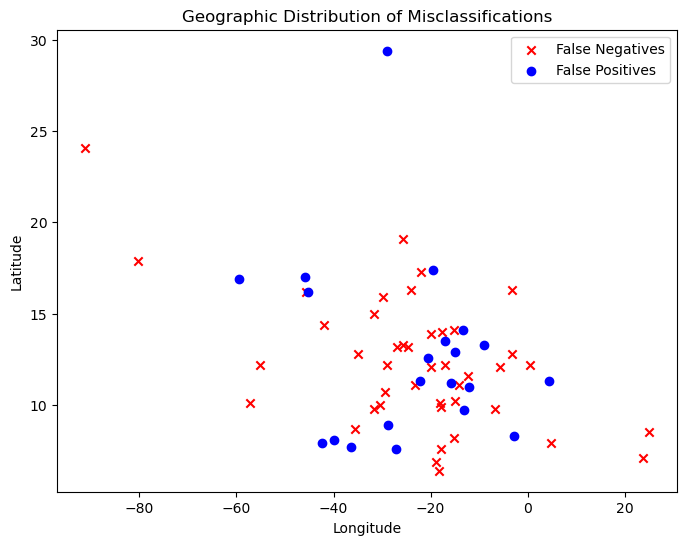

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(lon_false_neg, lat_false_neg, marker='x', color='red', label='False Negatives')
plt.scatter(lon_false_pos, lat_false_pos, marker='o', color='blue', label='False Positives')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographic Distribution of Misclassifications')
plt.legend()
plt.show()


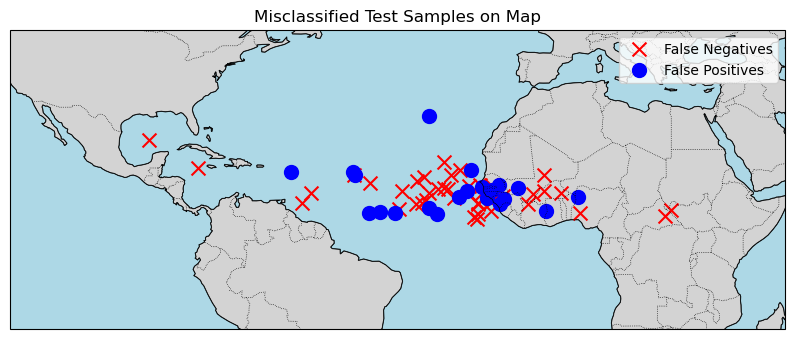

In [41]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())



lon_min, lon_max = np.min(lon_test)-15, np.max(lon_test)+15
lat_min, lat_max = np.min(lat_test)-15, np.max(lat_test)+15
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Plot misclassified points:
ax.scatter(lon_false_neg, lat_false_neg, color='red', marker='x', s=100,
           transform=ccrs.PlateCarree(), label='False Negatives')
ax.scatter(lon_false_pos, lat_false_pos, color='blue', marker='o', s=100,
           transform=ccrs.PlateCarree(), label='False Positives')

plt.title("Misclassified Test Samples on Map")
plt.legend()
plt.show()

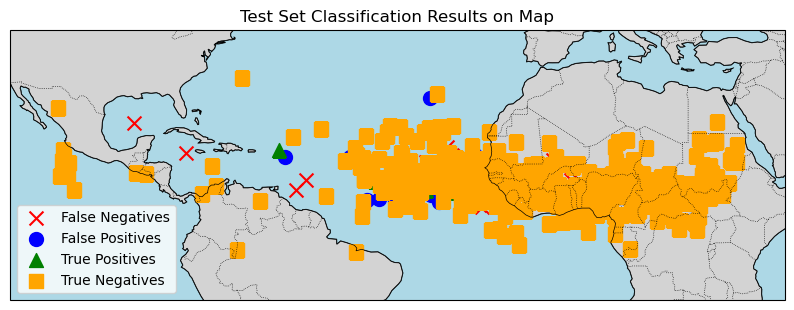

In [42]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set map extent (adjust margins as desired)
lon_min, lon_max = np.min(lon_test) - 10, np.max(lon_test) + 10
lat_min, lat_max = np.min(lat_test) - 10, np.max(lat_test) + 10
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray', edgecolor='black')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
# Plot misclassified points
ax.scatter(lon_false_neg, lat_false_neg, color='red', marker='x', s=100,
           transform=ccrs.PlateCarree(), label='False Negatives')
ax.scatter(lon_false_pos, lat_false_pos, color='blue', marker='o', s=100,
           transform=ccrs.PlateCarree(), label='False Positives')



# Plot correctly classified points
ax.scatter(lon_true_pos, lat_true_pos, color='green', marker='^', s=100,
           transform=ccrs.PlateCarree(), label='True Positives')
ax.scatter(lon_true_neg, lat_true_neg, color='orange', marker='s', s=100,
           transform=ccrs.PlateCarree(), label='True Negatives')

plt.title("Test Set Classification Results on Map")
plt.legend()
plt.show()


In [43]:
print("Total samples:", len(sample_lat))
print("Unique latitudes:", len(np.unique(sample_lat)))
print("Unique longitudes:", len(np.unique(sample_lon)))


Total samples: 2750
Unique latitudes: 251
Unique longitudes: 913


In [44]:
print("First 10 latitudes:", sample_lat[:10])
print("First 10 longitudes:", sample_lon[:10])


First 10 latitudes: <xarray.DataArray 'lat_center' (sample: 10)> Size: 80B
dask.array<getitem, shape=(10,), dtype=float64, chunksize=(10,), chunktype=numpy.ndarray>
Coordinates:
    file_name   (sample) <U102 4kB dask.array<chunksize=(10,), meta=np.ndarray>
    lat_center  (sample) float64 80B dask.array<chunksize=(10,), meta=np.ndarray>
    lon_center  (sample) float64 80B dask.array<chunksize=(10,), meta=np.ndarray>
  * sample      (sample) int64 80B 1 1 1 1 1 1 1 1 1 1
    time        (sample) datetime64[ns] 80B dask.array<chunksize=(10,), meta=np.ndarray>
First 10 longitudes: <xarray.DataArray 'lon_center' (sample: 10)> Size: 80B
dask.array<getitem, shape=(10,), dtype=float64, chunksize=(10,), chunktype=numpy.ndarray>
Coordinates:
    file_name   (sample) <U102 4kB dask.array<chunksize=(10,), meta=np.ndarray>
    lat_center  (sample) float64 80B dask.array<chunksize=(10,), meta=np.ndarray>
    lon_center  (sample) float64 80B dask.array<chunksize=(10,), meta=np.ndarray>
  * sample 

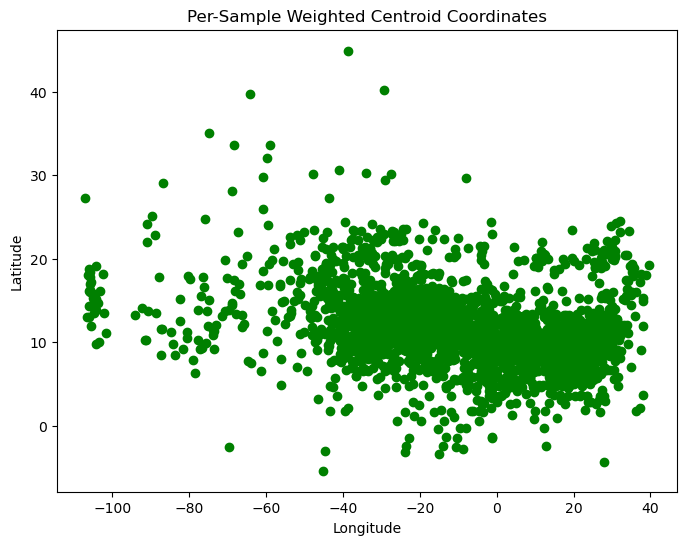

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(sample_lon, sample_lat, c='green', marker='o')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Per-Sample Weighted Centroid Coordinates')
plt.show()


In [46]:


# --- Permutation Importance ---
# Evaluate baseline performance using your loss metric (here, the custom f1_loss_sigmoid)
# model.metrics_names gives a list where index 0 is 'loss'
baseline_results = model.evaluate(input_test_scaled, label_test_scaled,
                                  batch_size=label_test_scaled.shape[0],
                                  verbose=0)
baseline_loss = baseline_results[model.metrics_names.index('loss')]
print("Baseline loss:", baseline_loss)

# Set the number of repetitions for averaging
n_repeats = 5
n_features = input_test_scaled.shape[-1]
permutation_importances = np.zeros(n_features)

# Loop over each feature (channel)
for feature_idx in range(n_features):
    permuted_losses = []
    for _ in range(n_repeats):
        # Copy the test set to avoid modifying the original
        X_permuted = np.copy(input_test_scaled)
        # Permute the values of the selected feature across samples
        perm = np.random.permutation(X_permuted.shape[0])
        X_permuted[:, :, :, feature_idx] = X_permuted[perm, :, :, feature_idx]
        
        # Evaluate the model on the permuted test set
        permuted_results = model.evaluate(X_permuted, label_test_scaled,
                                          batch_size=label_test_scaled.shape[0],
                                          verbose=0)
        permuted_loss = permuted_results[model.metrics_names.index('loss')]
        permuted_losses.append(permuted_loss)
    
    avg_permuted_loss = np.mean(permuted_losses)
    # The difference between the permuted loss and baseline loss indicates feature importance:
    # A larger increase means the feature is more important.
    permutation_importances[feature_idx] = avg_permuted_loss - baseline_loss
    print(f"Feature {feature_idx} - Increase in Loss: {permutation_importances[feature_idx]}")

print("Permutation Importances (increase in loss) for all features:", permutation_importances)


Baseline loss: 0.07472681254148483


Feature 0 - Increase in Loss: 0.011076216399669644


Feature 1 - Increase in Loss: 0.003298147022724157


Feature 2 - Increase in Loss: -0.002386172115802762


Feature 3 - Increase in Loss: 0.017706744372844696


Feature 4 - Increase in Loss: 0.004012915492057803


Feature 5 - Increase in Loss: 0.009503595530986786


Feature 6 - Increase in Loss: 0.005286386609077459


Feature 7 - Increase in Loss: 0.012539504468441015


Feature 8 - Increase in Loss: 0.009676288068294528


Feature 9 - Increase in Loss: 0.01763739436864853


Feature 10 - Increase in Loss: -0.0007608011364936829


Feature 11 - Increase in Loss: 0.025640003383159637


Feature 12 - Increase in Loss: -0.0012389302253723172


Feature 13 - Increase in Loss: 0.002639937400817874


Feature 14 - Increase in Loss: 0.007785110175609594


Feature 15 - Increase in Loss: 0.0002625659108161926


Feature 16 - Increase in Loss: 0.01345772594213486


Feature 17 - Increase in Loss: -0.00022432506084442416
Permutation Importances (increase in loss) for all features: [ 0.01107622  0.00329815 -0.00238617  0.01770674  0.00401292  0.0095036
  0.00528639  0.0125395   0.00967629  0.01763739 -0.0007608   0.02564
 -0.00123893  0.00263994  0.00778511  0.00026257  0.01345773 -0.00022433]


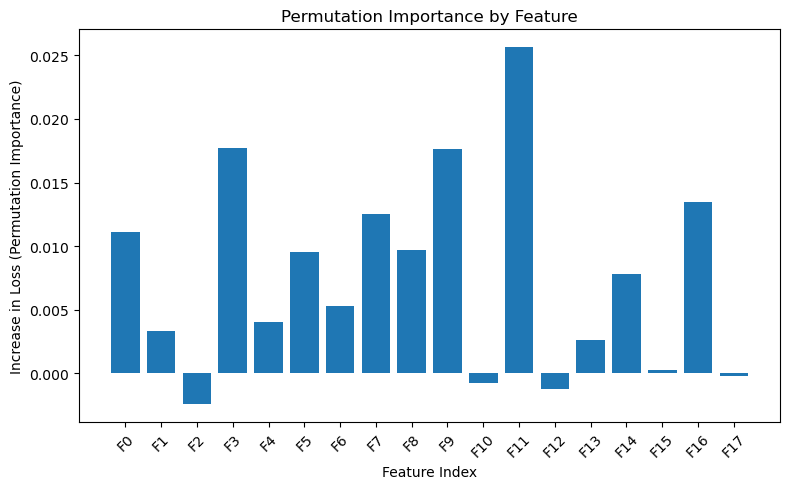

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Suppose permutation_importances is the numpy array you printed:
# e.g., [0.0820, 0.0824, 0.0815, 0.0864, 0.0121, ...]

feature_indices = np.arange(len(permutation_importances))

plt.figure(figsize=(8, 5))
plt.bar(feature_indices, permutation_importances)
plt.xlabel("Feature Index")
plt.ylabel("Increase in Loss (Permutation Importance)")
plt.title("Permutation Importance by Feature")
plt.xticks(feature_indices, [f"F{i}" for i in feature_indices], rotation=45)
plt.tight_layout()
plt.show()


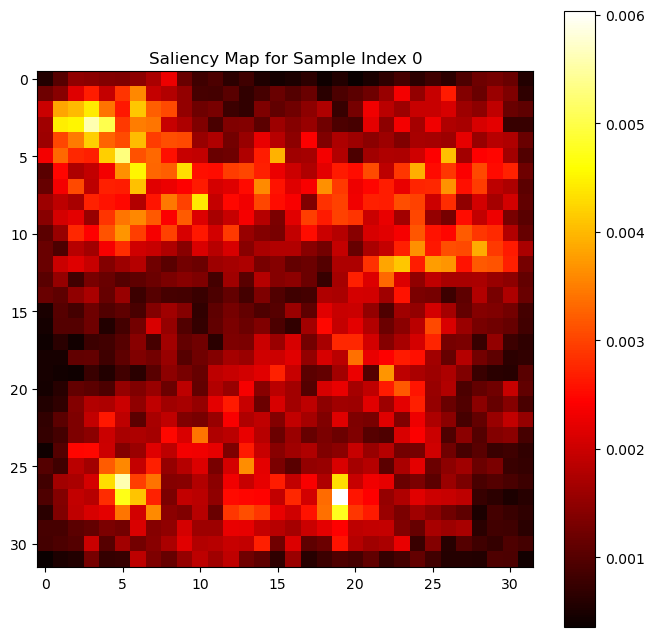

In [48]:
sample_index = 0
sample_input = input_test_scaled[sample_index:sample_index+1]

# Compute the saliency map for the selected test sample
saliency_map = compute_saliency_map(model, sample_input)

# Plot the saliency map
plt.figure(figsize=(8, 8))
plt.imshow(saliency_map, cmap='hot')
plt.colorbar()
plt.title(f"Saliency Map for Sample Index {sample_index}")
plt.show()



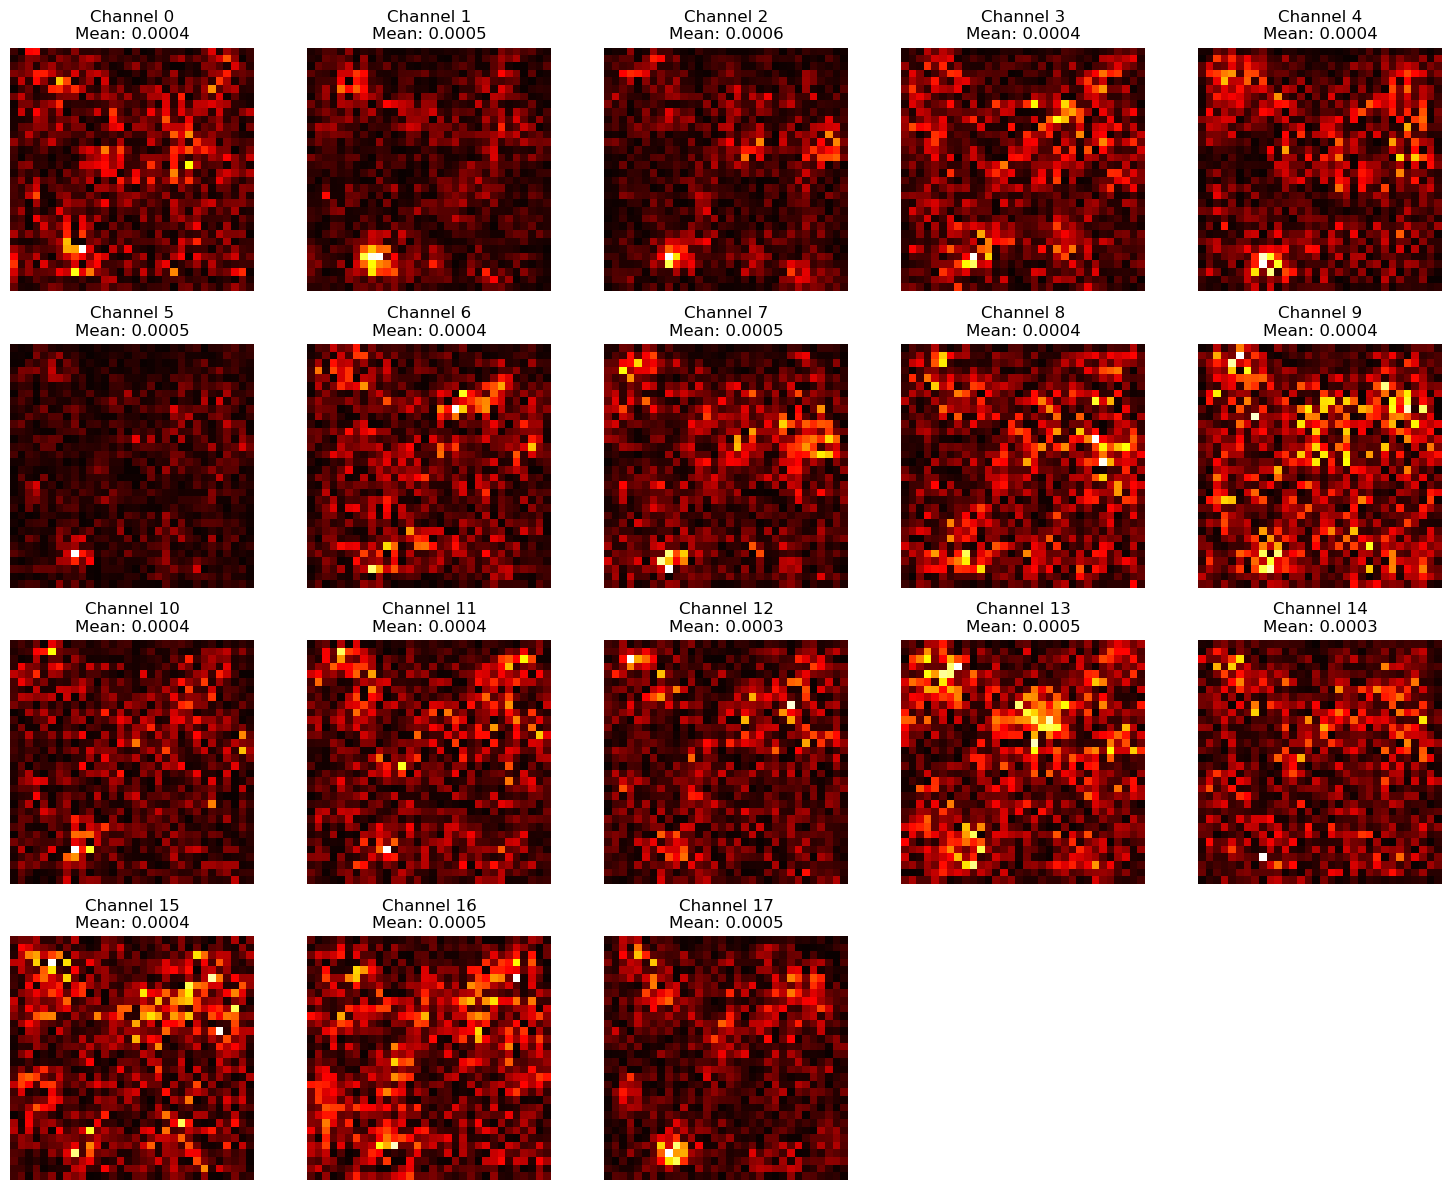

Channel importance (mean saliency per channel):
Channel 0: 0.0004
Channel 1: 0.0005
Channel 2: 0.0006
Channel 3: 0.0004
Channel 4: 0.0004
Channel 5: 0.0005
Channel 6: 0.0004
Channel 7: 0.0005
Channel 8: 0.0004
Channel 9: 0.0004
Channel 10: 0.0004
Channel 11: 0.0004
Channel 12: 0.0003
Channel 13: 0.0005
Channel 14: 0.0003
Channel 15: 0.0004
Channel 16: 0.0005
Channel 17: 0.0005


In [49]:
sample_index = 1
sample_input = input_test_scaled[sample_index:sample_index+1]

# Compute saliency maps per channel for the selected input sample
saliency_maps, channel_importance = compute_saliency_per_channel(model, sample_input)

# Plot the saliency maps for each channel
num_channels = saliency_maps.shape[-1]
cols = 5  # Set number of columns for plotting
rows = int(np.ceil(num_channels / cols))
plt.figure(figsize=(15, rows * 3))
for c in range(num_channels):
    plt.subplot(rows, cols, c + 1)
    plt.imshow(saliency_maps[:, :, c], cmap='hot')
    plt.title(f'Channel {c}\nMean: {channel_importance[c]:.4f}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Print aggregated channel importance values
print("Channel importance (mean saliency per channel):")
for c, imp in enumerate(channel_importance):
    print(f"Channel {c}: {imp:.4f}")


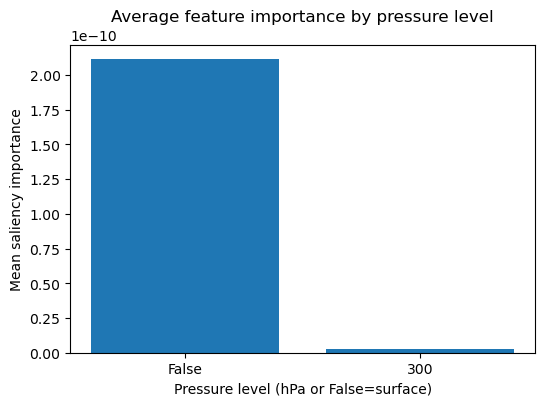

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Compute per‑sample, per‑channel saliency importances
all_imps = []
for x in input_test_scaled:             # each x has shape (32,32,channels)
    _, imp = compute_saliency_per_channel(best_model, x[np.newaxis,...])
    all_imps.append(imp)               # imp.shape == (channels,)
all_imps = np.stack(all_imps)          # shape (N_samples, channels)

# 2) Average importance across samples
mean_imp = all_imps.mean(axis=0)       # shape (channels,)

# 3) Build a DataFrame mapping feature→plevel→importance
df = pd.DataFrame({
    "feature": var_list,
    "plevel": plevel_list,
    "importance": mean_imp
})

# 4) Group by pressure level and plot
grouped = df.groupby("plevel")["importance"].mean().reset_index()
plt.figure(figsize=(6,4))
plt.bar(grouped["plevel"].astype(str), grouped["importance"])
plt.xlabel("Pressure level (hPa or False=surface)")
plt.ylabel("Mean saliency importance")
plt.title("Average feature importance by pressure level")
plt.show()


{'loss': 0.07472681254148483, 'compile_metrics': 0.31619539856910706}
    f1_score  val_f1_score
95  0.992167      0.434783
96  0.976744      0.480000
97  0.931990      0.560000
98  0.904523      0.400000
99  0.886139      0.476190


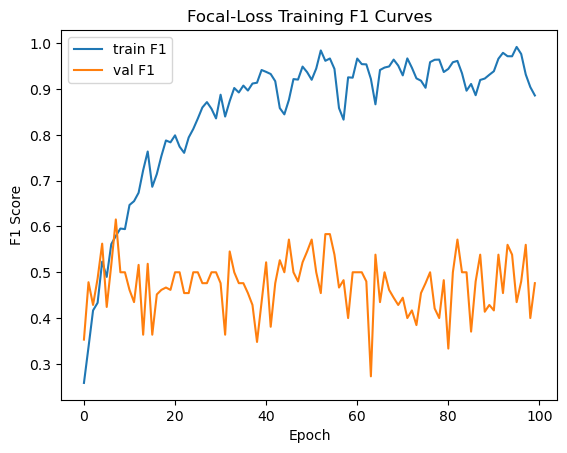

In [51]:
# 1) Print out full test‐set metrics by name
test_results = model.evaluate(
    input_test_scaled,
    label_test_scaled,
    batch_size=label_test_scaled.shape[0],
    verbose=0
)
print(dict(zip(model.metrics_names, test_results)))

# 2) Peek at the end of your training history for F1 improvements
import pandas as pd
hist_df = pd.DataFrame(history.history)
print(hist_df[['f1_score','val_f1_score']].tail())

# 3) (Optional) Plot train vs. val F1 over epochs
import matplotlib.pyplot as plt
plt.plot(hist_df['f1_score'],    label='train F1')
plt.plot(hist_df['val_f1_score'],label='val F1')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.title('Focal‐Loss Training F1 Curves')
plt.show()


In [52]:
# Replace your rebuild logic:
# top_hps = tuner.get_best_hyperparameters(num_trials=5)
# models  = [MyHyperModel().build(hp) for hp in top_hps]

# With this single line:
models = tuner.get_best_models(num_models=5)

# Then stack and average as before:
all_preds     = np.stack([m.predict(input_test_scaled).flatten() for m in models], axis=0)
ensemble_probs= all_preds.mean(axis=0)
ensemble_preds= (ensemble_probs >= 0.5).astype(int)
print("Ensemble F1:", f1_score(label_test_scaled, ensemble_preds))


/glade/u/home/rmandava/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/glade/u/home/rmandava/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step

13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step

13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step

13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step

13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


Ensemble F1: 0.0


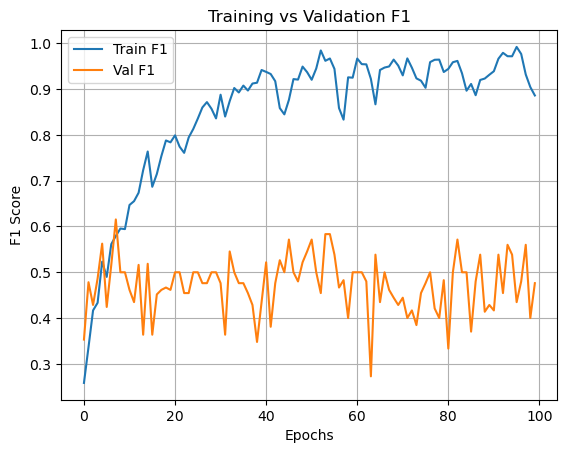

In [53]:
import matplotlib.pyplot as plt

plt.plot(history.history['f1_score'], label='Train F1')
plt.plot(history.history['val_f1_score'], label='Val F1')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Training vs Validation F1')
plt.legend()
plt.grid()
plt.show()


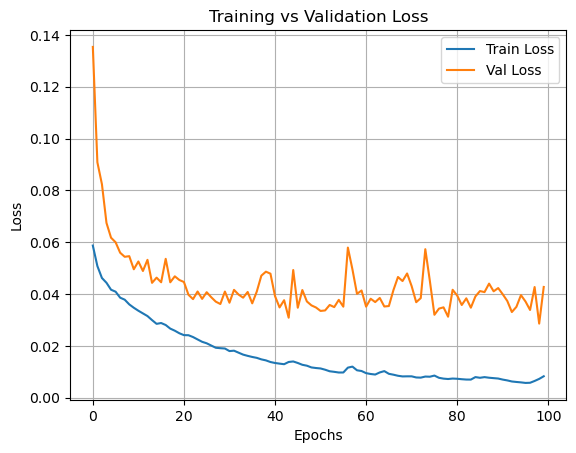

In [54]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid()
plt.show()
